# Notes
- unlike in _Generalized neural decoders for transfer learning across participants and recording modalities (J Neur. Eng.)_, we pre-train contrastively (without labels, although they exist). They pre-train on 11 datasets of 12.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os, argparse, json, copy, wandb, time

import umap
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from dataset_utils import *
from utils import HiddenPrints
import torch.fft as fft
from einops import rearrange, repeat

import pandas as pd
import numpy as np
from termcolor import cprint
from pprint import pprint
from tqdm import tqdm
from datetime import datetime

from train import finetune

from trainer import Trainer, model_finetune, model_test, model_pretrain
from train import evaluate

from augmentations import *
from dataloader import MIdatasetMC
from config_files.BIG_EEG_MI_1chRearrange_bigger import Config as Configs
# from config_files.BIG_EEG_MI_1chRearrange_bigger_1 import Config as Configs
from utils import _logger, set_requires_grad
from model import *
from EEGNetContrastive import EEGNetContrastive, ClassifierOnTopOfPreTrainedEEGNet
from utils import _calc_metrics, copy_Files
from loss import * # base_Model, base_Model_F, target_classifier
from sklearn.metrics import cohen_kappa_score as kappa



# For Arial
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams["text.usetex"] = False

# for latex:
# matplotlib.rcParams['font.family'] = "DejaVu Sans"
# matplotlib.rcParams['font.serif'] = "Computer Modern"
# matplotlib.rcParams["text.usetex"] = True

matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["axes.labelsize"] = 22
matplotlib.rcParams["xtick.labelsize"] = 22
matplotlib.rcParams["ytick.labelsize"] = 22
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams["legend.fontsize"] = 22
matplotlib.rcParams["axes.titlesize"] = 22
matplotlib.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["figure.autolayout"] = True

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'

print(f'CUDA available: {torch.cuda.is_available()}')
cprint(torch.__version__, color='green')
device_count = torch.cuda.device_count()
for i in range(device_count):
    torch.cuda.set_device(i)
    cur_device_id = torch.cuda.current_device()
    cur_device_name = torch.cuda.get_device_name(cur_device_id)
    print(f'Current device:\nID {cur_device_id} | Name: {cur_device_name}')
    print(f'supported arch list: {torch.cuda.get_arch_list()}\n')
    

2022-09-28 09:11:35.029694: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


CUDA available: True
1.12.1+cu113
Current device:
ID 0 | Name: RTX A6000
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Current device:
ID 1 | Name: Quadro P2200
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']



In [3]:
device = 'cuda:0'
configs = Configs()
# configs.report()

In [4]:
# load the data and instantiate the Dataset class

path = '../DATA2'
dataset = torch.load(os.path.join(path, "BIG_MI_12_datasets_53213samp.pt"))
dataset['info']

"Srate = 100 Hz, passband: 0-45 Hz, channels ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']. See meta for more details. See /home/roman/CODE/tachikoma-analysis/DATA"

In [5]:
pwd

'/home/roman/CODE/TFC/code'

# Splits 

Split the combined dataset into `pretrain_dataset` and `target_dataset` datsets. Then split the `target_dataset` into `finetune_dataset` and `test_datset`

In [5]:
shuffle = False
# targetDsName = 'BNCIPhysionetMotorImagery.pt'
targetDsName = 'BNCI001-2014.pt' # Graz 2a

test_subject = 1

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
train_dataset, test_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=test_subject)

# small fine-tuning dataset, big test dataset
train_dataset, test_dataset  = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=test_subject)

Nsubj = len(train_dataset['meta'].subject.unique())
cprint(f"Number of subjects in train_dataset: {Nsubj}", color='blue')
print(dataset['meta'].ds.unique())

BNCI001-2014.pt
pretrain_dataset: torch.Size([50621])
['right_hand' 'left_hand']
target_dataset: torch.Size([2592])
Total samples in pretrain and finetune: 53213
test_subject: 1
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
test_subject: 1
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
Number of subjects in train_dataset: 8
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']


In [6]:
print(pretrain_dataset['labels'].unique())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


In [7]:
test_dataset['info']

"Srate = 100 Hz, passband: 0-45 Hz, channels ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']. See meta for more details. See /home/roman/CODE/tachikoma-analysis/DATA"

In [9]:
test_dataset['meta']

subject    session    run       label               ds  class_id
28144        1  session_T  run_0  right_hand  BNCI001-2014.pt         0
28145        1  session_T  run_0   left_hand  BNCI001-2014.pt         1
28146        1  session_T  run_0   left_hand  BNCI001-2014.pt         1
28147        1  session_T  run_0  right_hand  BNCI001-2014.pt         0
28148        1  session_T  run_0  right_hand  BNCI001-2014.pt         0
...        ...        ...    ...         ...              ...       ...
28427        1  session_E  run_5   left_hand  BNCI001-2014.pt         1
28428        1  session_E  run_5   left_hand  BNCI001-2014.pt         1
28429        1  session_E  run_5   left_hand  BNCI001-2014.pt         1
28430        1  session_E  run_5  right_hand  BNCI001-2014.pt         0
28431        1  session_E  run_5   left_hand  BNCI001-2014.pt         1

[288 rows x 6 columns]

`pretrain_dataset` - contains all the datasets except `target_dataset` (the one held out and to be split for fine-tuning and testing)

`target_dataset` - contains dataset that is held out for fine-tuning and testing

In [10]:
# target dataset
print('Number of samples:', target_dataset['meta'].shape[0])
print('Number of subjects:', target_dataset['meta'].subject.unique())
print('Sessions:', target_dataset['meta'].session.unique())
print('Runs:', target_dataset['meta'].run.unique())

Number of samples: 2592
Number of subjects: [1 2 3 4 5 6 7 8 9]
Sessions: ['session_T' 'session_E']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']


# `train_dataset` and `test_dataset`
Datasets that are selected from `target_dataset` for fine-tuning and testing, respectively.

In [11]:
print(train_dataset['meta'].session.unique())
print(train_dataset['meta'].run.unique())
print(train_dataset['meta'].shape)
print(train_dataset['meta'].label.unique())

['session_T' 'session_E']
['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
(2304, 6)
['left_hand' 'right_hand']


In [12]:
print(test_dataset['meta'].session.unique())
print(test_dataset['meta'].run.unique())
print(test_dataset['meta'].shape)
print(test_dataset['meta'].label.unique())

['session_T' 'session_E']
['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
(288, 6)
['right_hand' 'left_hand']


<AxesSubplot:>

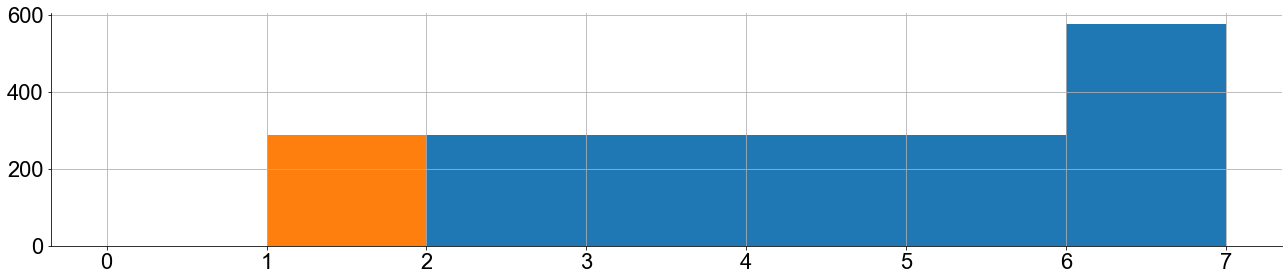

In [13]:
fig, ax = plt.subplots(1,1, figsize=(18,4))
train_dataset['meta'].subject.hist(ax=ax, bins=range(0,Nsubj), label='train')
test_dataset['meta'].subject.hist(ax=ax, bins=range(0,Nsubj), label='test')

In [14]:
!pwd

/home/roman/CODE/TFC/code


In [29]:
EEGnet = EEGNetContrastive(num_chan=7, kerLen=31, drop=0.5, F1=8, D=2, F2=16, emdim=48, device=device)
EEGnet.summary(num_time_samples=120)

******************************************************************************************
For 120 time samples, the network will look like this:
------------------------------------------------------------------------------------------
Conv2d(1, 8, kernel_size=(1, 31), stride=(1, 1), padding=same, bias=False)
------------------------------------------------------------------------------------------
Input: torch.Size([10, 1, 7, 120])
weight, torch.Size([8, 1, 1, 31]), Nparams: 248
Output: torch.Size([10, 8, 7, 120])

------------------------------------------------------------------------------------------
BatchNorm2d(8, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
------------------------------------------------------------------------------------------
Input: torch.Size([10, 8, 7, 120])
weight, torch.Size([8]), Nparams: 8
bias, torch.Size([8]), Nparams: 8
Output: torch.Size([10, 8, 7, 120])

--------------------------------------------------------------------------

# Pre-train the model

In [30]:
wandb.config = configs
wandb.init(project=f"EEGNet_7ch_BIGGER_pretrain_on_temp_augs_target_{targetDsName}", 
           entity="nightdude",
           config=wandb.config,
           save_code=False)
wandb.watch(EEGnet, log_freq=10)

# instantiate the Dataset class
pretrain_ds = MIdatasetMC(pretrain_dataset, configs)
target_ds = MIdatasetMC(target_dataset, configs)


# instantiate a dataloader for the fine-tuning dataset
pretrain_dl = torch.utils.data.DataLoader(
    dataset=pretrain_ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=14) # optimal: 14 workers with batch_size=60

target_dl = torch.utils.data.DataLoader(
    dataset=target_ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=14) # optimal: 14 workers with batch_size=60


model_optimizer = torch.optim.AdamW(EEGnet.model.parameters(),
                                   lr=configs.lr*5, # <<<<<<<<<<<<<<<<<<<<<<<<,
                                   betas=(configs.beta1, configs.beta2),
                                   weight_decay=3e-4)

# nt_xent_criterion = NTXentLoss_poly(
#             device,
#             configs.batch_size,
#             configs.Context_Cont.temperature,
#             configs.Context_Cont.use_cosine_similarity, 
#             batch_mult=1)  # needed for the reaarrange variant. Leave at default for others.

nt_xent_criterion = CLIPLossX(device, configs.batch_size)

EPOCHS = 600
L = []


for ep in range(0, EPOCHS):
    
    
    # train for one epoch
    EEGnet.model.train()
    train_loss = []
    for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in tqdm(enumerate(pretrain_dl)):

        x_t = x_t.float().to(device)
        y = y.long().to(device)
        x_t_aug = x_t_aug.float().to(device)
        # x_f, x_f_aug = x_f.float().to(device), x_f_aug.float().to(device)
        
        model_optimizer.zero_grad()

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t = EEGnet.forward(x_t)                         # original data
        h_t_aug = EEGnet.forward(x_t_aug)                 # augmented data

        
        loss = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
        train_loss.append(loss.item())
        
        loss.backward()
        model_optimizer.step()
        EEGnet.max_norm()
    
    # evaluate
    EEGnet.model.eval()
    eval_loss = []
    for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in tqdm(enumerate(target_dl)):

        x_t = x_t.float().to(device)
        y = y.long().to(device)
        x_t_aug = x_t_aug.float().to(device)
        # x_f, x_f_aug = x_f.float().to(device), x_f_aug.float().to(device)
        
        model_optimizer.zero_grad()      
        
        h_t = EEGnet.forward(x_t)                         # original data
        h_t_aug = EEGnet.forward(x_t_aug)                 # augmented data

        
        loss = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
        eval_loss.append(loss.item())
        
        

    performance_now = {
        'ep': ep,
        'train_loss': np.mean(train_loss),
        'eval_loss': np.mean(eval_loss)
    }
    L.append(performance_now)
    wandb.log(performance_now)

    
wandb.finish()

torch.Size([50621, 7, 120])
torch.Size([2592, 7, 120])


527it [00:13, 40.20it/s]
27it [00:00, 59.81it/s]
527it [00:13, 40.20it/s]
27it [00:00, 67.55it/s]
527it [00:13, 39.78it/s]
27it [00:00, 59.56it/s]
527it [00:12, 40.59it/s]
27it [00:00, 62.19it/s]
527it [00:13, 39.63it/s]
27it [00:00, 63.65it/s]
527it [00:13, 39.04it/s]
27it [00:00, 60.38it/s]
527it [00:13, 39.92it/s]
27it [00:00, 59.00it/s]
527it [00:13, 40.17it/s]
27it [00:00, 60.28it/s]
527it [00:13, 39.87it/s]
27it [00:00, 58.00it/s]
527it [00:13, 39.96it/s]
27it [00:00, 61.00it/s]
527it [00:13, 39.77it/s]
27it [00:00, 60.38it/s]
527it [00:13, 39.87it/s]
27it [00:00, 59.11it/s]
527it [00:13, 39.89it/s]
27it [00:00, 56.59it/s]
527it [00:13, 39.83it/s]
27it [00:00, 62.97it/s]
527it [00:13, 39.69it/s]
27it [00:00, 59.56it/s]
527it [00:13, 40.34it/s]
27it [00:00, 60.36it/s]
527it [00:12, 40.90it/s]
27it [00:00, 61.68it/s]
527it [00:13, 40.06it/s]
27it [00:00, 62.82it/s]
527it [00:13, 40.14it/s]
27it [00:00, 62.59it/s]
527it [00:13, 40.11it/s]
27it [00:00, 62.98it/s] 
527it [00:13, 40.53

27it [00:00, 61.73it/s]
527it [00:13, 39.30it/s]
27it [00:00, 62.36it/s]
527it [00:13, 40.47it/s]
27it [00:00, 61.43it/s]
527it [00:12, 40.67it/s]
27it [00:00, 58.14it/s]
527it [00:13, 39.66it/s]
27it [00:00, 62.15it/s]
527it [00:13, 39.86it/s]
27it [00:00, 62.75it/s] 
527it [00:12, 40.76it/s]
27it [00:00, 66.07it/s] 
527it [00:13, 39.97it/s]
27it [00:00, 59.35it/s]
527it [00:13, 39.38it/s]
27it [00:00, 65.78it/s]
527it [00:13, 39.87it/s]
27it [00:00, 59.60it/s]
527it [00:13, 39.38it/s]
27it [00:00, 60.35it/s]
527it [00:13, 40.27it/s]
27it [00:00, 62.20it/s]
277it [00:07, 36.51it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<AxesSubplot:xlabel='ep'>

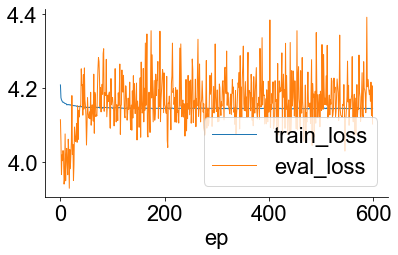

In [33]:
pd.DataFrame(L).plot(x='ep', y=['train_loss', 'eval_loss'], lw=1)

In [34]:
# save model parameters
# torch.save(EEGnet.state_dict(), 'EEGNet_7ch_BIGGER_pretrain_on_temp_augs.wts')
# torch.save(EEGnet.state_dict(), 'EEGNet_7ch_BIGGER_pretrain_on_temp_augs_Flatten.wts')
torch.save(EEGnet.state_dict(), 'EEGNet_7ch_BIGGER_pretrain_on_temp_augs_Flatten_aug_conf1.wts')

In [36]:
classifier = ClassifierOnTopOfPreTrainedEEGNet(emdim=48, num_classes=2)
classifier

number of parameters in model: 1274


ClassifierOnTopOfPreTrainedEEGNet(
  (layer0): Linear(in_features=48, out_features=24, bias=True)
  (layer1): Linear(in_features=24, out_features=2, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (activate): ELU(alpha=1.0)
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# Finetune EEGNet on several subjects in a held out dataset, test on the ONE held-out subject from the held-out dataset

# 🔥Experiment 2: Cross-Subject Transfer

Fine-tune the feature extractor on all subjects in the target dataset except one held out, test on the held out one.

- `targetDsName = 'BNCI001-2014.pt'`
- `pretrain_dataset`: all datasets but the `targetDsName`
- `finetune_dataset`: all subjects in the `target_dataset` except one subject held-out from `target_dataset`
- `test_dataset`: the held-out subject from the `target_dataset`

In [ ]:
def EEGNet_finetune(train_dataset, test_dataset,
                    epochs=50, mode='untrained feat det', targetDsName=None, subjID=None):
    
    EEGnet = EEGNetContrastive(num_chan=7, kerLen=31, drop=0.5, F1=8, D=2, F2=16, emdim=48, device=device)
    if not mode == 'trained_unfrozen_fd':
        EEGnet.load_state_dict(torch.load('../weights/EEGNet_7ch_BIGGER_pretrain_on_temp_augs_Flatten.wts'))
    
    # EEGnet.summary(num_time_samples=120)
    
    nclass = len(test_dataset['meta'].class_id.unique())
    cprint(f'number of classes: {nclass}', 'red')
    
    classifier = ClassifierOnTopOfPreTrainedEEGNet(emdim=48, num_classes=nclass).to(device)
    
    
    wandb.config = configs
    wandb.init(project="EEGNet_7ch_BIGGER_finetune_on_temp_augs_ftmany_tst1",
               group=f'{mode}_{targetDsName}_{subjID}',
               entity="nightdude",
               config=wandb.config,
               save_code=False)
    wandb.watch((EEGnet, classifier), log_freq=10)
    
#     nt_xent_criterion = NTXentLoss_poly(
#             device,
#             configs.batch_size,
#             configs.Context_Cont.temperature,
#             configs.Context_Cont.use_cosine_similarity, 
#             batch_mult=1)  # needed for the reaarrange variant. Leave at default for others.
    nt_xent_criterion = CLIPLossX(device, configs.batch_size)

    feature_extractor_optimizer = torch.optim.AdamW(
        EEGnet.model.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=3e-4)
    
    classifer_criterion = nn.CrossEntropyLoss()
    classifier_optimizer = torch.optim.AdamW(
        classifier.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=0.01)


    # instantiate the Dataset class
    ds = MIdatasetMC(train_dataset, configs)

    # instantiate a dataloader for the fine-tuning dataset
    dl = torch.utils.data.DataLoader(dataset=ds,
                                              batch_size=configs.batch_size,
                                              shuffle=True,
                                              drop_last=True,
                                              num_workers=14)  # optimal: 14 workers with batch_size=60
    
    EVAL_ACC = []
    evalAcc = 0
    for ep in range(epochs):
        epAcc = []
        pbar = tqdm(enumerate(dl))
        
        if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
            EEGnet.model.train()
        else:
            EEGnet.model.eval()
        
        classifier.train()
    
        for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in pbar:

            x_t = x_t.float().to(device)
            y = y.long().to(device)
            x_t_aug = x_t_aug.float().to(device)
            

            feature_extractor_optimizer.zero_grad()
            classifier_optimizer.zero_grad()
        
            # embed time representation and frequency representations (h). Z's are projections into joint TF space
            h_t = EEGnet.forward(x_t)                         # original data
            h_t_aug = EEGnet.forward(x_t_aug)                 # augmented data
            pred = classifier(h_t)
            
            class_loss = classifer_criterion(pred, y)  # predictor loss, actually, here is training loss
            feat_loss = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:                
                total_loss = feat_loss + class_loss
            else:
                total_loss = class_loss
        
            total_loss.backward()
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
                feature_extractor_optimizer.step()
                EEGnet.max_norm()
            classifier_optimizer.step()
            
            withinBatchAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
            epAcc.append(withinBatchAcc)
            pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
            


        # evaluate:
        EEGnet.model.eval()
        classifier.eval()
        x_t = test_dataset['samples'].float().to(device)
        y = test_dataset['labels']
        h_t = EEGnet.forward(x_t)
        pred = classifier(h_t)
        evalAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
        pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
        EVAL_ACC.append(evalAcc)
        
        performance_now = {
            'ep': ep,
            'feat_loss': feat_loss.item(),
            'class_loss': class_loss.item(),
            'total_loss': total_loss.item(),
            'train_acc': np.mean(epAcc),
            'eval_acc': evalAcc}
        wandb.log(performance_now)
        
    wandb.finish()
    return np.max(EVAL_ACC), np.mean(epAcc)


modes = [f'trained_unfrozen_fd',
         f'untrained_unfrozen_fd',
         f'trained_frozen_fd']


targetDsName = 'BNCI001-2014.pt'
shuffle = False


pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)

for test_subject in target_dataset['meta'].subject.unique():
    train_dataset, test_dataset  = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=test_subject)
    for i in range(3):
        for mode in modes:
            EEGNet_finetune(train_dataset, test_dataset,
                            epochs=100, mode=mode, targetDsName=targetDsName, subjID=test_subject)
            

In [149]:
targetDsName = 'BNCI001-2014.pt'
shuffle = False
test_subject = 1

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
subjectIDs = target_dataset['meta'].subject.unique().tolist()

train_dataset, test_dataset  = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=test_subject)

# target dataset
cprint('target dataset', 'white', 'on_grey',  attrs=['bold'])
print('Number of samples:', target_dataset['meta'].shape[0])
print('Number of subjects:', target_dataset['meta'].subject.unique())
print('Sessions:', target_dataset['meta'].session.unique())
print('Runs:', target_dataset['meta'].run.unique())
print(train_dataset['meta'].label.unique())

# train dataset
cprint('train dataset', 'white', 'on_grey',  attrs=['bold'])
print('Number of samples:', train_dataset['meta'].shape[0])
print('Number of subjects:', train_dataset['meta'].subject.unique())
print('Sessions:', train_dataset['meta'].session.unique())
print('Runs:', train_dataset['meta'].run.unique())
print('Labels:', train_dataset['meta'].label.unique())

# test dataset
cprint('test dataset', 'white', 'on_grey',  attrs=['bold'])
print('Number of samples:', test_dataset['meta'].shape[0])
print('Number of subjects:', test_dataset['meta'].subject.unique())
print('Sessions:', test_dataset['meta'].session.unique())
print('Runs:', test_dataset['meta'].run.unique())
print('Labels:', test_dataset['meta'].label.unique())

BNCI001-2014.pt
pretrain_dataset: torch.Size([50621])
['right_hand' 'left_hand']
target_dataset: torch.Size([2592])
Total samples in pretrain and finetune: 53213
test_subject: 1
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
target dataset
Number of samples: 2592
Number of subjects: [1 2 3 4 5 6 7 8 9]
Sessions: ['session_T' 'session_E']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
['left_hand' 'right_hand']
train dataset
Number of samples: 2304
Number of subjects: [2 3 4 5 6 7 8 9]
Sessions: ['session_T' 'session_E']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
Labels: ['left_hand' 'right_hand']
test dataset
Number of samples: 288
Number of subjects: [1]
Sessions: ['session_T' 'session_E']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
Labels: ['right_hand' 'left_hand']


# experiment 3

# Finetune EEGNet on ONE subject in a held out dataset, test on the other subjects from the held-out dataset (Hard)

In [7]:
def EEGNet_finetune(train_dataset, test_dataset, epochs=50, mode=None, targetDsName=None, subjID=None):
    
    batch_size = len(train_dataset['labels'])
    
    EEGnet = EEGNetContrastive(num_chan=7, kerLen=31, drop=0.5, F1=8, D=2, F2=16, emdim=48, device=device)
    if mode in [f'trained_unfrozen_fd', f'trained_frozen_fd']:
        cprint('initializing feature detector with pretrained weights', 'grey', 'on_red', attrs=['bold'])
        EEGnet.load_state_dict(torch.load('../weights/EEGNet_7ch_BIGGER_pretrain_on_temp_augs_Flatten.wts'))
    elif mode == f'untrained_unfrozen_fd':
        cprint('Starting with a clean feature detector', 'yellow', 'on_grey', attrs=['bold'])
    else:
        raise ValueError('Wrong mode')
        
    
    # EEGnet.summary(num_time_samples=120)
    
    nclass = len(test_dataset['meta'].class_id.unique())
    cprint(f'number of classes: {nclass}', 'red')
    
    classifier = ClassifierOnTopOfPreTrainedEEGNet(emdim=48, num_classes=nclass).to(device)
    
    
    wandb.config = configs
    wandb.init(project="EEGNet_7ch_BIGGER_finetune_on_temp_augs_hard",
               group=f'{mode}_{targetDsName}_{subjID}',
               entity="nightdude",
               config=wandb.config,
               save_code=False)
    wandb.watch((EEGnet, classifier), log_freq=10)
   

    nt_xent_criterion = NTXentLoss_poly(
            device,
            batch_size,
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity, 
            batch_mult=1)  # needed for the reaarrange variant. Leave at default for others.
    feature_extractor_optimizer = torch.optim.AdamW(
        EEGnet.model.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=3e-4)
    
    classifer_criterion = nn.CrossEntropyLoss()
    classifier_optimizer = torch.optim.AdamW(
        classifier.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=3e-4)


    # instantiate the Dataset class
    ds = MIdatasetMC(train_dataset, configs)

    # instantiate a dataloader for the fine-tuning dataset
    dl = torch.utils.data.DataLoader(dataset=ds,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True,
                                              num_workers=1)  # optimal: 14 workers with batch_size=60
    
    EVAL_ACC = []
    evalAcc = 0
    for ep in range(epochs):
        epAcc = []
        pbar = tqdm(enumerate(dl))
        
        if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
            EEGnet.model.train()
        elif mode == 'trained_frozen_fd':
            EEGnet.model.eval()
        else:
            raise ValueError('Wrong mode')
        
        classifier.train()
    
        for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in pbar:

            x_t = x_t.float().to(device)
            y = y.long().to(device)
            x_t_aug = x_t_aug.float().to(device)
            

            feature_extractor_optimizer.zero_grad()
            classifier_optimizer.zero_grad()
        
            # embed time representation and frequency representations (h). Z's are projections into joint TF space
            h_t = EEGnet.forward(x_t)                         # original data
            h_t_aug = EEGnet.forward(x_t_aug)                 # augmented data
            pred = classifier(h_t)
            
            class_loss = classifer_criterion(pred, y)  # predictor loss, actually, here is training loss
            feat_loss = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:                
                total_loss = feat_loss + class_loss
            elif mode == 'trained_frozen_fd':
                total_loss = class_loss
            else:
                raise ValueError('Wrong mode')
                
            total_loss.backward()
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
                feature_extractor_optimizer.step()
                EEGnet.max_norm()
            classifier_optimizer.step()
            
            withinBatchAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
            epAcc.append(withinBatchAcc)
            pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
            


        # evaluate:
        EEGnet.model.eval()
        classifier.eval()
        x_t = test_dataset['samples'].float().to(device)
        y = test_dataset['labels']
        h_t = EEGnet.forward(x_t)
        pred = classifier(h_t)
        evalAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
        pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
        EVAL_ACC.append(evalAcc)
        
        performance_now = {
            'ep': ep,
            'feat_loss': feat_loss.item(),
            'class_loss': class_loss.item(),
            'total_loss': total_loss.item(),
            'train_acc': np.mean(epAcc),
            'eval_acc': evalAcc}
        wandb.log(performance_now)
        
    wandb.finish()
    return np.max(EVAL_ACC), np.mean(epAcc)

       
    
    
modes = [f'trained_unfrozen_fd',
         f'untrained_unfrozen_fd',
         f'trained_frozen_fd']


targetDsName = 'BNCI001-2014.pt'
shuffle = False

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
subjectIDs = target_dataset['meta'].subject.unique().tolist()

for test_subject in subjectIDs:
    # small fine-tuning dataset, big test dataset
    cprint('WARNING! swapping the train and test datasets!!!', 'grey', 'on_yellow')
    test_dataset, train_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=test_subject)
    # train_dataset, test_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=None)
    
    for i in range(3):
        Nsubj = len(train_dataset['meta'].subject.unique())
        cprint(f"Number of subjects in train_dataset: {Nsubj}", color='blue')
        print(dataset['meta'].ds.unique())

        for mode in modes:
            EEGNet_finetune(train_dataset, test_dataset,
                            epochs=300, mode=mode, targetDsName=targetDsName, subjID=test_subject)


BNCI001-2014.pt
pretrain_dataset: torch.Size([50621])
['right_hand' 'left_hand']
target_dataset: torch.Size([2592])
Total samples in pretrain and finetune: 53213
WARNING! swapping the train and test datasets!!!
test_subject: 1
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  2.37it/s]
epoch_acc: 0.51 evalAcc: 0.48 batch_acc: 0.51: : 1it [00:00,  2.23it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  2.32it/s]
epoch_acc: 0.55 evalAcc: 0.48 batch_acc: 0.55: : 1it [00:00,  2.30it/s]
epoch_acc: 0.51 evalAcc: 0.48 batch_acc: 0.51: : 1it [00:00,  2.32it/s]
epoch_acc: 0.52 evalAcc: 0.47 batch_acc: 0.52: : 1it [00:00,  2.20it/s]
epoch_acc: 0.56 evalAcc: 0.47 batch_acc: 0.56: : 1it [00:00,  2.28it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  2.31it/s]
epoch_acc: 0.51 evalAcc: 0.47 batch_acc: 0.51: : 1it [00:00,  2.30it/s]
epoch_acc: 0.51 evalAcc: 0.47 batch_acc: 0.51: : 1it [00:00,  2.07it/s]
epoch_acc: 0.51 evalAcc: 0.47 batch_acc: 0.51: : 1it [00:00,  2.25it/s]
epoch_acc: 0.51 evalAcc: 0.47 batch_acc: 0.51: : 1it [00:00,  2.31it/s]
epoch_acc: 0.56 evalAcc: 0.47 batch_acc: 0.56: : 1it [00:00,  2.34it/s]
epoch_acc: 0.49 evalAcc: 0.47 batch_acc: 0.49: : 1it [00:00,  2.

epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  2.26it/s]
epoch_acc: 0.66 evalAcc: 0.56 batch_acc: 0.66: : 1it [00:00,  2.33it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  2.39it/s]
epoch_acc: 0.69 evalAcc: 0.57 batch_acc: 0.69: : 1it [00:00,  2.16it/s]
epoch_acc: 0.67 evalAcc: 0.57 batch_acc: 0.67: : 1it [00:00,  2.33it/s]
epoch_acc: 0.66 evalAcc: 0.56 batch_acc: 0.66: : 1it [00:00,  2.28it/s]
epoch_acc: 0.72 evalAcc: 0.57 batch_acc: 0.72: : 1it [00:00,  2.19it/s]
epoch_acc: 0.69 evalAcc: 0.57 batch_acc: 0.69: : 1it [00:00,  2.30it/s]
epoch_acc: 0.67 evalAcc: 0.57 batch_acc: 0.67: : 1it [00:00,  2.18it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  2.24it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  2.30it/s]
epoch_acc: 0.67 evalAcc: 0.56 batch_acc: 0.67: : 1it [00:00,  2.33it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  2.23it/s]
epoch_acc: 0.70 evalAcc: 0.57 batch_acc: 0.70: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.55 evalAcc: 0.00 batch_acc: 0.55: : 1it [00:00,  2.48it/s]
epoch_acc: 0.51 evalAcc: 0.56 batch_acc: 0.51: : 1it [00:00,  2.27it/s]
epoch_acc: 0.50 evalAcc: 0.57 batch_acc: 0.50: : 1it [00:00,  2.27it/s]
epoch_acc: 0.46 evalAcc: 0.58 batch_acc: 0.46: : 1it [00:00,  2.38it/s]
epoch_acc: 0.56 evalAcc: 0.58 batch_acc: 0.56: : 1it [00:00,  2.29it/s]
epoch_acc: 0.56 evalAcc: 0.58 batch_acc: 0.56: : 1it [00:00,  2.29it/s]
epoch_acc: 0.51 evalAcc: 0.58 batch_acc: 0.51: : 1it [00:00,  2.24it/s]
epoch_acc: 0.55 evalAcc: 0.58 batch_acc: 0.55: : 1it [00:00,  2.26it/s]
epoch_acc: 0.54 evalAcc: 0.59 batch_acc: 0.54: : 1it [00:00,  2.30it/s]
epoch_acc: 0.53 evalAcc: 0.58 batch_acc: 0.53: : 1it [00:00,  2.11it/s]
epoch_acc: 0.54 evalAcc: 0.58 batch_acc: 0.54: : 1it [00:00,  2.24it/s]
epoch_acc: 0.48 evalAcc: 0.59 batch_acc: 0.48: : 1it [00:00,  2.33it/s]
epoch_acc: 0.58 evalAcc: 0.59 batch_acc: 0.58: : 1it [00:00,  2.26it/s]
epoch_acc: 0.56 evalAcc: 0.59 batch_acc: 0.56: : 1it [00:00,  2.

epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  2.35it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  2.34it/s]
epoch_acc: 0.67 evalAcc: 0.59 batch_acc: 0.67: : 1it [00:00,  2.35it/s]
epoch_acc: 0.70 evalAcc: 0.59 batch_acc: 0.70: : 1it [00:00,  2.05it/s]
epoch_acc: 0.66 evalAcc: 0.59 batch_acc: 0.66: : 1it [00:00,  2.32it/s]
epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  2.23it/s]
epoch_acc: 0.67 evalAcc: 0.59 batch_acc: 0.67: : 1it [00:00,  2.41it/s]
epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  2.29it/s]
epoch_acc: 0.70 evalAcc: 0.59 batch_acc: 0.70: : 1it [00:00,  2.28it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  2.39it/s]
epoch_acc: 0.67 evalAcc: 0.59 batch_acc: 0.67: : 1it [00:00,  2.18it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  2.39it/s]
epoch_acc: 0.67 evalAcc: 0.59 batch_acc: 0.67: : 1it [00:00,  2.34it/s]
epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  2.40it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  2.44it/s]
epoch_acc: 0.48 evalAcc: 0.45 batch_acc: 0.48: : 1it [00:00,  2.26it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.35it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.42it/s]
epoch_acc: 0.49 evalAcc: 0.47 batch_acc: 0.49: : 1it [00:00,  2.31it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  2.28it/s]
epoch_acc: 0.51 evalAcc: 0.48 batch_acc: 0.51: : 1it [00:00,  2.32it/s]
epoch_acc: 0.49 evalAcc: 0.48 batch_acc: 0.49: : 1it [00:00,  2.38it/s]
epoch_acc: 0.52 evalAcc: 0.47 batch_acc: 0.52: : 1it [00:00,  2.15it/s]
epoch_acc: 0.53 evalAcc: 0.48 batch_acc: 0.53: : 1it [00:00,  2.43it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  2.38it/s]
epoch_acc: 0.49 evalAcc: 0.48 batch_acc: 0.49: : 1it [00:00,  2.34it/s]
epoch_acc: 0.53 evalAcc: 0.49 batch_acc: 0.53: : 1it [00:00,  2.

epoch_acc: 0.78 evalAcc: 0.58 batch_acc: 0.78: : 1it [00:00,  2.31it/s]
epoch_acc: 0.73 evalAcc: 0.57 batch_acc: 0.73: : 1it [00:00,  2.29it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  2.38it/s]
epoch_acc: 0.73 evalAcc: 0.58 batch_acc: 0.73: : 1it [00:00,  2.18it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  2.38it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.44it/s]
epoch_acc: 0.72 evalAcc: 0.58 batch_acc: 0.72: : 1it [00:00,  2.35it/s]
epoch_acc: 0.73 evalAcc: 0.58 batch_acc: 0.73: : 1it [00:00,  2.35it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.37it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  2.39it/s]
epoch_acc: 0.73 evalAcc: 0.58 batch_acc: 0.73: : 1it [00:00,  2.28it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.27it/s]
epoch_acc: 0.73 evalAcc: 0.58 batch_acc: 0.73: : 1it [00:00,  2.32it/s]
epoch_acc: 0.77 evalAcc: 0.58 batch_acc: 0.77: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.52 evalAcc: 0.00 batch_acc: 0.52: : 1it [00:00,  2.39it/s]
epoch_acc: 0.50 evalAcc: 0.56 batch_acc: 0.50: : 1it [00:00,  2.22it/s]
epoch_acc: 0.51 evalAcc: 0.56 batch_acc: 0.51: : 1it [00:00,  2.36it/s]
epoch_acc: 0.52 evalAcc: 0.56 batch_acc: 0.52: : 1it [00:00,  2.29it/s]
epoch_acc: 0.51 evalAcc: 0.57 batch_acc: 0.51: : 1it [00:00,  2.27it/s]
epoch_acc: 0.53 evalAcc: 0.56 batch_acc: 0.53: : 1it [00:00,  2.28it/s]
epoch_acc: 0.51 evalAcc: 0.57 batch_acc: 0.51: : 1it [00:00,  2.25it/s]
epoch_acc: 0.57 evalAcc: 0.56 batch_acc: 0.57: : 1it [00:00,  2.33it/s]
epoch_acc: 0.52 evalAcc: 0.57 batch_acc: 0.52: : 1it [00:00,  2.38it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  2.07it/s]
epoch_acc: 0.52 evalAcc: 0.57 batch_acc: 0.52: : 1it [00:00,  2.31it/s]
epoch_acc: 0.53 evalAcc: 0.57 batch_acc: 0.53: : 1it [00:00,  2.16it/s]
epoch_acc: 0.48 evalAcc: 0.58 batch_acc: 0.48: : 1it [00:00,  2.35it/s]
epoch_acc: 0.54 evalAcc: 0.58 batch_acc: 0.54: : 1it [00:00,  2.

epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  2.35it/s]
epoch_acc: 0.69 evalAcc: 0.57 batch_acc: 0.69: : 1it [00:00,  2.29it/s]
epoch_acc: 0.66 evalAcc: 0.57 batch_acc: 0.66: : 1it [00:00,  2.21it/s]
epoch_acc: 0.69 evalAcc: 0.58 batch_acc: 0.69: : 1it [00:00,  2.18it/s]
epoch_acc: 0.64 evalAcc: 0.57 batch_acc: 0.64: : 1it [00:00,  2.27it/s]
epoch_acc: 0.70 evalAcc: 0.58 batch_acc: 0.70: : 1it [00:00,  2.26it/s]
epoch_acc: 0.69 evalAcc: 0.58 batch_acc: 0.69: : 1it [00:00,  2.26it/s]
epoch_acc: 0.65 evalAcc: 0.57 batch_acc: 0.65: : 1it [00:00,  2.39it/s]
epoch_acc: 0.69 evalAcc: 0.58 batch_acc: 0.69: : 1it [00:00,  2.28it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  2.31it/s]
epoch_acc: 0.65 evalAcc: 0.58 batch_acc: 0.65: : 1it [00:00,  2.37it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  2.29it/s]
epoch_acc: 0.66 evalAcc: 0.57 batch_acc: 0.66: : 1it [00:00,  2.22it/s]
epoch_acc: 0.65 evalAcc: 0.57 batch_acc: 0.65: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.53 evalAcc: 0.00 batch_acc: 0.53: : 1it [00:00,  2.35it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.27it/s]
epoch_acc: 0.53 evalAcc: 0.49 batch_acc: 0.53: : 1it [00:00,  2.16it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  2.25it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  2.32it/s]
epoch_acc: 0.52 evalAcc: 0.49 batch_acc: 0.52: : 1it [00:00,  2.29it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  2.26it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  2.28it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  2.32it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  2.14it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  2.32it/s]
epoch_acc: 0.55 evalAcc: 0.49 batch_acc: 0.55: : 1it [00:00,  2.37it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.31it/s]
epoch_acc: 0.51 evalAcc: 0.49 batch_acc: 0.51: : 1it [00:00,  2.

epoch_acc: 0.67 evalAcc: 0.59 batch_acc: 0.67: : 1it [00:00,  2.29it/s]
epoch_acc: 0.67 evalAcc: 0.58 batch_acc: 0.67: : 1it [00:00,  2.31it/s]
epoch_acc: 0.69 evalAcc: 0.58 batch_acc: 0.69: : 1it [00:00,  2.24it/s]
epoch_acc: 0.67 evalAcc: 0.58 batch_acc: 0.67: : 1it [00:00,  2.21it/s]
epoch_acc: 0.67 evalAcc: 0.59 batch_acc: 0.67: : 1it [00:00,  2.36it/s]
epoch_acc: 0.69 evalAcc: 0.58 batch_acc: 0.69: : 1it [00:00,  2.31it/s]
epoch_acc: 0.67 evalAcc: 0.59 batch_acc: 0.67: : 1it [00:00,  2.31it/s]
epoch_acc: 0.70 evalAcc: 0.58 batch_acc: 0.70: : 1it [00:00,  2.40it/s]
epoch_acc: 0.66 evalAcc: 0.59 batch_acc: 0.66: : 1it [00:00,  2.30it/s]
epoch_acc: 0.70 evalAcc: 0.59 batch_acc: 0.70: : 1it [00:00,  2.31it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  2.26it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  2.28it/s]
epoch_acc: 0.65 evalAcc: 0.59 batch_acc: 0.65: : 1it [00:00,  2.37it/s]
epoch_acc: 0.72 evalAcc: 0.59 batch_acc: 0.72: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.45 evalAcc: 0.00 batch_acc: 0.45: : 1it [00:00,  2.46it/s]
epoch_acc: 0.42 evalAcc: 0.50 batch_acc: 0.42: : 1it [00:00,  2.32it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  2.39it/s]
epoch_acc: 0.45 evalAcc: 0.50 batch_acc: 0.45: : 1it [00:00,  2.29it/s]
epoch_acc: 0.41 evalAcc: 0.50 batch_acc: 0.41: : 1it [00:00,  2.41it/s]
epoch_acc: 0.45 evalAcc: 0.50 batch_acc: 0.45: : 1it [00:00,  2.42it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.26it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  2.26it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.41it/s]
epoch_acc: 0.44 evalAcc: 0.50 batch_acc: 0.44: : 1it [00:00,  2.16it/s]
epoch_acc: 0.45 evalAcc: 0.50 batch_acc: 0.45: : 1it [00:00,  2.08it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.31it/s]
epoch_acc: 0.42 evalAcc: 0.50 batch_acc: 0.42: : 1it [00:00,  2.31it/s]
epoch_acc: 0.45 evalAcc: 0.49 batch_acc: 0.45: : 1it [00:00,  2.

epoch_acc: 0.73 evalAcc: 0.57 batch_acc: 0.73: : 1it [00:00,  2.38it/s]
epoch_acc: 0.72 evalAcc: 0.57 batch_acc: 0.72: : 1it [00:00,  2.37it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  2.35it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  2.21it/s]
epoch_acc: 0.73 evalAcc: 0.57 batch_acc: 0.73: : 1it [00:00,  2.38it/s]
epoch_acc: 0.73 evalAcc: 0.57 batch_acc: 0.73: : 1it [00:00,  2.37it/s]
epoch_acc: 0.73 evalAcc: 0.57 batch_acc: 0.73: : 1it [00:00,  2.36it/s]
epoch_acc: 0.72 evalAcc: 0.57 batch_acc: 0.72: : 1it [00:00,  2.41it/s]
epoch_acc: 0.74 evalAcc: 0.57 batch_acc: 0.74: : 1it [00:00,  2.17it/s]
epoch_acc: 0.72 evalAcc: 0.57 batch_acc: 0.72: : 1it [00:00,  2.37it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  2.41it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.38it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  2.35it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.45 evalAcc: 0.00 batch_acc: 0.45: : 1it [00:00,  2.43it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.32it/s]
epoch_acc: 0.48 evalAcc: 0.51 batch_acc: 0.48: : 1it [00:00,  2.33it/s]
epoch_acc: 0.44 evalAcc: 0.51 batch_acc: 0.44: : 1it [00:00,  2.39it/s]
epoch_acc: 0.45 evalAcc: 0.51 batch_acc: 0.45: : 1it [00:00,  2.32it/s]
epoch_acc: 0.48 evalAcc: 0.51 batch_acc: 0.48: : 1it [00:00,  2.25it/s]
epoch_acc: 0.44 evalAcc: 0.51 batch_acc: 0.44: : 1it [00:00,  2.26it/s]
epoch_acc: 0.45 evalAcc: 0.52 batch_acc: 0.45: : 1it [00:00,  2.33it/s]
epoch_acc: 0.47 evalAcc: 0.52 batch_acc: 0.47: : 1it [00:00,  2.27it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  2.26it/s]
epoch_acc: 0.52 evalAcc: 0.52 batch_acc: 0.52: : 1it [00:00,  2.25it/s]
epoch_acc: 0.45 evalAcc: 0.52 batch_acc: 0.45: : 1it [00:00,  2.13it/s]
epoch_acc: 0.51 evalAcc: 0.53 batch_acc: 0.51: : 1it [00:00,  2.38it/s]
epoch_acc: 0.47 evalAcc: 0.53 batch_acc: 0.47: : 1it [00:00,  2.

epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  2.27it/s]
epoch_acc: 0.70 evalAcc: 0.57 batch_acc: 0.70: : 1it [00:00,  2.33it/s]
epoch_acc: 0.67 evalAcc: 0.57 batch_acc: 0.67: : 1it [00:00,  2.26it/s]
epoch_acc: 0.65 evalAcc: 0.57 batch_acc: 0.65: : 1it [00:00,  2.21it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  2.26it/s]
epoch_acc: 0.65 evalAcc: 0.57 batch_acc: 0.65: : 1it [00:00,  2.34it/s]
epoch_acc: 0.69 evalAcc: 0.57 batch_acc: 0.69: : 1it [00:00,  2.15it/s]
epoch_acc: 0.70 evalAcc: 0.58 batch_acc: 0.70: : 1it [00:00,  2.33it/s]
epoch_acc: 0.66 evalAcc: 0.57 batch_acc: 0.66: : 1it [00:00,  2.27it/s]
epoch_acc: 0.64 evalAcc: 0.57 batch_acc: 0.64: : 1it [00:00,  2.34it/s]
epoch_acc: 0.66 evalAcc: 0.57 batch_acc: 0.66: : 1it [00:00,  2.35it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  2.38it/s]
epoch_acc: 0.65 evalAcc: 0.57 batch_acc: 0.65: : 1it [00:00,  2.20it/s]
epoch_acc: 0.66 evalAcc: 0.58 batch_acc: 0.66: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  2.45it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.28it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.35it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.38it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  2.32it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.26it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.34it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.40it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.31it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.19it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.28it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  2.30it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.33it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.

epoch_acc: 0.70 evalAcc: 0.61 batch_acc: 0.70: : 1it [00:00,  2.21it/s]
epoch_acc: 0.67 evalAcc: 0.61 batch_acc: 0.67: : 1it [00:00,  2.26it/s]
epoch_acc: 0.65 evalAcc: 0.61 batch_acc: 0.65: : 1it [00:00,  2.28it/s]
epoch_acc: 0.69 evalAcc: 0.62 batch_acc: 0.69: : 1it [00:00,  2.04it/s]
epoch_acc: 0.67 evalAcc: 0.61 batch_acc: 0.67: : 1it [00:00,  2.18it/s]
epoch_acc: 0.68 evalAcc: 0.61 batch_acc: 0.68: : 1it [00:00,  2.16it/s]
epoch_acc: 0.68 evalAcc: 0.61 batch_acc: 0.68: : 1it [00:00,  2.23it/s]
epoch_acc: 0.67 evalAcc: 0.60 batch_acc: 0.67: : 1it [00:00,  2.20it/s]
epoch_acc: 0.68 evalAcc: 0.61 batch_acc: 0.68: : 1it [00:00,  2.34it/s]
epoch_acc: 0.68 evalAcc: 0.61 batch_acc: 0.68: : 1it [00:00,  2.30it/s]
epoch_acc: 0.70 evalAcc: 0.60 batch_acc: 0.70: : 1it [00:00,  2.30it/s]
epoch_acc: 0.68 evalAcc: 0.61 batch_acc: 0.68: : 1it [00:00,  2.23it/s]
epoch_acc: 0.72 evalAcc: 0.61 batch_acc: 0.72: : 1it [00:00,  2.33it/s]
epoch_acc: 0.65 evalAcc: 0.61 batch_acc: 0.65: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.44 evalAcc: 0.00 batch_acc: 0.44: : 1it [00:00,  2.51it/s]
epoch_acc: 0.48 evalAcc: 0.48 batch_acc: 0.48: : 1it [00:00,  2.34it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  2.37it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  2.38it/s]
epoch_acc: 0.51 evalAcc: 0.49 batch_acc: 0.51: : 1it [00:00,  2.38it/s]
epoch_acc: 0.52 evalAcc: 0.49 batch_acc: 0.52: : 1it [00:00,  2.34it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  2.41it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  2.40it/s]
epoch_acc: 0.55 evalAcc: 0.51 batch_acc: 0.55: : 1it [00:00,  2.33it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  2.23it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  2.37it/s]
epoch_acc: 0.58 evalAcc: 0.52 batch_acc: 0.58: : 1it [00:00,  2.39it/s]
epoch_acc: 0.59 evalAcc: 0.52 batch_acc: 0.59: : 1it [00:00,  2.34it/s]
epoch_acc: 0.59 evalAcc: 0.52 batch_acc: 0.59: : 1it [00:00,  2.

epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.37it/s]
epoch_acc: 0.76 evalAcc: 0.58 batch_acc: 0.76: : 1it [00:00,  2.45it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  2.34it/s]
epoch_acc: 0.77 evalAcc: 0.59 batch_acc: 0.77: : 1it [00:00,  2.32it/s]
epoch_acc: 0.73 evalAcc: 0.59 batch_acc: 0.73: : 1it [00:00,  2.36it/s]
epoch_acc: 0.77 evalAcc: 0.59 batch_acc: 0.77: : 1it [00:00,  2.42it/s]
epoch_acc: 0.74 evalAcc: 0.59 batch_acc: 0.74: : 1it [00:00,  2.42it/s]
epoch_acc: 0.76 evalAcc: 0.58 batch_acc: 0.76: : 1it [00:00,  2.38it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.29it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.40it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  2.37it/s]
epoch_acc: 0.77 evalAcc: 0.58 batch_acc: 0.77: : 1it [00:00,  2.40it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  2.30it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.

WARNING! swapping the train and test datasets!!!
test_subject: 2
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.45 evalAcc: 0.00 batch_acc: 0.45: : 1it [00:00,  2.50it/s]
epoch_acc: 0.48 evalAcc: 0.35 batch_acc: 0.48: : 1it [00:00,  2.30it/s]
epoch_acc: 0.50 evalAcc: 0.36 batch_acc: 0.50: : 1it [00:00,  2.32it/s]
epoch_acc: 0.49 evalAcc: 0.36 batch_acc: 0.49: : 1it [00:00,  2.26it/s]
epoch_acc: 0.48 evalAcc: 0.37 batch_acc: 0.48: : 1it [00:00,  2.32it/s]
epoch_acc: 0.48 evalAcc: 0.37 batch_acc: 0.48: : 1it [00:00,  2.25it/s]
epoch_acc: 0.43 evalAcc: 0.37 batch_acc: 0.43: : 1it [00:00,  2.32it/s]
epoch_acc: 0.44 evalAcc: 0.37 batch_acc: 0.44: : 1it [00:00,  2.33it/s]
epoch_acc: 0.49 evalAcc: 0.37 batch_acc: 0.49: : 1it [00:00,  2.38it/s]
epoch_acc: 0.49 evalAcc: 0.38 batch_acc: 0.49: : 1it [00:00,  2.17it/s]
epoch_acc: 0.45 evalAcc: 0.38 batch_acc: 0.45: : 1it [00:00,  2.33it/s]
epoch_acc: 0.47 evalAcc: 0.38 batch_acc: 0.47: : 1it [00:00,  2.34it/s]
epoch_acc: 0.42 evalAcc: 0.38 batch_acc: 0.42: : 1it [00:00,  2.28it/s]
epoch_acc: 0.50 evalAcc: 0.39 batch_acc: 0.50: : 1it [00:00,  2.

epoch_acc: 0.62 evalAcc: 0.63 batch_acc: 0.62: : 1it [00:00,  2.38it/s]
epoch_acc: 0.66 evalAcc: 0.63 batch_acc: 0.66: : 1it [00:00,  2.29it/s]
epoch_acc: 0.65 evalAcc: 0.63 batch_acc: 0.65: : 1it [00:00,  2.36it/s]
epoch_acc: 0.67 evalAcc: 0.63 batch_acc: 0.67: : 1it [00:00,  2.22it/s]
epoch_acc: 0.68 evalAcc: 0.63 batch_acc: 0.68: : 1it [00:00,  2.27it/s]
epoch_acc: 0.66 evalAcc: 0.63 batch_acc: 0.66: : 1it [00:00,  2.36it/s]
epoch_acc: 0.63 evalAcc: 0.63 batch_acc: 0.63: : 1it [00:00,  2.33it/s]
epoch_acc: 0.66 evalAcc: 0.63 batch_acc: 0.66: : 1it [00:00,  2.31it/s]
epoch_acc: 0.65 evalAcc: 0.63 batch_acc: 0.65: : 1it [00:00,  2.31it/s]
epoch_acc: 0.65 evalAcc: 0.63 batch_acc: 0.65: : 1it [00:00,  2.33it/s]
epoch_acc: 0.64 evalAcc: 0.63 batch_acc: 0.64: : 1it [00:00,  2.27it/s]
epoch_acc: 0.67 evalAcc: 0.63 batch_acc: 0.67: : 1it [00:00,  2.27it/s]
epoch_acc: 0.70 evalAcc: 0.63 batch_acc: 0.70: : 1it [00:00,  2.31it/s]
epoch_acc: 0.67 evalAcc: 0.63 batch_acc: 0.67: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  2.49it/s]
epoch_acc: 0.48 evalAcc: 0.53 batch_acc: 0.48: : 1it [00:00,  2.31it/s]
epoch_acc: 0.51 evalAcc: 0.54 batch_acc: 0.51: : 1it [00:00,  2.33it/s]
epoch_acc: 0.52 evalAcc: 0.54 batch_acc: 0.52: : 1it [00:00,  2.36it/s]
epoch_acc: 0.50 evalAcc: 0.54 batch_acc: 0.50: : 1it [00:00,  2.34it/s]
epoch_acc: 0.54 evalAcc: 0.54 batch_acc: 0.54: : 1it [00:00,  2.17it/s]
epoch_acc: 0.51 evalAcc: 0.55 batch_acc: 0.51: : 1it [00:00,  2.34it/s]
epoch_acc: 0.45 evalAcc: 0.54 batch_acc: 0.45: : 1it [00:00,  2.33it/s]
epoch_acc: 0.49 evalAcc: 0.55 batch_acc: 0.49: : 1it [00:00,  2.29it/s]
epoch_acc: 0.51 evalAcc: 0.55 batch_acc: 0.51: : 1it [00:00,  2.18it/s]
epoch_acc: 0.50 evalAcc: 0.55 batch_acc: 0.50: : 1it [00:00,  2.36it/s]
epoch_acc: 0.50 evalAcc: 0.55 batch_acc: 0.50: : 1it [00:00,  2.33it/s]
epoch_acc: 0.45 evalAcc: 0.55 batch_acc: 0.45: : 1it [00:00,  2.38it/s]
epoch_acc: 0.44 evalAcc: 0.55 batch_acc: 0.44: : 1it [00:00,  2.

epoch_acc: 0.55 evalAcc: 0.60 batch_acc: 0.55: : 1it [00:00,  2.29it/s]
epoch_acc: 0.61 evalAcc: 0.60 batch_acc: 0.61: : 1it [00:00,  2.34it/s]
epoch_acc: 0.54 evalAcc: 0.60 batch_acc: 0.54: : 1it [00:00,  2.28it/s]
epoch_acc: 0.56 evalAcc: 0.59 batch_acc: 0.56: : 1it [00:00,  2.15it/s]
epoch_acc: 0.57 evalAcc: 0.59 batch_acc: 0.57: : 1it [00:00,  2.38it/s]
epoch_acc: 0.61 evalAcc: 0.60 batch_acc: 0.61: : 1it [00:00,  2.26it/s]
epoch_acc: 0.60 evalAcc: 0.59 batch_acc: 0.60: : 1it [00:00,  2.34it/s]
epoch_acc: 0.57 evalAcc: 0.59 batch_acc: 0.57: : 1it [00:00,  2.37it/s]
epoch_acc: 0.61 evalAcc: 0.59 batch_acc: 0.61: : 1it [00:00,  2.15it/s]
epoch_acc: 0.58 evalAcc: 0.59 batch_acc: 0.58: : 1it [00:00,  2.29it/s]
epoch_acc: 0.59 evalAcc: 0.60 batch_acc: 0.59: : 1it [00:00,  2.28it/s]
epoch_acc: 0.61 evalAcc: 0.60 batch_acc: 0.61: : 1it [00:00,  2.11it/s]
epoch_acc: 0.58 evalAcc: 0.59 batch_acc: 0.58: : 1it [00:00,  2.30it/s]
epoch_acc: 0.63 evalAcc: 0.60 batch_acc: 0.63: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  2.55it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.27it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.37it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.26it/s]
epoch_acc: 0.45 evalAcc: 0.50 batch_acc: 0.45: : 1it [00:00,  2.37it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.37it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.36it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.50it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.30it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.20it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.27it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.32it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.39it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  2.

epoch_acc: 0.74 evalAcc: 0.59 batch_acc: 0.74: : 1it [00:00,  2.41it/s]
epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  2.41it/s]
epoch_acc: 0.74 evalAcc: 0.59 batch_acc: 0.74: : 1it [00:00,  2.44it/s]
epoch_acc: 0.72 evalAcc: 0.59 batch_acc: 0.72: : 1it [00:00,  2.25it/s]
epoch_acc: 0.72 evalAcc: 0.59 batch_acc: 0.72: : 1it [00:00,  2.34it/s]
epoch_acc: 0.73 evalAcc: 0.59 batch_acc: 0.73: : 1it [00:00,  2.34it/s]
epoch_acc: 0.73 evalAcc: 0.59 batch_acc: 0.73: : 1it [00:00,  2.55it/s]
epoch_acc: 0.72 evalAcc: 0.59 batch_acc: 0.72: : 1it [00:00,  2.30it/s]
epoch_acc: 0.73 evalAcc: 0.58 batch_acc: 0.73: : 1it [00:00,  2.35it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 1it [00:00,  2.27it/s]
epoch_acc: 0.73 evalAcc: 0.58 batch_acc: 0.73: : 1it [00:00,  2.34it/s]
epoch_acc: 0.72 evalAcc: 0.59 batch_acc: 0.72: : 1it [00:00,  2.30it/s]
epoch_acc: 0.73 evalAcc: 0.58 batch_acc: 0.73: : 1it [00:00,  2.37it/s]
epoch_acc: 0.72 evalAcc: 0.58 batch_acc: 0.72: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.49 evalAcc: 0.00 batch_acc: 0.49: : 1it [00:00,  2.43it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.33it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.27it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.16it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  2.31it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.34it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.33it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.31it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  2.20it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.03it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.33it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  2.31it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.26it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.

epoch_acc: 0.63 evalAcc: 0.62 batch_acc: 0.63: : 1it [00:00,  2.28it/s]
epoch_acc: 0.66 evalAcc: 0.62 batch_acc: 0.66: : 1it [00:00,  2.37it/s]
epoch_acc: 0.66 evalAcc: 0.62 batch_acc: 0.66: : 1it [00:00,  2.31it/s]
epoch_acc: 0.65 evalAcc: 0.62 batch_acc: 0.65: : 1it [00:00,  2.12it/s]
epoch_acc: 0.65 evalAcc: 0.62 batch_acc: 0.65: : 1it [00:00,  2.27it/s]
epoch_acc: 0.67 evalAcc: 0.62 batch_acc: 0.67: : 1it [00:00,  2.34it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  2.19it/s]
epoch_acc: 0.67 evalAcc: 0.62 batch_acc: 0.67: : 1it [00:00,  2.33it/s]
epoch_acc: 0.66 evalAcc: 0.62 batch_acc: 0.66: : 1it [00:00,  2.35it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  2.21it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  2.08it/s]
epoch_acc: 0.66 evalAcc: 0.62 batch_acc: 0.66: : 1it [00:00,  2.24it/s]
epoch_acc: 0.66 evalAcc: 0.62 batch_acc: 0.66: : 1it [00:00,  2.31it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  2.43it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.17it/s]
epoch_acc: 0.56 evalAcc: 0.50 batch_acc: 0.56: : 1it [00:00,  2.28it/s]
epoch_acc: 0.55 evalAcc: 0.50 batch_acc: 0.55: : 1it [00:00,  2.25it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.24it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  2.25it/s]
epoch_acc: 0.53 evalAcc: 0.51 batch_acc: 0.53: : 1it [00:00,  2.37it/s]
epoch_acc: 0.48 evalAcc: 0.51 batch_acc: 0.48: : 1it [00:00,  2.26it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.38it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.21it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.33it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.28it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.37it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  2.

epoch_acc: 0.61 evalAcc: 0.68 batch_acc: 0.61: : 1it [00:00,  2.29it/s]
epoch_acc: 0.58 evalAcc: 0.68 batch_acc: 0.58: : 1it [00:00,  2.32it/s]
epoch_acc: 0.60 evalAcc: 0.68 batch_acc: 0.60: : 1it [00:00,  2.36it/s]
epoch_acc: 0.57 evalAcc: 0.68 batch_acc: 0.57: : 1it [00:00,  2.15it/s]
epoch_acc: 0.60 evalAcc: 0.68 batch_acc: 0.60: : 1it [00:00,  2.36it/s]
epoch_acc: 0.56 evalAcc: 0.68 batch_acc: 0.56: : 1it [00:00,  2.31it/s]
epoch_acc: 0.63 evalAcc: 0.67 batch_acc: 0.63: : 1it [00:00,  2.27it/s]
epoch_acc: 0.61 evalAcc: 0.68 batch_acc: 0.61: : 1it [00:00,  2.33it/s]
epoch_acc: 0.58 evalAcc: 0.68 batch_acc: 0.58: : 1it [00:00,  2.29it/s]
epoch_acc: 0.61 evalAcc: 0.68 batch_acc: 0.61: : 1it [00:00,  2.29it/s]
epoch_acc: 0.59 evalAcc: 0.68 batch_acc: 0.59: : 1it [00:00,  2.32it/s]
epoch_acc: 0.62 evalAcc: 0.68 batch_acc: 0.62: : 1it [00:00,  2.32it/s]
epoch_acc: 0.55 evalAcc: 0.68 batch_acc: 0.55: : 1it [00:00,  2.31it/s]
epoch_acc: 0.55 evalAcc: 0.68 batch_acc: 0.55: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.51 evalAcc: 0.00 batch_acc: 0.51: : 1it [00:00,  2.51it/s]
epoch_acc: 0.52 evalAcc: 0.48 batch_acc: 0.52: : 1it [00:00,  2.21it/s]
epoch_acc: 0.56 evalAcc: 0.47 batch_acc: 0.56: : 1it [00:00,  2.36it/s]
epoch_acc: 0.49 evalAcc: 0.47 batch_acc: 0.49: : 1it [00:00,  2.36it/s]
epoch_acc: 0.52 evalAcc: 0.47 batch_acc: 0.52: : 1it [00:00,  2.36it/s]
epoch_acc: 0.55 evalAcc: 0.47 batch_acc: 0.55: : 1it [00:00,  2.35it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  2.37it/s]
epoch_acc: 0.51 evalAcc: 0.47 batch_acc: 0.51: : 1it [00:00,  2.34it/s]
epoch_acc: 0.56 evalAcc: 0.47 batch_acc: 0.56: : 1it [00:00,  2.37it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  2.19it/s]
epoch_acc: 0.52 evalAcc: 0.47 batch_acc: 0.52: : 1it [00:00,  2.38it/s]
epoch_acc: 0.55 evalAcc: 0.48 batch_acc: 0.55: : 1it [00:00,  2.42it/s]
epoch_acc: 0.53 evalAcc: 0.49 batch_acc: 0.53: : 1it [00:00,  2.20it/s]
epoch_acc: 0.58 evalAcc: 0.48 batch_acc: 0.58: : 1it [00:00,  2.

epoch_acc: 0.73 evalAcc: 0.59 batch_acc: 0.73: : 1it [00:00,  2.27it/s]
epoch_acc: 0.70 evalAcc: 0.59 batch_acc: 0.70: : 1it [00:00,  2.43it/s]
epoch_acc: 0.76 evalAcc: 0.59 batch_acc: 0.76: : 1it [00:00,  2.31it/s]
epoch_acc: 0.73 evalAcc: 0.59 batch_acc: 0.73: : 1it [00:00,  2.24it/s]
epoch_acc: 0.72 evalAcc: 0.59 batch_acc: 0.72: : 1it [00:00,  2.46it/s]
epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  2.33it/s]
epoch_acc: 0.75 evalAcc: 0.59 batch_acc: 0.75: : 1it [00:00,  2.41it/s]
epoch_acc: 0.74 evalAcc: 0.59 batch_acc: 0.74: : 1it [00:00,  2.29it/s]
epoch_acc: 0.75 evalAcc: 0.59 batch_acc: 0.75: : 1it [00:00,  2.30it/s]
epoch_acc: 0.72 evalAcc: 0.59 batch_acc: 0.72: : 1it [00:00,  2.34it/s]
epoch_acc: 0.74 evalAcc: 0.59 batch_acc: 0.74: : 1it [00:00,  2.32it/s]
epoch_acc: 0.73 evalAcc: 0.59 batch_acc: 0.73: : 1it [00:00,  2.35it/s]
epoch_acc: 0.74 evalAcc: 0.59 batch_acc: 0.74: : 1it [00:00,  2.14it/s]
epoch_acc: 0.74 evalAcc: 0.59 batch_acc: 0.74: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  2.44it/s]
epoch_acc: 0.53 evalAcc: 0.45 batch_acc: 0.53: : 1it [00:00,  2.32it/s]
epoch_acc: 0.48 evalAcc: 0.45 batch_acc: 0.48: : 1it [00:00,  2.34it/s]
epoch_acc: 0.51 evalAcc: 0.45 batch_acc: 0.51: : 1it [00:00,  2.31it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  2.20it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.26it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.27it/s]
epoch_acc: 0.54 evalAcc: 0.46 batch_acc: 0.54: : 1it [00:00,  2.28it/s]
epoch_acc: 0.49 evalAcc: 0.46 batch_acc: 0.49: : 1it [00:00,  2.24it/s]
epoch_acc: 0.52 evalAcc: 0.47 batch_acc: 0.52: : 1it [00:00,  2.11it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  2.28it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  2.27it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  2.28it/s]
epoch_acc: 0.51 evalAcc: 0.48 batch_acc: 0.51: : 1it [00:00,  2.

epoch_acc: 0.63 evalAcc: 0.62 batch_acc: 0.63: : 1it [00:00,  2.14it/s]
epoch_acc: 0.67 evalAcc: 0.62 batch_acc: 0.67: : 1it [00:00,  2.24it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  2.34it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  2.21it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  2.35it/s]
epoch_acc: 0.61 evalAcc: 0.62 batch_acc: 0.61: : 1it [00:00,  2.28it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  2.39it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  2.20it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  2.25it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  2.29it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  2.30it/s]
epoch_acc: 0.65 evalAcc: 0.62 batch_acc: 0.65: : 1it [00:00,  2.29it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  2.34it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.48 evalAcc: 0.00 batch_acc: 0.48: : 1it [00:00,  2.46it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.29it/s]
epoch_acc: 0.48 evalAcc: 0.49 batch_acc: 0.48: : 1it [00:00,  2.31it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  2.33it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  2.25it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  2.29it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  2.26it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  2.22it/s]
epoch_acc: 0.52 evalAcc: 0.48 batch_acc: 0.52: : 1it [00:00,  2.23it/s]
epoch_acc: 0.51 evalAcc: 0.48 batch_acc: 0.51: : 1it [00:00,  2.15it/s]
epoch_acc: 0.48 evalAcc: 0.48 batch_acc: 0.48: : 1it [00:00,  2.37it/s]
epoch_acc: 0.53 evalAcc: 0.47 batch_acc: 0.53: : 1it [00:00,  2.14it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  2.37it/s]
epoch_acc: 0.56 evalAcc: 0.48 batch_acc: 0.56: : 1it [00:00,  2.

epoch_acc: 0.59 evalAcc: 0.64 batch_acc: 0.59: : 1it [00:00,  2.17it/s]
epoch_acc: 0.62 evalAcc: 0.64 batch_acc: 0.62: : 1it [00:00,  2.37it/s]
epoch_acc: 0.60 evalAcc: 0.64 batch_acc: 0.60: : 1it [00:00,  2.35it/s]
epoch_acc: 0.62 evalAcc: 0.64 batch_acc: 0.62: : 1it [00:00,  2.16it/s]
epoch_acc: 0.58 evalAcc: 0.64 batch_acc: 0.58: : 1it [00:00,  2.35it/s]
epoch_acc: 0.57 evalAcc: 0.64 batch_acc: 0.57: : 1it [00:00,  2.29it/s]
epoch_acc: 0.62 evalAcc: 0.64 batch_acc: 0.62: : 1it [00:00,  2.23it/s]
epoch_acc: 0.60 evalAcc: 0.64 batch_acc: 0.60: : 1it [00:00,  2.32it/s]
epoch_acc: 0.62 evalAcc: 0.64 batch_acc: 0.62: : 1it [00:00,  2.17it/s]
epoch_acc: 0.58 evalAcc: 0.64 batch_acc: 0.58: : 1it [00:00,  2.38it/s]
epoch_acc: 0.55 evalAcc: 0.64 batch_acc: 0.55: : 1it [00:00,  2.23it/s]
epoch_acc: 0.62 evalAcc: 0.64 batch_acc: 0.62: : 1it [00:00,  2.29it/s]
epoch_acc: 0.62 evalAcc: 0.64 batch_acc: 0.62: : 1it [00:00,  2.39it/s]
epoch_acc: 0.62 evalAcc: 0.64 batch_acc: 0.62: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  2.54it/s]
epoch_acc: 0.44 evalAcc: 0.38 batch_acc: 0.44: : 1it [00:00,  2.38it/s]
epoch_acc: 0.46 evalAcc: 0.38 batch_acc: 0.46: : 1it [00:00,  2.21it/s]
epoch_acc: 0.45 evalAcc: 0.37 batch_acc: 0.45: : 1it [00:00,  2.46it/s]
epoch_acc: 0.46 evalAcc: 0.36 batch_acc: 0.46: : 1it [00:00,  2.41it/s]
epoch_acc: 0.45 evalAcc: 0.35 batch_acc: 0.45: : 1it [00:00,  2.29it/s]
epoch_acc: 0.47 evalAcc: 0.35 batch_acc: 0.47: : 1it [00:00,  2.43it/s]
epoch_acc: 0.44 evalAcc: 0.35 batch_acc: 0.44: : 1it [00:00,  2.41it/s]
epoch_acc: 0.47 evalAcc: 0.35 batch_acc: 0.47: : 1it [00:00,  2.33it/s]
epoch_acc: 0.42 evalAcc: 0.35 batch_acc: 0.42: : 1it [00:00,  2.29it/s]
epoch_acc: 0.49 evalAcc: 0.36 batch_acc: 0.49: : 1it [00:00,  2.43it/s]
epoch_acc: 0.48 evalAcc: 0.36 batch_acc: 0.48: : 1it [00:00,  2.31it/s]
epoch_acc: 0.49 evalAcc: 0.37 batch_acc: 0.49: : 1it [00:00,  2.41it/s]
epoch_acc: 0.53 evalAcc: 0.37 batch_acc: 0.53: : 1it [00:00,  2.

epoch_acc: 0.67 evalAcc: 0.60 batch_acc: 0.67: : 1it [00:00,  2.28it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  2.44it/s]
epoch_acc: 0.73 evalAcc: 0.60 batch_acc: 0.73: : 1it [00:00,  2.04it/s]
epoch_acc: 0.73 evalAcc: 0.60 batch_acc: 0.73: : 1it [00:00,  2.19it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.72: : 1it [00:00,  2.36it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  2.37it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.72: : 1it [00:00,  2.29it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.72: : 1it [00:00,  2.34it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.74: : 1it [00:00,  2.40it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.72: : 1it [00:00,  2.41it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.74: : 1it [00:00,  2.41it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.74: : 1it [00:00,  2.38it/s]
epoch_acc: 0.73 evalAcc: 0.60 batch_acc: 0.73: : 1it [00:00,  2.42it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.72: : 1it [00:00,  2.

WARNING! swapping the train and test datasets!!!
test_subject: 3
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.53 evalAcc: 0.00 batch_acc: 0.53: : 1it [00:00,  2.46it/s]
epoch_acc: 0.49 evalAcc: 0.54 batch_acc: 0.49: : 1it [00:00,  2.28it/s]
epoch_acc: 0.48 evalAcc: 0.54 batch_acc: 0.48: : 1it [00:00,  2.33it/s]
epoch_acc: 0.53 evalAcc: 0.55 batch_acc: 0.53: : 1it [00:00,  2.29it/s]
epoch_acc: 0.53 evalAcc: 0.55 batch_acc: 0.53: : 1it [00:00,  2.34it/s]
epoch_acc: 0.55 evalAcc: 0.56 batch_acc: 0.55: : 1it [00:00,  2.28it/s]
epoch_acc: 0.52 evalAcc: 0.56 batch_acc: 0.52: : 1it [00:00,  2.30it/s]
epoch_acc: 0.54 evalAcc: 0.57 batch_acc: 0.54: : 1it [00:00,  2.27it/s]
epoch_acc: 0.55 evalAcc: 0.57 batch_acc: 0.55: : 1it [00:00,  2.33it/s]
epoch_acc: 0.57 evalAcc: 0.57 batch_acc: 0.57: : 1it [00:00,  2.12it/s]
epoch_acc: 0.54 evalAcc: 0.57 batch_acc: 0.54: : 1it [00:00,  2.13it/s]
epoch_acc: 0.55 evalAcc: 0.58 batch_acc: 0.55: : 1it [00:00,  2.29it/s]
epoch_acc: 0.60 evalAcc: 0.58 batch_acc: 0.60: : 1it [00:00,  2.33it/s]
epoch_acc: 0.55 evalAcc: 0.58 batch_acc: 0.55: : 1it [00:00,  2.

epoch_acc: 0.60 evalAcc: 0.68 batch_acc: 0.60: : 1it [00:00,  2.17it/s]
epoch_acc: 0.65 evalAcc: 0.68 batch_acc: 0.65: : 1it [00:00,  2.31it/s]
epoch_acc: 0.64 evalAcc: 0.68 batch_acc: 0.64: : 1it [00:00,  2.20it/s]
epoch_acc: 0.67 evalAcc: 0.68 batch_acc: 0.67: : 1it [00:00,  2.14it/s]
epoch_acc: 0.63 evalAcc: 0.68 batch_acc: 0.63: : 1it [00:00,  2.18it/s]
epoch_acc: 0.65 evalAcc: 0.68 batch_acc: 0.65: : 1it [00:00,  2.16it/s]
epoch_acc: 0.65 evalAcc: 0.68 batch_acc: 0.65: : 1it [00:00,  2.38it/s]
epoch_acc: 0.63 evalAcc: 0.68 batch_acc: 0.63: : 1it [00:00,  2.22it/s]
epoch_acc: 0.65 evalAcc: 0.67 batch_acc: 0.65: : 1it [00:00,  2.31it/s]
epoch_acc: 0.63 evalAcc: 0.68 batch_acc: 0.63: : 1it [00:00,  2.22it/s]
epoch_acc: 0.65 evalAcc: 0.68 batch_acc: 0.65: : 1it [00:00,  2.28it/s]
epoch_acc: 0.63 evalAcc: 0.68 batch_acc: 0.63: : 1it [00:00,  2.22it/s]
epoch_acc: 0.62 evalAcc: 0.68 batch_acc: 0.62: : 1it [00:00,  2.38it/s]
epoch_acc: 0.62 evalAcc: 0.68 batch_acc: 0.62: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  2.38it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  2.22it/s]
epoch_acc: 0.45 evalAcc: 0.51 batch_acc: 0.45: : 1it [00:00,  2.36it/s]
epoch_acc: 0.51 evalAcc: 0.51 batch_acc: 0.51: : 1it [00:00,  2.36it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  2.38it/s]
epoch_acc: 0.44 evalAcc: 0.51 batch_acc: 0.44: : 1it [00:00,  2.25it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  2.31it/s]
epoch_acc: 0.51 evalAcc: 0.51 batch_acc: 0.51: : 1it [00:00,  2.38it/s]
epoch_acc: 0.45 evalAcc: 0.51 batch_acc: 0.45: : 1it [00:00,  2.34it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  2.23it/s]
epoch_acc: 0.51 evalAcc: 0.52 batch_acc: 0.51: : 1it [00:00,  2.27it/s]
epoch_acc: 0.46 evalAcc: 0.52 batch_acc: 0.46: : 1it [00:00,  2.22it/s]
epoch_acc: 0.55 evalAcc: 0.52 batch_acc: 0.55: : 1it [00:00,  2.31it/s]
epoch_acc: 0.52 evalAcc: 0.53 batch_acc: 0.52: : 1it [00:00,  2.

epoch_acc: 0.66 evalAcc: 0.63 batch_acc: 0.66: : 1it [00:00,  2.31it/s]
epoch_acc: 0.63 evalAcc: 0.63 batch_acc: 0.63: : 1it [00:00,  2.31it/s]
epoch_acc: 0.68 evalAcc: 0.64 batch_acc: 0.68: : 1it [00:00,  2.27it/s]
epoch_acc: 0.61 evalAcc: 0.63 batch_acc: 0.61: : 1it [00:00,  2.05it/s]
epoch_acc: 0.66 evalAcc: 0.63 batch_acc: 0.66: : 1it [00:00,  2.38it/s]
epoch_acc: 0.61 evalAcc: 0.63 batch_acc: 0.61: : 1it [00:00,  2.36it/s]
epoch_acc: 0.62 evalAcc: 0.63 batch_acc: 0.62: : 1it [00:00,  2.34it/s]
epoch_acc: 0.64 evalAcc: 0.63 batch_acc: 0.64: : 1it [00:00,  2.26it/s]
epoch_acc: 0.62 evalAcc: 0.63 batch_acc: 0.62: : 1it [00:00,  2.10it/s]
epoch_acc: 0.63 evalAcc: 0.64 batch_acc: 0.63: : 1it [00:00,  2.35it/s]
epoch_acc: 0.60 evalAcc: 0.64 batch_acc: 0.60: : 1it [00:00,  2.34it/s]
epoch_acc: 0.62 evalAcc: 0.64 batch_acc: 0.62: : 1it [00:00,  2.23it/s]
epoch_acc: 0.66 evalAcc: 0.64 batch_acc: 0.66: : 1it [00:00,  2.23it/s]
epoch_acc: 0.64 evalAcc: 0.64 batch_acc: 0.64: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  2.42it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.35it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  2.45it/s]
epoch_acc: 0.48 evalAcc: 0.49 batch_acc: 0.48: : 1it [00:00,  2.17it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  2.29it/s]
epoch_acc: 0.51 evalAcc: 0.48 batch_acc: 0.51: : 1it [00:00,  2.27it/s]
epoch_acc: 0.47 evalAcc: 0.48 batch_acc: 0.47: : 1it [00:00,  2.30it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  2.38it/s]
epoch_acc: 0.49 evalAcc: 0.47 batch_acc: 0.49: : 1it [00:00,  2.41it/s]
epoch_acc: 0.47 evalAcc: 0.46 batch_acc: 0.47: : 1it [00:00,  2.29it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.37it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.19it/s]
epoch_acc: 0.47 evalAcc: 0.46 batch_acc: 0.47: : 1it [00:00,  2.38it/s]
epoch_acc: 0.50 evalAcc: 0.45 batch_acc: 0.50: : 1it [00:00,  2.

epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.33it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.33it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.37it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.22it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.36it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.30it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.38it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.28it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.23it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.30it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.34it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.29it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.19it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  2.40it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.31it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  2.20it/s]
epoch_acc: 0.53 evalAcc: 0.51 batch_acc: 0.53: : 1it [00:00,  2.32it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  2.34it/s]
epoch_acc: 0.48 evalAcc: 0.51 batch_acc: 0.48: : 1it [00:00,  2.18it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  2.29it/s]
epoch_acc: 0.52 evalAcc: 0.52 batch_acc: 0.52: : 1it [00:00,  2.31it/s]
epoch_acc: 0.52 evalAcc: 0.52 batch_acc: 0.52: : 1it [00:00,  2.25it/s]
epoch_acc: 0.51 evalAcc: 0.52 batch_acc: 0.51: : 1it [00:00,  2.18it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  2.28it/s]
epoch_acc: 0.48 evalAcc: 0.52 batch_acc: 0.48: : 1it [00:00,  2.18it/s]
epoch_acc: 0.51 evalAcc: 0.52 batch_acc: 0.51: : 1it [00:00,  2.26it/s]
epoch_acc: 0.51 evalAcc: 0.52 batch_acc: 0.51: : 1it [00:00,  2.

epoch_acc: 0.65 evalAcc: 0.68 batch_acc: 0.65: : 1it [00:00,  2.33it/s]
epoch_acc: 0.66 evalAcc: 0.69 batch_acc: 0.66: : 1it [00:00,  2.20it/s]
epoch_acc: 0.65 evalAcc: 0.68 batch_acc: 0.65: : 1it [00:00,  2.24it/s]
epoch_acc: 0.64 evalAcc: 0.68 batch_acc: 0.64: : 1it [00:00,  2.15it/s]
epoch_acc: 0.65 evalAcc: 0.69 batch_acc: 0.65: : 1it [00:00,  2.27it/s]
epoch_acc: 0.67 evalAcc: 0.69 batch_acc: 0.67: : 1it [00:00,  2.20it/s]
epoch_acc: 0.62 evalAcc: 0.69 batch_acc: 0.62: : 1it [00:00,  2.32it/s]
epoch_acc: 0.63 evalAcc: 0.69 batch_acc: 0.63: : 1it [00:00,  2.20it/s]
epoch_acc: 0.66 evalAcc: 0.68 batch_acc: 0.66: : 1it [00:00,  2.18it/s]
epoch_acc: 0.65 evalAcc: 0.69 batch_acc: 0.65: : 1it [00:00,  2.26it/s]
epoch_acc: 0.63 evalAcc: 0.68 batch_acc: 0.63: : 1it [00:00,  2.29it/s]
epoch_acc: 0.69 evalAcc: 0.69 batch_acc: 0.69: : 1it [00:00,  2.25it/s]
epoch_acc: 0.64 evalAcc: 0.69 batch_acc: 0.64: : 1it [00:00,  2.25it/s]
epoch_acc: 0.62 evalAcc: 0.69 batch_acc: 0.62: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  2.42it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  2.24it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  2.32it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  2.24it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.39it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.32it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.22it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.23it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.28it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.22it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  2.29it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.32it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.32it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.

epoch_acc: 0.69 evalAcc: 0.63 batch_acc: 0.69: : 1it [00:00,  2.32it/s]
epoch_acc: 0.73 evalAcc: 0.62 batch_acc: 0.73: : 1it [00:00,  2.21it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  2.31it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  2.18it/s]
epoch_acc: 0.66 evalAcc: 0.62 batch_acc: 0.66: : 1it [00:00,  2.35it/s]
epoch_acc: 0.70 evalAcc: 0.62 batch_acc: 0.70: : 1it [00:00,  2.24it/s]
epoch_acc: 0.69 evalAcc: 0.62 batch_acc: 0.69: : 1it [00:00,  2.21it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  2.29it/s]
epoch_acc: 0.70 evalAcc: 0.62 batch_acc: 0.70: : 1it [00:00,  2.25it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  2.36it/s]
epoch_acc: 0.72 evalAcc: 0.62 batch_acc: 0.72: : 1it [00:00,  2.35it/s]
epoch_acc: 0.70 evalAcc: 0.62 batch_acc: 0.70: : 1it [00:00,  2.34it/s]
epoch_acc: 0.69 evalAcc: 0.62 batch_acc: 0.69: : 1it [00:00,  2.26it/s]
epoch_acc: 0.69 evalAcc: 0.62 batch_acc: 0.69: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  2.43it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  2.21it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.33it/s]
epoch_acc: 0.46 evalAcc: 0.46 batch_acc: 0.46: : 1it [00:00,  2.32it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.27it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  2.31it/s]
epoch_acc: 0.49 evalAcc: 0.46 batch_acc: 0.49: : 1it [00:00,  2.38it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.37it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.36it/s]
epoch_acc: 0.52 evalAcc: 0.46 batch_acc: 0.52: : 1it [00:00,  2.21it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  2.28it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.32it/s]
epoch_acc: 0.47 evalAcc: 0.46 batch_acc: 0.47: : 1it [00:00,  2.31it/s]
epoch_acc: 0.49 evalAcc: 0.47 batch_acc: 0.49: : 1it [00:00,  2.

epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  2.34it/s]
epoch_acc: 0.73 evalAcc: 0.65 batch_acc: 0.73: : 1it [00:00,  2.27it/s]
epoch_acc: 0.70 evalAcc: 0.65 batch_acc: 0.70: : 1it [00:00,  2.34it/s]
epoch_acc: 0.72 evalAcc: 0.65 batch_acc: 0.72: : 1it [00:00,  2.23it/s]
epoch_acc: 0.72 evalAcc: 0.65 batch_acc: 0.72: : 1it [00:00,  2.31it/s]
epoch_acc: 0.73 evalAcc: 0.65 batch_acc: 0.73: : 1it [00:00,  2.33it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.70: : 1it [00:00,  2.22it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.25it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.40it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  2.26it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  2.31it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  2.34it/s]
epoch_acc: 0.69 evalAcc: 0.65 batch_acc: 0.69: : 1it [00:00,  2.21it/s]
epoch_acc: 0.72 evalAcc: 0.65 batch_acc: 0.72: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  2.45it/s]
epoch_acc: 0.48 evalAcc: 0.56 batch_acc: 0.48: : 1it [00:00,  2.33it/s]
epoch_acc: 0.52 evalAcc: 0.55 batch_acc: 0.52: : 1it [00:00,  2.37it/s]
epoch_acc: 0.48 evalAcc: 0.56 batch_acc: 0.48: : 1it [00:00,  2.29it/s]
epoch_acc: 0.49 evalAcc: 0.56 batch_acc: 0.49: : 1it [00:00,  2.35it/s]
epoch_acc: 0.49 evalAcc: 0.57 batch_acc: 0.49: : 1it [00:00,  2.21it/s]
epoch_acc: 0.51 evalAcc: 0.57 batch_acc: 0.51: : 1it [00:00,  2.34it/s]
epoch_acc: 0.53 evalAcc: 0.57 batch_acc: 0.53: : 1it [00:00,  2.17it/s]
epoch_acc: 0.54 evalAcc: 0.57 batch_acc: 0.54: : 1it [00:00,  2.30it/s]
epoch_acc: 0.49 evalAcc: 0.57 batch_acc: 0.49: : 1it [00:00,  2.24it/s]
epoch_acc: 0.51 evalAcc: 0.58 batch_acc: 0.51: : 1it [00:00,  2.34it/s]
epoch_acc: 0.48 evalAcc: 0.58 batch_acc: 0.48: : 1it [00:00,  2.31it/s]
epoch_acc: 0.48 evalAcc: 0.58 batch_acc: 0.48: : 1it [00:00,  2.34it/s]
epoch_acc: 0.57 evalAcc: 0.59 batch_acc: 0.57: : 1it [00:00,  2.

epoch_acc: 0.62 evalAcc: 0.68 batch_acc: 0.62: : 1it [00:00,  2.35it/s]
epoch_acc: 0.67 evalAcc: 0.68 batch_acc: 0.67: : 1it [00:00,  2.27it/s]
epoch_acc: 0.65 evalAcc: 0.68 batch_acc: 0.65: : 1it [00:00,  2.31it/s]
epoch_acc: 0.62 evalAcc: 0.68 batch_acc: 0.62: : 1it [00:00,  1.98it/s]
epoch_acc: 0.66 evalAcc: 0.68 batch_acc: 0.66: : 1it [00:00,  2.32it/s]
epoch_acc: 0.64 evalAcc: 0.68 batch_acc: 0.64: : 1it [00:00,  2.30it/s]
epoch_acc: 0.66 evalAcc: 0.68 batch_acc: 0.66: : 1it [00:00,  2.28it/s]
epoch_acc: 0.64 evalAcc: 0.68 batch_acc: 0.64: : 1it [00:00,  2.18it/s]
epoch_acc: 0.67 evalAcc: 0.68 batch_acc: 0.67: : 1it [00:00,  2.23it/s]
epoch_acc: 0.67 evalAcc: 0.68 batch_acc: 0.67: : 1it [00:00,  2.21it/s]
epoch_acc: 0.63 evalAcc: 0.68 batch_acc: 0.63: : 1it [00:00,  2.22it/s]
epoch_acc: 0.64 evalAcc: 0.68 batch_acc: 0.64: : 1it [00:00,  2.32it/s]
epoch_acc: 0.65 evalAcc: 0.68 batch_acc: 0.65: : 1it [00:00,  2.33it/s]
epoch_acc: 0.62 evalAcc: 0.68 batch_acc: 0.62: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.51 evalAcc: 0.00 batch_acc: 0.51: : 1it [00:00,  2.41it/s]
epoch_acc: 0.58 evalAcc: 0.51 batch_acc: 0.58: : 1it [00:00,  2.22it/s]
epoch_acc: 0.47 evalAcc: 0.51 batch_acc: 0.47: : 1it [00:00,  2.16it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  2.26it/s]
epoch_acc: 0.56 evalAcc: 0.52 batch_acc: 0.56: : 1it [00:00,  2.35it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  2.25it/s]
epoch_acc: 0.55 evalAcc: 0.51 batch_acc: 0.55: : 1it [00:00,  2.29it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  2.06it/s]
epoch_acc: 0.55 evalAcc: 0.52 batch_acc: 0.55: : 1it [00:00,  2.29it/s]
epoch_acc: 0.49 evalAcc: 0.51 batch_acc: 0.49: : 1it [00:00,  2.17it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  2.25it/s]
epoch_acc: 0.56 evalAcc: 0.52 batch_acc: 0.56: : 1it [00:00,  2.19it/s]
epoch_acc: 0.52 evalAcc: 0.52 batch_acc: 0.52: : 1it [00:00,  2.34it/s]
epoch_acc: 0.55 evalAcc: 0.52 batch_acc: 0.55: : 1it [00:00,  2.

epoch_acc: 0.69 evalAcc: 0.58 batch_acc: 0.69: : 1it [00:00,  2.30it/s]
epoch_acc: 0.66 evalAcc: 0.59 batch_acc: 0.66: : 1it [00:00,  2.23it/s]
epoch_acc: 0.72 evalAcc: 0.58 batch_acc: 0.72: : 1it [00:00,  2.37it/s]
epoch_acc: 0.66 evalAcc: 0.58 batch_acc: 0.66: : 1it [00:00,  2.11it/s]
epoch_acc: 0.65 evalAcc: 0.58 batch_acc: 0.65: : 1it [00:00,  2.18it/s]
epoch_acc: 0.65 evalAcc: 0.58 batch_acc: 0.65: : 1it [00:00,  2.12it/s]
epoch_acc: 0.65 evalAcc: 0.58 batch_acc: 0.65: : 1it [00:00,  2.24it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  2.33it/s]
epoch_acc: 0.70 evalAcc: 0.58 batch_acc: 0.70: : 1it [00:00,  2.29it/s]
epoch_acc: 0.66 evalAcc: 0.58 batch_acc: 0.66: : 1it [00:00,  2.25it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  2.16it/s]
epoch_acc: 0.66 evalAcc: 0.58 batch_acc: 0.66: : 1it [00:00,  2.36it/s]
epoch_acc: 0.66 evalAcc: 0.58 batch_acc: 0.66: : 1it [00:00,  2.19it/s]
epoch_acc: 0.67 evalAcc: 0.58 batch_acc: 0.67: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  2.46it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  2.24it/s]
epoch_acc: 0.47 evalAcc: 0.47 batch_acc: 0.47: : 1it [00:00,  2.37it/s]
epoch_acc: 0.49 evalAcc: 0.47 batch_acc: 0.49: : 1it [00:00,  2.28it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  2.42it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  2.24it/s]
epoch_acc: 0.48 evalAcc: 0.47 batch_acc: 0.48: : 1it [00:00,  2.31it/s]
epoch_acc: 0.49 evalAcc: 0.47 batch_acc: 0.49: : 1it [00:00,  2.45it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  2.37it/s]
epoch_acc: 0.48 evalAcc: 0.47 batch_acc: 0.48: : 1it [00:00,  2.23it/s]
epoch_acc: 0.47 evalAcc: 0.48 batch_acc: 0.47: : 1it [00:00,  2.07it/s]
epoch_acc: 0.49 evalAcc: 0.48 batch_acc: 0.49: : 1it [00:00,  2.28it/s]
epoch_acc: 0.47 evalAcc: 0.48 batch_acc: 0.47: : 1it [00:00,  2.23it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  2.

epoch_acc: 0.73 evalAcc: 0.65 batch_acc: 0.73: : 1it [00:00,  2.29it/s]
epoch_acc: 0.74 evalAcc: 0.65 batch_acc: 0.74: : 1it [00:00,  2.26it/s]
epoch_acc: 0.73 evalAcc: 0.65 batch_acc: 0.73: : 1it [00:00,  2.27it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.27it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.31it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  2.26it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.70: : 1it [00:00,  2.43it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.40it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.15it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.32it/s]
epoch_acc: 0.76 evalAcc: 0.64 batch_acc: 0.76: : 1it [00:00,  2.34it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.75: : 1it [00:00,  2.27it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.41it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.

WARNING! swapping the train and test datasets!!!
test_subject: 4
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  2.44it/s]
epoch_acc: 0.49 evalAcc: 0.57 batch_acc: 0.49: : 1it [00:00,  2.09it/s]
epoch_acc: 0.54 evalAcc: 0.58 batch_acc: 0.54: : 1it [00:00,  2.29it/s]
epoch_acc: 0.52 evalAcc: 0.58 batch_acc: 0.52: : 1it [00:00,  2.36it/s]
epoch_acc: 0.52 evalAcc: 0.58 batch_acc: 0.52: : 1it [00:00,  2.29it/s]
epoch_acc: 0.54 evalAcc: 0.59 batch_acc: 0.54: : 1it [00:00,  2.27it/s]
epoch_acc: 0.56 evalAcc: 0.60 batch_acc: 0.56: : 1it [00:00,  2.15it/s]
epoch_acc: 0.55 evalAcc: 0.60 batch_acc: 0.55: : 1it [00:00,  2.33it/s]
epoch_acc: 0.56 evalAcc: 0.60 batch_acc: 0.56: : 1it [00:00,  2.36it/s]
epoch_acc: 0.57 evalAcc: 0.61 batch_acc: 0.57: : 1it [00:00,  2.10it/s]
epoch_acc: 0.58 evalAcc: 0.61 batch_acc: 0.58: : 1it [00:00,  2.25it/s]
epoch_acc: 0.55 evalAcc: 0.62 batch_acc: 0.55: : 1it [00:00,  2.22it/s]
epoch_acc: 0.55 evalAcc: 0.61 batch_acc: 0.55: : 1it [00:00,  2.27it/s]
epoch_acc: 0.54 evalAcc: 0.62 batch_acc: 0.54: : 1it [00:00,  2.

epoch_acc: 0.68 evalAcc: 0.66 batch_acc: 0.68: : 1it [00:00,  2.26it/s]
epoch_acc: 0.65 evalAcc: 0.67 batch_acc: 0.65: : 1it [00:00,  2.37it/s]
epoch_acc: 0.67 evalAcc: 0.67 batch_acc: 0.67: : 1it [00:00,  2.41it/s]
epoch_acc: 0.65 evalAcc: 0.67 batch_acc: 0.65: : 1it [00:00,  2.23it/s]
epoch_acc: 0.63 evalAcc: 0.67 batch_acc: 0.63: : 1it [00:00,  2.22it/s]
epoch_acc: 0.65 evalAcc: 0.67 batch_acc: 0.65: : 1it [00:00,  2.19it/s]
epoch_acc: 0.65 evalAcc: 0.66 batch_acc: 0.65: : 1it [00:00,  2.23it/s]
epoch_acc: 0.68 evalAcc: 0.66 batch_acc: 0.68: : 1it [00:00,  2.26it/s]
epoch_acc: 0.66 evalAcc: 0.66 batch_acc: 0.66: : 1it [00:00,  2.36it/s]
epoch_acc: 0.64 evalAcc: 0.66 batch_acc: 0.64: : 1it [00:00,  2.23it/s]
epoch_acc: 0.65 evalAcc: 0.66 batch_acc: 0.65: : 1it [00:00,  2.28it/s]
epoch_acc: 0.66 evalAcc: 0.66 batch_acc: 0.66: : 1it [00:00,  2.32it/s]
epoch_acc: 0.65 evalAcc: 0.66 batch_acc: 0.65: : 1it [00:00,  2.08it/s]
epoch_acc: 0.64 evalAcc: 0.66 batch_acc: 0.64: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.48 evalAcc: 0.00 batch_acc: 0.48: : 1it [00:00,  2.47it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  2.22it/s]
epoch_acc: 0.44 evalAcc: 0.48 batch_acc: 0.44: : 1it [00:00,  2.32it/s]
epoch_acc: 0.48 evalAcc: 0.48 batch_acc: 0.48: : 1it [00:00,  2.33it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  2.20it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  2.37it/s]
epoch_acc: 0.47 evalAcc: 0.48 batch_acc: 0.47: : 1it [00:00,  2.36it/s]
epoch_acc: 0.47 evalAcc: 0.48 batch_acc: 0.47: : 1it [00:00,  2.23it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  2.27it/s]
epoch_acc: 0.51 evalAcc: 0.49 batch_acc: 0.51: : 1it [00:00,  2.15it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  2.17it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  2.26it/s]
epoch_acc: 0.48 evalAcc: 0.49 batch_acc: 0.48: : 1it [00:00,  2.33it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  2.

epoch_acc: 0.56 evalAcc: 0.62 batch_acc: 0.56: : 1it [00:00,  2.23it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  2.29it/s]
epoch_acc: 0.61 evalAcc: 0.62 batch_acc: 0.61: : 1it [00:00,  2.21it/s]
epoch_acc: 0.60 evalAcc: 0.62 batch_acc: 0.60: : 1it [00:00,  2.22it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  2.24it/s]
epoch_acc: 0.63 evalAcc: 0.62 batch_acc: 0.63: : 1it [00:00,  2.32it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  2.24it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  2.32it/s]
epoch_acc: 0.61 evalAcc: 0.62 batch_acc: 0.61: : 1it [00:00,  2.06it/s]
epoch_acc: 0.61 evalAcc: 0.62 batch_acc: 0.61: : 1it [00:00,  2.33it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  2.24it/s]
epoch_acc: 0.63 evalAcc: 0.62 batch_acc: 0.63: : 1it [00:00,  2.26it/s]
epoch_acc: 0.61 evalAcc: 0.62 batch_acc: 0.61: : 1it [00:00,  2.33it/s]
epoch_acc: 0.66 evalAcc: 0.62 batch_acc: 0.66: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  2.52it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.13it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.38it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.36it/s]
epoch_acc: 0.51 evalAcc: 0.50 batch_acc: 0.51: : 1it [00:00,  2.44it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.28it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.38it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.26it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.40it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.21it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.39it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  2.32it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.36it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.

epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.37it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.70: : 1it [00:00,  2.31it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  2.23it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.18it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.70: : 1it [00:00,  2.34it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.28it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.70: : 1it [00:00,  2.20it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.70: : 1it [00:00,  2.32it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.41it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.70: : 1it [00:00,  2.35it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.32it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.32it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.36it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  2.46it/s]
epoch_acc: 0.44 evalAcc: 0.42 batch_acc: 0.44: : 1it [00:00,  2.34it/s]
epoch_acc: 0.48 evalAcc: 0.43 batch_acc: 0.48: : 1it [00:00,  2.26it/s]
epoch_acc: 0.51 evalAcc: 0.43 batch_acc: 0.51: : 1it [00:00,  2.27it/s]
epoch_acc: 0.44 evalAcc: 0.43 batch_acc: 0.44: : 1it [00:00,  2.30it/s]
epoch_acc: 0.52 evalAcc: 0.43 batch_acc: 0.52: : 1it [00:00,  2.31it/s]
epoch_acc: 0.44 evalAcc: 0.44 batch_acc: 0.44: : 1it [00:00,  2.27it/s]
epoch_acc: 0.51 evalAcc: 0.44 batch_acc: 0.51: : 1it [00:00,  2.31it/s]
epoch_acc: 0.45 evalAcc: 0.44 batch_acc: 0.45: : 1it [00:00,  2.31it/s]
epoch_acc: 0.47 evalAcc: 0.45 batch_acc: 0.47: : 1it [00:00,  2.11it/s]
epoch_acc: 0.49 evalAcc: 0.45 batch_acc: 0.49: : 1it [00:00,  2.18it/s]
epoch_acc: 0.45 evalAcc: 0.46 batch_acc: 0.45: : 1it [00:00,  2.35it/s]
epoch_acc: 0.48 evalAcc: 0.46 batch_acc: 0.48: : 1it [00:00,  2.35it/s]
epoch_acc: 0.47 evalAcc: 0.46 batch_acc: 0.47: : 1it [00:00,  2.

epoch_acc: 0.67 evalAcc: 0.67 batch_acc: 0.67: : 1it [00:00,  2.28it/s]
epoch_acc: 0.61 evalAcc: 0.67 batch_acc: 0.61: : 1it [00:00,  2.29it/s]
epoch_acc: 0.61 evalAcc: 0.67 batch_acc: 0.61: : 1it [00:00,  2.17it/s]
epoch_acc: 0.71 evalAcc: 0.67 batch_acc: 0.71: : 1it [00:00,  2.16it/s]
epoch_acc: 0.63 evalAcc: 0.67 batch_acc: 0.63: : 1it [00:00,  2.32it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.16it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.32it/s]
epoch_acc: 0.63 evalAcc: 0.67 batch_acc: 0.63: : 1it [00:00,  2.20it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.30it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.25it/s]
epoch_acc: 0.64 evalAcc: 0.67 batch_acc: 0.64: : 1it [00:00,  2.22it/s]
epoch_acc: 0.60 evalAcc: 0.67 batch_acc: 0.60: : 1it [00:00,  2.31it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.32it/s]
epoch_acc: 0.62 evalAcc: 0.67 batch_acc: 0.62: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.53 evalAcc: 0.00 batch_acc: 0.53: : 1it [00:00,  2.46it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.28it/s]
epoch_acc: 0.59 evalAcc: 0.51 batch_acc: 0.59: : 1it [00:00,  2.36it/s]
epoch_acc: 0.58 evalAcc: 0.51 batch_acc: 0.58: : 1it [00:00,  2.36it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  2.29it/s]
epoch_acc: 0.51 evalAcc: 0.52 batch_acc: 0.51: : 1it [00:00,  2.26it/s]
epoch_acc: 0.52 evalAcc: 0.51 batch_acc: 0.52: : 1it [00:00,  2.27it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  2.26it/s]
epoch_acc: 0.59 evalAcc: 0.50 batch_acc: 0.59: : 1it [00:00,  2.32it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  2.23it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  2.29it/s]
epoch_acc: 0.55 evalAcc: 0.51 batch_acc: 0.55: : 1it [00:00,  2.36it/s]
epoch_acc: 0.56 evalAcc: 0.52 batch_acc: 0.56: : 1it [00:00,  2.21it/s]
epoch_acc: 0.52 evalAcc: 0.52 batch_acc: 0.52: : 1it [00:00,  2.

epoch_acc: 0.59 evalAcc: 0.66 batch_acc: 0.59: : 1it [00:00,  2.41it/s]
epoch_acc: 0.67 evalAcc: 0.65 batch_acc: 0.67: : 1it [00:00,  2.09it/s]
epoch_acc: 0.61 evalAcc: 0.65 batch_acc: 0.61: : 1it [00:00,  2.14it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  2.16it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  2.32it/s]
epoch_acc: 0.65 evalAcc: 0.66 batch_acc: 0.65: : 1it [00:00,  2.30it/s]
epoch_acc: 0.62 evalAcc: 0.65 batch_acc: 0.62: : 1it [00:00,  2.32it/s]
epoch_acc: 0.66 evalAcc: 0.65 batch_acc: 0.66: : 1it [00:00,  2.38it/s]
epoch_acc: 0.63 evalAcc: 0.66 batch_acc: 0.63: : 1it [00:00,  2.26it/s]
epoch_acc: 0.66 evalAcc: 0.65 batch_acc: 0.66: : 1it [00:00,  2.13it/s]
epoch_acc: 0.65 evalAcc: 0.65 batch_acc: 0.65: : 1it [00:00,  2.24it/s]
epoch_acc: 0.65 evalAcc: 0.65 batch_acc: 0.65: : 1it [00:00,  2.38it/s]
epoch_acc: 0.65 evalAcc: 0.66 batch_acc: 0.65: : 1it [00:00,  2.35it/s]
epoch_acc: 0.67 evalAcc: 0.66 batch_acc: 0.67: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.45 evalAcc: 0.00 batch_acc: 0.45: : 1it [00:00,  2.51it/s]
epoch_acc: 0.45 evalAcc: 0.40 batch_acc: 0.45: : 1it [00:00,  2.18it/s]
epoch_acc: 0.46 evalAcc: 0.41 batch_acc: 0.46: : 1it [00:00,  2.36it/s]
epoch_acc: 0.45 evalAcc: 0.41 batch_acc: 0.45: : 1it [00:00,  2.51it/s]
epoch_acc: 0.46 evalAcc: 0.41 batch_acc: 0.46: : 1it [00:00,  2.37it/s]
epoch_acc: 0.46 evalAcc: 0.41 batch_acc: 0.46: : 1it [00:00,  2.23it/s]
epoch_acc: 0.47 evalAcc: 0.41 batch_acc: 0.47: : 1it [00:00,  2.40it/s]
epoch_acc: 0.44 evalAcc: 0.42 batch_acc: 0.44: : 1it [00:00,  2.36it/s]
epoch_acc: 0.45 evalAcc: 0.42 batch_acc: 0.45: : 1it [00:00,  2.37it/s]
epoch_acc: 0.45 evalAcc: 0.42 batch_acc: 0.45: : 1it [00:00,  2.17it/s]
epoch_acc: 0.46 evalAcc: 0.42 batch_acc: 0.46: : 1it [00:00,  2.27it/s]
epoch_acc: 0.50 evalAcc: 0.42 batch_acc: 0.50: : 1it [00:00,  2.33it/s]
epoch_acc: 0.50 evalAcc: 0.43 batch_acc: 0.50: : 1it [00:00,  2.25it/s]
epoch_acc: 0.47 evalAcc: 0.43 batch_acc: 0.47: : 1it [00:00,  2.

epoch_acc: 0.72 evalAcc: 0.65 batch_acc: 0.72: : 1it [00:00,  2.31it/s]
epoch_acc: 0.69 evalAcc: 0.65 batch_acc: 0.69: : 1it [00:00,  2.24it/s]
epoch_acc: 0.73 evalAcc: 0.65 batch_acc: 0.73: : 1it [00:00,  2.32it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  2.31it/s]
epoch_acc: 0.72 evalAcc: 0.65 batch_acc: 0.72: : 1it [00:00,  2.35it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  2.31it/s]
epoch_acc: 0.74 evalAcc: 0.65 batch_acc: 0.74: : 1it [00:00,  2.26it/s]
epoch_acc: 0.74 evalAcc: 0.65 batch_acc: 0.74: : 1it [00:00,  2.15it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  2.35it/s]
epoch_acc: 0.70 evalAcc: 0.65 batch_acc: 0.70: : 1it [00:00,  2.26it/s]
epoch_acc: 0.72 evalAcc: 0.65 batch_acc: 0.72: : 1it [00:00,  2.28it/s]
epoch_acc: 0.72 evalAcc: 0.65 batch_acc: 0.72: : 1it [00:00,  2.37it/s]
epoch_acc: 0.73 evalAcc: 0.65 batch_acc: 0.73: : 1it [00:00,  2.31it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  2.42it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  2.30it/s]
epoch_acc: 0.48 evalAcc: 0.48 batch_acc: 0.48: : 1it [00:00,  2.25it/s]
epoch_acc: 0.47 evalAcc: 0.48 batch_acc: 0.47: : 1it [00:00,  2.26it/s]
epoch_acc: 0.51 evalAcc: 0.48 batch_acc: 0.51: : 1it [00:00,  2.36it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  2.34it/s]
epoch_acc: 0.52 evalAcc: 0.49 batch_acc: 0.52: : 1it [00:00,  2.14it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  2.29it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  2.22it/s]
epoch_acc: 0.53 evalAcc: 0.51 batch_acc: 0.53: : 1it [00:00,  2.15it/s]
epoch_acc: 0.47 evalAcc: 0.51 batch_acc: 0.47: : 1it [00:00,  2.27it/s]
epoch_acc: 0.52 evalAcc: 0.52 batch_acc: 0.52: : 1it [00:00,  2.27it/s]
epoch_acc: 0.53 evalAcc: 0.53 batch_acc: 0.53: : 1it [00:00,  2.27it/s]
epoch_acc: 0.54 evalAcc: 0.54 batch_acc: 0.54: : 1it [00:00,  2.

epoch_acc: 0.68 evalAcc: 0.67 batch_acc: 0.68: : 1it [00:00,  2.22it/s]
epoch_acc: 0.68 evalAcc: 0.67 batch_acc: 0.68: : 1it [00:00,  2.35it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.30it/s]
epoch_acc: 0.65 evalAcc: 0.67 batch_acc: 0.65: : 1it [00:00,  2.11it/s]
epoch_acc: 0.65 evalAcc: 0.67 batch_acc: 0.65: : 1it [00:00,  2.30it/s]
epoch_acc: 0.64 evalAcc: 0.67 batch_acc: 0.64: : 1it [00:00,  2.25it/s]
epoch_acc: 0.64 evalAcc: 0.67 batch_acc: 0.64: : 1it [00:00,  2.28it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.30it/s]
epoch_acc: 0.62 evalAcc: 0.67 batch_acc: 0.62: : 1it [00:00,  2.37it/s]
epoch_acc: 0.64 evalAcc: 0.67 batch_acc: 0.64: : 1it [00:00,  2.25it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.29it/s]
epoch_acc: 0.64 evalAcc: 0.67 batch_acc: 0.64: : 1it [00:00,  2.26it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.23it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.53 evalAcc: 0.00 batch_acc: 0.53: : 1it [00:00,  2.39it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.24it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  2.27it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  2.26it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  2.37it/s]
epoch_acc: 0.56 evalAcc: 0.50 batch_acc: 0.56: : 1it [00:00,  2.22it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  2.32it/s]
epoch_acc: 0.58 evalAcc: 0.51 batch_acc: 0.58: : 1it [00:00,  2.32it/s]
epoch_acc: 0.57 evalAcc: 0.52 batch_acc: 0.57: : 1it [00:00,  2.33it/s]
epoch_acc: 0.55 evalAcc: 0.53 batch_acc: 0.55: : 1it [00:00,  2.15it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  2.31it/s]
epoch_acc: 0.56 evalAcc: 0.54 batch_acc: 0.56: : 1it [00:00,  2.27it/s]
epoch_acc: 0.56 evalAcc: 0.55 batch_acc: 0.56: : 1it [00:00,  2.38it/s]
epoch_acc: 0.49 evalAcc: 0.55 batch_acc: 0.49: : 1it [00:00,  2.

epoch_acc: 0.64 evalAcc: 0.66 batch_acc: 0.64: : 1it [00:00,  2.33it/s]
epoch_acc: 0.63 evalAcc: 0.66 batch_acc: 0.63: : 1it [00:00,  2.32it/s]
epoch_acc: 0.58 evalAcc: 0.66 batch_acc: 0.58: : 1it [00:00,  2.27it/s]
epoch_acc: 0.67 evalAcc: 0.66 batch_acc: 0.67: : 1it [00:00,  2.17it/s]
epoch_acc: 0.66 evalAcc: 0.66 batch_acc: 0.66: : 1it [00:00,  2.26it/s]
epoch_acc: 0.68 evalAcc: 0.66 batch_acc: 0.68: : 1it [00:00,  2.32it/s]
epoch_acc: 0.66 evalAcc: 0.66 batch_acc: 0.66: : 1it [00:00,  2.30it/s]
epoch_acc: 0.64 evalAcc: 0.66 batch_acc: 0.64: : 1it [00:00,  2.24it/s]
epoch_acc: 0.64 evalAcc: 0.66 batch_acc: 0.64: : 1it [00:00,  2.28it/s]
epoch_acc: 0.65 evalAcc: 0.66 batch_acc: 0.65: : 1it [00:00,  2.21it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  2.25it/s]
epoch_acc: 0.64 evalAcc: 0.66 batch_acc: 0.64: : 1it [00:00,  2.27it/s]
epoch_acc: 0.62 evalAcc: 0.65 batch_acc: 0.62: : 1it [00:00,  2.30it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  2.50it/s]
epoch_acc: 0.48 evalAcc: 0.52 batch_acc: 0.48: : 1it [00:00,  2.29it/s]
epoch_acc: 0.53 evalAcc: 0.52 batch_acc: 0.53: : 1it [00:00,  2.41it/s]
epoch_acc: 0.56 evalAcc: 0.52 batch_acc: 0.56: : 1it [00:00,  2.32it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  2.40it/s]
epoch_acc: 0.53 evalAcc: 0.53 batch_acc: 0.53: : 1it [00:00,  2.26it/s]
epoch_acc: 0.52 evalAcc: 0.54 batch_acc: 0.52: : 1it [00:00,  2.30it/s]
epoch_acc: 0.55 evalAcc: 0.54 batch_acc: 0.55: : 1it [00:00,  2.23it/s]
epoch_acc: 0.58 evalAcc: 0.54 batch_acc: 0.58: : 1it [00:00,  2.37it/s]
epoch_acc: 0.55 evalAcc: 0.55 batch_acc: 0.55: : 1it [00:00,  2.24it/s]
epoch_acc: 0.55 evalAcc: 0.55 batch_acc: 0.55: : 1it [00:00,  2.35it/s]
epoch_acc: 0.60 evalAcc: 0.56 batch_acc: 0.60: : 1it [00:00,  2.32it/s]
epoch_acc: 0.58 evalAcc: 0.56 batch_acc: 0.58: : 1it [00:00,  2.33it/s]
epoch_acc: 0.58 evalAcc: 0.57 batch_acc: 0.58: : 1it [00:00,  2.

epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.34it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.35it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.38it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 1it [00:00,  2.12it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.31it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.34it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.70: : 1it [00:00,  2.31it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  2.37it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 1it [00:00,  2.30it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.70: : 1it [00:00,  2.40it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.41it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  2.32it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.35it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.73: : 1it [00:00,  2.

WARNING! swapping the train and test datasets!!!
test_subject: 5
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  2.41it/s]
epoch_acc: 0.47 evalAcc: 0.50 batch_acc: 0.47: : 1it [00:00,  2.24it/s]
epoch_acc: 0.49 evalAcc: 0.51 batch_acc: 0.49: : 1it [00:00,  2.29it/s]
epoch_acc: 0.51 evalAcc: 0.51 batch_acc: 0.51: : 1it [00:00,  2.29it/s]
epoch_acc: 0.51 evalAcc: 0.51 batch_acc: 0.51: : 1it [00:00,  2.33it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  2.20it/s]
epoch_acc: 0.53 evalAcc: 0.52 batch_acc: 0.53: : 1it [00:00,  2.27it/s]
epoch_acc: 0.49 evalAcc: 0.52 batch_acc: 0.49: : 1it [00:00,  2.32it/s]
epoch_acc: 0.51 evalAcc: 0.53 batch_acc: 0.51: : 1it [00:00,  2.20it/s]
epoch_acc: 0.59 evalAcc: 0.53 batch_acc: 0.59: : 1it [00:00,  2.14it/s]
epoch_acc: 0.55 evalAcc: 0.53 batch_acc: 0.55: : 1it [00:00,  2.27it/s]
epoch_acc: 0.60 evalAcc: 0.54 batch_acc: 0.60: : 1it [00:00,  2.20it/s]
epoch_acc: 0.63 evalAcc: 0.54 batch_acc: 0.63: : 1it [00:00,  2.24it/s]
epoch_acc: 0.54 evalAcc: 0.55 batch_acc: 0.54: : 1it [00:00,  2.

epoch_acc: 0.90 evalAcc: 0.64 batch_acc: 0.90: : 1it [00:00,  2.26it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.27it/s]
epoch_acc: 0.90 evalAcc: 0.63 batch_acc: 0.90: : 1it [00:00,  2.27it/s]
epoch_acc: 0.91 evalAcc: 0.63 batch_acc: 0.91: : 1it [00:00,  2.15it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.32it/s]
epoch_acc: 0.88 evalAcc: 0.63 batch_acc: 0.88: : 1it [00:00,  2.28it/s]
epoch_acc: 0.90 evalAcc: 0.63 batch_acc: 0.90: : 1it [00:00,  2.28it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.31it/s]
epoch_acc: 0.89 evalAcc: 0.64 batch_acc: 0.89: : 1it [00:00,  2.23it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.32it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.30it/s]
epoch_acc: 0.88 evalAcc: 0.63 batch_acc: 0.88: : 1it [00:00,  2.23it/s]
epoch_acc: 0.90 evalAcc: 0.63 batch_acc: 0.90: : 1it [00:00,  2.26it/s]
epoch_acc: 0.91 evalAcc: 0.63 batch_acc: 0.91: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.51 evalAcc: 0.00 batch_acc: 0.51: : 1it [00:00,  2.45it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  2.24it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.18it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  2.30it/s]
epoch_acc: 0.55 evalAcc: 0.50 batch_acc: 0.55: : 1it [00:00,  2.16it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  2.27it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  2.13it/s]
epoch_acc: 0.62 evalAcc: 0.50 batch_acc: 0.62: : 1it [00:00,  2.34it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  2.33it/s]
epoch_acc: 0.59 evalAcc: 0.52 batch_acc: 0.59: : 1it [00:00,  2.19it/s]
epoch_acc: 0.58 evalAcc: 0.53 batch_acc: 0.58: : 1it [00:00,  2.26it/s]
epoch_acc: 0.61 evalAcc: 0.54 batch_acc: 0.61: : 1it [00:00,  2.30it/s]
epoch_acc: 0.61 evalAcc: 0.55 batch_acc: 0.61: : 1it [00:00,  2.25it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  2.

epoch_acc: 0.87 evalAcc: 0.62 batch_acc: 0.87: : 1it [00:00,  2.27it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  2.38it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  2.34it/s]
epoch_acc: 0.90 evalAcc: 0.62 batch_acc: 0.90: : 1it [00:00,  2.11it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  2.28it/s]
epoch_acc: 0.90 evalAcc: 0.62 batch_acc: 0.90: : 1it [00:00,  2.35it/s]
epoch_acc: 0.88 evalAcc: 0.62 batch_acc: 0.88: : 1it [00:00,  2.27it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  2.26it/s]
epoch_acc: 0.90 evalAcc: 0.62 batch_acc: 0.90: : 1it [00:00,  2.25it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  2.29it/s]
epoch_acc: 0.91 evalAcc: 0.62 batch_acc: 0.91: : 1it [00:00,  2.30it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  2.30it/s]
epoch_acc: 0.90 evalAcc: 0.62 batch_acc: 0.90: : 1it [00:00,  2.25it/s]
epoch_acc: 0.90 evalAcc: 0.61 batch_acc: 0.90: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.64: : 1it [00:00,  1.44it/s]
epoch_acc: 0.67 evalAcc: 0.52 batch_acc: 0.67: : 1it [00:00,  1.43it/s]
epoch_acc: 0.66 evalAcc: 0.52 batch_acc: 0.66: : 1it [00:00,  1.43it/s]
epoch_acc: 0.70 evalAcc: 0.52 batch_acc: 0.70: : 1it [00:00,  1.43it/s]
epoch_acc: 0.68 evalAcc: 0.53 batch_acc: 0.68: : 1it [00:00,  1.45it/s]
epoch_acc: 0.72 evalAcc: 0.53 batch_acc: 0.72: : 1it [00:00,  1.45it/s]
epoch_acc: 0.71 evalAcc: 0.54 batch_acc: 0.71: : 1it [00:00,  1.40it/s]
epoch_acc: 0.75 evalAcc: 0.54 batch_acc: 0.75: : 1it [00:00,  1.45it/s]
epoch_acc: 0.74 evalAcc: 0.54 batch_acc: 0.74: : 1it [00:00,  1.43it/s]
epoch_acc: 0.76 evalAcc: 0.54 batch_acc: 0.76: : 1it [00:00,  1.41it/s]
epoch_acc: 0.76 evalAcc: 0.55 batch_acc: 0.76: : 1it [00:00,  1.43it/s]
epoch_acc: 0.76 evalAcc: 0.55 batch_acc: 0.76: : 1it [00:00,  1.42it/s]
epoch_acc: 0.76 evalAcc: 0.55 batch_acc: 0.76: : 1it [00:00,  1.43it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  1.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.64: : 1it [00:00,  2.39it/s]
epoch_acc: 0.62 evalAcc: 0.57 batch_acc: 0.62: : 1it [00:00,  2.21it/s]
epoch_acc: 0.65 evalAcc: 0.58 batch_acc: 0.65: : 1it [00:00,  2.34it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  2.34it/s]
epoch_acc: 0.65 evalAcc: 0.59 batch_acc: 0.65: : 1it [00:00,  2.32it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  2.32it/s]
epoch_acc: 0.70 evalAcc: 0.59 batch_acc: 0.70: : 1it [00:00,  2.32it/s]
epoch_acc: 0.65 evalAcc: 0.59 batch_acc: 0.65: : 1it [00:00,  2.31it/s]
epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  2.23it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.72: : 1it [00:00,  2.18it/s]
epoch_acc: 0.70 evalAcc: 0.60 batch_acc: 0.70: : 1it [00:00,  2.18it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.72: : 1it [00:00,  2.30it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.72: : 1it [00:00,  2.24it/s]
epoch_acc: 0.72 evalAcc: 0.61 batch_acc: 0.72: : 1it [00:00,  2.

epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.25it/s]
epoch_acc: 0.88 evalAcc: 0.63 batch_acc: 0.88: : 1it [00:00,  2.22it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.26it/s]
epoch_acc: 0.88 evalAcc: 0.63 batch_acc: 0.88: : 1it [00:00,  2.07it/s]
epoch_acc: 0.90 evalAcc: 0.63 batch_acc: 0.90: : 1it [00:00,  2.34it/s]
epoch_acc: 0.90 evalAcc: 0.63 batch_acc: 0.90: : 1it [00:00,  2.28it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.28it/s]
epoch_acc: 0.87 evalAcc: 0.63 batch_acc: 0.87: : 1it [00:00,  2.33it/s]
epoch_acc: 0.90 evalAcc: 0.63 batch_acc: 0.90: : 1it [00:00,  2.26it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.27it/s]
epoch_acc: 0.92 evalAcc: 0.63 batch_acc: 0.92: : 1it [00:00,  2.33it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.32it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  2.28it/s]
epoch_acc: 0.90 evalAcc: 0.63 batch_acc: 0.90: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.41 evalAcc: 0.00 batch_acc: 0.41: : 1it [00:00,  1.42it/s]
epoch_acc: 0.42 evalAcc: 0.48 batch_acc: 0.42: : 1it [00:00,  1.43it/s]
epoch_acc: 0.44 evalAcc: 0.49 batch_acc: 0.44: : 1it [00:00,  1.41it/s]
epoch_acc: 0.43 evalAcc: 0.48 batch_acc: 0.43: : 1it [00:00,  1.43it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  1.40it/s]
epoch_acc: 0.40 evalAcc: 0.48 batch_acc: 0.40: : 1it [00:00,  1.42it/s]
epoch_acc: 0.42 evalAcc: 0.49 batch_acc: 0.42: : 1it [00:00,  1.39it/s]
epoch_acc: 0.45 evalAcc: 0.49 batch_acc: 0.45: : 1it [00:00,  1.43it/s]
epoch_acc: 0.41 evalAcc: 0.50 batch_acc: 0.41: : 1it [00:00,  1.38it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  1.37it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  1.42it/s]
epoch_acc: 0.44 evalAcc: 0.50 batch_acc: 0.44: : 1it [00:00,  1.44it/s]
epoch_acc: 0.45 evalAcc: 0.50 batch_acc: 0.45: : 1it [00:00,  1.34it/s]
epoch_acc: 0.42 evalAcc: 0.50 batch_acc: 0.42: : 1it [00:00,  1.

epoch_acc: 0.54 evalAcc: 0.45 batch_acc: 0.54: : 1it [00:00,  2.50it/s]
epoch_acc: 0.58 evalAcc: 0.45 batch_acc: 0.58: : 1it [00:00,  2.39it/s]
epoch_acc: 0.60 evalAcc: 0.45 batch_acc: 0.60: : 1it [00:00,  2.37it/s]
epoch_acc: 0.59 evalAcc: 0.45 batch_acc: 0.59: : 1it [00:00,  2.45it/s]
epoch_acc: 0.61 evalAcc: 0.45 batch_acc: 0.61: : 1it [00:00,  2.28it/s]
epoch_acc: 0.59 evalAcc: 0.45 batch_acc: 0.59: : 1it [00:00,  2.38it/s]
epoch_acc: 0.59 evalAcc: 0.46 batch_acc: 0.59: : 1it [00:00,  2.44it/s]
epoch_acc: 0.58 evalAcc: 0.45 batch_acc: 0.58: : 1it [00:00,  2.45it/s]
epoch_acc: 0.63 evalAcc: 0.45 batch_acc: 0.63: : 1it [00:00,  2.38it/s]
epoch_acc: 0.58 evalAcc: 0.45 batch_acc: 0.58: : 1it [00:00,  2.50it/s]
epoch_acc: 0.61 evalAcc: 0.45 batch_acc: 0.61: : 1it [00:00,  2.45it/s]
epoch_acc: 0.61 evalAcc: 0.45 batch_acc: 0.61: : 1it [00:00,  2.44it/s]
epoch_acc: 0.58 evalAcc: 0.45 batch_acc: 0.58: : 1it [00:00,  2.45it/s]
epoch_acc: 0.58 evalAcc: 0.45 batch_acc: 0.58: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.32 evalAcc: 0.00 batch_acc: 0.32: : 1it [00:00,  2.46it/s]
epoch_acc: 0.35 evalAcc: 0.51 batch_acc: 0.35: : 1it [00:00,  2.40it/s]
epoch_acc: 0.36 evalAcc: 0.51 batch_acc: 0.36: : 1it [00:00,  2.56it/s]
epoch_acc: 0.40 evalAcc: 0.51 batch_acc: 0.40: : 1it [00:00,  2.54it/s]
epoch_acc: 0.36 evalAcc: 0.51 batch_acc: 0.36: : 1it [00:00,  2.48it/s]
epoch_acc: 0.40 evalAcc: 0.51 batch_acc: 0.40: : 1it [00:00,  2.51it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  2.47it/s]
epoch_acc: 0.41 evalAcc: 0.51 batch_acc: 0.41: : 1it [00:00,  2.43it/s]
epoch_acc: 0.40 evalAcc: 0.51 batch_acc: 0.40: : 1it [00:00,  2.50it/s]
epoch_acc: 0.39 evalAcc: 0.52 batch_acc: 0.39: : 1it [00:00,  2.41it/s]
epoch_acc: 0.47 evalAcc: 0.52 batch_acc: 0.47: : 1it [00:00,  2.48it/s]
epoch_acc: 0.42 evalAcc: 0.52 batch_acc: 0.42: : 1it [00:00,  2.52it/s]
epoch_acc: 0.47 evalAcc: 0.52 batch_acc: 0.47: : 1it [00:00,  2.45it/s]
epoch_acc: 0.49 evalAcc: 0.52 batch_acc: 0.49: : 1it [00:00,  2.

epoch_acc: 0.78 evalAcc: 0.59 batch_acc: 0.78: : 1it [00:00,  2.46it/s]
epoch_acc: 0.77 evalAcc: 0.59 batch_acc: 0.77: : 1it [00:00,  2.49it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  2.33it/s]
epoch_acc: 0.78 evalAcc: 0.59 batch_acc: 0.78: : 1it [00:00,  2.28it/s]
epoch_acc: 0.78 evalAcc: 0.59 batch_acc: 0.78: : 1it [00:00,  2.43it/s]
epoch_acc: 0.78 evalAcc: 0.59 batch_acc: 0.78: : 1it [00:00,  2.55it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  2.49it/s]
epoch_acc: 0.78 evalAcc: 0.59 batch_acc: 0.78: : 1it [00:00,  2.48it/s]
epoch_acc: 0.77 evalAcc: 0.59 batch_acc: 0.77: : 1it [00:00,  2.51it/s]
epoch_acc: 0.80 evalAcc: 0.59 batch_acc: 0.80: : 1it [00:00,  2.42it/s]
epoch_acc: 0.78 evalAcc: 0.59 batch_acc: 0.78: : 1it [00:00,  2.52it/s]
epoch_acc: 0.81 evalAcc: 0.59 batch_acc: 0.81: : 1it [00:00,  2.46it/s]
epoch_acc: 0.81 evalAcc: 0.59 batch_acc: 0.81: : 1it [00:00,  2.43it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  2.49it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  2.40it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  2.36it/s]
epoch_acc: 0.58 evalAcc: 0.51 batch_acc: 0.58: : 1it [00:00,  2.41it/s]
epoch_acc: 0.52 evalAcc: 0.51 batch_acc: 0.52: : 1it [00:00,  2.43it/s]
epoch_acc: 0.55 evalAcc: 0.51 batch_acc: 0.55: : 1it [00:00,  2.51it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  2.43it/s]
epoch_acc: 0.58 evalAcc: 0.51 batch_acc: 0.58: : 1it [00:00,  2.46it/s]
epoch_acc: 0.55 evalAcc: 0.51 batch_acc: 0.55: : 1it [00:00,  2.45it/s]
epoch_acc: 0.61 evalAcc: 0.52 batch_acc: 0.61: : 1it [00:00,  2.35it/s]
epoch_acc: 0.62 evalAcc: 0.51 batch_acc: 0.62: : 1it [00:00,  2.53it/s]
epoch_acc: 0.62 evalAcc: 0.52 batch_acc: 0.62: : 1it [00:00,  2.45it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  2.44it/s]
epoch_acc: 0.66 evalAcc: 0.52 batch_acc: 0.66: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.52 evalAcc: 0.00 batch_acc: 0.52: : 1it [00:00,  2.28it/s]
epoch_acc: 0.55 evalAcc: 0.53 batch_acc: 0.55: : 1it [00:00,  2.27it/s]
epoch_acc: 0.60 evalAcc: 0.54 batch_acc: 0.60: : 1it [00:00,  2.23it/s]
epoch_acc: 0.59 evalAcc: 0.54 batch_acc: 0.59: : 1it [00:00,  2.32it/s]
epoch_acc: 0.58 evalAcc: 0.55 batch_acc: 0.58: : 1it [00:00,  2.29it/s]
epoch_acc: 0.65 evalAcc: 0.56 batch_acc: 0.65: : 1it [00:00,  2.20it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  2.29it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  2.32it/s]
epoch_acc: 0.59 evalAcc: 0.57 batch_acc: 0.59: : 1it [00:00,  2.30it/s]
epoch_acc: 0.62 evalAcc: 0.58 batch_acc: 0.62: : 1it [00:00,  2.24it/s]
epoch_acc: 0.67 evalAcc: 0.58 batch_acc: 0.67: : 1it [00:00,  2.30it/s]
epoch_acc: 0.65 evalAcc: 0.59 batch_acc: 0.65: : 1it [00:00,  2.29it/s]
epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  2.26it/s]
epoch_acc: 0.64 evalAcc: 0.59 batch_acc: 0.64: : 1it [00:00,  2.

epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  2.32it/s]
epoch_acc: 0.88 evalAcc: 0.65 batch_acc: 0.88: : 1it [00:00,  2.22it/s]
epoch_acc: 0.85 evalAcc: 0.65 batch_acc: 0.85: : 1it [00:00,  2.31it/s]
epoch_acc: 0.88 evalAcc: 0.65 batch_acc: 0.88: : 1it [00:00,  2.15it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  2.29it/s]
epoch_acc: 0.88 evalAcc: 0.65 batch_acc: 0.88: : 1it [00:00,  2.31it/s]
epoch_acc: 0.84 evalAcc: 0.65 batch_acc: 0.84: : 1it [00:00,  2.36it/s]
epoch_acc: 0.87 evalAcc: 0.65 batch_acc: 0.87: : 1it [00:00,  2.21it/s]
epoch_acc: 0.88 evalAcc: 0.65 batch_acc: 0.88: : 1it [00:00,  2.27it/s]
epoch_acc: 0.88 evalAcc: 0.65 batch_acc: 0.88: : 1it [00:00,  2.37it/s]
epoch_acc: 0.88 evalAcc: 0.65 batch_acc: 0.88: : 1it [00:00,  2.24it/s]
epoch_acc: 0.89 evalAcc: 0.66 batch_acc: 0.89: : 1it [00:00,  2.32it/s]
epoch_acc: 0.87 evalAcc: 0.65 batch_acc: 0.87: : 1it [00:00,  2.31it/s]
epoch_acc: 0.88 evalAcc: 0.65 batch_acc: 0.88: : 1it [00:00,  2.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.44 evalAcc: 0.00 batch_acc: 0.44: : 1it [00:00,  2.40it/s]
epoch_acc: 0.44 evalAcc: 0.49 batch_acc: 0.44: : 1it [00:00,  2.17it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  2.35it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  2.29it/s]
epoch_acc: 0.45 evalAcc: 0.49 batch_acc: 0.45: : 1it [00:00,  2.29it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  2.28it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.28it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  2.29it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  2.26it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.16it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  2.32it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  2.36it/s]
epoch_acc: 0.49 evalAcc: 0.51 batch_acc: 0.49: : 1it [00:00,  2.25it/s]
epoch_acc: 0.53 evalAcc: 0.51 batch_acc: 0.53: : 1it [00:00,  2.

epoch_acc: 0.88 evalAcc: 0.66 batch_acc: 0.88: : 1it [00:00,  2.30it/s]
epoch_acc: 0.89 evalAcc: 0.66 batch_acc: 0.89: : 1it [00:00,  2.27it/s]
epoch_acc: 0.87 evalAcc: 0.66 batch_acc: 0.87: : 1it [00:00,  2.33it/s]
epoch_acc: 0.91 evalAcc: 0.66 batch_acc: 0.91: : 1it [00:00,  2.16it/s]
epoch_acc: 0.87 evalAcc: 0.66 batch_acc: 0.87: : 1it [00:00,  2.18it/s]
epoch_acc: 0.88 evalAcc: 0.67 batch_acc: 0.88: : 1it [00:00,  2.30it/s]
epoch_acc: 0.85 evalAcc: 0.66 batch_acc: 0.85: : 1it [00:00,  2.29it/s]
epoch_acc: 0.89 evalAcc: 0.67 batch_acc: 0.89: : 1it [00:00,  2.31it/s]
epoch_acc: 0.88 evalAcc: 0.67 batch_acc: 0.88: : 1it [00:00,  2.32it/s]
epoch_acc: 0.91 evalAcc: 0.66 batch_acc: 0.91: : 1it [00:00,  2.35it/s]
epoch_acc: 0.87 evalAcc: 0.67 batch_acc: 0.87: : 1it [00:00,  2.40it/s]
epoch_acc: 0.89 evalAcc: 0.67 batch_acc: 0.89: : 1it [00:00,  2.27it/s]
epoch_acc: 0.89 evalAcc: 0.67 batch_acc: 0.89: : 1it [00:00,  2.32it/s]
epoch_acc: 0.88 evalAcc: 0.67 batch_acc: 0.88: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  2.50it/s]
epoch_acc: 0.51 evalAcc: 0.53 batch_acc: 0.51: : 1it [00:00,  2.33it/s]
epoch_acc: 0.51 evalAcc: 0.54 batch_acc: 0.51: : 1it [00:00,  2.33it/s]
epoch_acc: 0.50 evalAcc: 0.54 batch_acc: 0.50: : 1it [00:00,  2.34it/s]
epoch_acc: 0.52 evalAcc: 0.55 batch_acc: 0.52: : 1it [00:00,  2.36it/s]
epoch_acc: 0.51 evalAcc: 0.56 batch_acc: 0.51: : 1it [00:00,  2.38it/s]
epoch_acc: 0.53 evalAcc: 0.57 batch_acc: 0.53: : 1it [00:00,  2.33it/s]
epoch_acc: 0.51 evalAcc: 0.58 batch_acc: 0.51: : 1it [00:00,  2.32it/s]
epoch_acc: 0.55 evalAcc: 0.58 batch_acc: 0.55: : 1it [00:00,  2.38it/s]
epoch_acc: 0.57 evalAcc: 0.58 batch_acc: 0.57: : 1it [00:00,  2.15it/s]
epoch_acc: 0.52 evalAcc: 0.59 batch_acc: 0.52: : 1it [00:00,  2.38it/s]
epoch_acc: 0.57 evalAcc: 0.59 batch_acc: 0.57: : 1it [00:00,  2.26it/s]
epoch_acc: 0.58 evalAcc: 0.59 batch_acc: 0.58: : 1it [00:00,  2.28it/s]
epoch_acc: 0.57 evalAcc: 0.59 batch_acc: 0.57: : 1it [00:00,  2.

epoch_acc: 0.84 evalAcc: 0.65 batch_acc: 0.84: : 1it [00:00,  2.30it/s]
epoch_acc: 0.83 evalAcc: 0.65 batch_acc: 0.83: : 1it [00:00,  2.41it/s]
epoch_acc: 0.83 evalAcc: 0.65 batch_acc: 0.83: : 1it [00:00,  2.36it/s]
epoch_acc: 0.83 evalAcc: 0.65 batch_acc: 0.83: : 1it [00:00,  2.26it/s]
epoch_acc: 0.84 evalAcc: 0.65 batch_acc: 0.84: : 1it [00:00,  2.35it/s]
epoch_acc: 0.85 evalAcc: 0.65 batch_acc: 0.85: : 1it [00:00,  2.39it/s]
epoch_acc: 0.83 evalAcc: 0.65 batch_acc: 0.83: : 1it [00:00,  2.29it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  2.38it/s]
epoch_acc: 0.83 evalAcc: 0.65 batch_acc: 0.83: : 1it [00:00,  2.31it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  2.41it/s]
epoch_acc: 0.85 evalAcc: 0.65 batch_acc: 0.85: : 1it [00:00,  2.34it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  2.38it/s]
epoch_acc: 0.84 evalAcc: 0.65 batch_acc: 0.84: : 1it [00:00,  2.32it/s]
epoch_acc: 0.83 evalAcc: 0.65 batch_acc: 0.83: : 1it [00:00,  2.

WARNING! swapping the train and test datasets!!!
test_subject: 9
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([288, 7, 120])


epoch_acc: 0.56 evalAcc: 0.00 batch_acc: 0.56: : 1it [00:00,  2.45it/s]
epoch_acc: 0.51 evalAcc: 0.48 batch_acc: 0.51: : 1it [00:00,  2.26it/s]
epoch_acc: 0.56 evalAcc: 0.47 batch_acc: 0.56: : 1it [00:00,  2.26it/s]
epoch_acc: 0.55 evalAcc: 0.47 batch_acc: 0.55: : 1it [00:00,  2.30it/s]
epoch_acc: 0.57 evalAcc: 0.48 batch_acc: 0.57: : 1it [00:00,  2.37it/s]
epoch_acc: 0.56 evalAcc: 0.47 batch_acc: 0.56: : 1it [00:00,  2.30it/s]
epoch_acc: 0.60 evalAcc: 0.48 batch_acc: 0.60: : 1it [00:00,  2.25it/s]
epoch_acc: 0.52 evalAcc: 0.48 batch_acc: 0.52: : 1it [00:00,  2.34it/s]
epoch_acc: 0.59 evalAcc: 0.49 batch_acc: 0.59: : 1it [00:00,  2.21it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  2.16it/s]
epoch_acc: 0.63 evalAcc: 0.49 batch_acc: 0.63: : 1it [00:00,  2.32it/s]
epoch_acc: 0.60 evalAcc: 0.49 batch_acc: 0.60: : 1it [00:00,  2.31it/s]
epoch_acc: 0.59 evalAcc: 0.49 batch_acc: 0.59: : 1it [00:00,  2.35it/s]
epoch_acc: 0.53 evalAcc: 0.49 batch_acc: 0.53: : 1it [00:00,  2.

In [146]:
# 
targetDsName = 'BNCI001-2014.pt'
shuffle = False
test_subject = 1

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
subjectIDs = target_dataset['meta'].subject.unique().tolist()

test_dataset, train_dataset  = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=test_subject)

# target dataset
cprint('target dataset', 'white', 'on_grey',  attrs=['bold'])
print('Number of samples:', target_dataset['meta'].shape[0])
print('Number of subjects:', target_dataset['meta'].subject.unique())
print('Sessions:', target_dataset['meta'].session.unique())
print('Runs:', target_dataset['meta'].run.unique())
print(train_dataset['meta'].label.unique())

# train dataset
cprint('train dataset', 'white', 'on_grey',  attrs=['bold'])
print('Number of samples:', train_dataset['meta'].shape[0])
print('Number of subjects:', train_dataset['meta'].subject.unique())
print('Sessions:', train_dataset['meta'].session.unique())
print('Runs:', train_dataset['meta'].run.unique())
print('Labels:', train_dataset['meta'].label.unique())

# test dataset
cprint('test dataset', 'white', 'on_grey',  attrs=['bold'])
print('Number of samples:', test_dataset['meta'].shape[0])
print('Number of subjects:', test_dataset['meta'].subject.unique())
print('Sessions:', test_dataset['meta'].session.unique())
print('Runs:', test_dataset['meta'].run.unique())
print('Labels:', test_dataset['meta'].label.unique())

BNCI001-2014.pt
pretrain_dataset: torch.Size([50621])
['right_hand' 'left_hand']
target_dataset: torch.Size([2592])
Total samples in pretrain and finetune: 53213
test_subject: 1
Shuffle: False
torch.Size([2304, 7, 120]), torch.Size([288, 7, 120])
target dataset
Number of samples: 2592
Number of subjects: [1 2 3 4 5 6 7 8 9]
Sessions: ['session_T' 'session_E']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
['right_hand' 'left_hand']
train dataset
Number of samples: 288
Number of subjects: [1]
Sessions: ['session_T' 'session_E']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
Labels: ['right_hand' 'left_hand']
test dataset
Number of samples: 2304
Number of subjects: [2 3 4 5 6 7 8 9]
Sessions: ['session_T' 'session_E']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
Labels: ['left_hand' 'right_hand']


# Finetune on one subject's session A and test on that same subject's session B, all drawn from a dataset not present in the pre-training dataset

In [67]:
def EEGNet_finetune(train_dataset, test_dataset, epochs=50, mode=None, targetDsName=None, subjID=None):
    
    batch_size = len(train_dataset['labels'])
    
    EEGnet = EEGNetContrastive(num_chan=7, kerLen=31, drop=0.5, F1=8, D=2, F2=16, emdim=48, device=device)
    if mode in [f'trained_unfrozen_fd', f'trained_frozen_fd']:
        cprint('initializing feature detector with pretrained weights', 'grey', 'on_red', attrs=['bold'])
        EEGnet.load_state_dict(torch.load('../weights/EEGNet_7ch_BIGGER_pretrain_on_temp_augs_Flatten.wts'))
    elif mode == f'untrained_unfrozen_fd':
        cprint('Starting with a clean feature detector', 'yellow', 'on_grey', attrs=['bold'])
    else:
        raise ValueError('Wrong mode')
        
    
    # EEGnet.summary(num_time_samples=120)
    
    nclass = len(test_dataset['meta'].class_id.unique())
    cprint(f'number of classes: {nclass}', 'red')
    
    classifier = ClassifierOnTopOfPreTrainedEEGNet(emdim=48, num_classes=nclass).to(device)
    
    
    wandb.config = configs
    wandb.init(project="EEGNet_7ch_BIGGER_finetune_on_temp_augs",
               group=f'{mode}_{targetDsName}_{subjID}_sess',
               entity="nightdude",
               config=wandb.config,
               save_code=False)
    wandb.watch((EEGnet, classifier), log_freq=10)
   

    nt_xent_criterion = NTXentLoss_poly(
            device,
            batch_size,
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity, 
            batch_mult=1)  # needed for the reaarrange variant. Leave at default for others.
    feature_extractor_optimizer = torch.optim.AdamW(
        EEGnet.model.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=3e-4)
    
    classifer_criterion = nn.CrossEntropyLoss()
    classifier_optimizer = torch.optim.AdamW(
        classifier.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=3e-4)


    # instantiate the Dataset class
    ds = MIdatasetMC(train_dataset, configs)

    # instantiate a dataloader for the fine-tuning dataset
    dl = torch.utils.data.DataLoader(dataset=ds,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True,
                                              num_workers=1)  # optimal: 14 workers with batch_size=60
    
    EVAL_ACC = []
    evalAcc = 0
    for ep in range(epochs):
        epAcc = []
        pbar = tqdm(enumerate(dl))
        
        if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
            EEGnet.model.train()
        elif mode == 'trained_frozen_fd':
            EEGnet.model.eval()
        else:
            raise ValueError('Wrong mode')
        
        classifier.train()
    
        for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in pbar:

            x_t = x_t.float().to(device)
            y = y.long().to(device)
            x_t_aug = x_t_aug.float().to(device)
            

            feature_extractor_optimizer.zero_grad()
            classifier_optimizer.zero_grad()
        
            # embed time representation and frequency representations (h). Z's are projections into joint TF space
            h_t = EEGnet.forward(x_t)                         # original data
            h_t_aug = EEGnet.forward(x_t_aug)                 # augmented data
            pred = classifier(h_t)
            
            class_loss = classifer_criterion(pred, y)  # predictor loss, actually, here is training loss
            feat_loss = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:                
                total_loss = feat_loss + class_loss
            elif mode == 'trained_frozen_fd':
                total_loss = class_loss
            else:
                raise ValueError('Wrong mode')
                
            total_loss.backward()
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
                feature_extractor_optimizer.step()
                EEGnet.max_norm()
            classifier_optimizer.step()
            
            withinBatchAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
            epAcc.append(withinBatchAcc)
            pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
            


        # evaluate:
        EEGnet.model.eval()
        classifier.eval()
        x_t = test_dataset['samples'].float().to(device)
        y = test_dataset['labels']
        h_t = EEGnet.forward(x_t)
        pred = classifier(h_t)
        evalAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
        pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
        EVAL_ACC.append(evalAcc)
        
        performance_now = {
            'ep': ep,
            'feat_loss': feat_loss.item(),
            'class_loss': class_loss.item(),
            'total_loss': total_loss.item(),
            'train_acc': np.mean(epAcc),
            'eval_acc': evalAcc}
        wandb.log(performance_now)
        
    wandb.finish()
    return np.max(EVAL_ACC), np.mean(epAcc)

       
    
    
modes = [f'trained_unfrozen_fd',
         f'untrained_unfrozen_fd',
         f'trained_frozen_fd']


targetDsName = 'BNCI001-2014.pt'
shuffle = False

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
subjectIDs = target_dataset['meta'].subject.unique().tolist()

for test_subject in subjectIDs:
    # small fine-tuning dataset, big test dataset
    cprint('WARNING! swapping the train and test datasets!!!', 'grey', 'on_yellow')
    test_dataset, train_dataset = get_train_test_AB(target_dataset, shuffle=shuffle, test_subject=test_subject)
    # train_dataset, test_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=None)
    
    for i in range(3):
        Nsubj = len(train_dataset['meta'].subject.unique())
        cprint(f"Number of subjects in train_dataset: {Nsubj}", color='blue')
        print(dataset['meta'].ds.unique())

        for mode in modes:
            EEGNet_finetune(train_dataset, test_dataset,
                            epochs=300, mode=mode, targetDsName=targetDsName, subjID=test_subject)


BNCI001-2014.pt
pretrain_dataset: torch.Size([50621])
['right_hand' 'left_hand']
target_dataset: torch.Size([2592])
Total samples in pretrain and finetune: 53213
WARNING! swapping the train and test datasets!!!
test_subject: 1
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


wandb: Currently logged in as: nightdude. Use `wandb login --relogin` to force relogin


torch.Size([144, 7, 120])


epoch_acc: 0.49 evalAcc: 0.00 batch_acc: 0.49: : 1it [00:02,  2.12s/it]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  3.69it/s]
epoch_acc: 0.62 evalAcc: 0.53 batch_acc: 0.62: : 1it [00:00,  3.59it/s]
epoch_acc: 0.58 evalAcc: 0.52 batch_acc: 0.58: : 1it [00:00,  3.72it/s]
epoch_acc: 0.55 evalAcc: 0.51 batch_acc: 0.55: : 1it [00:00,  3.66it/s]
epoch_acc: 0.55 evalAcc: 0.54 batch_acc: 0.55: : 1it [00:00,  3.81it/s]
epoch_acc: 0.49 evalAcc: 0.53 batch_acc: 0.49: : 1it [00:00,  3.59it/s]
epoch_acc: 0.56 evalAcc: 0.55 batch_acc: 0.56: : 1it [00:00,  3.62it/s]
epoch_acc: 0.56 evalAcc: 0.56 batch_acc: 0.56: : 1it [00:00,  3.71it/s]
epoch_acc: 0.60 evalAcc: 0.53 batch_acc: 0.60: : 1it [00:00,  3.37it/s]
epoch_acc: 0.57 evalAcc: 0.56 batch_acc: 0.57: : 1it [00:00,  3.74it/s]
epoch_acc: 0.56 evalAcc: 0.53 batch_acc: 0.56: : 1it [00:00,  3.69it/s]
epoch_acc: 0.53 evalAcc: 0.55 batch_acc: 0.53: : 1it [00:00,  3.69it/s]
epoch_acc: 0.63 evalAcc: 0.57 batch_acc: 0.63: : 1it [00:00,  3.

epoch_acc: 0.67 evalAcc: 0.65 batch_acc: 0.67: : 1it [00:00,  3.61it/s]
epoch_acc: 0.70 evalAcc: 0.65 batch_acc: 0.70: : 1it [00:00,  3.76it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  3.68it/s]
epoch_acc: 0.67 evalAcc: 0.65 batch_acc: 0.67: : 1it [00:00,  3.42it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  3.59it/s]
epoch_acc: 0.70 evalAcc: 0.65 batch_acc: 0.70: : 1it [00:00,  3.73it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  3.76it/s]
epoch_acc: 0.67 evalAcc: 0.65 batch_acc: 0.67: : 1it [00:00,  3.73it/s]
epoch_acc: 0.65 evalAcc: 0.64 batch_acc: 0.65: : 1it [00:00,  3.66it/s]
epoch_acc: 0.69 evalAcc: 0.65 batch_acc: 0.69: : 1it [00:00,  3.63it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  3.73it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.75: : 1it [00:00,  3.63it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  3.69it/s]
epoch_acc: 0.66 evalAcc: 0.65 batch_acc: 0.66: : 1it [00:00,  3.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  3.75it/s]
epoch_acc: 0.47 evalAcc: 0.44 batch_acc: 0.47: : 1it [00:00,  3.60it/s]
epoch_acc: 0.52 evalAcc: 0.42 batch_acc: 0.52: : 1it [00:00,  3.69it/s]
epoch_acc: 0.46 evalAcc: 0.42 batch_acc: 0.46: : 1it [00:00,  3.69it/s]
epoch_acc: 0.44 evalAcc: 0.41 batch_acc: 0.44: : 1it [00:00,  3.68it/s]
epoch_acc: 0.48 evalAcc: 0.42 batch_acc: 0.48: : 1it [00:00,  3.70it/s]
epoch_acc: 0.46 evalAcc: 0.40 batch_acc: 0.46: : 1it [00:00,  3.62it/s]
epoch_acc: 0.43 evalAcc: 0.41 batch_acc: 0.43: : 1it [00:00,  3.85it/s]
epoch_acc: 0.52 evalAcc: 0.40 batch_acc: 0.52: : 1it [00:00,  3.71it/s]
epoch_acc: 0.46 evalAcc: 0.40 batch_acc: 0.46: : 1it [00:00,  3.42it/s]
epoch_acc: 0.42 evalAcc: 0.42 batch_acc: 0.42: : 1it [00:00,  3.63it/s]
epoch_acc: 0.47 evalAcc: 0.42 batch_acc: 0.47: : 1it [00:00,  3.72it/s]
epoch_acc: 0.41 evalAcc: 0.42 batch_acc: 0.41: : 1it [00:00,  3.68it/s]
epoch_acc: 0.56 evalAcc: 0.43 batch_acc: 0.56: : 1it [00:00,  3.

epoch_acc: 0.65 evalAcc: 0.65 batch_acc: 0.65: : 1it [00:00,  3.63it/s]
epoch_acc: 0.63 evalAcc: 0.65 batch_acc: 0.63: : 1it [00:00,  3.66it/s]
epoch_acc: 0.67 evalAcc: 0.64 batch_acc: 0.67: : 1it [00:00,  3.64it/s]
epoch_acc: 0.67 evalAcc: 0.65 batch_acc: 0.67: : 1it [00:00,  3.30it/s]
epoch_acc: 0.65 evalAcc: 0.65 batch_acc: 0.65: : 1it [00:00,  3.95it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  3.68it/s]
epoch_acc: 0.65 evalAcc: 0.65 batch_acc: 0.65: : 1it [00:00,  3.63it/s]
epoch_acc: 0.69 evalAcc: 0.65 batch_acc: 0.69: : 1it [00:00,  3.73it/s]
epoch_acc: 0.66 evalAcc: 0.65 batch_acc: 0.66: : 1it [00:00,  3.84it/s]
epoch_acc: 0.65 evalAcc: 0.66 batch_acc: 0.65: : 1it [00:00,  3.65it/s]
epoch_acc: 0.65 evalAcc: 0.66 batch_acc: 0.65: : 1it [00:00,  3.71it/s]
epoch_acc: 0.65 evalAcc: 0.65 batch_acc: 0.65: : 1it [00:00,  3.36it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  3.68it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  3.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.44 evalAcc: 0.00 batch_acc: 0.44: : 1it [00:00,  3.70it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  3.79it/s]
epoch_acc: 0.45 evalAcc: 0.49 batch_acc: 0.45: : 1it [00:00,  3.73it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  3.65it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  3.70it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  3.84it/s]
epoch_acc: 0.45 evalAcc: 0.49 batch_acc: 0.45: : 1it [00:00,  3.59it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  3.76it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  3.69it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  3.47it/s]
epoch_acc: 0.48 evalAcc: 0.49 batch_acc: 0.48: : 1it [00:00,  3.80it/s]
epoch_acc: 0.48 evalAcc: 0.49 batch_acc: 0.48: : 1it [00:00,  3.81it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  3.81it/s]
epoch_acc: 0.51 evalAcc: 0.49 batch_acc: 0.51: : 1it [00:00,  3.

epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.73: : 1it [00:00,  3.64it/s]
epoch_acc: 0.69 evalAcc: 0.66 batch_acc: 0.69: : 1it [00:00,  3.79it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.72: : 1it [00:00,  3.66it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.73: : 1it [00:00,  3.45it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.74: : 1it [00:00,  3.67it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.72: : 1it [00:00,  3.85it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.75: : 1it [00:00,  3.79it/s]
epoch_acc: 0.71 evalAcc: 0.67 batch_acc: 0.71: : 1it [00:00,  3.72it/s]
epoch_acc: 0.76 evalAcc: 0.67 batch_acc: 0.76: : 1it [00:00,  3.71it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.74: : 1it [00:00,  3.81it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.73: : 1it [00:00,  3.61it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.72: : 1it [00:00,  3.83it/s]
epoch_acc: 0.76 evalAcc: 0.67 batch_acc: 0.76: : 1it [00:00,  3.59it/s]
epoch_acc: 0.77 evalAcc: 0.67 batch_acc: 0.77: : 1it [00:00,  3.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.56 evalAcc: 0.00 batch_acc: 0.56: : 1it [00:00,  3.65it/s]
epoch_acc: 0.47 evalAcc: 0.55 batch_acc: 0.47: : 1it [00:00,  3.72it/s]
epoch_acc: 0.56 evalAcc: 0.56 batch_acc: 0.56: : 1it [00:00,  3.65it/s]
epoch_acc: 0.58 evalAcc: 0.56 batch_acc: 0.58: : 1it [00:00,  3.61it/s]
epoch_acc: 0.56 evalAcc: 0.56 batch_acc: 0.56: : 1it [00:00,  3.72it/s]
epoch_acc: 0.53 evalAcc: 0.56 batch_acc: 0.53: : 1it [00:00,  3.65it/s]
epoch_acc: 0.51 evalAcc: 0.56 batch_acc: 0.51: : 1it [00:00,  3.83it/s]
epoch_acc: 0.48 evalAcc: 0.58 batch_acc: 0.48: : 1it [00:00,  3.72it/s]
epoch_acc: 0.58 evalAcc: 0.60 batch_acc: 0.58: : 1it [00:00,  3.56it/s]
epoch_acc: 0.56 evalAcc: 0.59 batch_acc: 0.56: : 1it [00:00,  3.46it/s]
epoch_acc: 0.56 evalAcc: 0.58 batch_acc: 0.56: : 1it [00:00,  3.74it/s]
epoch_acc: 0.58 evalAcc: 0.60 batch_acc: 0.58: : 1it [00:00,  3.66it/s]
epoch_acc: 0.53 evalAcc: 0.60 batch_acc: 0.53: : 1it [00:00,  3.70it/s]
epoch_acc: 0.51 evalAcc: 0.59 batch_acc: 0.51: : 1it [00:00,  3.

epoch_acc: 0.65 evalAcc: 0.65 batch_acc: 0.65: : 1it [00:00,  3.83it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  3.72it/s]
epoch_acc: 0.69 evalAcc: 0.65 batch_acc: 0.69: : 1it [00:00,  3.74it/s]
epoch_acc: 0.69 evalAcc: 0.65 batch_acc: 0.69: : 1it [00:00,  3.41it/s]
epoch_acc: 0.70 evalAcc: 0.65 batch_acc: 0.70: : 1it [00:00,  3.72it/s]
epoch_acc: 0.74 evalAcc: 0.63 batch_acc: 0.74: : 1it [00:00,  3.68it/s]
epoch_acc: 0.65 evalAcc: 0.64 batch_acc: 0.65: : 1it [00:00,  3.73it/s]
epoch_acc: 0.72 evalAcc: 0.65 batch_acc: 0.72: : 1it [00:00,  3.73it/s]
epoch_acc: 0.65 evalAcc: 0.64 batch_acc: 0.65: : 1it [00:00,  3.75it/s]
epoch_acc: 0.68 evalAcc: 0.66 batch_acc: 0.68: : 1it [00:00,  3.78it/s]
epoch_acc: 0.69 evalAcc: 0.65 batch_acc: 0.69: : 1it [00:00,  3.63it/s]
epoch_acc: 0.72 evalAcc: 0.65 batch_acc: 0.72: : 1it [00:00,  3.60it/s]
epoch_acc: 0.70 evalAcc: 0.65 batch_acc: 0.70: : 1it [00:00,  3.58it/s]
epoch_acc: 0.62 evalAcc: 0.65 batch_acc: 0.62: : 1it [00:00,  3.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.49 evalAcc: 0.00 batch_acc: 0.49: : 1it [00:00,  3.50it/s]
epoch_acc: 0.46 evalAcc: 0.60 batch_acc: 0.46: : 1it [00:00,  3.67it/s]
epoch_acc: 0.44 evalAcc: 0.60 batch_acc: 0.44: : 1it [00:00,  3.74it/s]
epoch_acc: 0.53 evalAcc: 0.60 batch_acc: 0.53: : 1it [00:00,  3.60it/s]
epoch_acc: 0.50 evalAcc: 0.60 batch_acc: 0.50: : 1it [00:00,  3.68it/s]
epoch_acc: 0.51 evalAcc: 0.60 batch_acc: 0.51: : 1it [00:00,  3.58it/s]
epoch_acc: 0.53 evalAcc: 0.60 batch_acc: 0.53: : 1it [00:00,  3.59it/s]
epoch_acc: 0.50 evalAcc: 0.59 batch_acc: 0.50: : 1it [00:00,  3.61it/s]
epoch_acc: 0.47 evalAcc: 0.61 batch_acc: 0.47: : 1it [00:00,  3.69it/s]
epoch_acc: 0.56 evalAcc: 0.60 batch_acc: 0.56: : 1it [00:00,  3.36it/s]
epoch_acc: 0.53 evalAcc: 0.60 batch_acc: 0.53: : 1it [00:00,  3.71it/s]
epoch_acc: 0.54 evalAcc: 0.61 batch_acc: 0.54: : 1it [00:00,  3.62it/s]
epoch_acc: 0.53 evalAcc: 0.62 batch_acc: 0.53: : 1it [00:00,  3.86it/s]
epoch_acc: 0.52 evalAcc: 0.59 batch_acc: 0.52: : 1it [00:00,  3.

epoch_acc: 0.74 evalAcc: 0.68 batch_acc: 0.74: : 1it [00:00,  3.53it/s]
epoch_acc: 0.76 evalAcc: 0.67 batch_acc: 0.76: : 1it [00:00,  3.62it/s]
epoch_acc: 0.76 evalAcc: 0.67 batch_acc: 0.76: : 1it [00:00,  3.75it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.73: : 1it [00:00,  3.35it/s]
epoch_acc: 0.77 evalAcc: 0.67 batch_acc: 0.77: : 1it [00:00,  3.82it/s]
epoch_acc: 0.76 evalAcc: 0.66 batch_acc: 0.76: : 1it [00:00,  3.62it/s]
epoch_acc: 0.74 evalAcc: 0.66 batch_acc: 0.74: : 1it [00:00,  3.69it/s]
epoch_acc: 0.74 evalAcc: 0.66 batch_acc: 0.74: : 1it [00:00,  3.59it/s]
epoch_acc: 0.75 evalAcc: 0.66 batch_acc: 0.75: : 1it [00:00,  3.70it/s]
epoch_acc: 0.73 evalAcc: 0.66 batch_acc: 0.73: : 1it [00:00,  3.69it/s]
epoch_acc: 0.74 evalAcc: 0.66 batch_acc: 0.74: : 1it [00:00,  3.82it/s]
epoch_acc: 0.76 evalAcc: 0.66 batch_acc: 0.76: : 1it [00:00,  3.71it/s]
epoch_acc: 0.74 evalAcc: 0.66 batch_acc: 0.74: : 1it [00:00,  3.75it/s]
epoch_acc: 0.69 evalAcc: 0.66 batch_acc: 0.69: : 1it [00:00,  3.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  3.79it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  3.59it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  3.67it/s]
epoch_acc: 0.47 evalAcc: 0.51 batch_acc: 0.47: : 1it [00:00,  3.70it/s]
epoch_acc: 0.52 evalAcc: 0.51 batch_acc: 0.52: : 1it [00:00,  3.53it/s]
epoch_acc: 0.48 evalAcc: 0.51 batch_acc: 0.48: : 1it [00:00,  3.71it/s]
epoch_acc: 0.55 evalAcc: 0.51 batch_acc: 0.55: : 1it [00:00,  3.62it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  3.71it/s]
epoch_acc: 0.60 evalAcc: 0.51 batch_acc: 0.60: : 1it [00:00,  3.64it/s]
epoch_acc: 0.53 evalAcc: 0.53 batch_acc: 0.53: : 1it [00:00,  3.42it/s]
epoch_acc: 0.58 evalAcc: 0.54 batch_acc: 0.58: : 1it [00:00,  3.54it/s]
epoch_acc: 0.52 evalAcc: 0.56 batch_acc: 0.52: : 1it [00:00,  3.62it/s]
epoch_acc: 0.56 evalAcc: 0.58 batch_acc: 0.56: : 1it [00:00,  3.79it/s]
epoch_acc: 0.56 evalAcc: 0.58 batch_acc: 0.56: : 1it [00:00,  3.

epoch_acc: 0.65 evalAcc: 0.65 batch_acc: 0.65: : 1it [00:00,  3.61it/s]
epoch_acc: 0.69 evalAcc: 0.66 batch_acc: 0.69: : 1it [00:00,  3.82it/s]
epoch_acc: 0.68 evalAcc: 0.66 batch_acc: 0.68: : 1it [00:00,  3.76it/s]
epoch_acc: 0.71 evalAcc: 0.66 batch_acc: 0.71: : 1it [00:00,  3.42it/s]
epoch_acc: 0.69 evalAcc: 0.66 batch_acc: 0.69: : 1it [00:00,  3.73it/s]
epoch_acc: 0.69 evalAcc: 0.66 batch_acc: 0.69: : 1it [00:00,  3.69it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  3.97it/s]
epoch_acc: 0.67 evalAcc: 0.66 batch_acc: 0.67: : 1it [00:00,  3.65it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  3.52it/s]
epoch_acc: 0.67 evalAcc: 0.67 batch_acc: 0.67: : 1it [00:00,  3.64it/s]
epoch_acc: 0.64 evalAcc: 0.67 batch_acc: 0.64: : 1it [00:00,  3.56it/s]
epoch_acc: 0.65 evalAcc: 0.67 batch_acc: 0.65: : 1it [00:00,  3.69it/s]
epoch_acc: 0.69 evalAcc: 0.66 batch_acc: 0.69: : 1it [00:00,  3.77it/s]
epoch_acc: 0.66 evalAcc: 0.67 batch_acc: 0.66: : 1it [00:00,  3.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.49 evalAcc: 0.00 batch_acc: 0.49: : 1it [00:00,  3.81it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  3.55it/s]
epoch_acc: 0.48 evalAcc: 0.49 batch_acc: 0.48: : 1it [00:00,  3.79it/s]
epoch_acc: 0.51 evalAcc: 0.49 batch_acc: 0.51: : 1it [00:00,  3.79it/s]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


epoch_acc: 0.65 evalAcc: 0.62 batch_acc: 0.65: : 1it [00:00,  3.76it/s]
epoch_acc: 0.67 evalAcc: 0.62 batch_acc: 0.67: : 1it [00:00,  3.52it/s]
epoch_acc: 0.67 evalAcc: 0.63 batch_acc: 0.67: : 1it [00:00,  3.72it/s]
epoch_acc: 0.67 evalAcc: 0.63 batch_acc: 0.67: : 1it [00:00,  3.38it/s]
epoch_acc: 0.58 evalAcc: 0.63 batch_acc: 0.58: : 1it [00:00,  3.68it/s]
epoch_acc: 0.61 evalAcc: 0

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  3.56it/s]
epoch_acc: 0.51 evalAcc: 0.57 batch_acc: 0.51: : 1it [00:00,  3.69it/s]
epoch_acc: 0.53 evalAcc: 0.57 batch_acc: 0.53: : 1it [00:00,  3.63it/s]
epoch_acc: 0.43 evalAcc: 0.56 batch_acc: 0.43: : 1it [00:00,  3.57it/s]
epoch_acc: 0.55 evalAcc: 0.56 batch_acc: 0.55: : 1it [00:00,  3.68it/s]
epoch_acc: 0.59 evalAcc: 0.58 batch_acc: 0.59: : 1it [00:00,  3.69it/s]
epoch_acc: 0.53 evalAcc: 0.57 batch_acc: 0.53: : 1it [00:00,  3.61it/s]
epoch_acc: 0.56 evalAcc: 0.57 batch_acc: 0.56: : 1it [00:00,  3.63it/s]
epoch_acc: 0.51 evalAcc: 0.54 batch_acc: 0.51: : 1it [00:00,  3.89it/s]
epoch_acc: 0.49 evalAcc: 0.59 batch_acc: 0.49: : 1it [00:00,  3.39it/s]
epoch_acc: 0.53 evalAcc: 0.55 batch_acc: 0.53: : 1it [00:00,  3.78it/s]
epoch_acc: 0.47 evalAcc: 0.58 batch_acc: 0.47: : 1it [00:00,  3.67it/s]
epoch_acc: 0.60 evalAcc: 0.52 batch_acc: 0.60: : 1it [00:00,  3.41it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  3.

epoch_acc: 0.63 evalAcc: 0.56 batch_acc: 0.63: : 1it [00:00,  3.65it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  3.67it/s]
epoch_acc: 0.63 evalAcc: 0.57 batch_acc: 0.63: : 1it [00:00,  3.81it/s]
epoch_acc: 0.65 evalAcc: 0.57 batch_acc: 0.65: : 1it [00:00,  3.28it/s]
epoch_acc: 0.66 evalAcc: 0.57 batch_acc: 0.66: : 1it [00:00,  3.93it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  3.73it/s]
epoch_acc: 0.58 evalAcc: 0.58 batch_acc: 0.58: : 1it [00:00,  3.75it/s]
epoch_acc: 0.65 evalAcc: 0.57 batch_acc: 0.65: : 1it [00:00,  3.67it/s]
epoch_acc: 0.65 evalAcc: 0.56 batch_acc: 0.65: : 1it [00:00,  3.54it/s]
epoch_acc: 0.55 evalAcc: 0.57 batch_acc: 0.55: : 1it [00:00,  3.65it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  3.69it/s]
epoch_acc: 0.65 evalAcc: 0.57 batch_acc: 0.65: : 1it [00:00,  3.68it/s]
epoch_acc: 0.63 evalAcc: 0.57 batch_acc: 0.63: : 1it [00:00,  3.65it/s]
epoch_acc: 0.62 evalAcc: 0.58 batch_acc: 0.62: : 1it [00:00,  3.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.49 evalAcc: 0.00 batch_acc: 0.49: : 1it [00:00,  3.76it/s]
epoch_acc: 0.51 evalAcc: 0.51 batch_acc: 0.51: : 1it [00:00,  3.65it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  3.70it/s]
epoch_acc: 0.49 evalAcc: 0.51 batch_acc: 0.49: : 1it [00:00,  3.67it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  3.78it/s]
epoch_acc: 0.49 evalAcc: 0.51 batch_acc: 0.49: : 1it [00:00,  3.90it/s]
epoch_acc: 0.55 evalAcc: 0.51 batch_acc: 0.55: : 1it [00:00,  3.67it/s]
epoch_acc: 0.51 evalAcc: 0.51 batch_acc: 0.51: : 1it [00:00,  3.71it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  3.70it/s]
epoch_acc: 0.55 evalAcc: 0.51 batch_acc: 0.55: : 1it [00:00,  3.51it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  3.96it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  3.95it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  3.80it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  4.

epoch_acc: 0.72 evalAcc: 0.59 batch_acc: 0.72: : 1it [00:00,  3.55it/s]
epoch_acc: 0.70 evalAcc: 0.59 batch_acc: 0.70: : 1it [00:00,  3.64it/s]
epoch_acc: 0.73 evalAcc: 0.59 batch_acc: 0.73: : 1it [00:00,  3.67it/s]
epoch_acc: 0.70 evalAcc: 0.59 batch_acc: 0.70: : 1it [00:00,  3.61it/s]
epoch_acc: 0.65 evalAcc: 0.58 batch_acc: 0.65: : 1it [00:00,  3.59it/s]
epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  3.43it/s]
epoch_acc: 0.70 evalAcc: 0.59 batch_acc: 0.70: : 1it [00:00,  3.70it/s]
epoch_acc: 0.73 evalAcc: 0.59 batch_acc: 0.73: : 1it [00:00,  3.85it/s]
epoch_acc: 0.63 evalAcc: 0.59 batch_acc: 0.63: : 1it [00:00,  3.56it/s]
epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  3.68it/s]
epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  3.81it/s]
epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  3.99it/s]
epoch_acc: 0.72 evalAcc: 0.59 batch_acc: 0.72: : 1it [00:00,  3.69it/s]
epoch_acc: 0.69 evalAcc: 0.59 batch_acc: 0.69: : 1it [00:00,  3.

WARNING! swapping the train and test datasets!!!
test_subject: 4
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.40 evalAcc: 0.00 batch_acc: 0.40: : 1it [00:00,  3.67it/s]
epoch_acc: 0.52 evalAcc: 0.47 batch_acc: 0.52: : 1it [00:00,  3.64it/s]
epoch_acc: 0.51 evalAcc: 0.49 batch_acc: 0.51: : 1it [00:00,  3.64it/s]
epoch_acc: 0.51 evalAcc: 0.51 batch_acc: 0.51: : 1it [00:00,  3.56it/s]
epoch_acc: 0.48 evalAcc: 0.50 batch_acc: 0.48: : 1it [00:00,  3.55it/s]
epoch_acc: 0.45 evalAcc: 0.49 batch_acc: 0.45: : 1it [00:00,  3.62it/s]
epoch_acc: 0.47 evalAcc: 0.51 batch_acc: 0.47: : 1it [00:00,  3.66it/s]
epoch_acc: 0.52 evalAcc: 0.50 batch_acc: 0.52: : 1it [00:00,  3.71it/s]
epoch_acc: 0.53 evalAcc: 0.51 batch_acc: 0.53: : 1it [00:00,  3.66it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  3.30it/s]
epoch_acc: 0.45 evalAcc: 0.53 batch_acc: 0.45: : 1it [00:00,  3.75it/s]
epoch_acc: 0.47 evalAcc: 0.51 batch_acc: 0.47: : 1it [00:00,  3.66it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  3.73it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  3.

epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  3.75it/s]
epoch_acc: 0.70 evalAcc: 0.61 batch_acc: 0.70: : 1it [00:00,  3.73it/s]
epoch_acc: 0.69 evalAcc: 0.62 batch_acc: 0.69: : 1it [00:00,  3.56it/s]
epoch_acc: 0.67 evalAcc: 0.63 batch_acc: 0.67: : 1it [00:00,  3.29it/s]
epoch_acc: 0.74 evalAcc: 0.61 batch_acc: 0.74: : 1it [00:00,  3.77it/s]
epoch_acc: 0.71 evalAcc: 0.61 batch_acc: 0.71: : 1it [00:00,  3.69it/s]
epoch_acc: 0.69 evalAcc: 0.61 batch_acc: 0.69: : 1it [00:00,  3.69it/s]
epoch_acc: 0.72 evalAcc: 0.61 batch_acc: 0.72: : 1it [00:00,  3.63it/s]
epoch_acc: 0.68 evalAcc: 0.61 batch_acc: 0.68: : 1it [00:00,  3.54it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.74: : 1it [00:00,  3.58it/s]
epoch_acc: 0.72 evalAcc: 0.62 batch_acc: 0.72: : 1it [00:00,  3.63it/s]
epoch_acc: 0.68 evalAcc: 0.61 batch_acc: 0.68: : 1it [00:00,  3.56it/s]
epoch_acc: 0.69 evalAcc: 0.61 batch_acc: 0.69: : 1it [00:00,  3.62it/s]
epoch_acc: 0.71 evalAcc: 0.61 batch_acc: 0.71: : 1it [00:00,  3.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.52 evalAcc: 0.00 batch_acc: 0.52: : 1it [00:00,  3.61it/s]
epoch_acc: 0.51 evalAcc: 0.51 batch_acc: 0.51: : 1it [00:00,  3.59it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  3.62it/s]
epoch_acc: 0.58 evalAcc: 0.52 batch_acc: 0.58: : 1it [00:00,  3.77it/s]
epoch_acc: 0.54 evalAcc: 0.53 batch_acc: 0.54: : 1it [00:00,  3.67it/s]
epoch_acc: 0.51 evalAcc: 0.55 batch_acc: 0.51: : 1it [00:00,  3.70it/s]
epoch_acc: 0.48 evalAcc: 0.60 batch_acc: 0.48: : 1it [00:00,  3.71it/s]
epoch_acc: 0.60 evalAcc: 0.60 batch_acc: 0.60: : 1it [00:00,  3.66it/s]
epoch_acc: 0.58 evalAcc: 0.60 batch_acc: 0.58: : 1it [00:00,  3.64it/s]
epoch_acc: 0.50 evalAcc: 0.60 batch_acc: 0.50: : 1it [00:00,  3.34it/s]
epoch_acc: 0.53 evalAcc: 0.62 batch_acc: 0.53: : 1it [00:00,  3.71it/s]
epoch_acc: 0.51 evalAcc: 0.63 batch_acc: 0.51: : 1it [00:00,  3.66it/s]
epoch_acc: 0.49 evalAcc: 0.62 batch_acc: 0.49: : 1it [00:00,  3.89it/s]
epoch_acc: 0.58 evalAcc: 0.64 batch_acc: 0.58: : 1it [00:00,  3.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.49 evalAcc: 0.00 batch_acc: 0.49: : 1it [00:00,  3.62it/s]
epoch_acc: 0.60 evalAcc: 0.50 batch_acc: 0.60: : 1it [00:00,  3.49it/s]
epoch_acc: 0.58 evalAcc: 0.53 batch_acc: 0.58: : 1it [00:00,  3.62it/s]
epoch_acc: 0.59 evalAcc: 0.53 batch_acc: 0.59: : 1it [00:00,  3.69it/s]
epoch_acc: 0.59 evalAcc: 0.55 batch_acc: 0.59: : 1it [00:00,  3.69it/s]
epoch_acc: 0.62 evalAcc: 0.57 batch_acc: 0.62: : 1it [00:00,  3.55it/s]
epoch_acc: 0.67 evalAcc: 0.62 batch_acc: 0.67: : 1it [00:00,  3.67it/s]
epoch_acc: 0.55 evalAcc: 0.62 batch_acc: 0.55: : 1it [00:00,  3.68it/s]
epoch_acc: 0.56 evalAcc: 0.65 batch_acc: 0.56: : 1it [00:00,  3.65it/s]
epoch_acc: 0.59 evalAcc: 0.65 batch_acc: 0.59: : 1it [00:00,  3.33it/s]
epoch_acc: 0.60 evalAcc: 0.68 batch_acc: 0.60: : 1it [00:00,  3.59it/s]
epoch_acc: 0.59 evalAcc: 0.69 batch_acc: 0.59: : 1it [00:00,  3.93it/s]
epoch_acc: 0.68 evalAcc: 0.70 batch_acc: 0.68: : 1it [00:00,  3.60it/s]
epoch_acc: 0.62 evalAcc: 0.72 batch_acc: 0.62: : 1it [00:00,  3.

epoch_acc: 0.92 evalAcc: 0.85 batch_acc: 0.92: : 1it [00:00,  3.64it/s]
epoch_acc: 0.90 evalAcc: 0.85 batch_acc: 0.90: : 1it [00:00,  3.65it/s]
epoch_acc: 0.92 evalAcc: 0.85 batch_acc: 0.92: : 1it [00:00,  3.79it/s]
epoch_acc: 0.92 evalAcc: 0.85 batch_acc: 0.92: : 1it [00:00,  3.32it/s]
epoch_acc: 0.87 evalAcc: 0.85 batch_acc: 0.87: : 1it [00:00,  3.62it/s]
epoch_acc: 0.92 evalAcc: 0.85 batch_acc: 0.92: : 1it [00:00,  3.65it/s]
epoch_acc: 0.91 evalAcc: 0.85 batch_acc: 0.91: : 1it [00:00,  3.63it/s]
epoch_acc: 0.91 evalAcc: 0.85 batch_acc: 0.91: : 1it [00:00,  3.56it/s]
epoch_acc: 0.94 evalAcc: 0.85 batch_acc: 0.94: : 1it [00:00,  3.64it/s]
epoch_acc: 0.88 evalAcc: 0.85 batch_acc: 0.88: : 1it [00:00,  3.57it/s]
epoch_acc: 0.89 evalAcc: 0.85 batch_acc: 0.89: : 1it [00:00,  3.53it/s]
epoch_acc: 0.92 evalAcc: 0.85 batch_acc: 0.92: : 1it [00:00,  3.64it/s]
epoch_acc: 0.93 evalAcc: 0.85 batch_acc: 0.93: : 1it [00:00,  3.57it/s]
epoch_acc: 0.94 evalAcc: 0.85 batch_acc: 0.94: : 1it [00:00,  3.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.40 evalAcc: 0.00 batch_acc: 0.40: : 1it [00:00,  3.62it/s]
epoch_acc: 0.44 evalAcc: 0.49 batch_acc: 0.44: : 1it [00:00,  3.76it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  3.75it/s]
epoch_acc: 0.44 evalAcc: 0.49 batch_acc: 0.44: : 1it [00:00,  3.66it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  3.70it/s]
epoch_acc: 0.47 evalAcc: 0.49 batch_acc: 0.47: : 1it [00:00,  3.81it/s]
epoch_acc: 0.49 evalAcc: 0.50 batch_acc: 0.49: : 1it [00:00,  3.73it/s]
epoch_acc: 0.47 evalAcc: 0.51 batch_acc: 0.47: : 1it [00:00,  3.81it/s]
epoch_acc: 0.52 evalAcc: 0.51 batch_acc: 0.52: : 1it [00:00,  3.65it/s]
epoch_acc: 0.56 evalAcc: 0.52 batch_acc: 0.56: : 1it [00:00,  3.51it/s]
epoch_acc: 0.55 evalAcc: 0.55 batch_acc: 0.55: : 1it [00:00,  3.68it/s]
epoch_acc: 0.59 evalAcc: 0.56 batch_acc: 0.59: : 1it [00:00,  3.80it/s]
epoch_acc: 0.57 evalAcc: 0.57 batch_acc: 0.57: : 1it [00:00,  3.74it/s]
epoch_acc: 0.60 evalAcc: 0.59 batch_acc: 0.60: : 1it [00:00,  3.

epoch_acc: 0.98 evalAcc: 0.85 batch_acc: 0.98: : 1it [00:00,  3.74it/s]
epoch_acc: 0.98 evalAcc: 0.85 batch_acc: 0.98: : 1it [00:00,  3.70it/s]
epoch_acc: 0.98 evalAcc: 0.85 batch_acc: 0.98: : 1it [00:00,  3.73it/s]
epoch_acc: 0.98 evalAcc: 0.85 batch_acc: 0.98: : 1it [00:00,  3.29it/s]
epoch_acc: 0.99 evalAcc: 0.85 batch_acc: 0.99: : 1it [00:00,  3.65it/s]
epoch_acc: 0.97 evalAcc: 0.85 batch_acc: 0.97: : 1it [00:00,  3.67it/s]
epoch_acc: 0.98 evalAcc: 0.85 batch_acc: 0.98: : 1it [00:00,  3.78it/s]
epoch_acc: 0.97 evalAcc: 0.85 batch_acc: 0.97: : 1it [00:00,  3.61it/s]
epoch_acc: 0.98 evalAcc: 0.85 batch_acc: 0.98: : 1it [00:00,  3.65it/s]
epoch_acc: 0.99 evalAcc: 0.85 batch_acc: 0.99: : 1it [00:00,  3.73it/s]
epoch_acc: 0.98 evalAcc: 0.86 batch_acc: 0.98: : 1it [00:00,  3.70it/s]
epoch_acc: 0.98 evalAcc: 0.86 batch_acc: 0.98: : 1it [00:00,  3.69it/s]
epoch_acc: 0.97 evalAcc: 0.86 batch_acc: 0.97: : 1it [00:00,  3.56it/s]
epoch_acc: 0.98 evalAcc: 0.86 batch_acc: 0.98: : 1it [00:00,  3.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  3.66it/s]
epoch_acc: 0.51 evalAcc: 0.65 batch_acc: 0.51: : 1it [00:00,  3.65it/s]
epoch_acc: 0.58 evalAcc: 0.66 batch_acc: 0.58: : 1it [00:00,  3.63it/s]
epoch_acc: 0.53 evalAcc: 0.64 batch_acc: 0.53: : 1it [00:00,  3.74it/s]
epoch_acc: 0.53 evalAcc: 0.66 batch_acc: 0.53: : 1it [00:00,  3.61it/s]
epoch_acc: 0.50 evalAcc: 0.66 batch_acc: 0.50: : 1it [00:00,  3.62it/s]
epoch_acc: 0.58 evalAcc: 0.66 batch_acc: 0.58: : 1it [00:00,  3.68it/s]
epoch_acc: 0.62 evalAcc: 0.66 batch_acc: 0.62: : 1it [00:00,  3.68it/s]
epoch_acc: 0.56 evalAcc: 0.69 batch_acc: 0.56: : 1it [00:00,  3.70it/s]
epoch_acc: 0.58 evalAcc: 0.69 batch_acc: 0.58: : 1it [00:00,  3.45it/s]
epoch_acc: 0.60 evalAcc: 0.71 batch_acc: 0.60: : 1it [00:00,  3.73it/s]
epoch_acc: 0.55 evalAcc: 0.73 batch_acc: 0.55: : 1it [00:00,  3.65it/s]
epoch_acc: 0.60 evalAcc: 0.70 batch_acc: 0.60: : 1it [00:00,  3.70it/s]
epoch_acc: 0.62 evalAcc: 0.73 batch_acc: 0.62: : 1it [00:00,  3.

epoch_acc: 0.71 evalAcc: 0.75 batch_acc: 0.71: : 1it [00:00,  3.57it/s]
epoch_acc: 0.67 evalAcc: 0.75 batch_acc: 0.67: : 1it [00:00,  3.81it/s]
epoch_acc: 0.68 evalAcc: 0.76 batch_acc: 0.68: : 1it [00:00,  3.54it/s]
epoch_acc: 0.73 evalAcc: 0.76 batch_acc: 0.73: : 1it [00:00,  3.38it/s]
epoch_acc: 0.74 evalAcc: 0.75 batch_acc: 0.74: : 1it [00:00,  3.52it/s]
epoch_acc: 0.72 evalAcc: 0.76 batch_acc: 0.72: : 1it [00:00,  3.55it/s]
epoch_acc: 0.67 evalAcc: 0.76 batch_acc: 0.67: : 1it [00:00,  3.58it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.74: : 1it [00:00,  3.52it/s]
epoch_acc: 0.73 evalAcc: 0.75 batch_acc: 0.73: : 1it [00:00,  3.68it/s]
epoch_acc: 0.72 evalAcc: 0.76 batch_acc: 0.72: : 1it [00:00,  3.51it/s]
epoch_acc: 0.67 evalAcc: 0.76 batch_acc: 0.67: : 1it [00:00,  3.61it/s]
epoch_acc: 0.66 evalAcc: 0.76 batch_acc: 0.66: : 1it [00:00,  3.74it/s]
epoch_acc: 0.71 evalAcc: 0.75 batch_acc: 0.71: : 1it [00:00,  3.72it/s]
epoch_acc: 0.72 evalAcc: 0.76 batch_acc: 0.72: : 1it [00:00,  3.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.56 evalAcc: 0.00 batch_acc: 0.56: : 1it [00:00,  3.61it/s]
epoch_acc: 0.51 evalAcc: 0.53 batch_acc: 0.51: : 1it [00:00,  3.55it/s]
epoch_acc: 0.52 evalAcc: 0.55 batch_acc: 0.52: : 1it [00:00,  3.54it/s]
epoch_acc: 0.44 evalAcc: 0.55 batch_acc: 0.44: : 1it [00:00,  3.39it/s]
epoch_acc: 0.56 evalAcc: 0.55 batch_acc: 0.56: : 1it [00:00,  3.54it/s]
epoch_acc: 0.54 evalAcc: 0.58 batch_acc: 0.54: : 1it [00:00,  3.60it/s]
epoch_acc: 0.48 evalAcc: 0.59 batch_acc: 0.48: : 1it [00:00,  3.47it/s]
epoch_acc: 0.44 evalAcc: 0.60 batch_acc: 0.44: : 1it [00:00,  3.73it/s]
epoch_acc: 0.53 evalAcc: 0.61 batch_acc: 0.53: : 1it [00:00,  3.67it/s]
epoch_acc: 0.49 evalAcc: 0.61 batch_acc: 0.49: : 1it [00:00,  3.38it/s]
epoch_acc: 0.57 evalAcc: 0.60 batch_acc: 0.57: : 1it [00:00,  3.64it/s]
epoch_acc: 0.38 evalAcc: 0.60 batch_acc: 0.38: : 1it [00:00,  3.51it/s]
epoch_acc: 0.54 evalAcc: 0.60 batch_acc: 0.54: : 1it [00:00,  3.71it/s]
epoch_acc: 0.57 evalAcc: 0.60 batch_acc: 0.57: : 1it [00:00,  3.

epoch_acc: 0.88 evalAcc: 0.84 batch_acc: 0.88: : 1it [00:00,  3.65it/s]
epoch_acc: 0.91 evalAcc: 0.84 batch_acc: 0.91: : 1it [00:00,  3.65it/s]
epoch_acc: 0.88 evalAcc: 0.85 batch_acc: 0.88: : 1it [00:00,  3.68it/s]
epoch_acc: 0.88 evalAcc: 0.85 batch_acc: 0.88: : 1it [00:00,  3.58it/s]
epoch_acc: 0.90 evalAcc: 0.83 batch_acc: 0.90: : 1it [00:00,  3.45it/s]
epoch_acc: 0.88 evalAcc: 0.84 batch_acc: 0.88: : 1it [00:00,  3.51it/s]
epoch_acc: 0.88 evalAcc: 0.84 batch_acc: 0.88: : 1it [00:00,  3.78it/s]
epoch_acc: 0.92 evalAcc: 0.84 batch_acc: 0.92: : 1it [00:00,  3.57it/s]
epoch_acc: 0.88 evalAcc: 0.84 batch_acc: 0.88: : 1it [00:00,  3.63it/s]
epoch_acc: 0.91 evalAcc: 0.84 batch_acc: 0.91: : 1it [00:00,  3.67it/s]
epoch_acc: 0.87 evalAcc: 0.85 batch_acc: 0.87: : 1it [00:00,  3.53it/s]
epoch_acc: 0.87 evalAcc: 0.84 batch_acc: 0.87: : 1it [00:00,  3.52it/s]
epoch_acc: 0.87 evalAcc: 0.83 batch_acc: 0.87: : 1it [00:00,  3.61it/s]
epoch_acc: 0.90 evalAcc: 0.85 batch_acc: 0.90: : 1it [00:00,  3.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.53 evalAcc: 0.00 batch_acc: 0.53: : 1it [00:00,  3.63it/s]
epoch_acc: 0.47 evalAcc: 0.45 batch_acc: 0.47: : 1it [00:00,  3.66it/s]
epoch_acc: 0.53 evalAcc: 0.46 batch_acc: 0.53: : 1it [00:00,  3.56it/s]
epoch_acc: 0.52 evalAcc: 0.47 batch_acc: 0.52: : 1it [00:00,  3.61it/s]
epoch_acc: 0.49 evalAcc: 0.49 batch_acc: 0.49: : 1it [00:00,  3.60it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  3.54it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  3.57it/s]
epoch_acc: 0.62 evalAcc: 0.52 batch_acc: 0.62: : 1it [00:00,  3.63it/s]
epoch_acc: 0.60 evalAcc: 0.53 batch_acc: 0.60: : 1it [00:00,  3.57it/s]
epoch_acc: 0.60 evalAcc: 0.53 batch_acc: 0.60: : 1it [00:00,  3.30it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  3.57it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  3.64it/s]
epoch_acc: 0.53 evalAcc: 0.57 batch_acc: 0.53: : 1it [00:00,  3.70it/s]
epoch_acc: 0.56 evalAcc: 0.58 batch_acc: 0.56: : 1it [00:00,  3.

epoch_acc: 0.86 evalAcc: 0.84 batch_acc: 0.86: : 1it [00:00,  3.65it/s]
epoch_acc: 0.83 evalAcc: 0.83 batch_acc: 0.83: : 1it [00:00,  3.60it/s]
epoch_acc: 0.84 evalAcc: 0.83 batch_acc: 0.84: : 1it [00:00,  3.62it/s]
epoch_acc: 0.83 evalAcc: 0.84 batch_acc: 0.83: : 1it [00:00,  3.27it/s]
epoch_acc: 0.88 evalAcc: 0.84 batch_acc: 0.88: : 1it [00:00,  3.65it/s]
epoch_acc: 0.85 evalAcc: 0.83 batch_acc: 0.85: : 1it [00:00,  3.53it/s]
epoch_acc: 0.83 evalAcc: 0.84 batch_acc: 0.83: : 1it [00:00,  3.47it/s]
epoch_acc: 0.81 evalAcc: 0.83 batch_acc: 0.81: : 1it [00:00,  3.56it/s]
epoch_acc: 0.86 evalAcc: 0.84 batch_acc: 0.86: : 1it [00:00,  3.53it/s]
epoch_acc: 0.85 evalAcc: 0.83 batch_acc: 0.85: : 1it [00:00,  3.59it/s]
epoch_acc: 0.86 evalAcc: 0.84 batch_acc: 0.86: : 1it [00:00,  3.66it/s]
epoch_acc: 0.88 evalAcc: 0.83 batch_acc: 0.88: : 1it [00:00,  3.54it/s]
epoch_acc: 0.86 evalAcc: 0.83 batch_acc: 0.86: : 1it [00:00,  3.59it/s]
epoch_acc: 0.88 evalAcc: 0.83 batch_acc: 0.88: : 1it [00:00,  3.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.40 evalAcc: 0.00 batch_acc: 0.40: : 1it [00:00,  3.64it/s]
epoch_acc: 0.47 evalAcc: 0.51 batch_acc: 0.47: : 1it [00:00,  3.64it/s]
epoch_acc: 0.44 evalAcc: 0.51 batch_acc: 0.44: : 1it [00:00,  3.66it/s]
epoch_acc: 0.44 evalAcc: 0.51 batch_acc: 0.44: : 1it [00:00,  3.75it/s]
epoch_acc: 0.45 evalAcc: 0.51 batch_acc: 0.45: : 1it [00:00,  3.66it/s]
epoch_acc: 0.44 evalAcc: 0.53 batch_acc: 0.44: : 1it [00:00,  3.68it/s]
epoch_acc: 0.44 evalAcc: 0.53 batch_acc: 0.44: : 1it [00:00,  3.64it/s]
epoch_acc: 0.47 evalAcc: 0.55 batch_acc: 0.47: : 1it [00:00,  3.78it/s]
epoch_acc: 0.49 evalAcc: 0.56 batch_acc: 0.49: : 1it [00:00,  3.70it/s]
epoch_acc: 0.48 evalAcc: 0.56 batch_acc: 0.48: : 1it [00:00,  3.32it/s]
epoch_acc: 0.51 evalAcc: 0.57 batch_acc: 0.51: : 1it [00:00,  3.65it/s]
epoch_acc: 0.46 evalAcc: 0.57 batch_acc: 0.46: : 1it [00:00,  3.75it/s]
epoch_acc: 0.53 evalAcc: 0.58 batch_acc: 0.53: : 1it [00:00,  3.80it/s]
epoch_acc: 0.53 evalAcc: 0.58 batch_acc: 0.53: : 1it [00:00,  3.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.64: : 1it [00:00,  3.65it/s]
epoch_acc: 0.59 evalAcc: 0.50 batch_acc: 0.59: : 1it [00:00,  3.28it/s]
epoch_acc: 0.62 evalAcc: 0.50 batch_acc: 0.62: : 1it [00:00,  3.13it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  3.14it/s]
epoch_acc: 0.69 evalAcc: 0.51 batch_acc: 0.69: : 1it [00:00,  3.10it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  3.47it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  3.42it/s]
epoch_acc: 0.67 evalAcc: 0.51 batch_acc: 0.67: : 1it [00:00,  3.29it/s]
epoch_acc: 0.67 evalAcc: 0.53 batch_acc: 0.67: : 1it [00:00,  3.29it/s]
epoch_acc: 0.70 evalAcc: 0.54 batch_acc: 0.70: : 1it [00:00,  3.23it/s]
epoch_acc: 0.72 evalAcc: 0.54 batch_acc: 0.72: : 1it [00:00,  3.36it/s]
epoch_acc: 0.69 evalAcc: 0.56 batch_acc: 0.69: : 1it [00:00,  3.37it/s]
epoch_acc: 0.72 evalAcc: 0.55 batch_acc: 0.72: : 1it [00:00,  3.53it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  3.

epoch_acc: 0.91 evalAcc: 0.74 batch_acc: 0.91: : 1it [00:00,  3.46it/s]
epoch_acc: 0.90 evalAcc: 0.74 batch_acc: 0.90: : 1it [00:00,  3.33it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  3.41it/s]
epoch_acc: 0.90 evalAcc: 0.74 batch_acc: 0.90: : 1it [00:00,  3.17it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  3.46it/s]
epoch_acc: 0.91 evalAcc: 0.74 batch_acc: 0.91: : 1it [00:00,  3.46it/s]
epoch_acc: 0.91 evalAcc: 0.74 batch_acc: 0.91: : 1it [00:00,  3.35it/s]
epoch_acc: 0.88 evalAcc: 0.74 batch_acc: 0.88: : 1it [00:00,  3.50it/s]
epoch_acc: 0.90 evalAcc: 0.74 batch_acc: 0.90: : 1it [00:00,  3.23it/s]
epoch_acc: 0.92 evalAcc: 0.74 batch_acc: 0.92: : 1it [00:00,  3.37it/s]
epoch_acc: 0.91 evalAcc: 0.74 batch_acc: 0.91: : 1it [00:00,  3.34it/s]
epoch_acc: 0.92 evalAcc: 0.74 batch_acc: 0.92: : 1it [00:00,  3.43it/s]
epoch_acc: 0.92 evalAcc: 0.74 batch_acc: 0.92: : 1it [00:00,  3.44it/s]
epoch_acc: 0.90 evalAcc: 0.74 batch_acc: 0.90: : 1it [00:00,  3.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.53 evalAcc: 0.00 batch_acc: 0.53: : 1it [00:00,  3.70it/s]
epoch_acc: 0.58 evalAcc: 0.60 batch_acc: 0.58: : 1it [00:00,  3.21it/s]
epoch_acc: 0.52 evalAcc: 0.62 batch_acc: 0.52: : 1it [00:00,  3.23it/s]
epoch_acc: 0.61 evalAcc: 0.60 batch_acc: 0.61: : 1it [00:00,  3.40it/s]
epoch_acc: 0.61 evalAcc: 0.61 batch_acc: 0.61: : 1it [00:00,  3.51it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  3.42it/s]
epoch_acc: 0.58 evalAcc: 0.60 batch_acc: 0.58: : 1it [00:00,  3.31it/s]
epoch_acc: 0.65 evalAcc: 0.61 batch_acc: 0.65: : 1it [00:00,  3.16it/s]
epoch_acc: 0.65 evalAcc: 0.61 batch_acc: 0.65: : 1it [00:00,  3.24it/s]
epoch_acc: 0.61 evalAcc: 0.62 batch_acc: 0.61: : 1it [00:00,  3.23it/s]
epoch_acc: 0.65 evalAcc: 0.62 batch_acc: 0.65: : 1it [00:00,  3.38it/s]
epoch_acc: 0.69 evalAcc: 0.60 batch_acc: 0.69: : 1it [00:00,  3.35it/s]
epoch_acc: 0.62 evalAcc: 0.62 batch_acc: 0.62: : 1it [00:00,  3.47it/s]
epoch_acc: 0.66 evalAcc: 0.63 batch_acc: 0.66: : 1it [00:00,  3.

epoch_acc: 0.88 evalAcc: 0.67 batch_acc: 0.88: : 1it [00:00,  3.35it/s]
epoch_acc: 0.85 evalAcc: 0.67 batch_acc: 0.85: : 1it [00:00,  3.42it/s]
epoch_acc: 0.85 evalAcc: 0.67 batch_acc: 0.85: : 1it [00:00,  3.20it/s]
epoch_acc: 0.83 evalAcc: 0.67 batch_acc: 0.83: : 1it [00:00,  2.99it/s]
epoch_acc: 0.88 evalAcc: 0.68 batch_acc: 0.88: : 1it [00:00,  3.43it/s]
epoch_acc: 0.85 evalAcc: 0.67 batch_acc: 0.85: : 1it [00:00,  3.27it/s]
epoch_acc: 0.83 evalAcc: 0.67 batch_acc: 0.83: : 1it [00:00,  3.31it/s]
epoch_acc: 0.83 evalAcc: 0.67 batch_acc: 0.83: : 1it [00:00,  3.32it/s]
epoch_acc: 0.86 evalAcc: 0.66 batch_acc: 0.86: : 1it [00:00,  3.27it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  3.42it/s]
epoch_acc: 0.84 evalAcc: 0.67 batch_acc: 0.84: : 1it [00:00,  3.35it/s]
epoch_acc: 0.87 evalAcc: 0.67 batch_acc: 0.87: : 1it [00:00,  3.24it/s]
epoch_acc: 0.83 evalAcc: 0.67 batch_acc: 0.83: : 1it [00:00,  3.06it/s]
epoch_acc: 0.83 evalAcc: 0.67 batch_acc: 0.83: : 1it [00:00,  3.

epoch_acc: 0.81 evalAcc: 0.76 batch_acc: 0.81: : 1it [00:00,  3.36it/s]
epoch_acc: 0.81 evalAcc: 0.76 batch_acc: 0.81: : 1it [00:00,  3.11it/s]
epoch_acc: 0.79 evalAcc: 0.76 batch_acc: 0.79: : 1it [00:00,  3.28it/s]
epoch_acc: 0.80 evalAcc: 0.75 batch_acc: 0.80: : 1it [00:00,  3.28it/s]
epoch_acc: 0.76 evalAcc: 0.76 batch_acc: 0.76: : 1it [00:00,  3.27it/s]
epoch_acc: 0.81 evalAcc: 0.76 batch_acc: 0.81: : 1it [00:00,  3.36it/s]
epoch_acc: 0.82 evalAcc: 0.76 batch_acc: 0.82: : 1it [00:00,  3.08it/s]
epoch_acc: 0.85 evalAcc: 0.76 batch_acc: 0.85: : 1it [00:00,  2.90it/s]
epoch_acc: 0.78 evalAcc: 0.76 batch_acc: 0.78: : 1it [00:00,  3.11it/s]
epoch_acc: 0.84 evalAcc: 0.76 batch_acc: 0.84: : 1it [00:00,  3.14it/s]
epoch_acc: 0.81 evalAcc: 0.75 batch_acc: 0.81: : 1it [00:00,  3.27it/s]
epoch_acc: 0.83 evalAcc: 0.76 batch_acc: 0.83: : 1it [00:00,  3.12it/s]
epoch_acc: 0.76 evalAcc: 0.76 batch_acc: 0.76: : 1it [00:00,  3.31it/s]
epoch_acc: 0.83 evalAcc: 0.76 batch_acc: 0.83: : 1it [00:00,  3.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.47 evalAcc: 0.00 batch_acc: 0.47: : 1it [00:00,  3.57it/s]
epoch_acc: 0.47 evalAcc: 0.51 batch_acc: 0.47: : 1it [00:00,  3.21it/s]
epoch_acc: 0.55 evalAcc: 0.50 batch_acc: 0.55: : 1it [00:00,  3.20it/s]
epoch_acc: 0.53 evalAcc: 0.50 batch_acc: 0.53: : 1it [00:00,  3.10it/s]
epoch_acc: 0.42 evalAcc: 0.50 batch_acc: 0.42: : 1it [00:00,  3.31it/s]
epoch_acc: 0.56 evalAcc: 0.51 batch_acc: 0.56: : 1it [00:00,  3.22it/s]
epoch_acc: 0.52 evalAcc: 0.51 batch_acc: 0.52: : 1it [00:00,  3.29it/s]
epoch_acc: 0.56 evalAcc: 0.52 batch_acc: 0.56: : 1it [00:00,  3.15it/s]
epoch_acc: 0.57 evalAcc: 0.52 batch_acc: 0.57: : 1it [00:00,  3.43it/s]
epoch_acc: 0.51 evalAcc: 0.52 batch_acc: 0.51: : 1it [00:00,  3.03it/s]
epoch_acc: 0.55 evalAcc: 0.53 batch_acc: 0.55: : 1it [00:00,  3.36it/s]
epoch_acc: 0.51 evalAcc: 0.53 batch_acc: 0.51: : 1it [00:00,  3.31it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  3.08it/s]
epoch_acc: 0.55 evalAcc: 0.56 batch_acc: 0.55: : 1it [00:00,  3.

epoch_acc: 0.72 evalAcc: 0.63 batch_acc: 0.72: : 1it [00:00,  3.18it/s]
epoch_acc: 0.76 evalAcc: 0.64 batch_acc: 0.76: : 1it [00:00,  3.25it/s]
epoch_acc: 0.76 evalAcc: 0.65 batch_acc: 0.76: : 1it [00:00,  3.52it/s]
epoch_acc: 0.73 evalAcc: 0.62 batch_acc: 0.73: : 1it [00:00,  2.89it/s]
epoch_acc: 0.70 evalAcc: 0.66 batch_acc: 0.70: : 1it [00:00,  3.32it/s]
epoch_acc: 0.74 evalAcc: 0.66 batch_acc: 0.74: : 1it [00:00,  3.09it/s]
epoch_acc: 0.70 evalAcc: 0.66 batch_acc: 0.70: : 1it [00:00,  3.20it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  3.29it/s]
epoch_acc: 0.72 evalAcc: 0.66 batch_acc: 0.72: : 1it [00:00,  3.26it/s]
epoch_acc: 0.72 evalAcc: 0.66 batch_acc: 0.72: : 1it [00:00,  3.35it/s]
epoch_acc: 0.63 evalAcc: 0.66 batch_acc: 0.63: : 1it [00:00,  3.37it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.74: : 1it [00:00,  3.20it/s]
epoch_acc: 0.77 evalAcc: 0.67 batch_acc: 0.77: : 1it [00:00,  3.31it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.74: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([144, 7, 120])


epoch_acc: 0.42 evalAcc: 0.00 batch_acc: 0.42: : 1it [00:00,  3.69it/s]
epoch_acc: 0.38 evalAcc: 0.44 batch_acc: 0.38: : 1it [00:00,  3.32it/s]
epoch_acc: 0.42 evalAcc: 0.44 batch_acc: 0.42: : 1it [00:00,  2.94it/s]
epoch_acc: 0.40 evalAcc: 0.44 batch_acc: 0.40: : 1it [00:00,  3.20it/s]
epoch_acc: 0.42 evalAcc: 0.44 batch_acc: 0.42: : 1it [00:00,  3.43it/s]
epoch_acc: 0.44 evalAcc: 0.44 batch_acc: 0.44: : 1it [00:00,  3.31it/s]
epoch_acc: 0.45 evalAcc: 0.44 batch_acc: 0.45: : 1it [00:00,  3.49it/s]
epoch_acc: 0.44 evalAcc: 0.44 batch_acc: 0.44: : 1it [00:00,  3.46it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  3.17it/s]
epoch_acc: 0.47 evalAcc: 0.44 batch_acc: 0.47: : 1it [00:00,  3.19it/s]
epoch_acc: 0.41 evalAcc: 0.43 batch_acc: 0.41: : 1it [00:00,  3.53it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  3.38it/s]
epoch_acc: 0.44 evalAcc: 0.44 batch_acc: 0.44: : 1it [00:00,  3.51it/s]
epoch_acc: 0.53 evalAcc: 0.44 batch_acc: 0.53: : 1it [00:00,  3.

In [148]:
targetDsName = 'BNCI001-2014.pt'
shuffle = False
test_subject = 1

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
subjectIDs = target_dataset['meta'].subject.unique().tolist()
cprint('WARNING! USING get_train_test_AB', 'grey', 'on_yellow')
test_dataset, train_dataset = get_train_test_AB(target_dataset, shuffle=shuffle, test_subject=test_subject)

# target dataset
cprint('target dataset', 'white', 'on_grey',  attrs=['bold'])
print('Number of samples:', target_dataset['meta'].shape[0])
print('Number of subjects:', target_dataset['meta'].subject.unique())
print('Sessions:', target_dataset['meta'].session.unique())
print('Runs:', target_dataset['meta'].run.unique())
print(train_dataset['meta'].label.unique())

# train dataset
cprint('train dataset', 'white', 'on_grey',  attrs=['bold'])
print('Number of samples:', train_dataset['meta'].shape[0])
print('Number of subjects:', train_dataset['meta'].subject.unique())
print('Sessions:', train_dataset['meta'].session.unique())
print('Runs:', train_dataset['meta'].run.unique())
print('Labels:', train_dataset['meta'].label.unique())

# test dataset
cprint('test dataset', 'white', 'on_grey',  attrs=['bold'])
print('Number of samples:', test_dataset['meta'].shape[0])
print('Number of subjects:', test_dataset['meta'].subject.unique())
print('Sessions:', test_dataset['meta'].session.unique())
print('Runs:', test_dataset['meta'].run.unique())
print('Labels:', test_dataset['meta'].label.unique())

BNCI001-2014.pt
pretrain_dataset: torch.Size([50621])
['right_hand' 'left_hand']
target_dataset: torch.Size([2592])
Total samples in pretrain and finetune: 53213
WARNING! USING get_train_test_AB
test_subject: 1
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
target dataset
Number of samples: 2592
Number of subjects: [1 2 3 4 5 6 7 8 9]
Sessions: ['session_T' 'session_E']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
['left_hand' 'right_hand']
train dataset
Number of samples: 144
Number of subjects: [1]
Sessions: ['session_E']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
Labels: ['left_hand' 'right_hand']
test dataset
Number of samples: 144
Number of subjects: [1]
Sessions: ['session_T']
Runs: ['run_0' 'run_1' 'run_2' 'run_3' 'run_4' 'run_5']
Labels: ['right_hand' 'left_hand']


<p style="color:black;font-size:26px"> 🔥Experiment 4 (finetune on 1/5 of Session A data, test on Sess B) </p>

<p style="color:red;font-size:22px"> Finetune on one subject's session A (10% of all the trials) and test on that same subject's session B, all drawn from a dataset not present in the pre-training dataset</P>

In [7]:
pprint(configs.augmentation.__dict__)

def EEGNet_finetune(train_dataset, test_dataset, epochs=50, mode=None, targetDsName=None, subjID=None):
    
    batch_size = len(train_dataset['labels'])
    
    EEGnet = EEGNetContrastive(num_chan=7, kerLen=31, drop=0.5, F1=8, D=2, F2=16, emdim=48, device=device)
    if mode in [f'trained_unfrozen_fd', f'trained_frozen_fd']:
        cprint('initializing feature detector with pretrained weights', 'grey', 'on_red', attrs=['bold'])
        EEGnet.load_state_dict(torch.load('../weights/EEGNet_7ch_BIGGER_pretrain_on_temp_augs_Flatten.wts'))
    elif mode == f'untrained_unfrozen_fd':
        cprint('Starting with a clean feature detector', 'yellow', 'on_grey', attrs=['bold'])
    else:
        raise ValueError('Wrong mode')
        
    
    # EEGnet.summary(num_time_samples=120)
    
    nclass = len(test_dataset['meta'].class_id.unique())
    cprint(f'number of classes: {nclass}', 'red')
    
    classifier = ClassifierOnTopOfPreTrainedEEGNet(emdim=48, num_classes=nclass).to(device)
    
    
    wandb.config = configs
    wandb.init(project="EEGNet_7ch_BIGGER_finetune_on_temp_augs_ftOn1fifthOfSessA_600",
               group=f'{mode}_{targetDsName}_{subjID}_sess',
               entity="nightdude",
               config=wandb.config,
               save_code=False)
    wandb.watch((EEGnet, classifier), log_freq=10)
   

    nt_xent_criterion = NTXentLoss_poly(
            device,
            batch_size,
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity, 
            batch_mult=1)  # needed for the reaarrange variant. Leave at default for others.
    feature_extractor_optimizer = torch.optim.AdamW(
        EEGnet.model.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=3e-4)
    
    classifer_criterion = nn.CrossEntropyLoss()
    classifier_optimizer = torch.optim.AdamW(
        classifier.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=3e-4)


    # instantiate the Dataset class
    ds = MIdatasetMC(train_dataset, configs)

    # instantiate a dataloader for the fine-tuning dataset
    dl = torch.utils.data.DataLoader(dataset=ds,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True,
                                              num_workers=1)  # optimal: 14 workers with batch_size=60
    
    EVAL_ACC = []
    evalAcc = 0
    for ep in range(epochs):
        epAcc = []
        pbar = tqdm(enumerate(dl))
        
        if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
            EEGnet.model.train()
        elif mode == 'trained_frozen_fd':
            EEGnet.model.eval()
        else:
            raise ValueError('Wrong mode')
        
        classifier.train()
    
        for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in pbar:

            x_t = x_t.float().to(device)
            y = y.long().to(device)
            x_t_aug = x_t_aug.float().to(device)
            

            feature_extractor_optimizer.zero_grad()
            classifier_optimizer.zero_grad()
        
            # embed time representation and frequency representations (h). Z's are projections into joint TF space
            h_t = EEGnet.forward(x_t)                         # original data
            h_t_aug = EEGnet.forward(x_t_aug)                 # augmented data
            pred = classifier(h_t)
            
            class_loss = classifer_criterion(pred, y)  # predictor loss, actually, here is training loss
            feat_loss = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:                
                total_loss = feat_loss + class_loss
            elif mode == 'trained_frozen_fd':
                total_loss = class_loss
            else:
                raise ValueError('Wrong mode')
                
            total_loss.backward()
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
                feature_extractor_optimizer.step()
                EEGnet.max_norm()
            classifier_optimizer.step()
            
            withinBatchAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
            epAcc.append(withinBatchAcc)
            pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
            


        # evaluate:
        EEGnet.model.eval()
        classifier.eval()
        x_t = test_dataset['samples'].float().to(device)
        y = test_dataset['labels']
        h_t = EEGnet.forward(x_t)
        pred = classifier(h_t)
        evalAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
        pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
        EVAL_ACC.append(evalAcc)
        
        performance_now = {
            'ep': ep,
            'feat_loss': feat_loss.item(),
            'class_loss': class_loss.item(),
            'total_loss': total_loss.item(),
            'train_acc': np.mean(epAcc),
            'eval_acc': evalAcc}
        wandb.log(performance_now)
        
    wandb.finish()
    return np.max(EVAL_ACC), np.mean(epAcc)

       
    
    
modes = [f'trained_unfrozen_fd',
         f'untrained_unfrozen_fd',
         f'trained_frozen_fd']


targetDsName = 'BNCI001-2014.pt'
shuffle = False

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
subjectIDs = target_dataset['meta'].subject.unique().tolist()


for test_subject in subjectIDs:
    # small fine-tuning dataset, big test dataset
    cprint('WARNING! swapping the train and test datasets!!!', 'grey', 'on_yellow')
    train_dataset, test_dataset = get_train_test_AB(target_dataset, shuffle=shuffle, test_subject=test_subject)
    # train_dataset, test_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=None)
    train_dataset = subset_train_dataset(train_dataset, subset_factor=5)
    
    for i in range(3):
        Nsubj = len(train_dataset['meta'].subject.unique())
        cprint(f"Number of subjects in train_dataset: {Nsubj}", color='blue')
        print(dataset['meta'].ds.unique())

        for mode in modes:
            tt = time.time()
            EEGNet_finetune(train_dataset, test_dataset,
                            epochs=600, mode=mode, targetDsName=targetDsName, subjID=test_subject)
            cprint(f'{time.time() - tt:2f} s. per epoch', 'white', 'on_blue')


{'boostFreqBy': 0.1,
 'max_seg': 12,
 'noise_std': 0.3,
 'pertubFreqRatio': 0.1,
 'remove_how_much': 0.1,
 'scaling_mean': 2.0,
 'scaling_sigma': 0.1,
 'superposition': False}
BNCI001-2014.pt
pretrain_dataset: torch.Size([50621])
['right_hand' 'left_hand']
target_dataset: torch.Size([2592])
Total samples in pretrain and finetune: 53213
WARNING! swapping the train and test datasets!!!
test_subject: 1
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


wandb: Currently logged in as: nightdude. Use `wandb login --relogin` to force relogin


torch.Size([28, 7, 120])


epoch_acc: 0.36 evalAcc: 0.00 batch_acc: 0.36: : 1it [00:01,  1.98s/it]
epoch_acc: 0.32 evalAcc: 0.38 batch_acc: 0.32: : 1it [00:00,  6.01it/s]
epoch_acc: 0.43 evalAcc: 0.40 batch_acc: 0.43: : 1it [00:00,  6.01it/s]
epoch_acc: 0.36 evalAcc: 0.40 batch_acc: 0.36: : 1it [00:00,  6.13it/s]
epoch_acc: 0.29 evalAcc: 0.39 batch_acc: 0.29: : 1it [00:00,  5.98it/s]
epoch_acc: 0.36 evalAcc: 0.42 batch_acc: 0.36: : 1it [00:00,  6.00it/s]
epoch_acc: 0.50 evalAcc: 0.39 batch_acc: 0.50: : 1it [00:00,  5.98it/s]
epoch_acc: 0.36 evalAcc: 0.40 batch_acc: 0.36: : 1it [00:00,  6.02it/s]
epoch_acc: 0.25 evalAcc: 0.40 batch_acc: 0.25: : 1it [00:00,  5.88it/s]
epoch_acc: 0.36 evalAcc: 0.40 batch_acc: 0.36: : 1it [00:00,  5.75it/s]
epoch_acc: 0.36 evalAcc: 0.40 batch_acc: 0.36: : 1it [00:00,  6.13it/s]
epoch_acc: 0.29 evalAcc: 0.40 batch_acc: 0.29: : 1it [00:00,  6.00it/s]
epoch_acc: 0.64 evalAcc: 0.38 batch_acc: 0.64: : 1it [00:00,  6.14it/s]
epoch_acc: 0.32 evalAcc: 0.37 batch_acc: 0.32: : 1it [00:00,  6.

epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  6.02it/s]
epoch_acc: 0.86 evalAcc: 0.54 batch_acc: 0.86: : 1it [00:00,  6.09it/s]
epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  5.83it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.45it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  5.95it/s]
epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  6.03it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  6.18it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  6.01it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  6.50it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  6.02it/s]
epoch_acc: 0.82 evalAcc: 0.54 batch_acc: 0.82: : 1it [00:00,  5.88it/s]
epoch_acc: 0.64 evalAcc: 0.55 batch_acc: 0.64: : 1it [00:00,  5.91it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.95it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  6.12it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.96it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.82it/s]
epoch_acc: 0.93 evalAcc: 0.59 batch_acc: 0.93: : 1it [00:00,  6.06it/s]
epoch_acc: 0.93 evalAcc: 0.59 batch_acc: 0.93: : 1it [00:00,  6.04it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  6.00it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  6.59it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.40it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  6.09it/s]
epoch_acc: 0.96 evalAcc: 0.59 batch_acc: 0.96: : 1it [00:00,  6.73it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  6.07it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.97it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  6.04it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  6.

157.503252 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  6.00it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.85it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.88it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.06it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.92it/s]
epoch_acc: 0.29 evalAcc: 0.50 batch_acc: 0.29: : 1it [00:00,  5.83it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  6.09it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.79it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  6.16it/s]
epoch_acc: 0.32 evalAcc: 0.50 batch_acc: 0.32: : 1it [00:00,  5.27it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  5.93it/s]
epoch_acc: 0.36 evalAcc: 0.49 batch_acc: 0.36: : 1it [00:00,  6.03it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.85it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  5.97it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  5.88it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  6.19it/s]
epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  5.50it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  5.73it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  5.93it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  5.91it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  6.09it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  5.88it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  5.80it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  6.04it/s]
epoch_acc: 0.68 evalAcc: 0.54 batch_acc: 0.68: : 1it [00:00,  5.96it/s]
epoch_acc: 0.86 evalAcc: 0.55 batch_acc: 0.86: : 1it [00:00,  6.56it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.59 batch_acc: 0.75: : 1it [00:00,  5.86it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  5.91it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.95it/s]
epoch_acc: 0.79 evalAcc: 0.61 batch_acc: 0.79: : 1it [00:00,  5.96it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  6.11it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  6.02it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  5.81it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.31it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.91it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  6.37it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  6.05it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.93it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  6.38it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  6.

154.640300 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.39 evalAcc: 0.00 batch_acc: 0.39: : 1it [00:00,  6.40it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  6.37it/s]
epoch_acc: 0.57 evalAcc: 0.52 batch_acc: 0.57: : 1it [00:00,  6.23it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  6.76it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  6.37it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  6.16it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.09it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  6.34it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  6.34it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  5.51it/s]
epoch_acc: 0.61 evalAcc: 0.55 batch_acc: 0.61: : 1it [00:00,  6.18it/s]
epoch_acc: 0.61 evalAcc: 0.55 batch_acc: 0.61: : 1it [00:00,  6.17it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  6.23it/s]
epoch_acc: 0.57 evalAcc: 0.55 batch_acc: 0.57: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.23it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.41it/s]
epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.79it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.41it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.20it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.25it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.26it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.27it/s]
epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  6.21it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.26it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.34it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  6.48it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  6.23it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  6.47it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  6.60it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  6.70it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.46it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.63it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.29it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.45it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.20it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.

149.349301 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.68 evalAcc: 0.00 batch_acc: 0.68: : 1it [00:00,  6.01it/s]
epoch_acc: 0.61 evalAcc: 0.62 batch_acc: 0.61: : 1it [00:00,  6.02it/s]
epoch_acc: 0.57 evalAcc: 0.62 batch_acc: 0.57: : 1it [00:00,  6.01it/s]
epoch_acc: 0.57 evalAcc: 0.60 batch_acc: 0.57: : 1it [00:00,  5.80it/s]
epoch_acc: 0.54 evalAcc: 0.62 batch_acc: 0.54: : 1it [00:00,  5.59it/s]
epoch_acc: 0.46 evalAcc: 0.58 batch_acc: 0.46: : 1it [00:00,  5.78it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  6.08it/s]
epoch_acc: 0.64 evalAcc: 0.60 batch_acc: 0.64: : 1it [00:00,  5.90it/s]
epoch_acc: 0.54 evalAcc: 0.57 batch_acc: 0.54: : 1it [00:00,  6.16it/s]
epoch_acc: 0.46 evalAcc: 0.58 batch_acc: 0.46: : 1it [00:00,  5.33it/s]
epoch_acc: 0.61 evalAcc: 0.63 batch_acc: 0.61: : 1it [00:00,  5.94it/s]
epoch_acc: 0.61 evalAcc: 0.62 batch_acc: 0.61: : 1it [00:00,  5.87it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  6.05it/s]
epoch_acc: 0.54 evalAcc: 0.60 batch_acc: 0.54: : 1it [00:00,  6.

epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  6.14it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  5.90it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  6.02it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  5.52it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  6.01it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  5.95it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.90it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  6.00it/s]
epoch_acc: 0.75 evalAcc: 0.59 batch_acc: 0.75: : 1it [00:00,  5.85it/s]
epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  5.87it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  6.00it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.92it/s]
epoch_acc: 0.89 evalAcc: 0.61 batch_acc: 0.89: : 1it [00:00,  6.04it/s]
epoch_acc: 0.79 evalAcc: 0.61 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.87it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  5.81it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  6.67it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.96it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  6.01it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  6.06it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  6.00it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  5.37it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  6.00it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.75it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  6.06it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.84it/s]
epoch_acc: 0.93 evalAcc: 0.59 batch_acc: 0.93: : 1it [00:00,  5.99it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  5.

155.327982 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  6.35it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.85it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  6.09it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  6.05it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.87it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  6.04it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.58it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.74it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.93it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.30it/s]
epoch_acc: 0.36 evalAcc: 0.53 batch_acc: 0.36: : 1it [00:00,  6.00it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.92it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  5.96it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  5.

epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  5.86it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  6.04it/s]
epoch_acc: 0.82 evalAcc: 0.57 batch_acc: 0.82: : 1it [00:00,  5.95it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.24it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  5.96it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  6.00it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  5.86it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  6.02it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  6.07it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  5.75it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  5.98it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  5.39it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  5.77it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.

epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  5.83it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  5.76it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  6.00it/s]
epoch_acc: 0.89 evalAcc: 0.57 batch_acc: 0.89: : 1it [00:00,  6.17it/s]
epoch_acc: 0.89 evalAcc: 0.56 batch_acc: 0.89: : 1it [00:00,  6.03it/s]
epoch_acc: 0.89 evalAcc: 0.54 batch_acc: 0.89: : 1it [00:00,  6.52it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  6.03it/s]
epoch_acc: 0.75 evalAcc: 0.55 batch_acc: 0.75: : 1it [00:00,  5.52it/s]
epoch_acc: 0.75 evalAcc: 0.54 batch_acc: 0.75: : 1it [00:00,  5.92it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  6.04it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.86it/s]
epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  6.03it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.77it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.

155.371295 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  6.22it/s]
epoch_acc: 0.46 evalAcc: 0.42 batch_acc: 0.46: : 1it [00:00,  6.38it/s]
epoch_acc: 0.54 evalAcc: 0.44 batch_acc: 0.54: : 1it [00:00,  6.18it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  6.21it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  6.19it/s]
epoch_acc: 0.54 evalAcc: 0.45 batch_acc: 0.54: : 1it [00:00,  6.22it/s]
epoch_acc: 0.39 evalAcc: 0.47 batch_acc: 0.39: : 1it [00:00,  6.11it/s]
epoch_acc: 0.61 evalAcc: 0.47 batch_acc: 0.61: : 1it [00:00,  6.26it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  6.11it/s]
epoch_acc: 0.61 evalAcc: 0.52 batch_acc: 0.61: : 1it [00:00,  5.54it/s]
epoch_acc: 0.57 evalAcc: 0.52 batch_acc: 0.57: : 1it [00:00,  6.01it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  6.30it/s]
epoch_acc: 0.54 evalAcc: 0.53 batch_acc: 0.54: : 1it [00:00,  5.93it/s]
epoch_acc: 0.57 evalAcc: 0.54 batch_acc: 0.57: : 1it [00:00,  6.

epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.36it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.73it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.86it/s]
epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  5.43it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.25it/s]
epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.89it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.20it/s]
epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  5.98it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.86it/s]
epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  6.21it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.58it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.24it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.33it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.00it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.86it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.06it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.25it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.69it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.04it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.

151.484530 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  6.36it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.98it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.91it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  6.01it/s]
epoch_acc: 0.64 evalAcc: 0.48 batch_acc: 0.64: : 1it [00:00,  5.65it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  6.01it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  6.36it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.88it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.86it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.49it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  6.05it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  5.85it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.77it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  5.93it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.87it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  5.90it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.23it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.90it/s]
epoch_acc: 0.82 evalAcc: 0.57 batch_acc: 0.82: : 1it [00:00,  5.86it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  5.86it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  6.04it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.68it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  5.84it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  6.07it/s]
epoch_acc: 0.89 evalAcc: 0.57 batch_acc: 0.89: : 1it [00:00,  6.06it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.85it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  6.45it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.80it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  4.98it/s]
epoch_acc: 0.89 evalAcc: 0.56 batch_acc: 0.89: : 1it [00:00,  5.90it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.90it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  6.10it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.48it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.90it/s]
epoch_acc: 0.93 evalAcc: 0.59 batch_acc: 0.93: : 1it [00:00,  5.97it/s]
epoch_acc: 0.93 evalAcc: 0.57 batch_acc: 0.93: : 1it [00:00,  5.97it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.75it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  5.82it/s]
epoch_acc: 0.82 evalAcc: 0.57 batch_acc: 0.82: : 1it [00:00,  5.

155.215971 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.95it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.37it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  5.87it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  6.14it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.86it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  5.80it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.70it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.81it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.79it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.40it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.72it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.74it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.79it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.64it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  5.74it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  5.85it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.22it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.95it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.76it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.99it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.86it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  6.04it/s]
epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  5.73it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.80it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  6.53it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.84it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  5.72it/s]
epoch_acc: 0.79 evalAcc: 0.61 batch_acc: 0.79: : 1it [00:00,  5.77it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.71it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  5.98it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.81it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.74it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  5.95it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  5.26it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  5.95it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  5.95it/s]
epoch_acc: 0.89 evalAcc: 0.59 batch_acc: 0.89: : 1it [00:00,  6.00it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.83it/s]
epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  5.95it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.

157.488853 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.29 evalAcc: 0.00 batch_acc: 0.29: : 1it [00:00,  6.24it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  6.33it/s]
epoch_acc: 0.43 evalAcc: 0.55 batch_acc: 0.43: : 1it [00:00,  6.12it/s]
epoch_acc: 0.46 evalAcc: 0.54 batch_acc: 0.46: : 1it [00:00,  6.44it/s]
epoch_acc: 0.43 evalAcc: 0.56 batch_acc: 0.43: : 1it [00:00,  6.30it/s]
epoch_acc: 0.32 evalAcc: 0.57 batch_acc: 0.32: : 1it [00:00,  6.08it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  6.24it/s]
epoch_acc: 0.43 evalAcc: 0.58 batch_acc: 0.43: : 1it [00:00,  6.13it/s]
epoch_acc: 0.43 evalAcc: 0.58 batch_acc: 0.43: : 1it [00:00,  6.47it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  5.73it/s]
epoch_acc: 0.54 evalAcc: 0.58 batch_acc: 0.54: : 1it [00:00,  6.18it/s]
epoch_acc: 0.43 evalAcc: 0.58 batch_acc: 0.43: : 1it [00:00,  6.13it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  6.12it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  6.

epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  6.20it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.45it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  5.45it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  6.19it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  6.15it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  6.13it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  6.13it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  6.16it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  6.40it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.35it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  6.12it/s]
epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  6.21it/s]
epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.15it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.44it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.23it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.53it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.43it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.37it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.22it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.21it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.

151.390123 s. per epoch
WARNING! swapping the train and test datasets!!!
test_subject: 2
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  6.13it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  5.95it/s]
epoch_acc: 0.21 evalAcc: 0.43 batch_acc: 0.21: : 1it [00:00,  5.86it/s]
epoch_acc: 0.61 evalAcc: 0.45 batch_acc: 0.61: : 1it [00:00,  5.81it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  6.01it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  6.06it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  5.91it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  5.96it/s]
epoch_acc: 0.54 evalAcc: 0.45 batch_acc: 0.54: : 1it [00:00,  5.76it/s]
epoch_acc: 0.57 evalAcc: 0.46 batch_acc: 0.57: : 1it [00:00,  5.22it/s]
epoch_acc: 0.61 evalAcc: 0.46 batch_acc: 0.61: : 1it [00:00,  5.82it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  6.05it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  5.84it/s]
epoch_acc: 0.54 evalAcc: 0.45 batch_acc: 0.54: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.95it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  6.08it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  6.03it/s]
epoch_acc: 0.71 evalAcc: 0.48 batch_acc: 0.71: : 1it [00:00,  5.28it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  6.13it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  6.04it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  5.86it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.50 batch_acc: 0.86: : 1it [00:00,  5.85it/s]
epoch_acc: 0.68 evalAcc: 0.54 batch_acc: 0.68: : 1it [00:00,  5.81it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  5.98it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  6.07it/s]
epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  5.85it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.52 batch_acc: 0.93: : 1it [00:00,  5.93it/s]
epoch_acc: 0.89 evalAcc: 0.52 batch_acc: 0.89: : 1it [00:00,  5.68it/s]
epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  6.07it/s]
epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  6.03it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  6.01it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.99it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  5.92it/s]
epoch_acc: 0.89 evalAcc: 0.55 batch_acc: 0.89: : 1it [00:00,  5.46it/s]
epoch_acc: 0.89 evalAcc: 0.54 batch_acc: 0.89: : 1it [00:00,  5.81it/s]
epoch_acc: 0.89 evalAcc: 0.55 batch_acc: 0.89: : 1it [00:00,  5.95it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.81it/s]
epoch_acc: 0.86 evalAcc: 0.52 batch_acc: 0.86: : 1it [00:00,  5.88it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  6.08it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  5.

155.314615 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  6.22it/s]
epoch_acc: 0.50 evalAcc: 0.56 batch_acc: 0.50: : 1it [00:00,  5.90it/s]
epoch_acc: 0.43 evalAcc: 0.56 batch_acc: 0.43: : 1it [00:00,  5.87it/s]
epoch_acc: 0.46 evalAcc: 0.56 batch_acc: 0.46: : 1it [00:00,  5.82it/s]
epoch_acc: 0.50 evalAcc: 0.56 batch_acc: 0.50: : 1it [00:00,  5.73it/s]
epoch_acc: 0.29 evalAcc: 0.56 batch_acc: 0.29: : 1it [00:00,  5.79it/s]
epoch_acc: 0.46 evalAcc: 0.57 batch_acc: 0.46: : 1it [00:00,  6.03it/s]
epoch_acc: 0.54 evalAcc: 0.54 batch_acc: 0.54: : 1it [00:00,  5.71it/s]
epoch_acc: 0.61 evalAcc: 0.57 batch_acc: 0.61: : 1it [00:00,  6.08it/s]
epoch_acc: 0.46 evalAcc: 0.52 batch_acc: 0.46: : 1it [00:00,  5.36it/s]
epoch_acc: 0.50 evalAcc: 0.55 batch_acc: 0.50: : 1it [00:00,  5.83it/s]
epoch_acc: 0.57 evalAcc: 0.56 batch_acc: 0.57: : 1it [00:00,  6.24it/s]
epoch_acc: 0.46 evalAcc: 0.56 batch_acc: 0.46: : 1it [00:00,  6.15it/s]
epoch_acc: 0.57 evalAcc: 0.52 batch_acc: 0.57: : 1it [00:00,  6.

epoch_acc: 0.71 evalAcc: 0.47 batch_acc: 0.71: : 1it [00:00,  5.86it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.80it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  5.85it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.45it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  5.83it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  5.97it/s]
epoch_acc: 0.68 evalAcc: 0.47 batch_acc: 0.68: : 1it [00:00,  5.99it/s]
epoch_acc: 0.68 evalAcc: 0.47 batch_acc: 0.68: : 1it [00:00,  5.76it/s]
epoch_acc: 0.82 evalAcc: 0.48 batch_acc: 0.82: : 1it [00:00,  5.70it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  6.09it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  6.08it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  5.89it/s]
epoch_acc: 0.75 evalAcc: 0.48 batch_acc: 0.75: : 1it [00:00,  5.88it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  5.81it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  5.91it/s]
epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  6.43it/s]
epoch_acc: 0.86 evalAcc: 0.52 batch_acc: 0.86: : 1it [00:00,  5.96it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  5.86it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  6.02it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  5.91it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  5.48it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  6.13it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.92it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.83it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  6.04it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  6.12it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.

155.241500 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.61: : 1it [00:00,  6.31it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  6.45it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.13it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.12it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  5.07it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  5.91it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.73it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  6.16it/s]
epoch_acc: 0.75 evalAcc: 0.52 batch_acc: 0.75: : 1it [00:00,  6.23it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  5.62it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  6.27it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  6.18it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  6.12it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  6.

epoch_acc: 0.96 evalAcc: 0.54 batch_acc: 0.96: : 1it [00:00,  6.16it/s]
epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  6.18it/s]
epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  6.23it/s]
epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  5.38it/s]
epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  6.22it/s]
epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  6.26it/s]
epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  6.02it/s]
epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  6.26it/s]
epoch_acc: 0.96 evalAcc: 0.54 batch_acc: 0.96: : 1it [00:00,  6.04it/s]
epoch_acc: 0.96 evalAcc: 0.54 batch_acc: 0.96: : 1it [00:00,  6.04it/s]
epoch_acc: 0.96 evalAcc: 0.54 batch_acc: 0.96: : 1it [00:00,  6.57it/s]
epoch_acc: 0.96 evalAcc: 0.54 batch_acc: 0.96: : 1it [00:00,  6.05it/s]
epoch_acc: 0.96 evalAcc: 0.54 batch_acc: 0.96: : 1it [00:00,  6.27it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  6.77it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.04it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.02it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  5.90it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  5.44it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  6.00it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.06it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.30it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.

151.548987 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  6.23it/s]
epoch_acc: 0.64 evalAcc: 0.52 batch_acc: 0.64: : 1it [00:00,  5.90it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.84it/s]
epoch_acc: 0.61 evalAcc: 0.52 batch_acc: 0.61: : 1it [00:00,  5.70it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  6.23it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.91it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.92it/s]
epoch_acc: 0.61 evalAcc: 0.52 batch_acc: 0.61: : 1it [00:00,  6.12it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  5.83it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  5.34it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  6.47it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  5.97it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.78it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  6.

epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  6.14it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  5.88it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  6.09it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.19it/s]
epoch_acc: 0.93 evalAcc: 0.51 batch_acc: 0.93: : 1it [00:00,  6.28it/s]
epoch_acc: 0.93 evalAcc: 0.50 batch_acc: 0.93: : 1it [00:00,  5.17it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  5.81it/s]
epoch_acc: 0.86 evalAcc: 0.52 batch_acc: 0.86: : 1it [00:00,  6.74it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.97it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.76it/s]
epoch_acc: 0.82 evalAcc: 0.52 batch_acc: 0.82: : 1it [00:00,  5.92it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  6.08it/s]
epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  5.83it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  5.

epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.87it/s]
epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  5.82it/s]
epoch_acc: 0.86 evalAcc: 0.54 batch_acc: 0.86: : 1it [00:00,  5.86it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  5.89it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.98it/s]
epoch_acc: 0.93 evalAcc: 0.54 batch_acc: 0.93: : 1it [00:00,  5.81it/s]
epoch_acc: 0.93 evalAcc: 0.57 batch_acc: 0.93: : 1it [00:00,  5.27it/s]
epoch_acc: 0.86 evalAcc: 0.54 batch_acc: 0.86: : 1it [00:00,  5.73it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  5.78it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  5.95it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  6.22it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  5.

156.704153 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  6.29it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.94it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.83it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  5.89it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  6.06it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.91it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  5.86it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.73it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.82it/s]
epoch_acc: 0.36 evalAcc: 0.47 batch_acc: 0.36: : 1it [00:00,  5.24it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.94it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  6.07it/s]
epoch_acc: 0.57 evalAcc: 0.48 batch_acc: 0.57: : 1it [00:00,  5.89it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  5.93it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  5.71it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  5.71it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.71: : 1it [00:00,  5.52it/s]
epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  6.03it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  5.90it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  5.81it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.70it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  5.92it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  5.88it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  5.88it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  5.98it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  5.77it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.67it/s]
epoch_acc: 0.79 evalAcc: 0.52 batch_acc: 0.79: : 1it [00:00,  5.90it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.52 batch_acc: 0.86: : 1it [00:00,  5.84it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  5.73it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  5.89it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.12it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  5.97it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  5.73it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.70it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.77it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  5.84it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  5.

157.502347 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.32 evalAcc: 0.00 batch_acc: 0.32: : 1it [00:00,  6.19it/s]
epoch_acc: 0.36 evalAcc: 0.49 batch_acc: 0.36: : 1it [00:00,  6.17it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  6.07it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  6.20it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  6.28it/s]
epoch_acc: 0.36 evalAcc: 0.49 batch_acc: 0.36: : 1it [00:00,  6.39it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.88it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  5.86it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  6.86it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.33it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  6.09it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.98it/s]
epoch_acc: 0.39 evalAcc: 0.48 batch_acc: 0.39: : 1it [00:00,  6.16it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  6.

epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  6.16it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  5.50it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.87it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  6.50it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  6.22it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  6.23it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  6.06it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  6.10it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.51it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.30it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.34it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.54it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.99it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.99it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  6.30it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  6.

152.643662 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.85it/s]
epoch_acc: 0.54 evalAcc: 0.42 batch_acc: 0.54: : 1it [00:00,  6.11it/s]
epoch_acc: 0.50 evalAcc: 0.43 batch_acc: 0.50: : 1it [00:00,  5.75it/s]
epoch_acc: 0.50 evalAcc: 0.44 batch_acc: 0.50: : 1it [00:00,  5.99it/s]
epoch_acc: 0.64 evalAcc: 0.43 batch_acc: 0.64: : 1it [00:00,  5.79it/s]
epoch_acc: 0.64 evalAcc: 0.40 batch_acc: 0.64: : 1it [00:00,  5.99it/s]
epoch_acc: 0.68 evalAcc: 0.43 batch_acc: 0.68: : 1it [00:00,  5.93it/s]
epoch_acc: 0.68 evalAcc: 0.42 batch_acc: 0.68: : 1it [00:00,  5.82it/s]
epoch_acc: 0.64 evalAcc: 0.42 batch_acc: 0.64: : 1it [00:00,  6.01it/s]
epoch_acc: 0.64 evalAcc: 0.42 batch_acc: 0.64: : 1it [00:00,  5.28it/s]
epoch_acc: 0.57 evalAcc: 0.41 batch_acc: 0.57: : 1it [00:00,  5.77it/s]
epoch_acc: 0.57 evalAcc: 0.41 batch_acc: 0.57: : 1it [00:00,  5.80it/s]
epoch_acc: 0.46 evalAcc: 0.41 batch_acc: 0.46: : 1it [00:00,  5.81it/s]
epoch_acc: 0.61 evalAcc: 0.42 batch_acc: 0.61: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.54 batch_acc: 0.82: : 1it [00:00,  5.78it/s]
epoch_acc: 0.86 evalAcc: 0.54 batch_acc: 0.86: : 1it [00:00,  6.03it/s]
epoch_acc: 0.82 evalAcc: 0.54 batch_acc: 0.82: : 1it [00:00,  5.73it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.06it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.98it/s]
epoch_acc: 0.86 evalAcc: 0.55 batch_acc: 0.86: : 1it [00:00,  5.76it/s]
epoch_acc: 0.93 evalAcc: 0.56 batch_acc: 0.93: : 1it [00:00,  5.87it/s]
epoch_acc: 0.86 evalAcc: 0.55 batch_acc: 0.86: : 1it [00:00,  5.81it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.81it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  5.96it/s]
epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  5.80it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  5.95it/s]
epoch_acc: 0.89 evalAcc: 0.56 batch_acc: 0.89: : 1it [00:00,  5.77it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.57 batch_acc: 0.89: : 1it [00:00,  5.83it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  5.69it/s]
epoch_acc: 0.96 evalAcc: 0.57 batch_acc: 0.96: : 1it [00:00,  6.03it/s]
epoch_acc: 0.93 evalAcc: 0.54 batch_acc: 0.93: : 1it [00:00,  6.57it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  5.80it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  6.07it/s]
epoch_acc: 0.89 evalAcc: 0.54 batch_acc: 0.89: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  5.26it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.69it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  5.89it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  5.89it/s]
epoch_acc: 0.93 evalAcc: 0.57 batch_acc: 0.93: : 1it [00:00,  5.76it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  5.93it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.

157.668635 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  6.00it/s]
epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  5.83it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.80it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.83it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  6.08it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.83it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.81it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.82it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.94it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  5.15it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  5.80it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  5.82it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  6.10it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  5.93it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  6.02it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  5.87it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  5.20it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  5.78it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  5.84it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  5.89it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  5.72it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  5.76it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  5.73it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  5.66it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  5.92it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.74it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.70it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  5.80it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.83it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  5.73it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  6.02it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  5.75it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  5.88it/s]
epoch_acc: 0.82 evalAcc: 0.52 batch_acc: 0.82: : 1it [00:00,  5.13it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  6.13it/s]
epoch_acc: 0.75 evalAcc: 0.54 batch_acc: 0.75: : 1it [00:00,  5.79it/s]
epoch_acc: 0.86 evalAcc: 0.52 batch_acc: 0.86: : 1it [00:00,  5.77it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.92it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.92it/s]
epoch_acc: 0.89 evalAcc: 0.52 batch_acc: 0.89: : 1it [00:00,  5.

157.329354 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  6.35it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  6.26it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  6.32it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.59it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  6.05it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  6.18it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  6.19it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.94it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  6.26it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  5.30it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  6.40it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  6.15it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  6.08it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  6.

epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  6.40it/s]
epoch_acc: 0.96 evalAcc: 0.55 batch_acc: 0.96: : 1it [00:00,  6.20it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  5.74it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 0.93 evalAcc: 0.55 batch_acc: 0.93: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  6.19it/s]
epoch_acc: 0.96 evalAcc: 0.56 batch_acc: 0.96: : 1it [00:00,  6.15it/s]
epoch_acc: 0.96 evalAcc: 0.56 batch_acc: 0.96: : 1it [00:00,  5.90it/s]
epoch_acc: 0.96 evalAcc: 0.56 batch_acc: 0.96: : 1it [00:00,  6.21it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.32it/s]
epoch_acc: 0.96 evalAcc: 0.56 batch_acc: 0.96: : 1it [00:00,  6.01it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.52it/s]
epoch_acc: 0.96 evalAcc: 0.56 batch_acc: 0.96: : 1it [00:00,  6.

epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.20it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.47it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.00it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.07it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.22it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.24it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  6.

151.714457 s. per epoch
WARNING! swapping the train and test datasets!!!
test_subject: 3
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.39 evalAcc: 0.00 batch_acc: 0.39: : 1it [00:00,  5.99it/s]
epoch_acc: 0.43 evalAcc: 0.57 batch_acc: 0.43: : 1it [00:00,  5.76it/s]
epoch_acc: 0.57 evalAcc: 0.56 batch_acc: 0.57: : 1it [00:00,  6.20it/s]
epoch_acc: 0.50 evalAcc: 0.56 batch_acc: 0.50: : 1it [00:00,  5.81it/s]
epoch_acc: 0.54 evalAcc: 0.57 batch_acc: 0.54: : 1it [00:00,  5.43it/s]
epoch_acc: 0.61 evalAcc: 0.55 batch_acc: 0.61: : 1it [00:00,  5.86it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  5.73it/s]
epoch_acc: 0.54 evalAcc: 0.55 batch_acc: 0.54: : 1it [00:00,  5.90it/s]
epoch_acc: 0.54 evalAcc: 0.58 batch_acc: 0.54: : 1it [00:00,  5.83it/s]
epoch_acc: 0.50 evalAcc: 0.55 batch_acc: 0.50: : 1it [00:00,  5.40it/s]
epoch_acc: 0.43 evalAcc: 0.56 batch_acc: 0.43: : 1it [00:00,  6.06it/s]
epoch_acc: 0.64 evalAcc: 0.54 batch_acc: 0.64: : 1it [00:00,  5.91it/s]
epoch_acc: 0.50 evalAcc: 0.56 batch_acc: 0.50: : 1it [00:00,  5.80it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.72it/s]
epoch_acc: 0.75 evalAcc: 0.59 batch_acc: 0.75: : 1it [00:00,  5.73it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  5.87it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  5.11it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  5.93it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.75it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.65it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.94it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.97it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  6.33it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  5.76it/s]
epoch_acc: 0.89 evalAcc: 0.59 batch_acc: 0.89: : 1it [00:00,  5.86it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  5.65it/s]
epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.55it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.07it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.83it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.03it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.83it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  5.25it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.80it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.99it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.

155.278561 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.70it/s]
epoch_acc: 0.43 evalAcc: 0.39 batch_acc: 0.43: : 1it [00:00,  4.78it/s]
epoch_acc: 0.39 evalAcc: 0.40 batch_acc: 0.39: : 1it [00:00,  5.20it/s]
epoch_acc: 0.43 evalAcc: 0.39 batch_acc: 0.43: : 1it [00:00,  4.68it/s]
epoch_acc: 0.50 evalAcc: 0.40 batch_acc: 0.50: : 1it [00:00,  4.94it/s]
epoch_acc: 0.43 evalAcc: 0.40 batch_acc: 0.43: : 1it [00:00,  4.50it/s]
epoch_acc: 0.61 evalAcc: 0.40 batch_acc: 0.61: : 1it [00:00,  4.77it/s]
epoch_acc: 0.43 evalAcc: 0.42 batch_acc: 0.43: : 1it [00:00,  4.92it/s]
epoch_acc: 0.43 evalAcc: 0.40 batch_acc: 0.43: : 1it [00:00,  4.67it/s]
epoch_acc: 0.43 evalAcc: 0.40 batch_acc: 0.43: : 1it [00:00,  4.44it/s]
epoch_acc: 0.54 evalAcc: 0.42 batch_acc: 0.54: : 1it [00:00,  5.21it/s]
epoch_acc: 0.39 evalAcc: 0.40 batch_acc: 0.39: : 1it [00:00,  4.92it/s]
epoch_acc: 0.61 evalAcc: 0.40 batch_acc: 0.61: : 1it [00:00,  4.88it/s]
epoch_acc: 0.57 evalAcc: 0.44 batch_acc: 0.57: : 1it [00:00,  4.

epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  4.68it/s]
epoch_acc: 0.71 evalAcc: 0.55 batch_acc: 0.71: : 1it [00:00,  4.94it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  4.75it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  4.84it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  4.90it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  4.89it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.15it/s]
epoch_acc: 0.93 evalAcc: 0.56 batch_acc: 0.93: : 1it [00:00,  4.96it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.13it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.48it/s]
epoch_acc: 0.93 evalAcc: 0.56 batch_acc: 0.93: : 1it [00:00,  4.96it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  4.79it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  4.77it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  4.

179.470161 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  5.75it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.17it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.05it/s]
epoch_acc: 0.32 evalAcc: 0.49 batch_acc: 0.32: : 1it [00:00,  5.08it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.42it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.90it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.16it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.66it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.20it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  3.65it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.00it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.04it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.74it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  3.77it/s]
epoch_acc: 0.82 evalAcc: 0.66 batch_acc: 0.82: : 1it [00:00,  5.09it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  5.07it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  4.95it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  4.23it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  4.78it/s]
epoch_acc: 0.82 evalAcc: 0.66 batch_acc: 0.82: : 1it [00:00,  5.28it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.60it/s]
epoch_acc: 0.82 evalAcc: 0.66 batch_acc: 0.82: : 1it [00:00,  4.92it/s]
epoch_acc: 0.86 evalAcc: 0.66 batch_acc: 0.86: : 1it [00:00,  5.16it/s]
epoch_acc: 0.82 evalAcc: 0.66 batch_acc: 0.82: : 1it [00:00,  4.80it/s]


181.459382 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.39 evalAcc: 0.00 batch_acc: 0.39: : 1it [00:00,  6.35it/s]
epoch_acc: 0.36 evalAcc: 0.52 batch_acc: 0.36: : 1it [00:00,  4.62it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  5.51it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.39it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  5.24it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  5.18it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  5.25it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.12it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.26it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.50it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  5.14it/s]
epoch_acc: 0.64 evalAcc: 0.55 batch_acc: 0.64: : 1it [00:00,  5.30it/s]
epoch_acc: 0.57 evalAcc: 0.54 batch_acc: 0.57: : 1it [00:00,  5.09it/s]
epoch_acc: 0.50 evalAcc: 0.55 batch_acc: 0.50: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  4.55it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  5.21it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  4.74it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  5.14it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  5.03it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  5.45it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  4.19it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  5.64it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  4.97it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.33it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  4.63it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  4.85it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  4.83it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.15it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.26it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  4.60it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  4.31it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  5.28it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  4.59it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  4.76it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  4.69it/s]
epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  5.44it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  5.40it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.91it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.91it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.78it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.

175.485473 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.67it/s]
epoch_acc: 0.61 evalAcc: 0.54 batch_acc: 0.61: : 1it [00:00,  4.59it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  5.27it/s]
epoch_acc: 0.50 evalAcc: 0.55 batch_acc: 0.50: : 1it [00:00,  4.86it/s]
epoch_acc: 0.46 evalAcc: 0.56 batch_acc: 0.46: : 1it [00:00,  4.93it/s]
epoch_acc: 0.57 evalAcc: 0.58 batch_acc: 0.57: : 1it [00:00,  4.95it/s]
epoch_acc: 0.57 evalAcc: 0.56 batch_acc: 0.57: : 1it [00:00,  4.70it/s]
epoch_acc: 0.43 evalAcc: 0.58 batch_acc: 0.43: : 1it [00:00,  4.69it/s]
epoch_acc: 0.50 evalAcc: 0.58 batch_acc: 0.50: : 1it [00:00,  4.39it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  4.24it/s]
epoch_acc: 0.50 evalAcc: 0.59 batch_acc: 0.50: : 1it [00:00,  4.75it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  4.50it/s]
epoch_acc: 0.54 evalAcc: 0.59 batch_acc: 0.54: : 1it [00:00,  4.86it/s]
epoch_acc: 0.54 evalAcc: 0.60 batch_acc: 0.54: : 1it [00:00,  4.

epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  4.20it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  4.51it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  5.00it/s]
epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.75: : 1it [00:00,  4.65it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.39it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  4.46it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.50it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.71: : 1it [00:00,  4.89it/s]
epoch_acc: 0.68 evalAcc: 0.63 batch_acc: 0.68: : 1it [00:00,  4.84it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.92it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  4.66it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  4.82it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  4.29it/s]
epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.75: : 1it [00:00,  4.

epoch_acc: 0.71 evalAcc: 0.63 batch_acc: 0.71: : 1it [00:00,  5.55it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  4.62it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  4.76it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  4.48it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  4.75it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  4.74it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  4.66it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  4.22it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.10it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  4.74it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.13it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  4.90it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.44it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.

180.610283 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  5.82it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.90it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.68it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  4.91it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.42it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  3.85it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.34it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.89it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.00it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.10it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  4.43it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  5.01it/s]
epoch_acc: 0.61 evalAcc: 0.52 batch_acc: 0.61: : 1it [00:00,  4.81it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  4.56it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  5.03it/s]
epoch_acc: 0.79 evalAcc: 0.63 batch_acc: 0.79: : 1it [00:00,  4.51it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  4.10it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  4.76it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  4.73it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  4.75it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  4.92it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  5.11it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  4.60it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  4.60it/s]
epoch_acc: 0.71 evalAcc: 0.61 batch_acc: 0.71: : 1it [00:00,  5.00it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  4.51it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.64 batch_acc: 0.82: : 1it [00:00,  4.51it/s]
epoch_acc: 0.79 evalAcc: 0.63 batch_acc: 0.79: : 1it [00:00,  4.72it/s]
epoch_acc: 0.79 evalAcc: 0.63 batch_acc: 0.79: : 1it [00:00,  4.71it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  4.71it/s]
epoch_acc: 0.61 evalAcc: 0.63 batch_acc: 0.61: : 1it [00:00,  4.61it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  4.96it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.67it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.65it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  4.67it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  4.45it/s]
epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.75: : 1it [00:00,  4.99it/s]
epoch_acc: 0.68 evalAcc: 0.64 batch_acc: 0.68: : 1it [00:00,  5.01it/s]
epoch_acc: 0.79 evalAcc: 0.65 batch_acc: 0.79: : 1it [00:00,  5.01it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  4.

181.422029 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  6.08it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.20it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.09it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.98it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  4.94it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.51it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  5.00it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.82it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  4.78it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.56it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.85it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.15it/s]
epoch_acc: 0.68 evalAcc: 0.47 batch_acc: 0.68: : 1it [00:00,  5.33it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.71it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.04it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.37it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.57it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.90it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.23it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.50it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.23it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.25it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.19it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.82it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.08it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.95it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.56 batch_acc: 1.00: : 1it [00:00,  4.37it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  4.90it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  5.39it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  4.52it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  5.04it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  4.90it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.67it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  5.00it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  5.04it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  5.05it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  4.98it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  4.78it/s]
epoch_acc: 1.00 evalAcc: 0.55 batch_acc: 1.00: : 1it [00:00,  4.

175.903053 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.32 evalAcc: 0.00 batch_acc: 0.32: : 1it [00:00,  5.91it/s]
epoch_acc: 0.36 evalAcc: 0.54 batch_acc: 0.36: : 1it [00:00,  4.76it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  4.68it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  4.19it/s]
epoch_acc: 0.46 evalAcc: 0.52 batch_acc: 0.46: : 1it [00:00,  4.91it/s]
epoch_acc: 0.61 evalAcc: 0.55 batch_acc: 0.61: : 1it [00:00,  4.97it/s]
epoch_acc: 0.46 evalAcc: 0.56 batch_acc: 0.46: : 1it [00:00,  4.85it/s]
epoch_acc: 0.54 evalAcc: 0.53 batch_acc: 0.54: : 1it [00:00,  4.90it/s]
epoch_acc: 0.54 evalAcc: 0.54 batch_acc: 0.54: : 1it [00:00,  4.82it/s]
epoch_acc: 0.57 evalAcc: 0.56 batch_acc: 0.57: : 1it [00:00,  4.21it/s]
epoch_acc: 0.50 evalAcc: 0.56 batch_acc: 0.50: : 1it [00:00,  4.92it/s]
epoch_acc: 0.68 evalAcc: 0.55 batch_acc: 0.68: : 1it [00:00,  4.28it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  5.14it/s]
epoch_acc: 0.61 evalAcc: 0.59 batch_acc: 0.61: : 1it [00:00,  4.

epoch_acc: 0.57 evalAcc: 0.63 batch_acc: 0.57: : 1it [00:00,  5.14it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  5.18it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  4.56it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.64it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  5.31it/s]
epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.75: : 1it [00:00,  5.30it/s]
epoch_acc: 0.71 evalAcc: 0.63 batch_acc: 0.71: : 1it [00:00,  5.27it/s]
epoch_acc: 0.79 evalAcc: 0.63 batch_acc: 0.79: : 1it [00:00,  4.74it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.20it/s]
epoch_acc: 0.71 evalAcc: 0.63 batch_acc: 0.71: : 1it [00:00,  5.03it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.75: : 1it [00:00,  4.96it/s]
epoch_acc: 0.79 evalAcc: 0.65 batch_acc: 0.79: : 1it [00:00,  4.35it/s]
epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.75: : 1it [00:00,  5.06it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.

182.188827 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.64: : 1it [00:00,  5.93it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.82it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  4.83it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.04it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.59it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.77it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.00it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.73it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.73it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.52it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.69it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  5.68it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.53it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  4.69it/s]
epoch_acc: 0.64 evalAcc: 0.57 batch_acc: 0.64: : 1it [00:00,  4.90it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  4.77it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  4.34it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  4.81it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  4.70it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  5.06it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  4.69it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  5.35it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  4.93it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  4.38it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  5.13it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  4.51it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  4.

epoch_acc: 0.79 evalAcc: 0.65 batch_acc: 0.79: : 1it [00:00,  4.41it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  4.86it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.12it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.75: : 1it [00:00,  4.88it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  4.93it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.97it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  4.90it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  4.14it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  4.60it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  4.65it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  4.44it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  4.99it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.27it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  4.

179.352391 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.92it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.81it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.35it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.35it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.58it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.67it/s]
epoch_acc: 0.32 evalAcc: 0.49 batch_acc: 0.32: : 1it [00:00,  5.42it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.30it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  5.15it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.50it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  4.56it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  4.59it/s]
epoch_acc: 0.36 evalAcc: 0.49 batch_acc: 0.36: : 1it [00:00,  5.29it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  5.27it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.05it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  5.25it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  4.49it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  5.15it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  5.25it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.06it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.27it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  4.96it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.04it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  4.84it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  4.44it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  4.92it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.86it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.05it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.01it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.58it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.27it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.80it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.57it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.38it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.03it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.21it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.33it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.20it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.

175.463725 s. per epoch
WARNING! swapping the train and test datasets!!!
test_subject: 5
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  6.02it/s]
epoch_acc: 0.50 evalAcc: 0.29 batch_acc: 0.50: : 1it [00:00,  4.30it/s]
epoch_acc: 0.61 evalAcc: 0.31 batch_acc: 0.61: : 1it [00:00,  5.04it/s]
epoch_acc: 0.39 evalAcc: 0.31 batch_acc: 0.39: : 1it [00:00,  4.73it/s]
epoch_acc: 0.43 evalAcc: 0.33 batch_acc: 0.43: : 1it [00:00,  4.61it/s]
epoch_acc: 0.46 evalAcc: 0.37 batch_acc: 0.46: : 1it [00:00,  4.85it/s]
epoch_acc: 0.39 evalAcc: 0.30 batch_acc: 0.39: : 1it [00:00,  4.45it/s]
epoch_acc: 0.50 evalAcc: 0.35 batch_acc: 0.50: : 1it [00:00,  4.98it/s]
epoch_acc: 0.54 evalAcc: 0.40 batch_acc: 0.54: : 1it [00:00,  4.96it/s]
epoch_acc: 0.29 evalAcc: 0.38 batch_acc: 0.29: : 1it [00:00,  4.23it/s]
epoch_acc: 0.50 evalAcc: 0.42 batch_acc: 0.50: : 1it [00:00,  4.73it/s]
epoch_acc: 0.39 evalAcc: 0.41 batch_acc: 0.39: : 1it [00:00,  4.49it/s]
epoch_acc: 0.43 evalAcc: 0.44 batch_acc: 0.43: : 1it [00:00,  4.88it/s]
epoch_acc: 0.43 evalAcc: 0.46 batch_acc: 0.43: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.84it/s]
epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  4.96it/s]
epoch_acc: 0.89 evalAcc: 0.94 batch_acc: 0.89: : 1it [00:00,  4.92it/s]
epoch_acc: 0.86 evalAcc: 0.94 batch_acc: 0.86: : 1it [00:00,  4.27it/s]
epoch_acc: 0.86 evalAcc: 0.94 batch_acc: 0.86: : 1it [00:00,  4.86it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.94it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.51it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  5.01it/s]
epoch_acc: 0.89 evalAcc: 0.92 batch_acc: 0.89: : 1it [00:00,  4.70it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  4.74it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.88it/s]
epoch_acc: 0.89 evalAcc: 0.92 batch_acc: 0.89: : 1it [00:00,  4.95it/s]
epoch_acc: 0.93 evalAcc: 0.93 batch_acc: 0.93: : 1it [00:00,  4.50it/s]
epoch_acc: 0.89 evalAcc: 0.93 batch_acc: 0.89: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.53it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.97it/s]
epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  4.86it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.62it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.00it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  5.09it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.42it/s]
epoch_acc: 0.93 evalAcc: 0.93 batch_acc: 0.93: : 1it [00:00,  4.56it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.59it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.77it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  5.03it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  5.10it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  5.21it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  4.

179.623853 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  5.96it/s]
epoch_acc: 0.32 evalAcc: 0.46 batch_acc: 0.32: : 1it [00:00,  5.23it/s]
epoch_acc: 0.39 evalAcc: 0.46 batch_acc: 0.39: : 1it [00:00,  5.04it/s]
epoch_acc: 0.43 evalAcc: 0.45 batch_acc: 0.43: : 1it [00:00,  5.03it/s]
epoch_acc: 0.32 evalAcc: 0.47 batch_acc: 0.32: : 1it [00:00,  5.04it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  4.72it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.91it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  5.12it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  4.63it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  4.23it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  4.65it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  5.00it/s]
epoch_acc: 0.50 evalAcc: 0.54 batch_acc: 0.50: : 1it [00:00,  4.61it/s]
epoch_acc: 0.61 evalAcc: 0.54 batch_acc: 0.61: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.88 batch_acc: 0.89: : 1it [00:00,  4.84it/s]
epoch_acc: 0.89 evalAcc: 0.89 batch_acc: 0.89: : 1it [00:00,  4.53it/s]
epoch_acc: 0.89 evalAcc: 0.90 batch_acc: 0.89: : 1it [00:00,  4.79it/s]
epoch_acc: 0.86 evalAcc: 0.89 batch_acc: 0.86: : 1it [00:00,  4.17it/s]
epoch_acc: 0.93 evalAcc: 0.88 batch_acc: 0.93: : 1it [00:00,  5.08it/s]
epoch_acc: 0.93 evalAcc: 0.89 batch_acc: 0.93: : 1it [00:00,  4.46it/s]
epoch_acc: 0.79 evalAcc: 0.89 batch_acc: 0.79: : 1it [00:00,  4.80it/s]
epoch_acc: 0.89 evalAcc: 0.88 batch_acc: 0.89: : 1it [00:00,  5.04it/s]
epoch_acc: 0.86 evalAcc: 0.90 batch_acc: 0.86: : 1it [00:00,  4.56it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.94it/s]
epoch_acc: 0.96 evalAcc: 0.88 batch_acc: 0.96: : 1it [00:00,  5.05it/s]
epoch_acc: 0.89 evalAcc: 0.88 batch_acc: 0.89: : 1it [00:00,  4.60it/s]
epoch_acc: 0.82 evalAcc: 0.89 batch_acc: 0.82: : 1it [00:00,  4.74it/s]
epoch_acc: 0.89 evalAcc: 0.90 batch_acc: 0.89: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.83it/s]
epoch_acc: 0.96 evalAcc: 0.91 batch_acc: 0.96: : 1it [00:00,  4.77it/s]
epoch_acc: 1.00 evalAcc: 0.91 batch_acc: 1.00: : 1it [00:00,  4.45it/s]
epoch_acc: 0.96 evalAcc: 0.91 batch_acc: 0.96: : 1it [00:00,  4.89it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.73it/s]
epoch_acc: 1.00 evalAcc: 0.91 batch_acc: 1.00: : 1it [00:00,  4.70it/s]
epoch_acc: 0.96 evalAcc: 0.90 batch_acc: 0.96: : 1it [00:00,  4.65it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.12it/s]
epoch_acc: 0.96 evalAcc: 0.91 batch_acc: 0.96: : 1it [00:00,  4.99it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.61it/s]
epoch_acc: 0.93 evalAcc: 0.91 batch_acc: 0.93: : 1it [00:00,  5.16it/s]
epoch_acc: 0.96 evalAcc: 0.90 batch_acc: 0.96: : 1it [00:00,  5.02it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.30it/s]
epoch_acc: 1.00 evalAcc: 0.91 batch_acc: 1.00: : 1it [00:00,  4.

180.436711 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  6.12it/s]
epoch_acc: 0.39 evalAcc: 0.42 batch_acc: 0.39: : 1it [00:00,  4.71it/s]
epoch_acc: 0.39 evalAcc: 0.42 batch_acc: 0.39: : 1it [00:00,  4.93it/s]
epoch_acc: 0.36 evalAcc: 0.43 batch_acc: 0.36: : 1it [00:00,  5.08it/s]
epoch_acc: 0.39 evalAcc: 0.43 batch_acc: 0.39: : 1it [00:00,  5.15it/s]
epoch_acc: 0.36 evalAcc: 0.43 batch_acc: 0.36: : 1it [00:00,  5.34it/s]
epoch_acc: 0.57 evalAcc: 0.46 batch_acc: 0.57: : 1it [00:00,  4.56it/s]
epoch_acc: 0.43 evalAcc: 0.48 batch_acc: 0.43: : 1it [00:00,  5.23it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.97it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  4.62it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.98it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  4.77it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  5.86it/s]
epoch_acc: 0.54 evalAcc: 0.59 batch_acc: 0.54: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.71it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.68it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.94it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  3.94it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.93it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.21it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.68it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.74it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.80it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.36it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.59it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.72it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.25it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.97it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.15it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.53it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.72it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.61it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.39it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.45it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.66it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.66it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.06it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.09it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.57it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.

178.286508 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  5.88it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  4.84it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  4.83it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.97it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.36it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.64it/s]
epoch_acc: 0.57 evalAcc: 0.52 batch_acc: 0.57: : 1it [00:00,  4.49it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  4.46it/s]
epoch_acc: 0.46 evalAcc: 0.52 batch_acc: 0.46: : 1it [00:00,  4.61it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  4.39it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.79it/s]
epoch_acc: 0.32 evalAcc: 0.54 batch_acc: 0.32: : 1it [00:00,  4.83it/s]
epoch_acc: 0.64 evalAcc: 0.55 batch_acc: 0.64: : 1it [00:00,  4.64it/s]
epoch_acc: 0.54 evalAcc: 0.58 batch_acc: 0.54: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  4.53it/s]
epoch_acc: 0.96 evalAcc: 0.95 batch_acc: 0.96: : 1it [00:00,  4.90it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  5.01it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.07it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.79it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.81it/s]
epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  5.44it/s]
epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  5.03it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.95it/s]
epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  4.61it/s]
epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  4.79it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  5.18it/s]
epoch_acc: 1.00 evalAcc: 0.95 batch_acc: 1.00: : 1it [00:00,  4.96it/s]
epoch_acc: 0.93 evalAcc: 0.93 batch_acc: 0.93: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.88it/s]
epoch_acc: 0.93 evalAcc: 0.93 batch_acc: 0.93: : 1it [00:00,  4.16it/s]
epoch_acc: 0.89 evalAcc: 0.93 batch_acc: 0.89: : 1it [00:00,  4.59it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.90it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  4.87it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  5.02it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  4.41it/s]
epoch_acc: 0.89 evalAcc: 0.94 batch_acc: 0.89: : 1it [00:00,  4.02it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.94it/s]
epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  4.70it/s]
epoch_acc: 0.89 evalAcc: 0.94 batch_acc: 0.89: : 1it [00:00,  4.82it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.86it/s]
epoch_acc: 0.89 evalAcc: 0.94 batch_acc: 0.89: : 1it [00:00,  4.74it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.

181.507181 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  5.94it/s]
epoch_acc: 0.79 evalAcc: 0.70 batch_acc: 0.79: : 1it [00:00,  4.63it/s]
epoch_acc: 0.64 evalAcc: 0.70 batch_acc: 0.64: : 1it [00:00,  4.87it/s]
epoch_acc: 0.75 evalAcc: 0.74 batch_acc: 0.75: : 1it [00:00,  5.12it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 1it [00:00,  4.43it/s]
epoch_acc: 0.68 evalAcc: 0.74 batch_acc: 0.68: : 1it [00:00,  4.92it/s]
epoch_acc: 0.64 evalAcc: 0.71 batch_acc: 0.64: : 1it [00:00,  4.58it/s]
epoch_acc: 0.61 evalAcc: 0.74 batch_acc: 0.61: : 1it [00:00,  4.90it/s]
epoch_acc: 0.75 evalAcc: 0.72 batch_acc: 0.75: : 1it [00:00,  4.33it/s]
epoch_acc: 0.61 evalAcc: 0.74 batch_acc: 0.61: : 1it [00:00,  4.72it/s]
epoch_acc: 0.61 evalAcc: 0.77 batch_acc: 0.61: : 1it [00:00,  5.08it/s]
epoch_acc: 0.61 evalAcc: 0.74 batch_acc: 0.61: : 1it [00:00,  4.84it/s]
epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.34it/s]
epoch_acc: 0.71 evalAcc: 0.80 batch_acc: 0.71: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.90 batch_acc: 0.96: : 1it [00:00,  4.71it/s]
epoch_acc: 0.96 evalAcc: 0.89 batch_acc: 0.96: : 1it [00:00,  5.06it/s]
epoch_acc: 0.89 evalAcc: 0.89 batch_acc: 0.89: : 1it [00:00,  5.07it/s]
epoch_acc: 0.93 evalAcc: 0.89 batch_acc: 0.93: : 1it [00:00,  4.13it/s]
epoch_acc: 0.96 evalAcc: 0.89 batch_acc: 0.96: : 1it [00:00,  4.67it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.72it/s]
epoch_acc: 0.82 evalAcc: 0.90 batch_acc: 0.82: : 1it [00:00,  4.43it/s]
epoch_acc: 0.96 evalAcc: 0.89 batch_acc: 0.96: : 1it [00:00,  4.94it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.89it/s]
epoch_acc: 0.89 evalAcc: 0.90 batch_acc: 0.89: : 1it [00:00,  4.88it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.98it/s]
epoch_acc: 0.93 evalAcc: 0.88 batch_acc: 0.93: : 1it [00:00,  4.64it/s]
epoch_acc: 0.93 evalAcc: 0.88 batch_acc: 0.93: : 1it [00:00,  4.77it/s]
epoch_acc: 0.89 evalAcc: 0.90 batch_acc: 0.89: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.88 batch_acc: 0.96: : 1it [00:00,  4.55it/s]
epoch_acc: 0.96 evalAcc: 0.88 batch_acc: 0.96: : 1it [00:00,  4.81it/s]
epoch_acc: 1.00 evalAcc: 0.88 batch_acc: 1.00: : 1it [00:00,  4.82it/s]
epoch_acc: 0.93 evalAcc: 0.89 batch_acc: 0.93: : 1it [00:00,  4.63it/s]
epoch_acc: 0.96 evalAcc: 0.89 batch_acc: 0.96: : 1it [00:00,  5.18it/s]
epoch_acc: 0.96 evalAcc: 0.88 batch_acc: 0.96: : 1it [00:00,  4.65it/s]
epoch_acc: 0.96 evalAcc: 0.88 batch_acc: 0.96: : 1it [00:00,  4.70it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.52it/s]
epoch_acc: 1.00 evalAcc: 0.88 batch_acc: 1.00: : 1it [00:00,  4.50it/s]
epoch_acc: 1.00 evalAcc: 0.86 batch_acc: 1.00: : 1it [00:00,  4.82it/s]
epoch_acc: 0.93 evalAcc: 0.89 batch_acc: 0.93: : 1it [00:00,  4.94it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.93it/s]
epoch_acc: 1.00 evalAcc: 0.88 batch_acc: 1.00: : 1it [00:00,  4.96it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.

181.504882 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.75 evalAcc: 0.00 batch_acc: 0.75: : 1it [00:00,  6.16it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  5.27it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  5.02it/s]
epoch_acc: 0.75 evalAcc: 0.52 batch_acc: 0.75: : 1it [00:00,  5.71it/s]
epoch_acc: 0.75 evalAcc: 0.52 batch_acc: 0.75: : 1it [00:00,  4.81it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  4.84it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  4.66it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  4.94it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  4.97it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  4.05it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  4.71it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.28it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.18it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.99it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.88it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.83it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.58it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.07it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.16it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.49it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.25it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.00it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.93it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.76it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.03it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.31it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.65it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  3.92it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.91it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.49it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.20it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.54it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.99it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.33it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.60it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.91it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.59it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.22it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.80it/s]
epoch_acc: 1.00 evalAcc: 0.88 batch_acc: 1.00: : 1it [00:00,  5.

176.455334 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.75 evalAcc: 0.00 batch_acc: 0.75: : 1it [00:00,  5.88it/s]
epoch_acc: 0.64 evalAcc: 0.72 batch_acc: 0.64: : 1it [00:00,  4.44it/s]
epoch_acc: 0.54 evalAcc: 0.75 batch_acc: 0.54: : 1it [00:00,  5.09it/s]
epoch_acc: 0.64 evalAcc: 0.68 batch_acc: 0.64: : 1it [00:00,  5.02it/s]
epoch_acc: 0.64 evalAcc: 0.70 batch_acc: 0.64: : 1it [00:00,  4.67it/s]
epoch_acc: 0.61 evalAcc: 0.76 batch_acc: 0.61: : 1it [00:00,  4.96it/s]
epoch_acc: 0.61 evalAcc: 0.75 batch_acc: 0.61: : 1it [00:00,  4.87it/s]
epoch_acc: 0.64 evalAcc: 0.78 batch_acc: 0.64: : 1it [00:00,  4.56it/s]
epoch_acc: 0.82 evalAcc: 0.78 batch_acc: 0.82: : 1it [00:00,  4.07it/s]
epoch_acc: 0.71 evalAcc: 0.77 batch_acc: 0.71: : 1it [00:00,  4.12it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.75: : 1it [00:00,  4.66it/s]
epoch_acc: 0.64 evalAcc: 0.78 batch_acc: 0.64: : 1it [00:00,  4.65it/s]
epoch_acc: 0.64 evalAcc: 0.78 batch_acc: 0.64: : 1it [00:00,  4.88it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.75: : 1it [00:00,  5.

epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.89it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  5.08it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.61it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.43it/s]
epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  4.86it/s]
epoch_acc: 0.93 evalAcc: 0.94 batch_acc: 0.93: : 1it [00:00,  5.21it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  4.28it/s]
epoch_acc: 0.89 evalAcc: 0.94 batch_acc: 0.89: : 1it [00:00,  4.74it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  5.02it/s]
epoch_acc: 1.00 evalAcc: 0.95 batch_acc: 1.00: : 1it [00:00,  4.66it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.79it/s]
epoch_acc: 0.93 evalAcc: 0.93 batch_acc: 0.93: : 1it [00:00,  4.77it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.88it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.76it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  5.01it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.47it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  5.10it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  5.21it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  5.05it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.93it/s]
epoch_acc: 0.93 evalAcc: 0.93 batch_acc: 0.93: : 1it [00:00,  4.67it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.58it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.86it/s]
epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.77it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.05it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.89it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  5.

181.441463 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.72it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.46it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.89it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.49it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.86it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.55it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  4.42it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.84it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  4.26it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.16it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.55it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.13it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  5.02it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.74 batch_acc: 0.86: : 1it [00:00,  4.81it/s]
epoch_acc: 0.82 evalAcc: 0.76 batch_acc: 0.82: : 1it [00:00,  4.68it/s]
epoch_acc: 0.79 evalAcc: 0.74 batch_acc: 0.79: : 1it [00:00,  4.86it/s]
epoch_acc: 0.86 evalAcc: 0.76 batch_acc: 0.86: : 1it [00:00,  4.13it/s]
epoch_acc: 0.89 evalAcc: 0.78 batch_acc: 0.89: : 1it [00:00,  4.95it/s]
epoch_acc: 0.86 evalAcc: 0.78 batch_acc: 0.86: : 1it [00:00,  4.66it/s]
epoch_acc: 0.82 evalAcc: 0.79 batch_acc: 0.82: : 1it [00:00,  4.93it/s]
epoch_acc: 0.79 evalAcc: 0.82 batch_acc: 0.79: : 1it [00:00,  4.66it/s]
epoch_acc: 0.89 evalAcc: 0.78 batch_acc: 0.89: : 1it [00:00,  4.17it/s]
epoch_acc: 0.89 evalAcc: 0.79 batch_acc: 0.89: : 1it [00:00,  4.52it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  4.52it/s]
epoch_acc: 0.93 evalAcc: 0.77 batch_acc: 0.93: : 1it [00:00,  5.24it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  5.09it/s]
epoch_acc: 0.82 evalAcc: 0.76 batch_acc: 0.82: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.77 batch_acc: 0.93: : 1it [00:00,  4.30it/s]
epoch_acc: 0.96 evalAcc: 0.77 batch_acc: 0.96: : 1it [00:00,  4.85it/s]
epoch_acc: 0.86 evalAcc: 0.78 batch_acc: 0.86: : 1it [00:00,  5.30it/s]
epoch_acc: 0.96 evalAcc: 0.80 batch_acc: 0.96: : 1it [00:00,  3.86it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  4.40it/s]
epoch_acc: 0.86 evalAcc: 0.79 batch_acc: 0.86: : 1it [00:00,  4.64it/s]
epoch_acc: 0.89 evalAcc: 0.81 batch_acc: 0.89: : 1it [00:00,  4.59it/s]
epoch_acc: 0.93 evalAcc: 0.77 batch_acc: 0.93: : 1it [00:00,  4.32it/s]
epoch_acc: 0.86 evalAcc: 0.79 batch_acc: 0.86: : 1it [00:00,  3.84it/s]
epoch_acc: 0.89 evalAcc: 0.77 batch_acc: 0.89: : 1it [00:00,  4.90it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  4.79it/s]
epoch_acc: 0.96 evalAcc: 0.80 batch_acc: 0.96: : 1it [00:00,  4.87it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  4.72it/s]
epoch_acc: 0.93 evalAcc: 0.75 batch_acc: 0.93: : 1it [00:00,  4.

181.443629 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.68 evalAcc: 0.00 batch_acc: 0.68: : 1it [00:00,  6.24it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  4.55it/s]
epoch_acc: 0.68 evalAcc: 0.66 batch_acc: 0.68: : 1it [00:00,  4.21it/s]
epoch_acc: 0.68 evalAcc: 0.66 batch_acc: 0.68: : 1it [00:00,  4.73it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 1it [00:00,  4.44it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 1it [00:00,  5.07it/s]
epoch_acc: 0.79 evalAcc: 0.71 batch_acc: 0.79: : 1it [00:00,  4.50it/s]
epoch_acc: 0.71 evalAcc: 0.74 batch_acc: 0.71: : 1it [00:00,  5.34it/s]
epoch_acc: 0.79 evalAcc: 0.75 batch_acc: 0.79: : 1it [00:00,  5.22it/s]
epoch_acc: 0.75 evalAcc: 0.74 batch_acc: 0.75: : 1it [00:00,  4.47it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.75: : 1it [00:00,  4.75it/s]
epoch_acc: 0.79 evalAcc: 0.77 batch_acc: 0.79: : 1it [00:00,  5.35it/s]
epoch_acc: 0.68 evalAcc: 0.78 batch_acc: 0.68: : 1it [00:00,  4.74it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.75: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.80it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.42it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.43it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.61it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.49it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.89it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.20it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.76it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.10it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.40it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.82it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.39it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.29it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.58it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.83it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.12it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.13it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.46it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.46it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.75it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.08it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.63it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.16it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.39it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.

177.597169 s. per epoch
WARNING! swapping the train and test datasets!!!
test_subject: 6
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.36 evalAcc: 0.00 batch_acc: 0.36: : 1it [00:00,  5.74it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  4.84it/s]
epoch_acc: 0.57 evalAcc: 0.43 batch_acc: 0.57: : 1it [00:00,  4.69it/s]
epoch_acc: 0.57 evalAcc: 0.43 batch_acc: 0.57: : 1it [00:00,  4.81it/s]
epoch_acc: 0.46 evalAcc: 0.42 batch_acc: 0.46: : 1it [00:00,  4.84it/s]
epoch_acc: 0.43 evalAcc: 0.44 batch_acc: 0.43: : 1it [00:00,  4.80it/s]
epoch_acc: 0.36 evalAcc: 0.42 batch_acc: 0.36: : 1it [00:00,  4.61it/s]
epoch_acc: 0.46 evalAcc: 0.42 batch_acc: 0.46: : 1it [00:00,  4.64it/s]
epoch_acc: 0.39 evalAcc: 0.42 batch_acc: 0.39: : 1it [00:00,  5.17it/s]
epoch_acc: 0.50 evalAcc: 0.40 batch_acc: 0.50: : 1it [00:00,  4.25it/s]
epoch_acc: 0.36 evalAcc: 0.42 batch_acc: 0.36: : 1it [00:00,  4.74it/s]
epoch_acc: 0.46 evalAcc: 0.39 batch_acc: 0.46: : 1it [00:00,  4.82it/s]
epoch_acc: 0.50 evalAcc: 0.41 batch_acc: 0.50: : 1it [00:00,  4.84it/s]
epoch_acc: 0.57 evalAcc: 0.40 batch_acc: 0.57: : 1it [00:00,  4.

epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  4.91it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 1it [00:00,  4.63it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.75: : 1it [00:00,  4.98it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  4.18it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  4.44it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  4.59it/s]
epoch_acc: 0.93 evalAcc: 0.67 batch_acc: 0.93: : 1it [00:00,  4.37it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  4.77it/s]
epoch_acc: 0.79 evalAcc: 0.68 batch_acc: 0.79: : 1it [00:00,  4.68it/s]
epoch_acc: 0.79 evalAcc: 0.68 batch_acc: 0.79: : 1it [00:00,  5.03it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  4.80it/s]
epoch_acc: 0.89 evalAcc: 0.68 batch_acc: 0.89: : 1it [00:00,  4.72it/s]
epoch_acc: 0.82 evalAcc: 0.68 batch_acc: 0.82: : 1it [00:00,  4.88it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.68 batch_acc: 0.93: : 1it [00:00,  4.55it/s]
epoch_acc: 0.89 evalAcc: 0.67 batch_acc: 0.89: : 1it [00:00,  4.95it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  4.90it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  4.94it/s]
epoch_acc: 0.89 evalAcc: 0.68 batch_acc: 0.89: : 1it [00:00,  5.14it/s]
epoch_acc: 0.89 evalAcc: 0.69 batch_acc: 0.89: : 1it [00:00,  4.43it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  5.01it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  4.39it/s]
epoch_acc: 0.89 evalAcc: 0.68 batch_acc: 0.89: : 1it [00:00,  4.84it/s]
epoch_acc: 0.96 evalAcc: 0.67 batch_acc: 0.96: : 1it [00:00,  4.77it/s]
epoch_acc: 0.93 evalAcc: 0.67 batch_acc: 0.93: : 1it [00:00,  5.02it/s]
epoch_acc: 0.89 evalAcc: 0.68 batch_acc: 0.89: : 1it [00:00,  4.85it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  4.46it/s]
epoch_acc: 0.96 evalAcc: 0.67 batch_acc: 0.96: : 1it [00:00,  4.

181.472484 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.91it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.69it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.56it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  4.82it/s]
epoch_acc: 0.36 evalAcc: 0.48 batch_acc: 0.36: : 1it [00:00,  4.83it/s]
epoch_acc: 0.57 evalAcc: 0.45 batch_acc: 0.57: : 1it [00:00,  4.32it/s]
epoch_acc: 0.79 evalAcc: 0.44 batch_acc: 0.79: : 1it [00:00,  4.73it/s]
epoch_acc: 0.43 evalAcc: 0.47 batch_acc: 0.43: : 1it [00:00,  4.16it/s]
epoch_acc: 0.61 evalAcc: 0.44 batch_acc: 0.61: : 1it [00:00,  4.88it/s]
epoch_acc: 0.57 evalAcc: 0.44 batch_acc: 0.57: : 1it [00:00,  4.27it/s]
epoch_acc: 0.54 evalAcc: 0.42 batch_acc: 0.54: : 1it [00:00,  4.94it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  4.73it/s]
epoch_acc: 0.32 evalAcc: 0.43 batch_acc: 0.32: : 1it [00:00,  4.44it/s]
epoch_acc: 0.50 evalAcc: 0.43 batch_acc: 0.50: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.68 batch_acc: 0.75: : 1it [00:00,  4.56it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  4.58it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  4.82it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  4.48it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.75: : 1it [00:00,  4.59it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  5.18it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  4.81it/s]
epoch_acc: 0.71 evalAcc: 0.67 batch_acc: 0.71: : 1it [00:00,  4.50it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  4.69it/s]
epoch_acc: 0.71 evalAcc: 0.68 batch_acc: 0.71: : 1it [00:00,  4.49it/s]
epoch_acc: 0.75 evalAcc: 0.68 batch_acc: 0.75: : 1it [00:00,  5.56it/s]
epoch_acc: 0.71 evalAcc: 0.67 batch_acc: 0.71: : 1it [00:00,  4.96it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  4.33it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.75: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.69 batch_acc: 0.89: : 1it [00:00,  5.07it/s]
epoch_acc: 0.64 evalAcc: 0.69 batch_acc: 0.64: : 1it [00:00,  4.33it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  4.40it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  5.09it/s]
epoch_acc: 0.89 evalAcc: 0.69 batch_acc: 0.89: : 1it [00:00,  4.67it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  4.70it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  4.70it/s]
epoch_acc: 0.82 evalAcc: 0.69 batch_acc: 0.82: : 1it [00:00,  4.36it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  5.02it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  4.75it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  4.56it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  5.00it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  4.43it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  4.

181.686541 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  6.06it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.92it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.95it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.30it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.31it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.94it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.64it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.32it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.39it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.37it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.81it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.10it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.21it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  5.31it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  4.65it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.05it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  4.41it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  5.27it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  5.04it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  5.17it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  5.14it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  4.88it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  5.49it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  4.37it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  4.85it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  4.92it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  4.46it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  5.08it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  4.99it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  5.31it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  5.12it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.46it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.01it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.83it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.36it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.82it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.05it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.12it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.

176.362146 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.95it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.41it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.91it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  4.88it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  4.37it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  5.16it/s]
epoch_acc: 0.39 evalAcc: 0.52 batch_acc: 0.39: : 1it [00:00,  5.03it/s]
epoch_acc: 0.39 evalAcc: 0.56 batch_acc: 0.39: : 1it [00:00,  5.03it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  4.54it/s]
epoch_acc: 0.54 evalAcc: 0.54 batch_acc: 0.54: : 1it [00:00,  4.42it/s]
epoch_acc: 0.46 evalAcc: 0.56 batch_acc: 0.46: : 1it [00:00,  4.83it/s]
epoch_acc: 0.57 evalAcc: 0.55 batch_acc: 0.57: : 1it [00:00,  5.05it/s]
epoch_acc: 0.50 evalAcc: 0.55 batch_acc: 0.50: : 1it [00:00,  5.05it/s]
epoch_acc: 0.50 evalAcc: 0.56 batch_acc: 0.50: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.71 batch_acc: 0.89: : 1it [00:00,  4.74it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  4.95it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  4.50it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  4.75it/s]
epoch_acc: 0.82 evalAcc: 0.68 batch_acc: 0.82: : 1it [00:00,  4.90it/s]
epoch_acc: 0.79 evalAcc: 0.69 batch_acc: 0.79: : 1it [00:00,  4.32it/s]
epoch_acc: 0.86 evalAcc: 0.70 batch_acc: 0.86: : 1it [00:00,  4.77it/s]
epoch_acc: 0.93 evalAcc: 0.69 batch_acc: 0.93: : 1it [00:00,  4.20it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  4.55it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  4.50it/s]
epoch_acc: 0.82 evalAcc: 0.69 batch_acc: 0.82: : 1it [00:00,  5.42it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  4.74it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  5.02it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.68 batch_acc: 0.82: : 1it [00:00,  4.53it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  5.05it/s]
epoch_acc: 0.82 evalAcc: 0.68 batch_acc: 0.82: : 1it [00:00,  4.61it/s]
epoch_acc: 0.96 evalAcc: 0.69 batch_acc: 0.96: : 1it [00:00,  4.78it/s]
epoch_acc: 0.93 evalAcc: 0.68 batch_acc: 0.93: : 1it [00:00,  4.87it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  4.70it/s]
epoch_acc: 0.93 evalAcc: 0.68 batch_acc: 0.93: : 1it [00:00,  4.26it/s]
epoch_acc: 0.96 evalAcc: 0.69 batch_acc: 0.96: : 1it [00:00,  4.43it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  4.11it/s]
epoch_acc: 0.89 evalAcc: 0.67 batch_acc: 0.89: : 1it [00:00,  4.94it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  4.69it/s]
epoch_acc: 0.89 evalAcc: 0.69 batch_acc: 0.89: : 1it [00:00,  4.31it/s]
epoch_acc: 0.93 evalAcc: 0.69 batch_acc: 0.93: : 1it [00:00,  4.82it/s]
epoch_acc: 0.89 evalAcc: 0.69 batch_acc: 0.89: : 1it [00:00,  5.

181.799517 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  5.88it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  4.81it/s]
epoch_acc: 0.29 evalAcc: 0.50 batch_acc: 0.29: : 1it [00:00,  4.21it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.58it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.66it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.57it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.68it/s]
epoch_acc: 0.25 evalAcc: 0.49 batch_acc: 0.25: : 1it [00:00,  4.82it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  4.85it/s]
epoch_acc: 0.71 evalAcc: 0.47 batch_acc: 0.71: : 1it [00:00,  4.35it/s]
epoch_acc: 0.61 evalAcc: 0.47 batch_acc: 0.61: : 1it [00:00,  3.94it/s]
epoch_acc: 0.61 evalAcc: 0.47 batch_acc: 0.61: : 1it [00:00,  4.58it/s]
epoch_acc: 0.61 evalAcc: 0.47 batch_acc: 0.61: : 1it [00:00,  5.05it/s]
epoch_acc: 0.61 evalAcc: 0.46 batch_acc: 0.61: : 1it [00:00,  4.

epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  4.50it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  5.03it/s]
epoch_acc: 0.64 evalAcc: 0.59 batch_acc: 0.64: : 1it [00:00,  5.09it/s]
epoch_acc: 0.89 evalAcc: 0.59 batch_acc: 0.89: : 1it [00:00,  4.37it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  4.51it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.12it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  4.94it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  5.05it/s]
epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  5.27it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  4.52it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  4.51it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  5.08it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  5.11it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  3.72it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.34it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  4.17it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.80it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  4.82it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  4.94it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  4.99it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.50it/s]
epoch_acc: 0.61 evalAcc: 0.65 batch_acc: 0.61: : 1it [00:00,  4.78it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  4.87it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  4.26it/s]
epoch_acc: 0.82 evalAcc: 0.66 batch_acc: 0.82: : 1it [00:00,  5.01it/s]
epoch_acc: 0.82 evalAcc: 0.64 batch_acc: 0.82: : 1it [00:00,  4.63it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.75: : 1it [00:00,  4.

181.469608 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  6.57it/s]
epoch_acc: 0.61 evalAcc: 0.59 batch_acc: 0.61: : 1it [00:00,  6.19it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  6.18it/s]
epoch_acc: 0.61 evalAcc: 0.60 batch_acc: 0.61: : 1it [00:00,  6.21it/s]
epoch_acc: 0.43 evalAcc: 0.61 batch_acc: 0.43: : 1it [00:00,  5.99it/s]
epoch_acc: 0.50 evalAcc: 0.62 batch_acc: 0.50: : 1it [00:00,  6.04it/s]
epoch_acc: 0.57 evalAcc: 0.61 batch_acc: 0.57: : 1it [00:00,  6.15it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  6.13it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  6.18it/s]
epoch_acc: 0.61 evalAcc: 0.65 batch_acc: 0.61: : 1it [00:00,  5.40it/s]
epoch_acc: 0.57 evalAcc: 0.65 batch_acc: 0.57: : 1it [00:00,  6.15it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  6.40it/s]
epoch_acc: 0.61 evalAcc: 0.65 batch_acc: 0.61: : 1it [00:00,  6.18it/s]
epoch_acc: 0.54 evalAcc: 0.65 batch_acc: 0.54: : 1it [00:00,  6.

epoch_acc: 0.96 evalAcc: 0.63 batch_acc: 0.96: : 1it [00:00,  6.12it/s]
epoch_acc: 0.93 evalAcc: 0.63 batch_acc: 0.93: : 1it [00:00,  6.07it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  6.18it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  5.39it/s]
epoch_acc: 0.93 evalAcc: 0.64 batch_acc: 0.93: : 1it [00:00,  6.02it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  6.08it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  6.00it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  6.06it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  6.16it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  6.23it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  6.08it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  6.49it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  6.04it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.82it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.89it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.85it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.43it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.07it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.21it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.26it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.23it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.

153.319973 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.68 evalAcc: 0.00 batch_acc: 0.68: : 1it [00:00,  6.11it/s]
epoch_acc: 0.57 evalAcc: 0.63 batch_acc: 0.57: : 1it [00:00,  6.40it/s]
epoch_acc: 0.57 evalAcc: 0.66 batch_acc: 0.57: : 1it [00:00,  5.91it/s]
epoch_acc: 0.54 evalAcc: 0.65 batch_acc: 0.54: : 1it [00:00,  5.91it/s]
epoch_acc: 0.61 evalAcc: 0.65 batch_acc: 0.61: : 1it [00:00,  5.88it/s]
epoch_acc: 0.43 evalAcc: 0.65 batch_acc: 0.43: : 1it [00:00,  5.84it/s]
epoch_acc: 0.57 evalAcc: 0.65 batch_acc: 0.57: : 1it [00:00,  6.12it/s]
epoch_acc: 0.68 evalAcc: 0.67 batch_acc: 0.68: : 1it [00:00,  6.15it/s]
epoch_acc: 0.71 evalAcc: 0.67 batch_acc: 0.71: : 1it [00:00,  6.03it/s]
epoch_acc: 0.46 evalAcc: 0.66 batch_acc: 0.46: : 1it [00:00,  5.65it/s]
epoch_acc: 0.61 evalAcc: 0.66 batch_acc: 0.61: : 1it [00:00,  5.91it/s]
epoch_acc: 0.54 evalAcc: 0.65 batch_acc: 0.54: : 1it [00:00,  6.03it/s]
epoch_acc: 0.50 evalAcc: 0.64 batch_acc: 0.50: : 1it [00:00,  5.87it/s]
epoch_acc: 0.54 evalAcc: 0.66 batch_acc: 0.54: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.67 batch_acc: 0.93: : 1it [00:00,  5.95it/s]
epoch_acc: 0.93 evalAcc: 0.69 batch_acc: 0.93: : 1it [00:00,  6.03it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  5.90it/s]
epoch_acc: 0.89 evalAcc: 0.67 batch_acc: 0.89: : 1it [00:00,  5.42it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  5.83it/s]
epoch_acc: 0.96 evalAcc: 0.69 batch_acc: 0.96: : 1it [00:00,  5.93it/s]
epoch_acc: 0.82 evalAcc: 0.68 batch_acc: 0.82: : 1it [00:00,  5.77it/s]
epoch_acc: 0.79 evalAcc: 0.69 batch_acc: 0.79: : 1it [00:00,  5.89it/s]
epoch_acc: 0.89 evalAcc: 0.67 batch_acc: 0.89: : 1it [00:00,  6.01it/s]
epoch_acc: 0.71 evalAcc: 0.68 batch_acc: 0.71: : 1it [00:00,  5.88it/s]
epoch_acc: 0.89 evalAcc: 0.68 batch_acc: 0.89: : 1it [00:00,  5.97it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  5.79it/s]
epoch_acc: 0.89 evalAcc: 0.69 batch_acc: 0.89: : 1it [00:00,  5.92it/s]
epoch_acc: 0.82 evalAcc: 0.69 batch_acc: 0.82: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.68 batch_acc: 0.93: : 1it [00:00,  5.90it/s]
epoch_acc: 0.89 evalAcc: 0.68 batch_acc: 0.89: : 1it [00:00,  5.85it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.75: : 1it [00:00,  5.95it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  6.07it/s]
epoch_acc: 0.89 evalAcc: 0.67 batch_acc: 0.89: : 1it [00:00,  5.63it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  5.94it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  5.90it/s]
epoch_acc: 0.89 evalAcc: 0.66 batch_acc: 0.89: : 1it [00:00,  5.40it/s]
epoch_acc: 0.93 evalAcc: 0.68 batch_acc: 0.93: : 1it [00:00,  5.73it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  5.98it/s]
epoch_acc: 0.89 evalAcc: 0.66 batch_acc: 0.89: : 1it [00:00,  6.76it/s]
epoch_acc: 0.93 evalAcc: 0.68 batch_acc: 0.93: : 1it [00:00,  5.86it/s]
epoch_acc: 0.96 evalAcc: 0.67 batch_acc: 0.96: : 1it [00:00,  5.53it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  6.

155.311170 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.78it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  6.03it/s]
epoch_acc: 0.43 evalAcc: 0.47 batch_acc: 0.43: : 1it [00:00,  5.91it/s]
epoch_acc: 0.43 evalAcc: 0.47 batch_acc: 0.43: : 1it [00:00,  6.51it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  5.80it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  6.05it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  5.82it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  6.43it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  5.92it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  5.41it/s]
epoch_acc: 0.36 evalAcc: 0.49 batch_acc: 0.36: : 1it [00:00,  5.99it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.95it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.51it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.92it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  5.97it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  5.83it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  5.40it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.89it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  6.01it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.71: : 1it [00:00,  5.83it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  5.79it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.97it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  5.98it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  5.93it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.84it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.69it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.64 batch_acc: 0.93: : 1it [00:00,  6.00it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  6.03it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  6.17it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  5.90it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  5.88it/s]
epoch_acc: 0.79 evalAcc: 0.65 batch_acc: 0.79: : 1it [00:00,  5.94it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.74it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  5.48it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  5.99it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.87it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  6.04it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  5.91it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  5.86it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.

155.238657 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.71 evalAcc: 0.00 batch_acc: 0.71: : 1it [00:00,  6.25it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  6.08it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  6.08it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  6.05it/s]
epoch_acc: 0.64 evalAcc: 0.54 batch_acc: 0.64: : 1it [00:00,  5.89it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  5.86it/s]
epoch_acc: 0.68 evalAcc: 0.55 batch_acc: 0.68: : 1it [00:00,  6.12it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  6.12it/s]
epoch_acc: 0.64 evalAcc: 0.57 batch_acc: 0.64: : 1it [00:00,  6.13it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  6.34it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  5.90it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  6.14it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  6.18it/s]
epoch_acc: 0.61 evalAcc: 0.57 batch_acc: 0.61: : 1it [00:00,  6.

epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.07it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.03it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.78it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.04it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.86it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.15it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.66 batch_acc: 1.00: : 1it [00:00,  6.25it/s]
epoch_acc: 1.00 evalAcc: 0.66 batch_acc: 1.00: : 1it [00:00,  6.29it/s]
epoch_acc: 1.00 evalAcc: 0.66 batch_acc: 1.00: : 1it [00:00,  6.28it/s]
epoch_acc: 1.00 evalAcc: 0.66 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.00it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.27it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.02it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  5.77it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  5.99it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.31it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.34it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.01it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.63it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.

151.568095 s. per epoch
WARNING! swapping the train and test datasets!!!
test_subject: 7
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  6.20it/s]
epoch_acc: 0.50 evalAcc: 0.63 batch_acc: 0.50: : 1it [00:00,  5.99it/s]
epoch_acc: 0.61 evalAcc: 0.63 batch_acc: 0.61: : 1it [00:00,  5.74it/s]
epoch_acc: 0.61 evalAcc: 0.67 batch_acc: 0.61: : 1it [00:00,  5.79it/s]
epoch_acc: 0.57 evalAcc: 0.65 batch_acc: 0.57: : 1it [00:00,  5.90it/s]
epoch_acc: 0.54 evalAcc: 0.69 batch_acc: 0.54: : 1it [00:00,  5.72it/s]
epoch_acc: 0.64 evalAcc: 0.70 batch_acc: 0.64: : 1it [00:00,  5.83it/s]
epoch_acc: 0.61 evalAcc: 0.69 batch_acc: 0.61: : 1it [00:00,  5.86it/s]
epoch_acc: 0.61 evalAcc: 0.69 batch_acc: 0.61: : 1it [00:00,  5.77it/s]
epoch_acc: 0.71 evalAcc: 0.68 batch_acc: 0.71: : 1it [00:00,  5.11it/s]
epoch_acc: 0.61 evalAcc: 0.72 batch_acc: 0.61: : 1it [00:00,  6.01it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.75: : 1it [00:00,  5.71it/s]
epoch_acc: 0.71 evalAcc: 0.74 batch_acc: 0.71: : 1it [00:00,  5.87it/s]
epoch_acc: 0.61 evalAcc: 0.72 batch_acc: 0.61: : 1it [00:00,  5.

epoch_acc: 0.96 evalAcc: 0.77 batch_acc: 0.96: : 1it [00:00,  5.75it/s]
epoch_acc: 0.86 evalAcc: 0.76 batch_acc: 0.86: : 1it [00:00,  5.77it/s]
epoch_acc: 0.93 evalAcc: 0.80 batch_acc: 0.93: : 1it [00:00,  5.78it/s]
epoch_acc: 0.96 evalAcc: 0.76 batch_acc: 0.96: : 1it [00:00,  5.18it/s]
epoch_acc: 0.86 evalAcc: 0.80 batch_acc: 0.86: : 1it [00:00,  5.74it/s]
epoch_acc: 1.00 evalAcc: 0.78 batch_acc: 1.00: : 1it [00:00,  5.63it/s]
epoch_acc: 0.93 evalAcc: 0.76 batch_acc: 0.93: : 1it [00:00,  5.70it/s]
epoch_acc: 0.89 evalAcc: 0.77 batch_acc: 0.89: : 1it [00:00,  5.81it/s]
epoch_acc: 0.93 evalAcc: 0.80 batch_acc: 0.93: : 1it [00:00,  5.62it/s]
epoch_acc: 0.96 evalAcc: 0.81 batch_acc: 0.96: : 1it [00:00,  5.68it/s]
epoch_acc: 0.93 evalAcc: 0.80 batch_acc: 0.93: : 1it [00:00,  5.87it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  6.44it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.76it/s]
epoch_acc: 0.89 evalAcc: 0.77 batch_acc: 0.89: : 1it [00:00,  5.

epoch_acc: 0.96 evalAcc: 0.80 batch_acc: 0.96: : 1it [00:00,  5.82it/s]
epoch_acc: 0.96 evalAcc: 0.79 batch_acc: 0.96: : 1it [00:00,  6.00it/s]
epoch_acc: 0.96 evalAcc: 0.77 batch_acc: 0.96: : 1it [00:00,  5.75it/s]
epoch_acc: 1.00 evalAcc: 0.78 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.78 batch_acc: 1.00: : 1it [00:00,  5.81it/s]
epoch_acc: 1.00 evalAcc: 0.80 batch_acc: 1.00: : 1it [00:00,  5.74it/s]
epoch_acc: 0.96 evalAcc: 0.80 batch_acc: 0.96: : 1it [00:00,  6.57it/s]
epoch_acc: 1.00 evalAcc: 0.78 batch_acc: 1.00: : 1it [00:00,  5.21it/s]
epoch_acc: 0.96 evalAcc: 0.79 batch_acc: 0.96: : 1it [00:00,  5.78it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.78 batch_acc: 1.00: : 1it [00:00,  6.30it/s]
epoch_acc: 1.00 evalAcc: 0.79 batch_acc: 1.00: : 1it [00:00,  6.41it/s]
epoch_acc: 0.96 evalAcc: 0.79 batch_acc: 0.96: : 1it [00:00,  5.87it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.

157.422914 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.32 evalAcc: 0.00 batch_acc: 0.32: : 1it [00:00,  5.79it/s]
epoch_acc: 0.29 evalAcc: 0.50 batch_acc: 0.29: : 1it [00:00,  5.73it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.82it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.68it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.83it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.78it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.86it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.89it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.89it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  5.38it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  5.60it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  5.86it/s]
epoch_acc: 0.32 evalAcc: 0.51 batch_acc: 0.32: : 1it [00:00,  5.97it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.72 batch_acc: 0.93: : 1it [00:00,  5.72it/s]
epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.68it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.89it/s]
epoch_acc: 1.00 evalAcc: 0.71 batch_acc: 1.00: : 1it [00:00,  5.34it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  5.90it/s]
epoch_acc: 0.96 evalAcc: 0.72 batch_acc: 0.96: : 1it [00:00,  5.88it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  5.85it/s]
epoch_acc: 0.86 evalAcc: 0.74 batch_acc: 0.86: : 1it [00:00,  5.79it/s]
epoch_acc: 0.93 evalAcc: 0.73 batch_acc: 0.93: : 1it [00:00,  5.87it/s]
epoch_acc: 0.89 evalAcc: 0.73 batch_acc: 0.89: : 1it [00:00,  5.87it/s]
epoch_acc: 0.96 evalAcc: 0.72 batch_acc: 0.96: : 1it [00:00,  5.82it/s]
epoch_acc: 0.96 evalAcc: 0.72 batch_acc: 0.96: : 1it [00:00,  5.81it/s]
epoch_acc: 0.82 evalAcc: 0.73 batch_acc: 0.82: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.70it/s]
epoch_acc: 0.93 evalAcc: 0.72 batch_acc: 0.93: : 1it [00:00,  5.83it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  5.85it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  5.64it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  5.66it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  5.79it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.37it/s]
epoch_acc: 0.96 evalAcc: 0.73 batch_acc: 0.96: : 1it [00:00,  5.94it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  5.81it/s]
epoch_acc: 0.96 evalAcc: 0.77 batch_acc: 0.96: : 1it [00:00,  5.84it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  5.86it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  5.

157.324464 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.36 evalAcc: 0.00 batch_acc: 0.36: : 1it [00:00,  6.24it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  6.00it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  5.91it/s]
epoch_acc: 0.36 evalAcc: 0.51 batch_acc: 0.36: : 1it [00:00,  5.91it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  6.21it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  6.21it/s]
epoch_acc: 0.32 evalAcc: 0.52 batch_acc: 0.32: : 1it [00:00,  6.18it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  5.85it/s]
epoch_acc: 0.57 evalAcc: 0.54 batch_acc: 0.57: : 1it [00:00,  6.11it/s]
epoch_acc: 0.46 evalAcc: 0.56 batch_acc: 0.46: : 1it [00:00,  5.29it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  6.06it/s]
epoch_acc: 0.54 evalAcc: 0.57 batch_acc: 0.54: : 1it [00:00,  6.54it/s]
epoch_acc: 0.50 evalAcc: 0.58 batch_acc: 0.50: : 1it [00:00,  6.28it/s]
epoch_acc: 0.39 evalAcc: 0.58 batch_acc: 0.39: : 1it [00:00,  6.

epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.25it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.20it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.99it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.53it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.94it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.80it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.36it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.21it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.06it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.94it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.30it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.43it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.43it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.

152.876421 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.96it/s]
epoch_acc: 0.46 evalAcc: 0.39 batch_acc: 0.46: : 1it [00:00,  6.10it/s]
epoch_acc: 0.39 evalAcc: 0.42 batch_acc: 0.39: : 1it [00:00,  6.07it/s]
epoch_acc: 0.43 evalAcc: 0.36 batch_acc: 0.43: : 1it [00:00,  5.71it/s]
epoch_acc: 0.64 evalAcc: 0.39 batch_acc: 0.64: : 1it [00:00,  5.72it/s]
epoch_acc: 0.50 evalAcc: 0.42 batch_acc: 0.50: : 1it [00:00,  5.66it/s]
epoch_acc: 0.54 evalAcc: 0.38 batch_acc: 0.54: : 1it [00:00,  5.88it/s]
epoch_acc: 0.61 evalAcc: 0.37 batch_acc: 0.61: : 1it [00:00,  5.66it/s]
epoch_acc: 0.54 evalAcc: 0.38 batch_acc: 0.54: : 1it [00:00,  5.95it/s]
epoch_acc: 0.54 evalAcc: 0.40 batch_acc: 0.54: : 1it [00:00,  5.22it/s]
epoch_acc: 0.61 evalAcc: 0.38 batch_acc: 0.61: : 1it [00:00,  5.95it/s]
epoch_acc: 0.57 evalAcc: 0.38 batch_acc: 0.57: : 1it [00:00,  5.67it/s]
epoch_acc: 0.50 evalAcc: 0.39 batch_acc: 0.50: : 1it [00:00,  5.94it/s]
epoch_acc: 0.54 evalAcc: 0.42 batch_acc: 0.54: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.79 batch_acc: 0.89: : 1it [00:00,  5.72it/s]
epoch_acc: 1.00 evalAcc: 0.78 batch_acc: 1.00: : 1it [00:00,  5.83it/s]
epoch_acc: 0.96 evalAcc: 0.79 batch_acc: 0.96: : 1it [00:00,  5.92it/s]
epoch_acc: 0.86 evalAcc: 0.78 batch_acc: 0.86: : 1it [00:00,  5.13it/s]
epoch_acc: 0.96 evalAcc: 0.80 batch_acc: 0.96: : 1it [00:00,  6.47it/s]
epoch_acc: 0.89 evalAcc: 0.78 batch_acc: 0.89: : 1it [00:00,  5.86it/s]
epoch_acc: 0.89 evalAcc: 0.79 batch_acc: 0.89: : 1it [00:00,  4.97it/s]
epoch_acc: 0.89 evalAcc: 0.79 batch_acc: 0.89: : 1it [00:00,  5.84it/s]
epoch_acc: 0.96 evalAcc: 0.79 batch_acc: 0.96: : 1it [00:00,  5.91it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.80 batch_acc: 1.00: : 1it [00:00,  5.78it/s]
epoch_acc: 0.96 evalAcc: 0.77 batch_acc: 0.96: : 1it [00:00,  5.67it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.79it/s]
epoch_acc: 0.93 evalAcc: 0.76 batch_acc: 0.93: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.78 batch_acc: 1.00: : 1it [00:00,  6.38it/s]
epoch_acc: 1.00 evalAcc: 0.77 batch_acc: 1.00: : 1it [00:00,  5.77it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.90it/s]
epoch_acc: 0.96 evalAcc: 0.77 batch_acc: 0.96: : 1it [00:00,  5.85it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  5.98it/s]
epoch_acc: 1.00 evalAcc: 0.77 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.79it/s]
epoch_acc: 1.00 evalAcc: 0.79 batch_acc: 1.00: : 1it [00:00,  5.17it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.89it/s]
epoch_acc: 1.00 evalAcc: 0.77 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  6.04it/s]
epoch_acc: 0.96 evalAcc: 0.76 batch_acc: 0.96: : 1it [00:00,  6.01it/s]
epoch_acc: 1.00 evalAcc: 0.78 batch_acc: 1.00: : 1it [00:00,  6.32it/s]
epoch_acc: 0.96 evalAcc: 0.80 batch_acc: 0.96: : 1it [00:00,  6.

157.447527 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  6.21it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.99it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.79it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.93it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  6.02it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.96it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.72it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  6.23it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  5.93it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  5.00it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  5.92it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.78it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.67it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.

157.399286 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.86 evalAcc: 0.00 batch_acc: 0.86: : 1it [00:00,  6.26it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  6.11it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  5.98it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  6.05it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  6.09it/s]
epoch_acc: 0.82 evalAcc: 0.64 batch_acc: 0.82: : 1it [00:00,  6.05it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  6.45it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  6.11it/s]
epoch_acc: 0.86 evalAcc: 0.66 batch_acc: 0.86: : 1it [00:00,  5.82it/s]
epoch_acc: 0.96 evalAcc: 0.67 batch_acc: 0.96: : 1it [00:00,  5.44it/s]
epoch_acc: 0.93 evalAcc: 0.67 batch_acc: 0.93: : 1it [00:00,  6.49it/s]
epoch_acc: 0.96 evalAcc: 0.67 batch_acc: 0.96: : 1it [00:00,  6.12it/s]
epoch_acc: 0.93 evalAcc: 0.69 batch_acc: 0.93: : 1it [00:00,  5.89it/s]
epoch_acc: 0.89 evalAcc: 0.70 batch_acc: 0.89: : 1it [00:00,  6.

epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.04it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.95it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.93it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.55it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.06it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.04it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.89it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.83it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.47it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.86it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.07it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.88it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.06it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.61it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.05it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.15it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.

152.667356 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.39 evalAcc: 0.00 batch_acc: 0.39: : 1it [00:00,  6.45it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  5.82it/s]
epoch_acc: 0.61 evalAcc: 0.54 batch_acc: 0.61: : 1it [00:00,  5.83it/s]
epoch_acc: 0.43 evalAcc: 0.58 batch_acc: 0.43: : 1it [00:00,  5.77it/s]
epoch_acc: 0.54 evalAcc: 0.61 batch_acc: 0.54: : 1it [00:00,  5.67it/s]
epoch_acc: 0.57 evalAcc: 0.61 batch_acc: 0.57: : 1it [00:00,  5.77it/s]
epoch_acc: 0.54 evalAcc: 0.55 batch_acc: 0.54: : 1it [00:00,  5.72it/s]
epoch_acc: 0.43 evalAcc: 0.58 batch_acc: 0.43: : 1it [00:00,  5.87it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  5.70it/s]
epoch_acc: 0.61 evalAcc: 0.68 batch_acc: 0.61: : 1it [00:00,  5.02it/s]
epoch_acc: 0.46 evalAcc: 0.70 batch_acc: 0.46: : 1it [00:00,  5.88it/s]
epoch_acc: 0.64 evalAcc: 0.71 batch_acc: 0.64: : 1it [00:00,  5.93it/s]
epoch_acc: 0.57 evalAcc: 0.67 batch_acc: 0.57: : 1it [00:00,  6.05it/s]
epoch_acc: 0.54 evalAcc: 0.73 batch_acc: 0.54: : 1it [00:00,  5.

epoch_acc: 0.96 evalAcc: 0.82 batch_acc: 0.96: : 1it [00:00,  5.92it/s]
epoch_acc: 1.00 evalAcc: 0.83 batch_acc: 1.00: : 1it [00:00,  5.24it/s]
epoch_acc: 1.00 evalAcc: 0.84 batch_acc: 1.00: : 1it [00:00,  5.69it/s]
epoch_acc: 1.00 evalAcc: 0.81 batch_acc: 1.00: : 1it [00:00,  5.95it/s]
epoch_acc: 0.96 evalAcc: 0.79 batch_acc: 0.96: : 1it [00:00,  5.79it/s]
epoch_acc: 0.89 evalAcc: 0.82 batch_acc: 0.89: : 1it [00:00,  5.69it/s]
epoch_acc: 0.96 evalAcc: 0.82 batch_acc: 0.96: : 1it [00:00,  5.75it/s]
epoch_acc: 0.96 evalAcc: 0.84 batch_acc: 0.96: : 1it [00:00,  5.94it/s]
epoch_acc: 0.93 evalAcc: 0.84 batch_acc: 0.93: : 1it [00:00,  6.18it/s]
epoch_acc: 0.96 evalAcc: 0.83 batch_acc: 0.96: : 1it [00:00,  5.81it/s]
epoch_acc: 0.93 evalAcc: 0.81 batch_acc: 0.93: : 1it [00:00,  5.69it/s]
epoch_acc: 1.00 evalAcc: 0.84 batch_acc: 1.00: : 1it [00:00,  5.44it/s]
epoch_acc: 1.00 evalAcc: 0.84 batch_acc: 1.00: : 1it [00:00,  5.72it/s]
epoch_acc: 0.96 evalAcc: 0.83 batch_acc: 0.96: : 1it [00:00,  5.

159.554546 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.68 evalAcc: 0.00 batch_acc: 0.68: : 1it [00:00,  6.56it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  6.07it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  5.91it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  6.13it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  6.62it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  6.13it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  6.11it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  5.85it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  6.08it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  5.31it/s]
epoch_acc: 0.75 evalAcc: 0.66 batch_acc: 0.75: : 1it [00:00,  6.14it/s]
epoch_acc: 0.89 evalAcc: 0.68 batch_acc: 0.89: : 1it [00:00,  6.23it/s]
epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.84it/s]
epoch_acc: 0.79 evalAcc: 0.73 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.05it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.43it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.07it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.85it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.92it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.30it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.90it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.53it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.82it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.40it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.99it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.88it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.64it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.78it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.05it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.15it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.42it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.

154.603431 s. per epoch
WARNING! swapping the train and test datasets!!!
test_subject: 8
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.39 evalAcc: 0.00 batch_acc: 0.39: : 1it [00:00,  5.71it/s]
epoch_acc: 0.46 evalAcc: 0.36 batch_acc: 0.46: : 1it [00:00,  5.80it/s]
epoch_acc: 0.36 evalAcc: 0.36 batch_acc: 0.36: : 1it [00:00,  5.79it/s]
epoch_acc: 0.54 evalAcc: 0.35 batch_acc: 0.54: : 1it [00:00,  5.95it/s]
epoch_acc: 0.43 evalAcc: 0.38 batch_acc: 0.43: : 1it [00:00,  5.83it/s]
epoch_acc: 0.43 evalAcc: 0.39 batch_acc: 0.43: : 1it [00:00,  6.09it/s]
epoch_acc: 0.39 evalAcc: 0.38 batch_acc: 0.39: : 1it [00:00,  5.85it/s]
epoch_acc: 0.39 evalAcc: 0.40 batch_acc: 0.39: : 1it [00:00,  5.66it/s]
epoch_acc: 0.36 evalAcc: 0.35 batch_acc: 0.36: : 1it [00:00,  5.76it/s]
epoch_acc: 0.39 evalAcc: 0.38 batch_acc: 0.39: : 1it [00:00,  5.29it/s]
epoch_acc: 0.43 evalAcc: 0.37 batch_acc: 0.43: : 1it [00:00,  5.88it/s]
epoch_acc: 0.50 evalAcc: 0.39 batch_acc: 0.50: : 1it [00:00,  5.75it/s]
epoch_acc: 0.50 evalAcc: 0.40 batch_acc: 0.50: : 1it [00:00,  5.86it/s]
epoch_acc: 0.36 evalAcc: 0.38 batch_acc: 0.36: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 1it [00:00,  5.75it/s]
epoch_acc: 0.82 evalAcc: 0.69 batch_acc: 0.82: : 1it [00:00,  5.74it/s]
epoch_acc: 0.71 evalAcc: 0.69 batch_acc: 0.71: : 1it [00:00,  5.87it/s]
epoch_acc: 0.86 evalAcc: 0.68 batch_acc: 0.86: : 1it [00:00,  5.25it/s]
epoch_acc: 0.89 evalAcc: 0.69 batch_acc: 0.89: : 1it [00:00,  5.70it/s]
epoch_acc: 0.82 evalAcc: 0.68 batch_acc: 0.82: : 1it [00:00,  5.67it/s]
epoch_acc: 0.79 evalAcc: 0.69 batch_acc: 0.79: : 1it [00:00,  5.83it/s]
epoch_acc: 0.71 evalAcc: 0.72 batch_acc: 0.71: : 1it [00:00,  6.14it/s]
epoch_acc: 0.79 evalAcc: 0.68 batch_acc: 0.79: : 1it [00:00,  6.36it/s]
epoch_acc: 0.71 evalAcc: 0.69 batch_acc: 0.71: : 1it [00:00,  5.76it/s]
epoch_acc: 0.82 evalAcc: 0.69 batch_acc: 0.82: : 1it [00:00,  5.91it/s]
epoch_acc: 0.68 evalAcc: 0.68 batch_acc: 0.68: : 1it [00:00,  5.71it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  5.55it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.70 batch_acc: 0.79: : 1it [00:00,  5.84it/s]
epoch_acc: 0.82 evalAcc: 0.70 batch_acc: 0.82: : 1it [00:00,  5.65it/s]
epoch_acc: 0.82 evalAcc: 0.73 batch_acc: 0.82: : 1it [00:00,  5.75it/s]
epoch_acc: 0.86 evalAcc: 0.71 batch_acc: 0.86: : 1it [00:00,  6.39it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 1it [00:00,  5.85it/s]
epoch_acc: 0.89 evalAcc: 0.72 batch_acc: 0.89: : 1it [00:00,  5.95it/s]
epoch_acc: 0.82 evalAcc: 0.69 batch_acc: 0.82: : 1it [00:00,  5.58it/s]
epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.01it/s]
epoch_acc: 0.75 evalAcc: 0.70 batch_acc: 0.75: : 1it [00:00,  5.69it/s]
epoch_acc: 0.71 evalAcc: 0.70 batch_acc: 0.71: : 1it [00:00,  5.72it/s]
epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.61it/s]
epoch_acc: 0.82 evalAcc: 0.69 batch_acc: 0.82: : 1it [00:00,  5.72it/s]
epoch_acc: 0.79 evalAcc: 0.72 batch_acc: 0.79: : 1it [00:00,  5.86it/s]
epoch_acc: 0.93 evalAcc: 0.68 batch_acc: 0.93: : 1it [00:00,  5.

159.707175 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  6.09it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  5.77it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  5.84it/s]
epoch_acc: 0.61 evalAcc: 0.48 batch_acc: 0.61: : 1it [00:00,  5.74it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  5.84it/s]
epoch_acc: 0.39 evalAcc: 0.47 batch_acc: 0.39: : 1it [00:00,  5.64it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.75it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.67it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.72it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.12it/s]
epoch_acc: 0.43 evalAcc: 0.52 batch_acc: 0.43: : 1it [00:00,  5.91it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  5.81it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  5.88it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  5.82it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  5.81it/s]
epoch_acc: 0.79 evalAcc: 0.69 batch_acc: 0.79: : 1it [00:00,  5.83it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  5.20it/s]
epoch_acc: 0.64 evalAcc: 0.66 batch_acc: 0.64: : 1it [00:00,  5.91it/s]
epoch_acc: 0.57 evalAcc: 0.67 batch_acc: 0.57: : 1it [00:00,  5.80it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  6.13it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  5.82it/s]
epoch_acc: 0.93 evalAcc: 0.67 batch_acc: 0.93: : 1it [00:00,  5.78it/s]
epoch_acc: 0.71 evalAcc: 0.69 batch_acc: 0.71: : 1it [00:00,  5.75it/s]
epoch_acc: 0.75 evalAcc: 0.68 batch_acc: 0.75: : 1it [00:00,  5.77it/s]
epoch_acc: 0.79 evalAcc: 0.69 batch_acc: 0.79: : 1it [00:00,  5.84it/s]
epoch_acc: 0.68 evalAcc: 0.69 batch_acc: 0.68: : 1it [00:00,  5.66it/s]
epoch_acc: 0.64 evalAcc: 0.69 batch_acc: 0.64: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.74 batch_acc: 0.75: : 1it [00:00,  5.85it/s]
epoch_acc: 0.71 evalAcc: 0.74 batch_acc: 0.71: : 1it [00:00,  5.73it/s]
epoch_acc: 0.79 evalAcc: 0.74 batch_acc: 0.79: : 1it [00:00,  5.81it/s]
epoch_acc: 0.79 evalAcc: 0.76 batch_acc: 0.79: : 1it [00:00,  5.89it/s]
epoch_acc: 0.75 evalAcc: 0.74 batch_acc: 0.75: : 1it [00:00,  5.78it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  5.87it/s]
epoch_acc: 0.75 evalAcc: 0.74 batch_acc: 0.75: : 1it [00:00,  5.82it/s]
epoch_acc: 0.68 evalAcc: 0.73 batch_acc: 0.68: : 1it [00:00,  5.24it/s]
epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.84it/s]
epoch_acc: 0.79 evalAcc: 0.74 batch_acc: 0.79: : 1it [00:00,  5.82it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.75: : 1it [00:00,  5.84it/s]
epoch_acc: 0.82 evalAcc: 0.76 batch_acc: 0.82: : 1it [00:00,  5.95it/s]
epoch_acc: 0.75 evalAcc: 0.74 batch_acc: 0.75: : 1it [00:00,  6.09it/s]
epoch_acc: 0.79 evalAcc: 0.73 batch_acc: 0.79: : 1it [00:00,  6.

169.820114 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  6.50it/s]
epoch_acc: 0.50 evalAcc: 0.62 batch_acc: 0.50: : 1it [00:00,  6.10it/s]
epoch_acc: 0.46 evalAcc: 0.63 batch_acc: 0.46: : 1it [00:00,  6.29it/s]
epoch_acc: 0.43 evalAcc: 0.65 batch_acc: 0.43: : 1it [00:00,  5.83it/s]
epoch_acc: 0.57 evalAcc: 0.65 batch_acc: 0.57: : 1it [00:00,  6.12it/s]
epoch_acc: 0.54 evalAcc: 0.65 batch_acc: 0.54: : 1it [00:00,  5.91it/s]
epoch_acc: 0.64 evalAcc: 0.67 batch_acc: 0.64: : 1it [00:00,  6.04it/s]
epoch_acc: 0.54 evalAcc: 0.68 batch_acc: 0.54: : 1it [00:00,  5.89it/s]
epoch_acc: 0.46 evalAcc: 0.69 batch_acc: 0.46: : 1it [00:00,  6.13it/s]
epoch_acc: 0.54 evalAcc: 0.70 batch_acc: 0.54: : 1it [00:00,  5.37it/s]
epoch_acc: 0.61 evalAcc: 0.69 batch_acc: 0.61: : 1it [00:00,  6.28it/s]
epoch_acc: 0.54 evalAcc: 0.68 batch_acc: 0.54: : 1it [00:00,  5.92it/s]
epoch_acc: 0.50 evalAcc: 0.68 batch_acc: 0.50: : 1it [00:00,  6.26it/s]
epoch_acc: 0.57 evalAcc: 0.68 batch_acc: 0.57: : 1it [00:00,  6.

epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  6.84it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  6.17it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  5.78it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.80it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  6.17it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.89it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  6.01it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  6.10it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  6.74it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  6.07it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  6.14it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  6.06it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  6.16it/s]
epoch_acc: 0.93 evalAcc: 0.78 batch_acc: 0.93: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  5.88it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.15it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.23it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.76 batch_acc: 1.00: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  6.20it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  5.45it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  6.06it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  5.

153.090444 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  6.05it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  5.88it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.59it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  5.93it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  5.88it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  5.68it/s]
epoch_acc: 0.50 evalAcc: 0.54 batch_acc: 0.50: : 1it [00:00,  5.76it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  5.83it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  5.85it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  5.37it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  6.36it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  5.74it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  5.79it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  6.

epoch_acc: 0.79 evalAcc: 0.70 batch_acc: 0.79: : 1it [00:00,  5.98it/s]
epoch_acc: 0.89 evalAcc: 0.72 batch_acc: 0.89: : 1it [00:00,  5.86it/s]
epoch_acc: 0.89 evalAcc: 0.70 batch_acc: 0.89: : 1it [00:00,  5.86it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 1it [00:00,  5.39it/s]
epoch_acc: 0.79 evalAcc: 0.70 batch_acc: 0.79: : 1it [00:00,  5.84it/s]
epoch_acc: 0.79 evalAcc: 0.70 batch_acc: 0.79: : 1it [00:00,  5.99it/s]
epoch_acc: 0.79 evalAcc: 0.70 batch_acc: 0.79: : 1it [00:00,  6.05it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 1it [00:00,  5.82it/s]
epoch_acc: 0.86 evalAcc: 0.70 batch_acc: 0.86: : 1it [00:00,  5.87it/s]
epoch_acc: 0.86 evalAcc: 0.70 batch_acc: 0.86: : 1it [00:00,  5.70it/s]
epoch_acc: 0.82 evalAcc: 0.70 batch_acc: 0.82: : 1it [00:00,  5.72it/s]
epoch_acc: 0.82 evalAcc: 0.71 batch_acc: 0.82: : 1it [00:00,  5.79it/s]
epoch_acc: 0.75 evalAcc: 0.70 batch_acc: 0.75: : 1it [00:00,  5.65it/s]
epoch_acc: 0.82 evalAcc: 0.70 batch_acc: 0.82: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.73 batch_acc: 0.79: : 1it [00:00,  6.10it/s]
epoch_acc: 0.89 evalAcc: 0.73 batch_acc: 0.89: : 1it [00:00,  6.05it/s]
epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.67it/s]
epoch_acc: 0.86 evalAcc: 0.73 batch_acc: 0.86: : 1it [00:00,  5.84it/s]
epoch_acc: 0.89 evalAcc: 0.72 batch_acc: 0.89: : 1it [00:00,  5.84it/s]
epoch_acc: 0.93 evalAcc: 0.72 batch_acc: 0.93: : 1it [00:00,  5.53it/s]
epoch_acc: 0.86 evalAcc: 0.73 batch_acc: 0.86: : 1it [00:00,  6.15it/s]
epoch_acc: 0.79 evalAcc: 0.74 batch_acc: 0.79: : 1it [00:00,  5.19it/s]
epoch_acc: 0.82 evalAcc: 0.73 batch_acc: 0.82: : 1it [00:00,  5.93it/s]
epoch_acc: 0.79 evalAcc: 0.72 batch_acc: 0.79: : 1it [00:00,  5.78it/s]
epoch_acc: 0.79 evalAcc: 0.72 batch_acc: 0.79: : 1it [00:00,  5.90it/s]
epoch_acc: 0.93 evalAcc: 0.73 batch_acc: 0.93: : 1it [00:00,  5.81it/s]
epoch_acc: 0.86 evalAcc: 0.73 batch_acc: 0.86: : 1it [00:00,  5.71it/s]
epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.

157.343657 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.61: : 1it [00:00,  6.27it/s]
epoch_acc: 0.39 evalAcc: 0.38 batch_acc: 0.39: : 1it [00:00,  5.85it/s]
epoch_acc: 0.43 evalAcc: 0.38 batch_acc: 0.43: : 1it [00:00,  5.75it/s]
epoch_acc: 0.50 evalAcc: 0.38 batch_acc: 0.50: : 1it [00:00,  5.61it/s]
epoch_acc: 0.43 evalAcc: 0.40 batch_acc: 0.43: : 1it [00:00,  5.93it/s]
epoch_acc: 0.39 evalAcc: 0.36 batch_acc: 0.39: : 1it [00:00,  5.27it/s]
epoch_acc: 0.46 evalAcc: 0.36 batch_acc: 0.46: : 1it [00:00,  5.84it/s]
epoch_acc: 0.50 evalAcc: 0.37 batch_acc: 0.50: : 1it [00:00,  5.77it/s]
epoch_acc: 0.50 evalAcc: 0.39 batch_acc: 0.50: : 1it [00:00,  5.92it/s]
epoch_acc: 0.39 evalAcc: 0.37 batch_acc: 0.39: : 1it [00:00,  5.25it/s]
epoch_acc: 0.39 evalAcc: 0.38 batch_acc: 0.39: : 1it [00:00,  5.71it/s]
epoch_acc: 0.39 evalAcc: 0.38 batch_acc: 0.39: : 1it [00:00,  5.85it/s]
epoch_acc: 0.54 evalAcc: 0.38 batch_acc: 0.54: : 1it [00:00,  5.83it/s]
epoch_acc: 0.57 evalAcc: 0.38 batch_acc: 0.57: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.71it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  5.82it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  5.73it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  4.97it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  5.68it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  5.70it/s]
epoch_acc: 0.64 evalAcc: 0.59 batch_acc: 0.64: : 1it [00:00,  5.81it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  5.73it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  5.83it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  5.86it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  5.76it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.76it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  5.83it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.67 batch_acc: 0.89: : 1it [00:00,  5.80it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  5.73it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  5.90it/s]
epoch_acc: 0.79 evalAcc: 0.66 batch_acc: 0.79: : 1it [00:00,  5.64it/s]
epoch_acc: 0.75 evalAcc: 0.66 batch_acc: 0.75: : 1it [00:00,  6.05it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.67it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.76it/s]
epoch_acc: 0.79 evalAcc: 0.67 batch_acc: 0.79: : 1it [00:00,  5.25it/s]
epoch_acc: 0.86 evalAcc: 0.67 batch_acc: 0.86: : 1it [00:00,  6.02it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  5.88it/s]
epoch_acc: 0.82 evalAcc: 0.66 batch_acc: 0.82: : 1it [00:00,  5.97it/s]
epoch_acc: 0.82 evalAcc: 0.66 batch_acc: 0.82: : 1it [00:00,  5.96it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  5.62it/s]
epoch_acc: 0.86 evalAcc: 0.66 batch_acc: 0.86: : 1it [00:00,  5.

157.356825 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  6.27it/s]
epoch_acc: 0.39 evalAcc: 0.46 batch_acc: 0.39: : 1it [00:00,  6.18it/s]
epoch_acc: 0.50 evalAcc: 0.45 batch_acc: 0.50: : 1it [00:00,  6.01it/s]
epoch_acc: 0.43 evalAcc: 0.45 batch_acc: 0.43: : 1it [00:00,  6.19it/s]
epoch_acc: 0.46 evalAcc: 0.45 batch_acc: 0.46: : 1it [00:00,  6.12it/s]
epoch_acc: 0.39 evalAcc: 0.47 batch_acc: 0.39: : 1it [00:00,  6.04it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  6.09it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  6.10it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  6.13it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.25it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  6.38it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  6.17it/s]
epoch_acc: 0.43 evalAcc: 0.53 batch_acc: 0.43: : 1it [00:00,  6.12it/s]
epoch_acc: 0.43 evalAcc: 0.53 batch_acc: 0.43: : 1it [00:00,  6.

epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  5.95it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  6.07it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  6.17it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.48it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  6.09it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  6.59it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.90it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  6.13it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  6.15it/s]
epoch_acc: 0.86 evalAcc: 0.74 batch_acc: 0.86: : 1it [00:00,  6.22it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  6.09it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  5.84it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  6.20it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  5.93it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  6.24it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  6.48it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  5.21it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  6.90it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 0.96 evalAcc: 0.73 batch_acc: 0.96: : 1it [00:00,  5.94it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  5.

152.600416 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.96it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  6.01it/s]
epoch_acc: 0.36 evalAcc: 0.51 batch_acc: 0.36: : 1it [00:00,  5.78it/s]
epoch_acc: 0.50 evalAcc: 0.54 batch_acc: 0.50: : 1it [00:00,  5.97it/s]
epoch_acc: 0.36 evalAcc: 0.54 batch_acc: 0.36: : 1it [00:00,  5.61it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  5.90it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  5.90it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  5.92it/s]
epoch_acc: 0.46 evalAcc: 0.52 batch_acc: 0.46: : 1it [00:00,  5.71it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  5.47it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.79it/s]
epoch_acc: 0.43 evalAcc: 0.52 batch_acc: 0.43: : 1it [00:00,  5.89it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  5.81it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.72 batch_acc: 0.75: : 1it [00:00,  6.32it/s]
epoch_acc: 0.71 evalAcc: 0.72 batch_acc: 0.71: : 1it [00:00,  6.13it/s]
epoch_acc: 0.82 evalAcc: 0.73 batch_acc: 0.82: : 1it [00:00,  5.66it/s]
epoch_acc: 0.79 evalAcc: 0.74 batch_acc: 0.79: : 1it [00:00,  5.45it/s]
epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.75it/s]
epoch_acc: 0.71 evalAcc: 0.72 batch_acc: 0.71: : 1it [00:00,  5.75it/s]
epoch_acc: 0.82 evalAcc: 0.73 batch_acc: 0.82: : 1it [00:00,  6.13it/s]
epoch_acc: 0.75 evalAcc: 0.72 batch_acc: 0.75: : 1it [00:00,  5.73it/s]
epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.93it/s]
epoch_acc: 0.82 evalAcc: 0.74 batch_acc: 0.82: : 1it [00:00,  5.92it/s]
epoch_acc: 0.82 evalAcc: 0.74 batch_acc: 0.82: : 1it [00:00,  5.98it/s]
epoch_acc: 0.75 evalAcc: 0.72 batch_acc: 0.75: : 1it [00:00,  5.86it/s]
epoch_acc: 0.75 evalAcc: 0.72 batch_acc: 0.75: : 1it [00:00,  5.82it/s]
epoch_acc: 0.71 evalAcc: 0.71 batch_acc: 0.71: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.93it/s]
epoch_acc: 0.89 evalAcc: 0.70 batch_acc: 0.89: : 1it [00:00,  5.71it/s]
epoch_acc: 0.79 evalAcc: 0.73 batch_acc: 0.79: : 1it [00:00,  5.86it/s]
epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.88it/s]
epoch_acc: 0.82 evalAcc: 0.73 batch_acc: 0.82: : 1it [00:00,  6.41it/s]
epoch_acc: 0.82 evalAcc: 0.71 batch_acc: 0.82: : 1it [00:00,  5.68it/s]
epoch_acc: 0.89 evalAcc: 0.70 batch_acc: 0.89: : 1it [00:00,  6.02it/s]
epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.26it/s]
epoch_acc: 0.79 evalAcc: 0.71 batch_acc: 0.79: : 1it [00:00,  5.78it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.75it/s]
epoch_acc: 0.82 evalAcc: 0.70 batch_acc: 0.82: : 1it [00:00,  5.85it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  5.69it/s]
epoch_acc: 0.89 evalAcc: 0.72 batch_acc: 0.89: : 1it [00:00,  5.73it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.75: : 1it [00:00,  5.

157.221745 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  6.01it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  5.79it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.84it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  6.20it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.68it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  5.85it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.93it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.96it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.75it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.26it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.81it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.76it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  5.74it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.64 batch_acc: 0.82: : 1it [00:00,  5.80it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  5.73it/s]
epoch_acc: 0.68 evalAcc: 0.64 batch_acc: 0.68: : 1it [00:00,  5.85it/s]
epoch_acc: 0.64 evalAcc: 0.65 batch_acc: 0.64: : 1it [00:00,  5.27it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  6.11it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  6.50it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  6.04it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  5.78it/s]
epoch_acc: 0.71 evalAcc: 0.66 batch_acc: 0.71: : 1it [00:00,  5.82it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  5.57it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  5.73it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  5.87it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  5.35it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.75: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.73 batch_acc: 0.82: : 1it [00:00,  5.74it/s]
epoch_acc: 0.79 evalAcc: 0.74 batch_acc: 0.79: : 1it [00:00,  5.66it/s]
epoch_acc: 0.75 evalAcc: 0.75 batch_acc: 0.75: : 1it [00:00,  5.88it/s]
epoch_acc: 0.79 evalAcc: 0.74 batch_acc: 0.79: : 1it [00:00,  5.82it/s]
epoch_acc: 0.82 evalAcc: 0.73 batch_acc: 0.82: : 1it [00:00,  5.78it/s]
epoch_acc: 0.86 evalAcc: 0.74 batch_acc: 0.86: : 1it [00:00,  5.87it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  6.10it/s]
epoch_acc: 0.86 evalAcc: 0.74 batch_acc: 0.86: : 1it [00:00,  5.39it/s]
epoch_acc: 0.79 evalAcc: 0.74 batch_acc: 0.79: : 1it [00:00,  5.87it/s]
epoch_acc: 0.82 evalAcc: 0.70 batch_acc: 0.82: : 1it [00:00,  5.84it/s]
epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.77it/s]
epoch_acc: 0.82 evalAcc: 0.74 batch_acc: 0.82: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.75 batch_acc: 0.86: : 1it [00:00,  5.90it/s]
epoch_acc: 0.82 evalAcc: 0.74 batch_acc: 0.82: : 1it [00:00,  5.

157.515929 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  6.23it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  6.44it/s]
epoch_acc: 0.68 evalAcc: 0.55 batch_acc: 0.68: : 1it [00:00,  6.13it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  6.01it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  6.18it/s]
epoch_acc: 0.46 evalAcc: 0.56 batch_acc: 0.46: : 1it [00:00,  6.06it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  5.89it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  6.17it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  6.09it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.37it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  6.05it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.90it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.92it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.76 batch_acc: 0.93: : 1it [00:00,  5.77it/s]
epoch_acc: 0.96 evalAcc: 0.75 batch_acc: 0.96: : 1it [00:00,  6.10it/s]
epoch_acc: 0.93 evalAcc: 0.75 batch_acc: 0.93: : 1it [00:00,  6.02it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  5.21it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  6.07it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  6.47it/s]
epoch_acc: 0.93 evalAcc: 0.75 batch_acc: 0.93: : 1it [00:00,  5.83it/s]
epoch_acc: 0.93 evalAcc: 0.75 batch_acc: 0.93: : 1it [00:00,  5.88it/s]
epoch_acc: 1.00 evalAcc: 0.75 batch_acc: 1.00: : 1it [00:00,  6.75it/s]
epoch_acc: 0.93 evalAcc: 0.75 batch_acc: 0.93: : 1it [00:00,  6.19it/s]
epoch_acc: 0.93 evalAcc: 0.75 batch_acc: 0.93: : 1it [00:00,  5.86it/s]
epoch_acc: 0.96 evalAcc: 0.75 batch_acc: 0.96: : 1it [00:00,  6.11it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.95it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.89it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.86it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 0.96 evalAcc: 0.72 batch_acc: 0.96: : 1it [00:00,  5.83it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.86it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.28it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.90it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.93it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  6.05it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.

155.390955 s. per epoch
WARNING! swapping the train and test datasets!!!
test_subject: 9
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  5.77it/s]
epoch_acc: 0.61 evalAcc: 0.63 batch_acc: 0.61: : 1it [00:00,  5.80it/s]
epoch_acc: 0.54 evalAcc: 0.64 batch_acc: 0.54: : 1it [00:00,  5.60it/s]
epoch_acc: 0.50 evalAcc: 0.63 batch_acc: 0.50: : 1it [00:00,  5.77it/s]
epoch_acc: 0.54 evalAcc: 0.63 batch_acc: 0.54: : 1it [00:00,  5.68it/s]
epoch_acc: 0.61 evalAcc: 0.64 batch_acc: 0.61: : 1it [00:00,  6.08it/s]
epoch_acc: 0.68 evalAcc: 0.64 batch_acc: 0.68: : 1it [00:00,  5.73it/s]
epoch_acc: 0.43 evalAcc: 0.65 batch_acc: 0.43: : 1it [00:00,  5.71it/s]
epoch_acc: 0.79 evalAcc: 0.65 batch_acc: 0.79: : 1it [00:00,  5.59it/s]
epoch_acc: 0.54 evalAcc: 0.65 batch_acc: 0.54: : 1it [00:00,  5.12it/s]
epoch_acc: 0.57 evalAcc: 0.62 batch_acc: 0.57: : 1it [00:00,  5.87it/s]
epoch_acc: 0.61 evalAcc: 0.61 batch_acc: 0.61: : 1it [00:00,  5.93it/s]
epoch_acc: 0.64 evalAcc: 0.64 batch_acc: 0.64: : 1it [00:00,  5.65it/s]
epoch_acc: 0.57 evalAcc: 0.64 batch_acc: 0.57: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.69 batch_acc: 0.93: : 1it [00:00,  5.84it/s]
epoch_acc: 0.93 evalAcc: 0.72 batch_acc: 0.93: : 1it [00:00,  5.73it/s]
epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.77it/s]
epoch_acc: 0.93 evalAcc: 0.72 batch_acc: 0.93: : 1it [00:00,  5.22it/s]
epoch_acc: 0.89 evalAcc: 0.72 batch_acc: 0.89: : 1it [00:00,  5.89it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  5.77it/s]
epoch_acc: 0.93 evalAcc: 0.71 batch_acc: 0.93: : 1it [00:00,  5.83it/s]
epoch_acc: 0.93 evalAcc: 0.71 batch_acc: 0.93: : 1it [00:00,  5.83it/s]
epoch_acc: 0.93 evalAcc: 0.69 batch_acc: 0.93: : 1it [00:00,  5.69it/s]
epoch_acc: 0.96 evalAcc: 0.69 batch_acc: 0.96: : 1it [00:00,  5.69it/s]
epoch_acc: 0.96 evalAcc: 0.72 batch_acc: 0.96: : 1it [00:00,  5.78it/s]
epoch_acc: 0.86 evalAcc: 0.71 batch_acc: 0.86: : 1it [00:00,  5.67it/s]
epoch_acc: 0.93 evalAcc: 0.72 batch_acc: 0.93: : 1it [00:00,  5.85it/s]
epoch_acc: 0.86 evalAcc: 0.71 batch_acc: 0.86: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.70 batch_acc: 0.93: : 1it [00:00,  6.02it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 0.96 evalAcc: 0.70 batch_acc: 0.96: : 1it [00:00,  5.83it/s]
epoch_acc: 0.96 evalAcc: 0.70 batch_acc: 0.96: : 1it [00:00,  5.59it/s]
epoch_acc: 0.93 evalAcc: 0.69 batch_acc: 0.93: : 1it [00:00,  5.56it/s]
epoch_acc: 0.93 evalAcc: 0.67 batch_acc: 0.93: : 1it [00:00,  5.73it/s]
epoch_acc: 1.00 evalAcc: 0.71 batch_acc: 1.00: : 1it [00:00,  5.57it/s]
epoch_acc: 0.96 evalAcc: 0.72 batch_acc: 0.96: : 1it [00:00,  5.25it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.69it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  5.82it/s]
epoch_acc: 0.96 evalAcc: 0.70 batch_acc: 0.96: : 1it [00:00,  5.65it/s]
epoch_acc: 0.96 evalAcc: 0.72 batch_acc: 0.96: : 1it [00:00,  5.69it/s]
epoch_acc: 0.89 evalAcc: 0.68 batch_acc: 0.89: : 1it [00:00,  5.49it/s]
epoch_acc: 0.96 evalAcc: 0.71 batch_acc: 0.96: : 1it [00:00,  5.

162.139348 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  6.06it/s]
epoch_acc: 0.29 evalAcc: 0.47 batch_acc: 0.29: : 1it [00:00,  5.81it/s]
epoch_acc: 0.68 evalAcc: 0.47 batch_acc: 0.68: : 1it [00:00,  5.72it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  5.74it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  5.84it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  5.94it/s]
epoch_acc: 0.64 evalAcc: 0.45 batch_acc: 0.64: : 1it [00:00,  5.65it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  5.97it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  6.25it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.28it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.74it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  5.98it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.64it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.80it/s]
epoch_acc: 0.89 evalAcc: 0.56 batch_acc: 0.89: : 1it [00:00,  5.65it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.96it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.23it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.72it/s]
epoch_acc: 0.71 evalAcc: 0.55 batch_acc: 0.71: : 1it [00:00,  5.70it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.71it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  5.64it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  5.64it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.80it/s]
epoch_acc: 0.86 evalAcc: 0.55 batch_acc: 0.86: : 1it [00:00,  5.78it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.79it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  5.73it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  5.91it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  5.92it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  5.73it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  5.60it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.70it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  5.84it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  6.25it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.11it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  5.95it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.78it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  5.62it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  6.63it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.86it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  5.

157.756338 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.94it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  5.88it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  5.83it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  6.12it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.92it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.98it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  5.84it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  5.86it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  5.80it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.37it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  6.01it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.80it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.80it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.90it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.62it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.34it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.64it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.93it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.80it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.54it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.62it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.50it/s]
epoch_acc: 1.00 evalAcc: 0.66 batch_acc: 1.00: : 1it [00:00,  5.69it/s]
epoch_acc: 1.00 evalAcc: 0.66 batch_acc: 1.00: : 1it [00:00,  5.67it/s]
epoch_acc: 1.00 evalAcc: 0.66 batch_acc: 1.00: : 1it [00:00,  5.65it/s]
epoch_acc: 1.00 evalAcc: 0.66 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.72it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.81it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.53it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.78it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.81it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.42it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  4.99it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.68it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.56it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.74it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.01it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.94it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.

159.517725 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.61: : 1it [00:00,  5.52it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.05it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.31it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.82it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.50it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  5.30it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.74it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.20it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  5.53it/s]
epoch_acc: 0.46 evalAcc: 0.52 batch_acc: 0.46: : 1it [00:00,  5.80it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  5.67it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.71: : 1it [00:00,  6.06it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  5.72it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.70 batch_acc: 0.86: : 1it [00:00,  5.31it/s]
epoch_acc: 0.93 evalAcc: 0.72 batch_acc: 0.93: : 1it [00:00,  5.81it/s]
epoch_acc: 0.86 evalAcc: 0.70 batch_acc: 0.86: : 1it [00:00,  6.27it/s]
epoch_acc: 0.86 evalAcc: 0.69 batch_acc: 0.86: : 1it [00:00,  5.10it/s]
epoch_acc: 0.86 evalAcc: 0.70 batch_acc: 0.86: : 1it [00:00,  5.69it/s]
epoch_acc: 0.89 evalAcc: 0.71 batch_acc: 0.89: : 1it [00:00,  5.43it/s]
epoch_acc: 0.96 evalAcc: 0.72 batch_acc: 0.96: : 1it [00:00,  5.57it/s]
epoch_acc: 0.89 evalAcc: 0.69 batch_acc: 0.89: : 1it [00:00,  5.50it/s]
epoch_acc: 0.96 evalAcc: 0.70 batch_acc: 0.96: : 1it [00:00,  5.71it/s]
epoch_acc: 0.93 evalAcc: 0.70 batch_acc: 0.93: : 1it [00:00,  5.43it/s]
epoch_acc: 0.82 evalAcc: 0.70 batch_acc: 0.82: : 1it [00:00,  5.50it/s]
epoch_acc: 0.89 evalAcc: 0.72 batch_acc: 0.89: : 1it [00:00,  5.48it/s]
epoch_acc: 0.89 evalAcc: 0.68 batch_acc: 0.89: : 1it [00:00,  5.53it/s]
epoch_acc: 0.93 evalAcc: 0.70 batch_acc: 0.93: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.69 batch_acc: 0.96: : 1it [00:00,  5.54it/s]
epoch_acc: 0.93 evalAcc: 0.70 batch_acc: 0.93: : 1it [00:00,  5.59it/s]
epoch_acc: 0.93 evalAcc: 0.70 batch_acc: 0.93: : 1it [00:00,  5.76it/s]
epoch_acc: 0.96 evalAcc: 0.69 batch_acc: 0.96: : 1it [00:00,  5.52it/s]
epoch_acc: 0.96 evalAcc: 0.72 batch_acc: 0.96: : 1it [00:00,  5.68it/s]
epoch_acc: 1.00 evalAcc: 0.71 batch_acc: 1.00: : 1it [00:00,  5.47it/s]
epoch_acc: 0.93 evalAcc: 0.68 batch_acc: 0.93: : 1it [00:00,  6.50it/s]
epoch_acc: 0.96 evalAcc: 0.68 batch_acc: 0.96: : 1it [00:00,  5.02it/s]
epoch_acc: 0.93 evalAcc: 0.70 batch_acc: 0.93: : 1it [00:00,  5.46it/s]
epoch_acc: 0.96 evalAcc: 0.71 batch_acc: 0.96: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.71 batch_acc: 1.00: : 1it [00:00,  5.71it/s]
epoch_acc: 0.93 evalAcc: 0.71 batch_acc: 0.93: : 1it [00:00,  5.53it/s]
epoch_acc: 0.89 evalAcc: 0.69 batch_acc: 0.89: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.

162.629438 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.32 evalAcc: 0.00 batch_acc: 0.32: : 1it [00:00,  5.22it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.65it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.51it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.58it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.39it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  5.57it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  5.87it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  5.57it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.61it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.53it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  6.07it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.52it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.39it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.70it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  6.55it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.59it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.24it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.73it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  5.81it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  5.61it/s]
epoch_acc: 0.82 evalAcc: 0.57 batch_acc: 0.82: : 1it [00:00,  6.45it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.84it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.75it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  5.65it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.78it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  5.70it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  5.72it/s]
epoch_acc: 0.96 evalAcc: 0.61 batch_acc: 0.96: : 1it [00:00,  5.69it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  5.59it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  5.69it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  5.71it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  5.68it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  5.56it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.37it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  5.68it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  5.84it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  5.84it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  5.72it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  5.63it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  5.

159.494601 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  6.04it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  6.18it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.01it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.25it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.92it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  6.21it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  6.15it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  6.02it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  5.90it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.33it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  6.27it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  5.88it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  5.92it/s]
epoch_acc: 0.68 evalAcc: 0.53 batch_acc: 0.68: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.03it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.02it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.55it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.99it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.83it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.88it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.92it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.24it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.06it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.46it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.03it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.01it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.57it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.91it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.02it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  6.

152.601429 s. per epoch
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.32 evalAcc: 0.00 batch_acc: 0.32: : 1it [00:00,  5.91it/s]
epoch_acc: 0.61 evalAcc: 0.42 batch_acc: 0.61: : 1it [00:00,  5.71it/s]
epoch_acc: 0.29 evalAcc: 0.43 batch_acc: 0.29: : 1it [00:00,  5.74it/s]
epoch_acc: 0.43 evalAcc: 0.44 batch_acc: 0.43: : 1it [00:00,  5.67it/s]
epoch_acc: 0.36 evalAcc: 0.44 batch_acc: 0.36: : 1it [00:00,  5.61it/s]
epoch_acc: 0.64 evalAcc: 0.42 batch_acc: 0.64: : 1it [00:00,  5.71it/s]
epoch_acc: 0.46 evalAcc: 0.46 batch_acc: 0.46: : 1it [00:00,  5.73it/s]
epoch_acc: 0.36 evalAcc: 0.42 batch_acc: 0.36: : 1it [00:00,  5.72it/s]
epoch_acc: 0.46 evalAcc: 0.42 batch_acc: 0.46: : 1it [00:00,  6.62it/s]
epoch_acc: 0.50 evalAcc: 0.41 batch_acc: 0.50: : 1it [00:00,  5.31it/s]
epoch_acc: 0.32 evalAcc: 0.44 batch_acc: 0.32: : 1it [00:00,  5.93it/s]
epoch_acc: 0.43 evalAcc: 0.46 batch_acc: 0.43: : 1it [00:00,  5.65it/s]
epoch_acc: 0.61 evalAcc: 0.46 batch_acc: 0.61: : 1it [00:00,  5.62it/s]
epoch_acc: 0.43 evalAcc: 0.47 batch_acc: 0.43: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.87it/s]
epoch_acc: 0.79 evalAcc: 0.72 batch_acc: 0.79: : 1it [00:00,  5.96it/s]
epoch_acc: 0.93 evalAcc: 0.73 batch_acc: 0.93: : 1it [00:00,  5.48it/s]
epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.11it/s]
epoch_acc: 0.86 evalAcc: 0.71 batch_acc: 0.86: : 1it [00:00,  5.89it/s]
epoch_acc: 0.93 evalAcc: 0.72 batch_acc: 0.93: : 1it [00:00,  5.66it/s]
epoch_acc: 0.89 evalAcc: 0.71 batch_acc: 0.89: : 1it [00:00,  5.78it/s]
epoch_acc: 0.89 evalAcc: 0.72 batch_acc: 0.89: : 1it [00:00,  5.66it/s]
epoch_acc: 0.86 evalAcc: 0.72 batch_acc: 0.86: : 1it [00:00,  5.53it/s]
epoch_acc: 0.96 evalAcc: 0.71 batch_acc: 0.96: : 1it [00:00,  5.55it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.78it/s]
epoch_acc: 0.79 evalAcc: 0.72 batch_acc: 0.79: : 1it [00:00,  6.46it/s]
epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.76it/s]
epoch_acc: 0.82 evalAcc: 0.72 batch_acc: 0.82: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.73 batch_acc: 0.89: : 1it [00:00,  5.67it/s]
epoch_acc: 0.89 evalAcc: 0.70 batch_acc: 0.89: : 1it [00:00,  5.71it/s]
epoch_acc: 0.93 evalAcc: 0.76 batch_acc: 0.93: : 1it [00:00,  5.79it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.57it/s]
epoch_acc: 0.96 evalAcc: 0.76 batch_acc: 0.96: : 1it [00:00,  5.96it/s]
epoch_acc: 0.96 evalAcc: 0.74 batch_acc: 0.96: : 1it [00:00,  5.97it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.81it/s]
epoch_acc: 0.96 evalAcc: 0.73 batch_acc: 0.96: : 1it [00:00,  5.46it/s]
epoch_acc: 0.96 evalAcc: 0.76 batch_acc: 0.96: : 1it [00:00,  5.79it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.72it/s]
epoch_acc: 0.96 evalAcc: 0.73 batch_acc: 0.96: : 1it [00:00,  5.68it/s]
epoch_acc: 0.93 evalAcc: 0.74 batch_acc: 0.93: : 1it [00:00,  5.68it/s]
epoch_acc: 1.00 evalAcc: 0.73 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 0.96 evalAcc: 0.76 batch_acc: 0.96: : 1it [00:00,  5.

165.144595 s. per epoch
Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.61: : 1it [00:00,  5.59it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  5.59it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  5.58it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.67it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  5.83it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.98it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  5.80it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  5.90it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.81it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  5.14it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.79it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.67it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.82it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.71it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.88it/s]
epoch_acc: 0.71 evalAcc: 0.63 batch_acc: 0.71: : 1it [00:00,  6.10it/s]
epoch_acc: 0.79 evalAcc: 0.61 batch_acc: 0.79: : 1it [00:00,  5.18it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  5.87it/s]
epoch_acc: 0.79 evalAcc: 0.61 batch_acc: 0.79: : 1it [00:00,  5.66it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 1it [00:00,  5.69it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  5.65it/s]
epoch_acc: 0.61 evalAcc: 0.61 batch_acc: 0.61: : 1it [00:00,  5.73it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  5.76it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.80it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  5.95it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.71: : 1it [00:00,  5.54it/s]
epoch_acc: 0.64 evalAcc: 0.61 batch_acc: 0.64: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  5.46it/s]
epoch_acc: 0.93 evalAcc: 0.64 batch_acc: 0.93: : 1it [00:00,  5.72it/s]
epoch_acc: 0.79 evalAcc: 0.65 batch_acc: 0.79: : 1it [00:00,  5.55it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  5.85it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  6.15it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  5.44it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  5.70it/s]
epoch_acc: 1.00 evalAcc: 0.65 batch_acc: 1.00: : 1it [00:00,  5.48it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  5.72it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  5.74it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.71it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  5.68it/s]
epoch_acc: 0.89 evalAcc: 0.64 batch_acc: 0.89: : 1it [00:00,  5.70it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  5.

174.235859 s. per epoch
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  6.27it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  2.63it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  2.34it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  4.01it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.20it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.41it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  3.41it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  3.65it/s]
epoch_acc: 0.61 evalAcc: 0.48 batch_acc: 0.61: : 1it [00:00,  3.98it/s]
epoch_acc: 0.61 evalAcc: 0.47 batch_acc: 0.61: : 1it [00:00,  4.29it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  2.92it/s]
epoch_acc: 0.75 evalAcc: 0.47 batch_acc: 0.75: : 1it [00:00,  2.91it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  3.19it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.84it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.83it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.82it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.75it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.77it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.49it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  5.13it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.61it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.87it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  5.20it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.77it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.42it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  5.21it/s]
epoch_acc: 1.00 evalAcc: 0.70 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  4.71it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  4.69it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.09it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  4.99it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  4.85it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.32it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  4.88it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  4.53it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.11it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  4.94it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  4.82it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  4.61it/s]
epoch_acc: 1.00 evalAcc: 0.67 batch_acc: 1.00: : 1it [00:00,  5.09it/s]
epoch_acc: 1.00 evalAcc: 0.68 batch_acc: 1.00: : 1it [00:00,  5.

200.410452 s. per epoch


In [48]:
targetDsName = 'BNCI001-2014.pt'
shuffle = True
test_subject = 1

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
train_dataset, test_dataset = get_train_test_AB(target_dataset, shuffle=shuffle, test_subject=test_subject)
train_dataset = subset_train_dataset(train_dataset, subset_factor=5)

BNCI001-2014.pt
pretrain_dataset: torch.Size([50621])
['right_hand' 'left_hand']
target_dataset: torch.Size([2592])
Total samples in pretrain and finetune: 53213
test_subject: 1
Shuffle: True
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])


In [51]:
train_dataset['meta'].shape

(28, 6)

In [52]:
test_dataset['meta'].shape

(144, 6)

<p style="color:black;font-size:26px"> 🔥Experiment 5 (same as Experiment 4, but with a feature detector pre-trained with stronger augmentations.) </p>

<p style="color:red;font-size:22px"> Finetune on one subject's session A (10% of all the trials) and test on that same subject's session B, all drawn from a dataset not present in the pre-training dataset</P>

In [8]:
configs.augmentation.scaling_mean = 5.0
configs.augmentation.scaling_sigma = 0.5
configs.augmentation.noise_std = 0.6
configs.augmentation.max_seg = 5
pprint(configs.augmentation.__dict__)

def EEGNet_finetune(train_dataset, test_dataset, epochs=50, mode=None, targetDsName=None, subjID=None):
    
    batch_size = len(train_dataset['labels'])
    
    EEGnet = EEGNetContrastive(num_chan=7, kerLen=31, drop=0.5, F1=8, D=2, F2=16, emdim=48, device=device)
    if mode in [f'trained_unfrozen_fd', f'trained_frozen_fd']:
        cprint('initializing feature detector with pretrained weights', 'grey', 'on_red', attrs=['bold'])
        EEGnet.load_state_dict(torch.load('../weights/EEGNet_7ch_BIGGER_pretrain_on_temp_augs_Flatten_aug_conf1.wts'))
    elif mode == f'untrained_unfrozen_fd':
        cprint('Starting with a clean feature detector', 'yellow', 'on_grey', attrs=['bold'])
    else:
        raise ValueError('Wrong mode')
        
    
    # EEGnet.summary(num_time_samples=120)
    
    nclass = len(test_dataset['meta'].class_id.unique())
    cprint(f'number of classes: {nclass}', 'red')
    
    classifier = ClassifierOnTopOfPreTrainedEEGNet(emdim=48, num_classes=nclass).to(device)
    
    
    wandb.config = configs
    wandb.init(project="EEGNet_7ch_BIGGER_finetune_on_temp_augs_ftOn1fifthOfSessA_AUG_1_600",
               group=f'{mode}_{targetDsName}_{subjID}_sess',
               entity="nightdude",
               config=wandb.config,
               save_code=False)
    wandb.watch((EEGnet, classifier), log_freq=10)
   

    nt_xent_criterion = NTXentLoss_poly(
            device,
            batch_size,
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity, 
            batch_mult=1)  # needed for the reaarrange variant. Leave at default for others.
    feature_extractor_optimizer = torch.optim.AdamW(
        EEGnet.model.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=3e-4)
    
    classifer_criterion = nn.CrossEntropyLoss()
    classifier_optimizer = torch.optim.AdamW(
        classifier.parameters(),
        lr=configs.lr,
        betas=(configs.beta1, configs.beta2),
        weight_decay=3e-4)


    # instantiate the Dataset class
    ds = MIdatasetMC(train_dataset, configs)

    # instantiate a dataloader for the fine-tuning dataset
    dl = torch.utils.data.DataLoader(dataset=ds,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              drop_last=True,
                                              num_workers=1)  # optimal: 14 workers with batch_size=60
    
    EVAL_ACC = []
    evalAcc = 0
    for ep in range(epochs):
        epAcc = []
        pbar = tqdm(enumerate(dl))
        
        if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
            EEGnet.model.train()
        elif mode == 'trained_frozen_fd':
            EEGnet.model.eval()
        else:
            raise ValueError('Wrong mode')
        
        classifier.train()
    
        for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in pbar:

            x_t = x_t.float().to(device)
            y = y.long().to(device)
            x_t_aug = x_t_aug.float().to(device)
            

            feature_extractor_optimizer.zero_grad()
            classifier_optimizer.zero_grad()
        
            # embed time representation and frequency representations (h). Z's are projections into joint TF space
            h_t = EEGnet.forward(x_t)                         # original data
            h_t_aug = EEGnet.forward(x_t_aug)                 # augmented data
            pred = classifier(h_t)
            
            class_loss = classifer_criterion(pred, y)  # predictor loss, actually, here is training loss
            feat_loss = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:                
                total_loss = feat_loss + class_loss
            elif mode == 'trained_frozen_fd':
                total_loss = class_loss
            else:
                raise ValueError('Wrong mode')
                
            total_loss.backward()
            
            if mode in ['untrained_unfrozen_fd', 'trained_unfrozen_fd']:
                feature_extractor_optimizer.step()
                EEGnet.max_norm()
            classifier_optimizer.step()
            
            withinBatchAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
            epAcc.append(withinBatchAcc)
            pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
            


        # evaluate:
        EEGnet.model.eval()
        classifier.eval()
        x_t = test_dataset['samples'].float().to(device)
        y = test_dataset['labels']
        h_t = EEGnet.forward(x_t)
        pred = classifier(h_t)
        evalAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
        pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
        EVAL_ACC.append(evalAcc)
        
        performance_now = {
            'ep': ep,
            'feat_loss': feat_loss.item(),
            'class_loss': class_loss.item(),
            'total_loss': total_loss.item(),
            'train_acc': np.mean(epAcc),
            'eval_acc': evalAcc}
        wandb.log(performance_now)
        
    wandb.finish()
    return np.max(EVAL_ACC), np.mean(epAcc)

       
    
    
modes = [f'trained_unfrozen_fd',
         f'untrained_unfrozen_fd',
         f'trained_frozen_fd']


targetDsName = 'BNCI001-2014.pt'
shuffle = False

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
subjectIDs = target_dataset['meta'].subject.unique().tolist()


for test_subject in subjectIDs:
    # small fine-tuning dataset, big test dataset
    cprint('WARNING! swapping the train and test datasets!!!', 'grey', 'on_yellow')
    train_dataset, test_dataset = get_train_test_AB(target_dataset, shuffle=shuffle, test_subject=test_subject)
    # train_dataset, test_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=None)
    train_dataset = subset_train_dataset(train_dataset, subset_factor=5)
    
    for i in range(3):
        Nsubj = len(train_dataset['meta'].subject.unique())
        cprint(f"Number of subjects in train_dataset: {Nsubj}", color='blue')
        print(dataset['meta'].ds.unique())

        for mode in modes:
            EEGNet_finetune(train_dataset, test_dataset,
                            epochs=600, mode=mode, targetDsName=targetDsName, subjID=test_subject)


{'boostFreqBy': 0.1,
 'max_seg': 5,
 'noise_std': 0.6,
 'pertubFreqRatio': 0.1,
 'remove_how_much': 0.1,
 'scaling_mean': 5.0,
 'scaling_sigma': 0.5,
 'superposition': False}
BNCI001-2014.pt
pretrain_dataset: torch.Size([50621])
['right_hand' 'left_hand']
target_dataset: torch.Size([2592])
Total samples in pretrain and finetune: 53213
WARNING! swapping the train and test datasets!!!
test_subject: 1
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.69it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  5.24it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  4.45it/s]
epoch_acc: 0.64 evalAcc: 0.52 batch_acc: 0.64: : 1it [00:00,  4.95it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  4.83it/s]
epoch_acc: 0.50 evalAcc: 0.60 batch_acc: 0.50: : 1it [00:00,  4.72it/s]
epoch_acc: 0.61 evalAcc: 0.57 batch_acc: 0.61: : 1it [00:00,  4.94it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  4.68it/s]
epoch_acc: 0.54 evalAcc: 0.60 batch_acc: 0.54: : 1it [00:00,  4.89it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  4.74it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  4.85it/s]
epoch_acc: 0.64 evalAcc: 0.64 batch_acc: 0.64: : 1it [00:00,  4.85it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  4.41it/s]
epoch_acc: 0.71 evalAcc: 0.61 batch_acc: 0.71: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  4.90it/s]
epoch_acc: 0.93 evalAcc: 0.61 batch_acc: 0.93: : 1it [00:00,  5.26it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  4.83it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  4.29it/s]
epoch_acc: 0.89 evalAcc: 0.61 batch_acc: 0.89: : 1it [00:00,  4.73it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  4.74it/s]
epoch_acc: 0.89 evalAcc: 0.61 batch_acc: 0.89: : 1it [00:00,  4.94it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  4.52it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.71it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  4.61it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  4.41it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  4.89it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  4.82it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.59 batch_acc: 0.89: : 1it [00:00,  4.29it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.70it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  4.63it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  4.98it/s]
epoch_acc: 1.00 evalAcc: 0.57 batch_acc: 1.00: : 1it [00:00,  5.38it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  4.23it/s]
epoch_acc: 0.96 evalAcc: 0.57 batch_acc: 0.96: : 1it [00:00,  4.51it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  4.51it/s]
epoch_acc: 0.93 evalAcc: 0.59 batch_acc: 0.93: : 1it [00:00,  4.92it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  4.88it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  4.48it/s]
epoch_acc: 0.89 evalAcc: 0.61 batch_acc: 0.89: : 1it [00:00,  5.02it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  4.21it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.73it/s]
epoch_acc: 0.36 evalAcc: 0.49 batch_acc: 0.36: : 1it [00:00,  5.08it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  4.74it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.06it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.60it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.41it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  4.91it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.73it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.16it/s]
epoch_acc: 0.29 evalAcc: 0.48 batch_acc: 0.29: : 1it [00:00,  4.31it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  4.67it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.57it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.86it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.

epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  4.72it/s]
epoch_acc: 0.89 evalAcc: 0.64 batch_acc: 0.89: : 1it [00:00,  4.46it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  4.74it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.45it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.77it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.94it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.56it/s]
epoch_acc: 0.96 evalAcc: 0.65 batch_acc: 0.96: : 1it [00:00,  5.06it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  4.39it/s]
epoch_acc: 0.93 evalAcc: 0.57 batch_acc: 0.93: : 1it [00:00,  4.80it/s]
epoch_acc: 0.79 evalAcc: 0.65 batch_acc: 0.79: : 1it [00:00,  4.71it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  5.05it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.13it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.32it/s]
epoch_acc: 0.89 evalAcc: 0.61 batch_acc: 0.89: : 1it [00:00,  4.98it/s]
epoch_acc: 0.89 evalAcc: 0.64 batch_acc: 0.89: : 1it [00:00,  4.93it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  5.25it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.54it/s]
epoch_acc: 0.89 evalAcc: 0.64 batch_acc: 0.89: : 1it [00:00,  4.56it/s]
epoch_acc: 0.93 evalAcc: 0.57 batch_acc: 0.93: : 1it [00:00,  4.85it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.41it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  5.05it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  4.82it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  4.57it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  4.91it/s]
epoch_acc: 0.96 evalAcc: 0.63 batch_acc: 0.96: : 1it [00:00,  4.60it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.51it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.23it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  3.77it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.98it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.11it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.97it/s]
epoch_acc: 0.96 evalAcc: 0.59 batch_acc: 0.96: : 1it [00:00,  4.96it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.48it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.99it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.17it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.65it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.77it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.53it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.32 evalAcc: 0.00 batch_acc: 0.32: : 1it [00:00,  5.87it/s]
epoch_acc: 0.32 evalAcc: 0.40 batch_acc: 0.32: : 1it [00:00,  4.66it/s]
epoch_acc: 0.36 evalAcc: 0.44 batch_acc: 0.36: : 1it [00:00,  4.93it/s]
epoch_acc: 0.32 evalAcc: 0.43 batch_acc: 0.32: : 1it [00:00,  4.70it/s]
epoch_acc: 0.54 evalAcc: 0.44 batch_acc: 0.54: : 1it [00:00,  5.02it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  4.78it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  4.68it/s]
epoch_acc: 0.32 evalAcc: 0.44 batch_acc: 0.32: : 1it [00:00,  5.30it/s]
epoch_acc: 0.43 evalAcc: 0.45 batch_acc: 0.43: : 1it [00:00,  4.80it/s]
epoch_acc: 0.39 evalAcc: 0.46 batch_acc: 0.39: : 1it [00:00,  4.23it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  4.36it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  4.62it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  4.98it/s]
epoch_acc: 0.39 evalAcc: 0.47 batch_acc: 0.39: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  4.69it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  4.00it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  4.74it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  4.80it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.83it/s]
epoch_acc: 0.82 evalAcc: 0.64 batch_acc: 0.82: : 1it [00:00,  4.51it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.47it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  4.94it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  4.62it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  4.86it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.90it/s]
epoch_acc: 0.89 evalAcc: 0.64 batch_acc: 0.89: : 1it [00:00,  4.55it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  4.86it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  4.59it/s]
epoch_acc: 0.93 evalAcc: 0.63 batch_acc: 0.93: : 1it [00:00,  4.65it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  5.00it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  4.81it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  4.27it/s]
epoch_acc: 0.93 evalAcc: 0.61 batch_acc: 0.93: : 1it [00:00,  5.26it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  5.25it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  4.68it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  4.73it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.05it/s]
epoch_acc: 0.89 evalAcc: 0.64 batch_acc: 0.89: : 1it [00:00,  4.50it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  4.78it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  4.88it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  4.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.39 evalAcc: 0.00 batch_acc: 0.39: : 1it [00:00,  6.61it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.18it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.06it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.83it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.97it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.96it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  5.12it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.75it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.07it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.64it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  5.11it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.38it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  4.49it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.53it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.77it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.54it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.32it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.48it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.17it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.09it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.01it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.17it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.06it/s]
epoch_acc: 0.96 evalAcc: 0.61 batch_acc: 0.96: : 1it [00:00,  5.00it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  4.30it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  4.98it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.00it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.81it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.81it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.94it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.71it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.02it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.78it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.97it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.01it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.85it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.03it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.31it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.79it/s]
epoch_acc: 0.64 evalAcc: 0.55 batch_acc: 0.64: : 1it [00:00,  4.65it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  5.18it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  4.74it/s]
epoch_acc: 0.57 evalAcc: 0.54 batch_acc: 0.57: : 1it [00:00,  4.63it/s]
epoch_acc: 0.61 evalAcc: 0.60 batch_acc: 0.61: : 1it [00:00,  4.56it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  4.66it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  4.49it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  4.77it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  4.07it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  4.78it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  4.45it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  4.95it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  5.

epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  4.74it/s]
epoch_acc: 0.82 evalAcc: 0.57 batch_acc: 0.82: : 1it [00:00,  5.00it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.08it/s]
epoch_acc: 0.89 evalAcc: 0.57 batch_acc: 0.89: : 1it [00:00,  4.19it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.85it/s]
epoch_acc: 0.96 evalAcc: 0.56 batch_acc: 0.96: : 1it [00:00,  4.64it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  4.57it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  4.75it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  3.89it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  4.79it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  5.21it/s]
epoch_acc: 0.82 evalAcc: 0.64 batch_acc: 0.82: : 1it [00:00,  4.47it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  4.56it/s]
epoch_acc: 0.89 evalAcc: 0.61 batch_acc: 0.89: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  4.97it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.18it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.61it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  5.11it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  4.46it/s]
epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  4.49it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  4.69it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  4.64it/s]
epoch_acc: 0.93 evalAcc: 0.64 batch_acc: 0.93: : 1it [00:00,  5.02it/s]
epoch_acc: 0.96 evalAcc: 0.64 batch_acc: 0.96: : 1it [00:00,  4.43it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.46it/s]
epoch_acc: 0.89 evalAcc: 0.57 batch_acc: 0.89: : 1it [00:00,  4.89it/s]
epoch_acc: 0.96 evalAcc: 0.58 batch_acc: 0.96: : 1it [00:00,  4.76it/s]
epoch_acc: 0.93 evalAcc: 0.63 batch_acc: 0.93: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  5.78it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  4.82it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.98it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.98it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.54it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.62it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.93it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  4.32it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.49it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  4.25it/s]
epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  4.78it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.76it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.69it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.

epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  5.00it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  4.64it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  5.01it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  4.36it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  4.52it/s]
epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.75: : 1it [00:00,  5.12it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  4.88it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  5.03it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  4.85it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  4.57it/s]
epoch_acc: 0.79 evalAcc: 0.61 batch_acc: 0.79: : 1it [00:00,  5.12it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.60it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  4.73it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  4.95it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.42it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  4.56it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.96it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  4.53it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  4.90it/s]
epoch_acc: 0.93 evalAcc: 0.59 batch_acc: 0.93: : 1it [00:00,  4.72it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  4.45it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  4.90it/s]
epoch_acc: 0.93 evalAcc: 0.58 batch_acc: 0.93: : 1it [00:00,  4.56it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.08it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  4.99it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  5.23it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.64: : 1it [00:00,  6.25it/s]
epoch_acc: 0.64 evalAcc: 0.60 batch_acc: 0.64: : 1it [00:00,  4.96it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  5.07it/s]
epoch_acc: 0.61 evalAcc: 0.60 batch_acc: 0.61: : 1it [00:00,  4.58it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  4.89it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  5.09it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  5.06it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  5.25it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  4.48it/s]
epoch_acc: 0.64 evalAcc: 0.61 batch_acc: 0.64: : 1it [00:00,  4.60it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  5.29it/s]
epoch_acc: 0.71 evalAcc: 0.61 batch_acc: 0.71: : 1it [00:00,  5.21it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  5.11it/s]
epoch_acc: 0.68 evalAcc: 0.61 batch_acc: 0.68: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.63it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.70it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.73it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.28it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.48it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.90it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  4.78it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  4.58it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  4.79it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.64it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.85it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  4.82it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  4.97it/s]
epoch_acc: 0.96 evalAcc: 0.61 batch_acc: 0.96: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.07it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.53it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.38it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.95it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  4.95it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.84it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.83it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.49it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.46it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.36it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.56it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  4.95it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.25it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.

WARNING! swapping the train and test datasets!!!
test_subject: 2
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  5.88it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.91it/s]
epoch_acc: 0.50 evalAcc: 0.52 batch_acc: 0.50: : 1it [00:00,  4.57it/s]
epoch_acc: 0.54 evalAcc: 0.53 batch_acc: 0.54: : 1it [00:00,  4.77it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.66it/s]
epoch_acc: 0.43 evalAcc: 0.52 batch_acc: 0.43: : 1it [00:00,  4.64it/s]
epoch_acc: 0.39 evalAcc: 0.48 batch_acc: 0.39: : 1it [00:00,  4.63it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.92it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  4.96it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.21it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  4.77it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.67it/s]
epoch_acc: 0.61 evalAcc: 0.48 batch_acc: 0.61: : 1it [00:00,  4.49it/s]
epoch_acc: 0.61 evalAcc: 0.48 batch_acc: 0.61: : 1it [00:00,  4.

epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  4.91it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  4.76it/s]
epoch_acc: 0.71 evalAcc: 0.55 batch_acc: 0.71: : 1it [00:00,  4.52it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  4.41it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  4.14it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  4.46it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  4.88it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.03it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  4.34it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  4.66it/s]
epoch_acc: 0.82 evalAcc: 0.57 batch_acc: 0.82: : 1it [00:00,  4.97it/s]
epoch_acc: 0.75 evalAcc: 0.55 batch_acc: 0.75: : 1it [00:00,  4.92it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  4.59it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.04it/s]
epoch_acc: 0.68 evalAcc: 0.53 batch_acc: 0.68: : 1it [00:00,  4.93it/s]
epoch_acc: 0.86 evalAcc: 0.55 batch_acc: 0.86: : 1it [00:00,  4.83it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  4.84it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  4.66it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  4.74it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  4.87it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  4.23it/s]
epoch_acc: 0.89 evalAcc: 0.55 batch_acc: 0.89: : 1it [00:00,  4.78it/s]
epoch_acc: 0.75 evalAcc: 0.55 batch_acc: 0.75: : 1it [00:00,  4.87it/s]
epoch_acc: 0.82 evalAcc: 0.54 batch_acc: 0.82: : 1it [00:00,  4.90it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  4.68it/s]
epoch_acc: 0.82 evalAcc: 0.57 batch_acc: 0.82: : 1it [00:00,  4.81it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.36 evalAcc: 0.00 batch_acc: 0.36: : 1it [00:00,  6.05it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.93it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  4.99it/s]
epoch_acc: 0.61 evalAcc: 0.47 batch_acc: 0.61: : 1it [00:00,  4.79it/s]
epoch_acc: 0.68 evalAcc: 0.47 batch_acc: 0.68: : 1it [00:00,  4.65it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.87it/s]
epoch_acc: 0.57 evalAcc: 0.48 batch_acc: 0.57: : 1it [00:00,  5.09it/s]
epoch_acc: 0.54 evalAcc: 0.46 batch_acc: 0.54: : 1it [00:00,  5.20it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  4.53it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.49it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  4.73it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.03it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.84it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.

epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.42it/s]
epoch_acc: 0.71 evalAcc: 0.48 batch_acc: 0.71: : 1it [00:00,  4.25it/s]
epoch_acc: 0.79 evalAcc: 0.47 batch_acc: 0.79: : 1it [00:00,  4.40it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  4.56it/s]
epoch_acc: 0.61 evalAcc: 0.46 batch_acc: 0.61: : 1it [00:00,  4.80it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.24it/s]
epoch_acc: 0.71 evalAcc: 0.47 batch_acc: 0.71: : 1it [00:00,  4.84it/s]
epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  4.48it/s]
epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  4.67it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.97it/s]
epoch_acc: 0.75 evalAcc: 0.47 batch_acc: 0.75: : 1it [00:00,  4.42it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  4.36it/s]
epoch_acc: 0.75 evalAcc: 0.46 batch_acc: 0.75: : 1it [00:00,  4.45it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  4.

epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.28it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  4.97it/s]
epoch_acc: 0.82 evalAcc: 0.52 batch_acc: 0.82: : 1it [00:00,  4.77it/s]
epoch_acc: 0.82 evalAcc: 0.52 batch_acc: 0.82: : 1it [00:00,  4.87it/s]
epoch_acc: 0.93 evalAcc: 0.51 batch_acc: 0.93: : 1it [00:00,  4.69it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  4.96it/s]
epoch_acc: 0.82 evalAcc: 0.54 batch_acc: 0.82: : 1it [00:00,  4.61it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  4.34it/s]
epoch_acc: 0.89 evalAcc: 0.52 batch_acc: 0.89: : 1it [00:00,  4.61it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  4.73it/s]
epoch_acc: 0.79 evalAcc: 0.52 batch_acc: 0.79: : 1it [00:00,  4.41it/s]
epoch_acc: 0.86 evalAcc: 0.50 batch_acc: 0.86: : 1it [00:00,  5.20it/s]
epoch_acc: 0.93 evalAcc: 0.49 batch_acc: 0.93: : 1it [00:00,  4.83it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  5.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  6.47it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.01it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.76it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.47it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  4.13it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.98it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.98it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.57it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  5.12it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.68it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.86it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  4.82it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  4.59it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.50it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.93it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.00it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.59it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.28it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.80it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.98it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.86it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.74it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.01it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.86it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.99it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.19it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.75it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.73it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.72it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.36it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  5.11it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.76it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  4.94it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.43it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  5.24it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  4.92it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.15it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  4.47it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  5.31it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  5.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.86it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.15it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.55it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  4.99it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.94it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.93it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.96it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.73it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  4.34it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  4.51it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  4.86it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  4.99it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.39it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.

epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  5.47it/s]
epoch_acc: 0.75 evalAcc: 0.52 batch_acc: 0.75: : 1it [00:00,  4.66it/s]
epoch_acc: 0.71 evalAcc: 0.48 batch_acc: 0.71: : 1it [00:00,  4.72it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.27it/s]
epoch_acc: 0.75 evalAcc: 0.48 batch_acc: 0.75: : 1it [00:00,  5.04it/s]
epoch_acc: 0.79 evalAcc: 0.52 batch_acc: 0.79: : 1it [00:00,  5.28it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  4.54it/s]
epoch_acc: 0.82 evalAcc: 0.54 batch_acc: 0.82: : 1it [00:00,  5.23it/s]
epoch_acc: 0.86 evalAcc: 0.48 batch_acc: 0.86: : 1it [00:00,  5.06it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.49it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  5.04it/s]
epoch_acc: 0.75 evalAcc: 0.52 batch_acc: 0.75: : 1it [00:00,  4.41it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  4.62it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  4.

epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  4.66it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  4.39it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  4.75it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  4.48it/s]
epoch_acc: 0.64 evalAcc: 0.57 batch_acc: 0.64: : 1it [00:00,  4.90it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  4.55it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.00it/s]
epoch_acc: 0.89 evalAcc: 0.52 batch_acc: 0.89: : 1it [00:00,  4.40it/s]
epoch_acc: 0.86 evalAcc: 0.55 batch_acc: 0.86: : 1it [00:00,  5.02it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  4.91it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.29it/s]
epoch_acc: 0.93 evalAcc: 0.56 batch_acc: 0.93: : 1it [00:00,  4.55it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.16it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  5.93it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.49it/s]
epoch_acc: 0.36 evalAcc: 0.49 batch_acc: 0.36: : 1it [00:00,  5.25it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.07it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.27it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.09it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  4.68it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.90it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.86it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  3.85it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.76it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  4.48it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.98it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.

epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  4.67it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  4.43it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  4.42it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  4.32it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.71: : 1it [00:00,  4.84it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  4.86it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  4.60it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  4.84it/s]
epoch_acc: 0.79 evalAcc: 0.52 batch_acc: 0.79: : 1it [00:00,  4.37it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  4.57it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  4.43it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.27it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  4.94it/s]
epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  3.

epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  4.68it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  4.66it/s]
epoch_acc: 0.89 evalAcc: 0.55 batch_acc: 0.89: : 1it [00:00,  4.76it/s]
epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  5.24it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.02it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  4.66it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  4.60it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  4.74it/s]
epoch_acc: 0.82 evalAcc: 0.54 batch_acc: 0.82: : 1it [00:00,  4.99it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  4.41it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  4.83it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  4.70it/s]
epoch_acc: 0.79 evalAcc: 0.52 batch_acc: 0.79: : 1it [00:00,  4.71it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  4.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.25 evalAcc: 0.00 batch_acc: 0.25: : 1it [00:00,  5.95it/s]
epoch_acc: 0.36 evalAcc: 0.52 batch_acc: 0.36: : 1it [00:00,  4.61it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  4.56it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  4.26it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  4.27it/s]
epoch_acc: 0.39 evalAcc: 0.47 batch_acc: 0.39: : 1it [00:00,  4.70it/s]
epoch_acc: 0.39 evalAcc: 0.48 batch_acc: 0.39: : 1it [00:00,  4.93it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  5.14it/s]
epoch_acc: 0.36 evalAcc: 0.49 batch_acc: 0.36: : 1it [00:00,  4.79it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  3.98it/s]
epoch_acc: 0.46 evalAcc: 0.46 batch_acc: 0.46: : 1it [00:00,  5.13it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  4.68it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  4.82it/s]
epoch_acc: 0.43 evalAcc: 0.47 batch_acc: 0.43: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  5.07it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.04it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.85it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.84it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.93it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  5.11it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  4.96it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  4.72it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.78it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.91it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  4.84it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  4.83it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.79it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.74it/s]
epoch_acc: 0.96 evalAcc: 0.51 batch_acc: 0.96: : 1it [00:00,  4.65it/s]
epoch_acc: 0.96 evalAcc: 0.51 batch_acc: 0.96: : 1it [00:00,  4.73it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.96it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.07it/s]
epoch_acc: 0.96 evalAcc: 0.51 batch_acc: 0.96: : 1it [00:00,  5.20it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.67it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.62it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  5.00it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.55it/s]
epoch_acc: 0.96 evalAcc: 0.51 batch_acc: 0.96: : 1it [00:00,  4.75it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.88it/s]
epoch_acc: 0.96 evalAcc: 0.50 batch_acc: 0.96: : 1it [00:00,  5.11it/s]
epoch_acc: 0.96 evalAcc: 0.50 batch_acc: 0.96: : 1it [00:00,  4.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.68 evalAcc: 0.00 batch_acc: 0.68: : 1it [00:00,  5.96it/s]
epoch_acc: 0.39 evalAcc: 0.58 batch_acc: 0.39: : 1it [00:00,  5.08it/s]
epoch_acc: 0.46 evalAcc: 0.57 batch_acc: 0.46: : 1it [00:00,  4.76it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  4.82it/s]
epoch_acc: 0.61 evalAcc: 0.54 batch_acc: 0.61: : 1it [00:00,  4.76it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  4.94it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.81it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  3.81it/s]
epoch_acc: 0.39 evalAcc: 0.55 batch_acc: 0.39: : 1it [00:00,  4.96it/s]
epoch_acc: 0.57 evalAcc: 0.56 batch_acc: 0.57: : 1it [00:00,  4.40it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  5.19it/s]
epoch_acc: 0.75 evalAcc: 0.55 batch_acc: 0.75: : 1it [00:00,  4.79it/s]
epoch_acc: 0.61 evalAcc: 0.55 batch_acc: 0.61: : 1it [00:00,  4.53it/s]
epoch_acc: 0.57 evalAcc: 0.58 batch_acc: 0.57: : 1it [00:00,  4.

epoch_acc: 0.68 evalAcc: 0.55 batch_acc: 0.68: : 1it [00:00,  5.18it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  4.68it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.08it/s]
epoch_acc: 0.86 evalAcc: 0.54 batch_acc: 0.86: : 1it [00:00,  4.34it/s]
epoch_acc: 0.86 evalAcc: 0.52 batch_acc: 0.86: : 1it [00:00,  4.75it/s]
epoch_acc: 0.71 evalAcc: 0.54 batch_acc: 0.71: : 1it [00:00,  4.70it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  4.63it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  4.76it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  4.74it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  4.79it/s]
epoch_acc: 0.71 evalAcc: 0.54 batch_acc: 0.71: : 1it [00:00,  5.01it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  4.99it/s]
epoch_acc: 0.82 evalAcc: 0.54 batch_acc: 0.82: : 1it [00:00,  4.78it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  5.00it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  4.46it/s]
epoch_acc: 0.89 evalAcc: 0.56 batch_acc: 0.89: : 1it [00:00,  4.41it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.17it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  4.78it/s]
epoch_acc: 0.89 evalAcc: 0.55 batch_acc: 0.89: : 1it [00:00,  4.82it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  4.93it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  4.00it/s]
epoch_acc: 0.89 evalAcc: 0.54 batch_acc: 0.89: : 1it [00:00,  4.02it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  4.98it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  4.65it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  4.95it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  4.90it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.36 evalAcc: 0.00 batch_acc: 0.36: : 1it [00:00,  5.80it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.98it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.52it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.43it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.67it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.95it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.63it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  4.95it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.37it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.04it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  5.18it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.54it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  5.37it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.46 batch_acc: 0.82: : 1it [00:00,  4.74it/s]
epoch_acc: 0.75 evalAcc: 0.40 batch_acc: 0.75: : 1it [00:00,  5.35it/s]
epoch_acc: 0.71 evalAcc: 0.47 batch_acc: 0.71: : 1it [00:00,  4.81it/s]
epoch_acc: 0.75 evalAcc: 0.42 batch_acc: 0.75: : 1it [00:00,  4.18it/s]
epoch_acc: 0.79 evalAcc: 0.44 batch_acc: 0.79: : 1it [00:00,  4.73it/s]
epoch_acc: 0.82 evalAcc: 0.42 batch_acc: 0.82: : 1it [00:00,  4.79it/s]
epoch_acc: 0.82 evalAcc: 0.44 batch_acc: 0.82: : 1it [00:00,  5.00it/s]
epoch_acc: 0.82 evalAcc: 0.42 batch_acc: 0.82: : 1it [00:00,  4.87it/s]
epoch_acc: 0.75 evalAcc: 0.45 batch_acc: 0.75: : 1it [00:00,  4.53it/s]
epoch_acc: 0.82 evalAcc: 0.42 batch_acc: 0.82: : 1it [00:00,  5.07it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  5.05it/s]
epoch_acc: 0.86 evalAcc: 0.42 batch_acc: 0.86: : 1it [00:00,  4.75it/s]
epoch_acc: 0.79 evalAcc: 0.47 batch_acc: 0.79: : 1it [00:00,  5.17it/s]
epoch_acc: 0.75 evalAcc: 0.43 batch_acc: 0.75: : 1it [00:00,  3.

epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  4.74it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  4.66it/s]
epoch_acc: 0.89 evalAcc: 0.44 batch_acc: 0.89: : 1it [00:00,  4.75it/s]
epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  4.62it/s]
epoch_acc: 0.79 evalAcc: 0.47 batch_acc: 0.79: : 1it [00:00,  4.75it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  4.97it/s]
epoch_acc: 0.82 evalAcc: 0.47 batch_acc: 0.82: : 1it [00:00,  5.02it/s]
epoch_acc: 0.82 evalAcc: 0.45 batch_acc: 0.82: : 1it [00:00,  4.14it/s]
epoch_acc: 0.82 evalAcc: 0.46 batch_acc: 0.82: : 1it [00:00,  4.82it/s]
epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  5.32it/s]
epoch_acc: 0.68 evalAcc: 0.47 batch_acc: 0.68: : 1it [00:00,  4.90it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  5.06it/s]
epoch_acc: 0.82 evalAcc: 0.45 batch_acc: 0.82: : 1it [00:00,  4.79it/s]
epoch_acc: 0.93 evalAcc: 0.51 batch_acc: 0.93: : 1it [00:00,  4.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.64: : 1it [00:00,  6.07it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  4.73it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  4.86it/s]
epoch_acc: 0.43 evalAcc: 0.55 batch_acc: 0.43: : 1it [00:00,  4.67it/s]
epoch_acc: 0.68 evalAcc: 0.53 batch_acc: 0.68: : 1it [00:00,  4.71it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.71: : 1it [00:00,  4.99it/s]
epoch_acc: 0.64 evalAcc: 0.52 batch_acc: 0.64: : 1it [00:00,  5.16it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.18it/s]
epoch_acc: 0.68 evalAcc: 0.53 batch_acc: 0.68: : 1it [00:00,  4.92it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  4.23it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  5.10it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.54it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  4.67it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  5.

epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.18it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  5.10it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  5.19it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.64it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.13it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  4.79it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.30it/s]
epoch_acc: 0.93 evalAcc: 0.52 batch_acc: 0.93: : 1it [00:00,  4.44it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  4.75it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.28it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  4.63it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.29it/s]
epoch_acc: 0.93 evalAcc: 0.52 batch_acc: 0.93: : 1it [00:00,  4.99it/s]
epoch_acc: 0.93 evalAcc: 0.52 batch_acc: 0.93: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.51 batch_acc: 0.96: : 1it [00:00,  4.80it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.68it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.47it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.79it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  5.31it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.62it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  5.24it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.26it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.98it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  5.02it/s]
epoch_acc: 0.96 evalAcc: 0.51 batch_acc: 0.96: : 1it [00:00,  4.14it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.52it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.74it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.

WARNING! swapping the train and test datasets!!!
test_subject: 3
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  5.86it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.53it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.04it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  4.59it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.69it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.68it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.95it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  4.83it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.75it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.19it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.79it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.32it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.83it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.

epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  5.09it/s]
epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  4.31it/s]
epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  4.37it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  4.55it/s]
epoch_acc: 0.64 evalAcc: 0.48 batch_acc: 0.64: : 1it [00:00,  4.60it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  5.31it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  4.22it/s]
epoch_acc: 0.79 evalAcc: 0.52 batch_acc: 0.79: : 1it [00:00,  4.23it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  4.76it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  5.27it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  4.71it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.68it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.88it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.49 batch_acc: 0.89: : 1it [00:00,  4.65it/s]
epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  4.67it/s]
epoch_acc: 0.93 evalAcc: 0.51 batch_acc: 0.93: : 1it [00:00,  4.59it/s]
epoch_acc: 0.89 evalAcc: 0.49 batch_acc: 0.89: : 1it [00:00,  4.66it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  4.49it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  4.56it/s]
epoch_acc: 0.93 evalAcc: 0.49 batch_acc: 0.93: : 1it [00:00,  4.63it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  4.24it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  5.24it/s]
epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  4.58it/s]
epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  4.73it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  4.48it/s]
epoch_acc: 0.75 evalAcc: 0.52 batch_acc: 0.75: : 1it [00:00,  4.89it/s]
epoch_acc: 0.89 evalAcc: 0.49 batch_acc: 0.89: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.64: : 1it [00:00,  6.08it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.98it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  4.27it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.71it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.53it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.78it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.50it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.86it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.66it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  4.32it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.69it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  4.66it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  4.80it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  5.10it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  5.20it/s]
epoch_acc: 0.89 evalAcc: 0.50 batch_acc: 0.89: : 1it [00:00,  4.71it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  4.48it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  4.61it/s]
epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  4.87it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  4.88it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  5.25it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  4.69it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.43it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  4.73it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  4.75it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  4.27it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  5.18it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  4.71it/s]
epoch_acc: 0.96 evalAcc: 0.51 batch_acc: 0.96: : 1it [00:00,  5.00it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  4.61it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  5.04it/s]
epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  4.58it/s]
epoch_acc: 0.93 evalAcc: 0.52 batch_acc: 0.93: : 1it [00:00,  4.82it/s]
epoch_acc: 0.93 evalAcc: 0.51 batch_acc: 0.93: : 1it [00:00,  4.41it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  4.65it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  4.45it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  5.15it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  4.90it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  3.64it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  4.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.92it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  4.52it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  3.61it/s]
epoch_acc: 0.39 evalAcc: 0.48 batch_acc: 0.39: : 1it [00:00,  4.72it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  5.01it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  4.08it/s]
epoch_acc: 0.46 evalAcc: 0.46 batch_acc: 0.46: : 1it [00:00,  4.83it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  5.40it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  4.93it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  4.30it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  4.91it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  4.59it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  4.16it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.41it/s]
epoch_acc: 0.89 evalAcc: 0.52 batch_acc: 0.89: : 1it [00:00,  5.32it/s]
epoch_acc: 0.93 evalAcc: 0.52 batch_acc: 0.93: : 1it [00:00,  5.21it/s]
epoch_acc: 0.89 evalAcc: 0.52 batch_acc: 0.89: : 1it [00:00,  4.44it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.19it/s]
epoch_acc: 0.93 evalAcc: 0.52 batch_acc: 0.93: : 1it [00:00,  4.69it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  5.41it/s]
epoch_acc: 0.93 evalAcc: 0.52 batch_acc: 0.93: : 1it [00:00,  5.23it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  4.90it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  4.87it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.76it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  5.35it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.56it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.91it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.45it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.95it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.50it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.74it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.59it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.76it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.32it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.72it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  5.02it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.88it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.86it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  4.98it/s]
epoch_acc: 1.00 evalAcc: 0.51 batch_acc: 1.00: : 1it [00:00,  4.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.39 evalAcc: 0.00 batch_acc: 0.39: : 1it [00:00,  5.93it/s]
epoch_acc: 0.36 evalAcc: 0.48 batch_acc: 0.36: : 1it [00:00,  4.82it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  4.79it/s]
epoch_acc: 0.32 evalAcc: 0.47 batch_acc: 0.32: : 1it [00:00,  4.41it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  4.70it/s]
epoch_acc: 0.43 evalAcc: 0.47 batch_acc: 0.43: : 1it [00:00,  4.36it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  4.69it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  4.31it/s]
epoch_acc: 0.32 evalAcc: 0.50 batch_acc: 0.32: : 1it [00:00,  5.09it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  4.01it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  4.75it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  4.71it/s]
epoch_acc: 0.54 evalAcc: 0.54 batch_acc: 0.54: : 1it [00:00,  3.87it/s]
epoch_acc: 0.36 evalAcc: 0.49 batch_acc: 0.36: : 1it [00:00,  4.

epoch_acc: 0.79 evalAcc: 0.45 batch_acc: 0.79: : 1it [00:00,  4.47it/s]
epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  5.03it/s]
epoch_acc: 0.79 evalAcc: 0.47 batch_acc: 0.79: : 1it [00:00,  4.60it/s]
epoch_acc: 0.79 evalAcc: 0.45 batch_acc: 0.79: : 1it [00:00,  4.04it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  5.02it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.65it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  4.51it/s]
epoch_acc: 0.79 evalAcc: 0.47 batch_acc: 0.79: : 1it [00:00,  4.77it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  4.83it/s]
epoch_acc: 0.79 evalAcc: 0.47 batch_acc: 0.79: : 1it [00:00,  4.54it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  4.46it/s]
epoch_acc: 0.79 evalAcc: 0.47 batch_acc: 0.79: : 1it [00:00,  4.81it/s]
epoch_acc: 0.79 evalAcc: 0.48 batch_acc: 0.79: : 1it [00:00,  4.35it/s]
epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  4.

epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  4.71it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  4.43it/s]
epoch_acc: 0.89 evalAcc: 0.49 batch_acc: 0.89: : 1it [00:00,  4.32it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.67it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.74it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  4.27it/s]
epoch_acc: 0.75 evalAcc: 0.47 batch_acc: 0.75: : 1it [00:00,  4.60it/s]
epoch_acc: 0.89 evalAcc: 0.49 batch_acc: 0.89: : 1it [00:00,  4.36it/s]
epoch_acc: 0.93 evalAcc: 0.49 batch_acc: 0.93: : 1it [00:00,  4.50it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  4.74it/s]
epoch_acc: 0.93 evalAcc: 0.49 batch_acc: 0.93: : 1it [00:00,  4.69it/s]
epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  5.18it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  4.56it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  5.85it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  4.85it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  4.28it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  4.77it/s]
epoch_acc: 0.39 evalAcc: 0.47 batch_acc: 0.39: : 1it [00:00,  5.19it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  4.67it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  5.04it/s]
epoch_acc: 0.39 evalAcc: 0.47 batch_acc: 0.39: : 1it [00:00,  4.48it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.57it/s]
epoch_acc: 0.36 evalAcc: 0.48 batch_acc: 0.36: : 1it [00:00,  4.23it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.54it/s]
epoch_acc: 0.32 evalAcc: 0.48 batch_acc: 0.32: : 1it [00:00,  4.78it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  4.41it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.

epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.97it/s]
epoch_acc: 0.71 evalAcc: 0.48 batch_acc: 0.71: : 1it [00:00,  4.21it/s]
epoch_acc: 0.68 evalAcc: 0.48 batch_acc: 0.68: : 1it [00:00,  4.97it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  4.28it/s]
epoch_acc: 0.82 evalAcc: 0.49 batch_acc: 0.82: : 1it [00:00,  4.75it/s]
epoch_acc: 0.71 evalAcc: 0.48 batch_acc: 0.71: : 1it [00:00,  4.79it/s]
epoch_acc: 0.79 evalAcc: 0.48 batch_acc: 0.79: : 1it [00:00,  4.94it/s]
epoch_acc: 0.71 evalAcc: 0.48 batch_acc: 0.71: : 1it [00:00,  4.79it/s]
epoch_acc: 0.71 evalAcc: 0.48 batch_acc: 0.71: : 1it [00:00,  4.93it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.87it/s]
epoch_acc: 0.64 evalAcc: 0.48 batch_acc: 0.64: : 1it [00:00,  4.68it/s]
epoch_acc: 0.68 evalAcc: 0.48 batch_acc: 0.68: : 1it [00:00,  4.76it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  5.43it/s]
epoch_acc: 0.64 evalAcc: 0.48 batch_acc: 0.64: : 1it [00:00,  3.

epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  4.71it/s]
epoch_acc: 0.82 evalAcc: 0.52 batch_acc: 0.82: : 1it [00:00,  4.53it/s]
epoch_acc: 0.93 evalAcc: 0.51 batch_acc: 0.93: : 1it [00:00,  4.91it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  4.96it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  4.61it/s]
epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  4.66it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  4.70it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  4.12it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  5.24it/s]
epoch_acc: 0.89 evalAcc: 0.52 batch_acc: 0.89: : 1it [00:00,  4.93it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  4.70it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  4.58it/s]
epoch_acc: 0.82 evalAcc: 0.52 batch_acc: 0.82: : 1it [00:00,  4.96it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  4.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.86it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  4.75it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.02it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  4.82it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  4.49it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  5.17it/s]
epoch_acc: 0.61 evalAcc: 0.47 batch_acc: 0.61: : 1it [00:00,  5.26it/s]
epoch_acc: 0.43 evalAcc: 0.47 batch_acc: 0.43: : 1it [00:00,  4.92it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  4.99it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  4.16it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.14it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  4.59it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  5.25it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  5.01it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.05it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.73it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.64it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.08it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  4.98it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.05it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.89it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.41it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  5.06it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.20it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  4.84it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  4.74it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.01it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.86it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.86it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.68it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.97it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  5.02it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.60it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.88it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  5.23it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  5.28it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.94it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  5.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.61: : 1it [00:00,  5.67it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.58it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.82it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.75it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.68it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.82it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  4.82it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.77it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.03it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  4.41it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  4.85it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.94it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.55it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.50 batch_acc: 0.89: : 1it [00:00,  4.71it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.72it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  4.97it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  4.47it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  5.36it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.44it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  4.36it/s]
epoch_acc: 0.86 evalAcc: 0.51 batch_acc: 0.86: : 1it [00:00,  4.81it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  5.35it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  4.75it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  4.91it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  4.70it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  5.20it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.

epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  4.27it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  4.81it/s]
epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  4.91it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.69it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  4.62it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.52it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  4.65it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  4.23it/s]
epoch_acc: 0.82 evalAcc: 0.52 batch_acc: 0.82: : 1it [00:00,  4.60it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  4.51it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  4.76it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.72it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  4.12it/s]
epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.62it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.50it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.79it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.74it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.72it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.35it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.68it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.50it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  4.93it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.37it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.60it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.77it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.40it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  4.

epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  3.93it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  3.98it/s]
epoch_acc: 0.82 evalAcc: 0.51 batch_acc: 0.82: : 1it [00:00,  4.02it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  2.92it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  4.82it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  4.47it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  3.61it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  3.26it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  2.74it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  5.27it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.71: : 1it [00:00,  3.82it/s]
epoch_acc: 0.50 evalAcc: 0.53 batch_acc: 0.50: : 1it [00:00,  4.53it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  3.17it/s]
epoch_acc: 0.79 evalAcc: 0.51 batch_acc: 0.79: : 1it [00:00,  2.

epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  4.00it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  4.87it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  4.63it/s]
epoch_acc: 0.89 evalAcc: 0.51 batch_acc: 0.89: : 1it [00:00,  3.53it/s]
epoch_acc: 0.86 evalAcc: 0.50 batch_acc: 0.86: : 1it [00:00,  4.44it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  4.76it/s]
epoch_acc: 0.82 evalAcc: 0.52 batch_acc: 0.82: : 1it [00:00,  3.08it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  4.54it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  2.69it/s]
epoch_acc: 0.79 evalAcc: 0.50 batch_acc: 0.79: : 1it [00:00,  2.31it/s]
epoch_acc: 0.86 evalAcc: 0.53 batch_acc: 0.86: : 1it [00:00,  3.18it/s]
epoch_acc: 0.82 evalAcc: 0.52 batch_acc: 0.82: : 1it [00:00,  3.63it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  3.17it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  3.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.61: : 1it [00:00,  5.09it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  3.35it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  3.25it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  4.73it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  2.99it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  3.25it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  4.95it/s]
epoch_acc: 0.61 evalAcc: 0.52 batch_acc: 0.61: : 1it [00:00,  4.38it/s]
epoch_acc: 0.54 evalAcc: 0.53 batch_acc: 0.54: : 1it [00:00,  3.51it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  2.76it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  2.65it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  3.52it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  3.81it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  2.

epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  3.25it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.99it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  3.52it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  3.39it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  3.02it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  3.08it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  3.52it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  2.82it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.28it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.32it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  4.51it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  3.60it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  3.93it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  3.

epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  4.30it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  4.73it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  3.93it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  4.07it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  2.60it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  4.92it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  5.13it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  2.99it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  3.94it/s]
epoch_acc: 1.00 evalAcc: 0.54 batch_acc: 1.00: : 1it [00:00,  3.78it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  3.55it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  3.98it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  3.55it/s]
epoch_acc: 1.00 evalAcc: 0.53 batch_acc: 1.00: : 1it [00:00,  3.

WARNING! swapping the train and test datasets!!!
test_subject: 4
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.50it/s]
epoch_acc: 0.46 evalAcc: 0.40 batch_acc: 0.46: : 1it [00:00,  4.26it/s]
epoch_acc: 0.43 evalAcc: 0.38 batch_acc: 0.43: : 1it [00:00,  4.10it/s]
epoch_acc: 0.50 evalAcc: 0.40 batch_acc: 0.50: : 1it [00:00,  4.71it/s]
epoch_acc: 0.43 evalAcc: 0.47 batch_acc: 0.43: : 1it [00:00,  4.61it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  3.98it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  4.36it/s]
epoch_acc: 0.50 evalAcc: 0.48 batch_acc: 0.50: : 1it [00:00,  3.57it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  4.15it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  3.60it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  2.98it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  2.82it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  4.79it/s]
epoch_acc: 0.36 evalAcc: 0.48 batch_acc: 0.36: : 1it [00:00,  4.

epoch_acc: 0.68 evalAcc: 0.66 batch_acc: 0.68: : 1it [00:00,  4.65it/s]
epoch_acc: 0.79 evalAcc: 0.65 batch_acc: 0.79: : 1it [00:00,  4.60it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  4.65it/s]
epoch_acc: 0.75 evalAcc: 0.66 batch_acc: 0.75: : 1it [00:00,  4.47it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  4.59it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  5.25it/s]
epoch_acc: 0.79 evalAcc: 0.65 batch_acc: 0.79: : 1it [00:00,  4.35it/s]
epoch_acc: 0.79 evalAcc: 0.63 batch_acc: 0.79: : 1it [00:00,  4.91it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  4.71it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  4.65it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  4.90it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  4.93it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  4.47it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  4.

epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  4.84it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  4.66it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  4.82it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  4.56it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  4.59it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  5.07it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  4.22it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  4.53it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  4.74it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  4.26it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  4.82it/s]
epoch_acc: 0.64 evalAcc: 0.61 batch_acc: 0.64: : 1it [00:00,  4.71it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  4.65it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  6.25it/s]
epoch_acc: 0.32 evalAcc: 0.50 batch_acc: 0.32: : 1it [00:00,  4.75it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.09it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  4.60it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.91it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  4.76it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  4.74it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  4.60it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.66it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  4.21it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.06it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.76it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.54it/s]
epoch_acc: 0.29 evalAcc: 0.51 batch_acc: 0.29: : 1it [00:00,  4.

epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  4.64it/s]
epoch_acc: 0.57 evalAcc: 0.60 batch_acc: 0.57: : 1it [00:00,  4.56it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  4.88it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  4.33it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  5.17it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  4.96it/s]
epoch_acc: 0.57 evalAcc: 0.52 batch_acc: 0.57: : 1it [00:00,  4.93it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  4.40it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  4.73it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  4.49it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  4.33it/s]
epoch_acc: 0.64 evalAcc: 0.61 batch_acc: 0.64: : 1it [00:00,  4.60it/s]
epoch_acc: 0.64 evalAcc: 0.59 batch_acc: 0.64: : 1it [00:00,  5.37it/s]
epoch_acc: 0.61 evalAcc: 0.59 batch_acc: 0.61: : 1it [00:00,  3.

epoch_acc: 0.54 evalAcc: 0.59 batch_acc: 0.54: : 1it [00:00,  4.97it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  4.10it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  4.90it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  4.78it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  4.91it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  3.92it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  4.75it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  4.64it/s]
epoch_acc: 0.64 evalAcc: 0.57 batch_acc: 0.64: : 1it [00:00,  4.75it/s]
epoch_acc: 0.68 evalAcc: 0.59 batch_acc: 0.68: : 1it [00:00,  4.73it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  4.74it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  5.07it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.07it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  4.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  5.96it/s]
epoch_acc: 0.39 evalAcc: 0.49 batch_acc: 0.39: : 1it [00:00,  4.73it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.10it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.95it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.24it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  4.70it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.97it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  4.28it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.78it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.60it/s]
epoch_acc: 0.57 evalAcc: 0.48 batch_acc: 0.57: : 1it [00:00,  5.02it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  5.02it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.92it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.20it/s]
epoch_acc: 0.96 evalAcc: 0.49 batch_acc: 0.96: : 1it [00:00,  3.02it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.28it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  3.07it/s]
epoch_acc: 0.96 evalAcc: 0.49 batch_acc: 0.96: : 1it [00:00,  3.61it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.08it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  3.63it/s]
epoch_acc: 0.96 evalAcc: 0.49 batch_acc: 0.96: : 1it [00:00,  2.85it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.85it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.60it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  3.87it/s]
epoch_acc: 0.96 evalAcc: 0.49 batch_acc: 0.96: : 1it [00:00,  3.82it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.44it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  2.56it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.31it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  3.41it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  2.93it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.39it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  3.48it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  3.24it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  2.99it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  4.30it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  2.50it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  3.92it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  3.77it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  3.28it/s]
epoch_acc: 1.00 evalAcc: 0.49 batch_acc: 1.00: : 1it [00:00,  2.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.32 evalAcc: 0.00 batch_acc: 0.32: : 1it [00:00,  5.71it/s]
epoch_acc: 0.39 evalAcc: 0.53 batch_acc: 0.39: : 1it [00:00,  5.02it/s]
epoch_acc: 0.39 evalAcc: 0.55 batch_acc: 0.39: : 1it [00:00,  4.95it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.84it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  4.85it/s]
epoch_acc: 0.39 evalAcc: 0.53 batch_acc: 0.39: : 1it [00:00,  4.99it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  4.89it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.76it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  4.78it/s]
epoch_acc: 0.68 evalAcc: 0.53 batch_acc: 0.68: : 1it [00:00,  4.57it/s]
epoch_acc: 0.43 evalAcc: 0.53 batch_acc: 0.43: : 1it [00:00,  4.47it/s]
epoch_acc: 0.43 evalAcc: 0.53 batch_acc: 0.43: : 1it [00:00,  4.46it/s]
epoch_acc: 0.54 evalAcc: 0.56 batch_acc: 0.54: : 1it [00:00,  4.99it/s]
epoch_acc: 0.39 evalAcc: 0.53 batch_acc: 0.39: : 1it [00:00,  4.

epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  4.56it/s]
epoch_acc: 0.86 evalAcc: 0.54 batch_acc: 0.86: : 1it [00:00,  4.83it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.47it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  4.41it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.41it/s]
epoch_acc: 0.71 evalAcc: 0.55 batch_acc: 0.71: : 1it [00:00,  5.05it/s]
epoch_acc: 0.61 evalAcc: 0.48 batch_acc: 0.61: : 1it [00:00,  5.01it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  4.81it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  4.69it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  4.88it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  4.97it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  4.72it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 1it [00:00,  4.79it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  4.

epoch_acc: 0.75 evalAcc: 0.52 batch_acc: 0.75: : 1it [00:00,  3.79it/s]
epoch_acc: 0.61 evalAcc: 0.54 batch_acc: 0.61: : 1it [00:00,  3.64it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  4.16it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  4.32it/s]
epoch_acc: 0.71 evalAcc: 0.54 batch_acc: 0.71: : 1it [00:00,  2.94it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.71: : 1it [00:00,  3.88it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  3.68it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  3.14it/s]
epoch_acc: 0.86 evalAcc: 0.49 batch_acc: 0.86: : 1it [00:00,  4.55it/s]
epoch_acc: 0.68 evalAcc: 0.53 batch_acc: 0.68: : 1it [00:00,  4.10it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  3.34it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  3.65it/s]
epoch_acc: 0.68 evalAcc: 0.55 batch_acc: 0.68: : 1it [00:00,  4.60it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.69it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  3.51it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.39it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  3.54it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  3.98it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  4.41it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.33it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  3.35it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.65it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  3.60it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  3.24it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.34it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.70it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  3.

epoch_acc: 0.68 evalAcc: 0.54 batch_acc: 0.68: : 1it [00:00,  5.09it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  4.78it/s]
epoch_acc: 0.64 evalAcc: 0.55 batch_acc: 0.64: : 1it [00:00,  3.37it/s]
epoch_acc: 0.50 evalAcc: 0.58 batch_acc: 0.50: : 1it [00:00,  2.81it/s]
epoch_acc: 0.68 evalAcc: 0.55 batch_acc: 0.68: : 1it [00:00,  2.58it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  2.46it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  2.23it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  2.00it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  2.32it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  2.68it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  3.46it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  3.01it/s]
epoch_acc: 0.68 evalAcc: 0.54 batch_acc: 0.68: : 1it [00:00,  3.29it/s]
epoch_acc: 0.57 evalAcc: 0.61 batch_acc: 0.57: : 1it [00:00,  3.

epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  1.59it/s]
epoch_acc: 0.64 evalAcc: 0.54 batch_acc: 0.64: : 1it [00:00,  3.49it/s]
epoch_acc: 0.75 evalAcc: 0.54 batch_acc: 0.75: : 1it [00:00,  2.66it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  2.82it/s]
epoch_acc: 0.71 evalAcc: 0.55 batch_acc: 0.71: : 1it [00:00,  2.65it/s]
epoch_acc: 0.71 evalAcc: 0.55 batch_acc: 0.71: : 1it [00:00,  3.51it/s]
epoch_acc: 0.68 evalAcc: 0.53 batch_acc: 0.68: : 1it [00:00,  3.04it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  2.90it/s]
epoch_acc: 0.82 evalAcc: 0.57 batch_acc: 0.82: : 1it [00:00,  3.60it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  4.20it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  3.76it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  2.53it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  2.02it/s]
epoch_acc: 0.68 evalAcc: 0.54 batch_acc: 0.68: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  4.92it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  4.26it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.07it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  3.47it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  3.78it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  3.02it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  1.71it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  3.59it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  2.15it/s]
epoch_acc: 0.50 evalAcc: 0.47 batch_acc: 0.50: : 1it [00:00,  2.49it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  2.73it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.74it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  4.00it/s]
epoch_acc: 0.57 evalAcc: 0.48 batch_acc: 0.57: : 1it [00:00,  2.

epoch_acc: 1.00 evalAcc: 0.48 batch_acc: 1.00: : 1it [00:00,  2.10it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.82it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.77it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  3.27it/s]
epoch_acc: 0.96 evalAcc: 0.47 batch_acc: 0.96: : 1it [00:00,  4.53it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.57it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  4.74it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  4.57it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  3.45it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  4.16it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  1.93it/s]
epoch_acc: 0.96 evalAcc: 0.47 batch_acc: 0.96: : 1it [00:00,  1.81it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.21it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.

epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  3.81it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  4.60it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.55it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.19it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.28it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  4.19it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.34it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  2.38it/s]
epoch_acc: 1.00 evalAcc: 0.47 batch_acc: 1.00: : 1it [00:00,  3.05it/s]
epoch_acc: 1.00 evalAcc: 0.48 batch_acc: 1.00: : 1it [00:00,  3.14it/s]
epoch_acc: 1.00 evalAcc: 0.48 batch_acc: 1.00: : 1it [00:00,  2.88it/s]
epoch_acc: 1.00 evalAcc: 0.48 batch_acc: 1.00: : 1it [00:00,  3.44it/s]
epoch_acc: 1.00 evalAcc: 0.48 batch_acc: 1.00: : 1it [00:00,  3.98it/s]
epoch_acc: 1.00 evalAcc: 0.48 batch_acc: 1.00: : 1it [00:00,  3.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  4.01it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  2.89it/s]
epoch_acc: 0.57 evalAcc: 0.52 batch_acc: 0.57: : 1it [00:00,  3.48it/s]
epoch_acc: 0.50 evalAcc: 0.54 batch_acc: 0.50: : 1it [00:00,  2.83it/s]
epoch_acc: 0.46 evalAcc: 0.54 batch_acc: 0.46: : 1it [00:00,  4.48it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.01it/s]
epoch_acc: 0.57 evalAcc: 0.57 batch_acc: 0.57: : 1it [00:00,  3.28it/s]
epoch_acc: 0.54 evalAcc: 0.53 batch_acc: 0.54: : 1it [00:00,  2.57it/s]
epoch_acc: 0.39 evalAcc: 0.52 batch_acc: 0.39: : 1it [00:00,  2.23it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  1.58it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  2.38it/s]
epoch_acc: 0.43 evalAcc: 0.61 batch_acc: 0.43: : 1it [00:00,  3.76it/s]
epoch_acc: 0.39 evalAcc: 0.54 batch_acc: 0.39: : 1it [00:00,  4.15it/s]
epoch_acc: 0.61 evalAcc: 0.57 batch_acc: 0.61: : 1it [00:00,  3.

epoch_acc: 0.64 evalAcc: 0.63 batch_acc: 0.64: : 1it [00:00,  4.51it/s]
epoch_acc: 0.86 evalAcc: 0.65 batch_acc: 0.86: : 1it [00:00,  3.27it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  3.09it/s]
epoch_acc: 0.82 evalAcc: 0.64 batch_acc: 0.82: : 1it [00:00,  3.45it/s]
epoch_acc: 0.71 evalAcc: 0.64 batch_acc: 0.71: : 1it [00:00,  3.91it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.25it/s]
epoch_acc: 0.68 evalAcc: 0.64 batch_acc: 0.68: : 1it [00:00,  3.82it/s]
epoch_acc: 0.54 evalAcc: 0.65 batch_acc: 0.54: : 1it [00:00,  4.35it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  1.63it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.75: : 1it [00:00,  3.35it/s]
epoch_acc: 0.61 evalAcc: 0.64 batch_acc: 0.61: : 1it [00:00,  2.02it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.75: : 1it [00:00,  2.37it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  2.89it/s]
epoch_acc: 0.64 evalAcc: 0.64 batch_acc: 0.64: : 1it [00:00,  4.

epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  5.02it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  4.94it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  3.45it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  3.67it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  3.90it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  3.41it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  3.16it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  2.68it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  2.13it/s]
epoch_acc: 0.71 evalAcc: 0.57 batch_acc: 0.71: : 1it [00:00,  1.85it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  1.93it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  3.01it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  2.90it/s]
epoch_acc: 0.61 evalAcc: 0.57 batch_acc: 0.61: : 1it [00:00,  3.

epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  2.12it/s]
epoch_acc: 0.64 evalAcc: 0.61 batch_acc: 0.64: : 1it [00:00,  2.50it/s]
epoch_acc: 0.61 evalAcc: 0.55 batch_acc: 0.61: : 1it [00:00,  2.57it/s]
epoch_acc: 0.68 evalAcc: 0.55 batch_acc: 0.68: : 1it [00:00,  2.66it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  3.28it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  3.19it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  4.02it/s]
epoch_acc: 0.75 evalAcc: 0.57 batch_acc: 0.75: : 1it [00:00,  4.28it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  3.20it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  2.37it/s]
epoch_acc: 0.89 evalAcc: 0.59 batch_acc: 0.89: : 1it [00:00,  1.83it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  1.91it/s]
epoch_acc: 0.61 evalAcc: 0.56 batch_acc: 0.61: : 1it [00:00,  2.28it/s]
epoch_acc: 0.61 evalAcc: 0.58 batch_acc: 0.61: : 1it [00:00,  3.

epoch_acc: 0.75 evalAcc: 0.55 batch_acc: 0.75: : 1it [00:00,  3.32it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  3.28it/s]
epoch_acc: 0.71 evalAcc: 0.55 batch_acc: 0.71: : 1it [00:00,  1.85it/s]
epoch_acc: 0.71 evalAcc: 0.54 batch_acc: 0.71: : 1it [00:00,  2.73it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  2.00it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  2.29it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  3.12it/s]
epoch_acc: 0.71 evalAcc: 0.55 batch_acc: 0.71: : 1it [00:00,  4.49it/s]
epoch_acc: 0.68 evalAcc: 0.57 batch_acc: 0.68: : 1it [00:00,  3.21it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  2.93it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  4.38it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  3.22it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  2.82it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  2.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  5.99it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  4.67it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  3.40it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  3.50it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.15it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  3.89it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  3.41it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  2.77it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  2.46it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.71: : 1it [00:00,  2.28it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  3.49it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  2.54it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  2.34it/s]
epoch_acc: 0.61 evalAcc: 0.48 batch_acc: 0.61: : 1it [00:00,  2.

WARNING! swapping the train and test datasets!!!
test_subject: 5
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.25 evalAcc: 0.00 batch_acc: 0.25: : 1it [00:00,  6.02it/s]
epoch_acc: 0.32 evalAcc: 0.50 batch_acc: 0.32: : 1it [00:00,  4.60it/s]
epoch_acc: 0.36 evalAcc: 0.48 batch_acc: 0.36: : 1it [00:00,  4.56it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  4.82it/s]
epoch_acc: 0.46 evalAcc: 0.48 batch_acc: 0.46: : 1it [00:00,  4.46it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  4.88it/s]
epoch_acc: 0.54 evalAcc: 0.48 batch_acc: 0.54: : 1it [00:00,  4.18it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.98it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.66it/s]
epoch_acc: 0.46 evalAcc: 0.51 batch_acc: 0.46: : 1it [00:00,  4.22it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.41it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  4.66it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  4.80it/s]
epoch_acc: 0.46 evalAcc: 0.58 batch_acc: 0.46: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.81 batch_acc: 0.96: : 1it [00:00,  4.83it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.97it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.23it/s]
epoch_acc: 0.96 evalAcc: 0.90 batch_acc: 0.96: : 1it [00:00,  4.35it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.86it/s]
epoch_acc: 0.89 evalAcc: 0.89 batch_acc: 0.89: : 1it [00:00,  5.00it/s]
epoch_acc: 0.93 evalAcc: 0.93 batch_acc: 0.93: : 1it [00:00,  4.95it/s]
epoch_acc: 0.89 evalAcc: 0.92 batch_acc: 0.89: : 1it [00:00,  4.99it/s]
epoch_acc: 0.89 evalAcc: 0.92 batch_acc: 0.89: : 1it [00:00,  4.23it/s]
epoch_acc: 0.96 evalAcc: 0.92 batch_acc: 0.96: : 1it [00:00,  5.08it/s]
epoch_acc: 0.86 evalAcc: 0.92 batch_acc: 0.86: : 1it [00:00,  4.80it/s]
epoch_acc: 0.89 evalAcc: 0.91 batch_acc: 0.89: : 1it [00:00,  4.76it/s]
epoch_acc: 0.89 evalAcc: 0.91 batch_acc: 0.89: : 1it [00:00,  4.48it/s]
epoch_acc: 0.86 evalAcc: 0.90 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.82it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.44it/s]
epoch_acc: 0.93 evalAcc: 0.89 batch_acc: 0.93: : 1it [00:00,  4.78it/s]
epoch_acc: 1.00 evalAcc: 0.94 batch_acc: 1.00: : 1it [00:00,  4.82it/s]
epoch_acc: 0.89 evalAcc: 0.82 batch_acc: 0.89: : 1it [00:00,  4.78it/s]
epoch_acc: 0.86 evalAcc: 0.90 batch_acc: 0.86: : 1it [00:00,  4.68it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.50it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.28it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.88it/s]
epoch_acc: 0.89 evalAcc: 0.92 batch_acc: 0.89: : 1it [00:00,  4.71it/s]
epoch_acc: 0.86 evalAcc: 0.89 batch_acc: 0.86: : 1it [00:00,  4.59it/s]
epoch_acc: 0.93 evalAcc: 0.93 batch_acc: 0.93: : 1it [00:00,  4.98it/s]
epoch_acc: 0.93 evalAcc: 0.85 batch_acc: 0.93: : 1it [00:00,  4.72it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.72it/s]
epoch_acc: 0.32 evalAcc: 0.50 batch_acc: 0.32: : 1it [00:00,  4.67it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.50it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.90it/s]
epoch_acc: 0.25 evalAcc: 0.50 batch_acc: 0.25: : 1it [00:00,  4.57it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  4.84it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.69it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  4.74it/s]
epoch_acc: 0.46 evalAcc: 0.45 batch_acc: 0.46: : 1it [00:00,  4.23it/s]
epoch_acc: 0.36 evalAcc: 0.47 batch_acc: 0.36: : 1it [00:00,  4.22it/s]
epoch_acc: 0.68 evalAcc: 0.46 batch_acc: 0.68: : 1it [00:00,  4.73it/s]
epoch_acc: 0.39 evalAcc: 0.46 batch_acc: 0.39: : 1it [00:00,  5.13it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  4.62it/s]
epoch_acc: 0.46 evalAcc: 0.47 batch_acc: 0.46: : 1it [00:00,  4.

epoch_acc: 0.86 evalAcc: 0.73 batch_acc: 0.86: : 1it [00:00,  5.08it/s]
epoch_acc: 0.79 evalAcc: 0.79 batch_acc: 0.79: : 1it [00:00,  4.51it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  4.57it/s]
epoch_acc: 0.86 evalAcc: 0.78 batch_acc: 0.86: : 1it [00:00,  4.36it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  4.25it/s]
epoch_acc: 0.82 evalAcc: 0.76 batch_acc: 0.82: : 1it [00:00,  4.34it/s]
epoch_acc: 0.79 evalAcc: 0.70 batch_acc: 0.79: : 1it [00:00,  5.00it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  4.49it/s]
epoch_acc: 0.89 evalAcc: 0.70 batch_acc: 0.89: : 1it [00:00,  4.82it/s]
epoch_acc: 0.86 evalAcc: 0.64 batch_acc: 0.86: : 1it [00:00,  4.87it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  4.19it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  4.67it/s]
epoch_acc: 0.96 evalAcc: 0.61 batch_acc: 0.96: : 1it [00:00,  4.72it/s]
epoch_acc: 0.93 evalAcc: 0.67 batch_acc: 0.93: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.73 batch_acc: 0.89: : 1it [00:00,  4.66it/s]
epoch_acc: 0.86 evalAcc: 0.78 batch_acc: 0.86: : 1it [00:00,  4.90it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.27it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  4.92it/s]
epoch_acc: 0.89 evalAcc: 0.80 batch_acc: 0.89: : 1it [00:00,  4.97it/s]
epoch_acc: 0.86 evalAcc: 0.76 batch_acc: 0.86: : 1it [00:00,  4.76it/s]
epoch_acc: 0.89 evalAcc: 0.75 batch_acc: 0.89: : 1it [00:00,  4.37it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  4.24it/s]
epoch_acc: 0.86 evalAcc: 0.84 batch_acc: 0.86: : 1it [00:00,  4.72it/s]
epoch_acc: 0.93 evalAcc: 0.73 batch_acc: 0.93: : 1it [00:00,  4.72it/s]
epoch_acc: 0.89 evalAcc: 0.83 batch_acc: 0.89: : 1it [00:00,  4.95it/s]
epoch_acc: 0.89 evalAcc: 0.75 batch_acc: 0.89: : 1it [00:00,  4.86it/s]
epoch_acc: 0.79 evalAcc: 0.72 batch_acc: 0.79: : 1it [00:00,  4.63it/s]
epoch_acc: 0.93 evalAcc: 0.72 batch_acc: 0.93: : 1it [00:00,  4.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.36 evalAcc: 0.00 batch_acc: 0.36: : 1it [00:00,  5.75it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.27it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.83it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.04it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.30it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.51it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.88it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.04it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.76it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.65it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.95it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.03it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  4.54it/s]
epoch_acc: 0.64 evalAcc: 0.52 batch_acc: 0.64: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.04it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.19it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.91it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  4.11it/s]
epoch_acc: 1.00 evalAcc: 0.93 batch_acc: 1.00: : 1it [00:00,  5.05it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.74it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  5.12it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.80it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.97it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.64it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.84it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.72it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.90it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.11it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.14it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.42it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.72it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.06it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.51it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.95it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.27it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.38it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.09it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.19it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.12it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  4.36it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.43 evalAcc: 0.00 batch_acc: 0.43: : 1it [00:00,  5.87it/s]
epoch_acc: 0.36 evalAcc: 0.44 batch_acc: 0.36: : 1it [00:00,  4.46it/s]
epoch_acc: 0.36 evalAcc: 0.32 batch_acc: 0.36: : 1it [00:00,  4.69it/s]
epoch_acc: 0.36 evalAcc: 0.38 batch_acc: 0.36: : 1it [00:00,  4.85it/s]
epoch_acc: 0.36 evalAcc: 0.36 batch_acc: 0.36: : 1it [00:00,  4.24it/s]
epoch_acc: 0.50 evalAcc: 0.44 batch_acc: 0.50: : 1it [00:00,  4.45it/s]
epoch_acc: 0.50 evalAcc: 0.46 batch_acc: 0.50: : 1it [00:00,  5.34it/s]
epoch_acc: 0.46 evalAcc: 0.32 batch_acc: 0.46: : 1it [00:00,  4.55it/s]
epoch_acc: 0.43 evalAcc: 0.40 batch_acc: 0.43: : 1it [00:00,  4.59it/s]
epoch_acc: 0.39 evalAcc: 0.35 batch_acc: 0.39: : 1it [00:00,  4.32it/s]
epoch_acc: 0.61 evalAcc: 0.43 batch_acc: 0.61: : 1it [00:00,  4.08it/s]
epoch_acc: 0.57 evalAcc: 0.37 batch_acc: 0.57: : 1it [00:00,  4.99it/s]
epoch_acc: 0.54 evalAcc: 0.41 batch_acc: 0.54: : 1it [00:00,  4.92it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.55it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.58it/s]
epoch_acc: 0.96 evalAcc: 0.91 batch_acc: 0.96: : 1it [00:00,  4.64it/s]
epoch_acc: 0.89 evalAcc: 0.92 batch_acc: 0.89: : 1it [00:00,  3.83it/s]
epoch_acc: 0.93 evalAcc: 0.89 batch_acc: 0.93: : 1it [00:00,  4.81it/s]
epoch_acc: 0.89 evalAcc: 0.83 batch_acc: 0.89: : 1it [00:00,  4.33it/s]
epoch_acc: 0.89 evalAcc: 0.92 batch_acc: 0.89: : 1it [00:00,  4.45it/s]
epoch_acc: 0.86 evalAcc: 0.88 batch_acc: 0.86: : 1it [00:00,  4.68it/s]
epoch_acc: 0.96 evalAcc: 0.90 batch_acc: 0.96: : 1it [00:00,  4.45it/s]
epoch_acc: 0.93 evalAcc: 0.86 batch_acc: 0.93: : 1it [00:00,  4.18it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.54it/s]
epoch_acc: 0.96 evalAcc: 0.88 batch_acc: 0.96: : 1it [00:00,  4.88it/s]
epoch_acc: 0.96 evalAcc: 0.90 batch_acc: 0.96: : 1it [00:00,  4.79it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.91 batch_acc: 0.93: : 1it [00:00,  5.05it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.65it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.79it/s]
epoch_acc: 0.96 evalAcc: 0.85 batch_acc: 0.96: : 1it [00:00,  4.32it/s]
epoch_acc: 1.00 evalAcc: 0.85 batch_acc: 1.00: : 1it [00:00,  4.48it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.87it/s]
epoch_acc: 0.96 evalAcc: 0.92 batch_acc: 0.96: : 1it [00:00,  4.73it/s]
epoch_acc: 0.93 evalAcc: 0.87 batch_acc: 0.93: : 1it [00:00,  4.53it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.64it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.82it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.64it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.55it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.94it/s]
epoch_acc: 1.00 evalAcc: 0.91 batch_acc: 1.00: : 1it [00:00,  4.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.64: : 1it [00:00,  5.63it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  5.07it/s]
epoch_acc: 0.46 evalAcc: 0.62 batch_acc: 0.46: : 1it [00:00,  4.40it/s]
epoch_acc: 0.57 evalAcc: 0.58 batch_acc: 0.57: : 1it [00:00,  4.46it/s]
epoch_acc: 0.46 evalAcc: 0.67 batch_acc: 0.46: : 1it [00:00,  4.82it/s]
epoch_acc: 0.54 evalAcc: 0.65 batch_acc: 0.54: : 1it [00:00,  4.55it/s]
epoch_acc: 0.61 evalAcc: 0.69 batch_acc: 0.61: : 1it [00:00,  4.69it/s]
epoch_acc: 0.50 evalAcc: 0.65 batch_acc: 0.50: : 1it [00:00,  4.89it/s]
epoch_acc: 0.50 evalAcc: 0.60 batch_acc: 0.50: : 1it [00:00,  4.32it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 1it [00:00,  4.26it/s]
epoch_acc: 0.64 evalAcc: 0.63 batch_acc: 0.64: : 1it [00:00,  4.60it/s]
epoch_acc: 0.54 evalAcc: 0.68 batch_acc: 0.54: : 1it [00:00,  4.95it/s]
epoch_acc: 0.54 evalAcc: 0.67 batch_acc: 0.54: : 1it [00:00,  4.68it/s]
epoch_acc: 0.68 evalAcc: 0.66 batch_acc: 0.68: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.79 batch_acc: 0.89: : 1it [00:00,  4.28it/s]
epoch_acc: 0.89 evalAcc: 0.82 batch_acc: 0.89: : 1it [00:00,  4.73it/s]
epoch_acc: 0.89 evalAcc: 0.85 batch_acc: 0.89: : 1it [00:00,  4.30it/s]
epoch_acc: 0.86 evalAcc: 0.85 batch_acc: 0.86: : 1it [00:00,  4.09it/s]
epoch_acc: 0.93 evalAcc: 0.81 batch_acc: 0.93: : 1it [00:00,  4.73it/s]
epoch_acc: 0.75 evalAcc: 0.85 batch_acc: 0.75: : 1it [00:00,  4.88it/s]
epoch_acc: 0.82 evalAcc: 0.85 batch_acc: 0.82: : 1it [00:00,  4.56it/s]
epoch_acc: 0.89 evalAcc: 0.86 batch_acc: 0.89: : 1it [00:00,  4.91it/s]
epoch_acc: 0.89 evalAcc: 0.87 batch_acc: 0.89: : 1it [00:00,  5.04it/s]
epoch_acc: 0.86 evalAcc: 0.78 batch_acc: 0.86: : 1it [00:00,  3.66it/s]
epoch_acc: 0.86 evalAcc: 0.85 batch_acc: 0.86: : 1it [00:00,  4.46it/s]
epoch_acc: 0.89 evalAcc: 0.83 batch_acc: 0.89: : 1it [00:00,  4.96it/s]
epoch_acc: 0.82 evalAcc: 0.74 batch_acc: 0.82: : 1it [00:00,  4.94it/s]
epoch_acc: 0.89 evalAcc: 0.87 batch_acc: 0.89: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.86 batch_acc: 0.93: : 1it [00:00,  5.02it/s]
epoch_acc: 0.93 evalAcc: 0.85 batch_acc: 0.93: : 1it [00:00,  4.35it/s]
epoch_acc: 0.89 evalAcc: 0.74 batch_acc: 0.89: : 1it [00:00,  4.91it/s]
epoch_acc: 0.96 evalAcc: 0.81 batch_acc: 0.96: : 1it [00:00,  4.66it/s]
epoch_acc: 0.96 evalAcc: 0.88 batch_acc: 0.96: : 1it [00:00,  4.64it/s]
epoch_acc: 0.89 evalAcc: 0.81 batch_acc: 0.89: : 1it [00:00,  4.26it/s]
epoch_acc: 0.93 evalAcc: 0.81 batch_acc: 0.93: : 1it [00:00,  4.60it/s]
epoch_acc: 0.82 evalAcc: 0.84 batch_acc: 0.82: : 1it [00:00,  4.30it/s]
epoch_acc: 0.93 evalAcc: 0.85 batch_acc: 0.93: : 1it [00:00,  4.55it/s]
epoch_acc: 0.89 evalAcc: 0.85 batch_acc: 0.89: : 1it [00:00,  4.68it/s]
epoch_acc: 0.93 evalAcc: 0.75 batch_acc: 0.93: : 1it [00:00,  4.61it/s]
epoch_acc: 0.93 evalAcc: 0.88 batch_acc: 0.93: : 1it [00:00,  4.51it/s]
epoch_acc: 0.89 evalAcc: 0.84 batch_acc: 0.89: : 1it [00:00,  4.09it/s]
epoch_acc: 0.93 evalAcc: 0.86 batch_acc: 0.93: : 1it [00:00,  4.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  5.86it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  4.80it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.85it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.99it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.81it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.93it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  4.87it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  4.97it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.23it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  4.69it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.23it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.00it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  4.64it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.56it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.78it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.09it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.54it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.98it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.89it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.89it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.97it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.03it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.44it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.11it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  5.00it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.89it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.68it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.99it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.96it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  5.01it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.97it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  5.29it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.71it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.39it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.81it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.83it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  5.41it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.69it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.85it/s]
epoch_acc: 1.00 evalAcc: 0.87 batch_acc: 1.00: : 1it [00:00,  4.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.61: : 1it [00:00,  6.01it/s]
epoch_acc: 0.68 evalAcc: 0.53 batch_acc: 0.68: : 1it [00:00,  4.83it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.71: : 1it [00:00,  4.62it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  4.63it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.68: : 1it [00:00,  4.67it/s]
epoch_acc: 0.46 evalAcc: 0.63 batch_acc: 0.46: : 1it [00:00,  4.39it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.71: : 1it [00:00,  5.18it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  4.88it/s]
epoch_acc: 0.71 evalAcc: 0.69 batch_acc: 0.71: : 1it [00:00,  4.67it/s]
epoch_acc: 0.61 evalAcc: 0.74 batch_acc: 0.61: : 1it [00:00,  4.29it/s]
epoch_acc: 0.68 evalAcc: 0.70 batch_acc: 0.68: : 1it [00:00,  4.74it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.75: : 1it [00:00,  4.76it/s]
epoch_acc: 0.71 evalAcc: 0.76 batch_acc: 0.71: : 1it [00:00,  4.46it/s]
epoch_acc: 0.71 evalAcc: 0.76 batch_acc: 0.71: : 1it [00:00,  4.

epoch_acc: 0.89 evalAcc: 0.91 batch_acc: 0.89: : 1it [00:00,  4.75it/s]
epoch_acc: 0.86 evalAcc: 0.90 batch_acc: 0.86: : 1it [00:00,  4.94it/s]
epoch_acc: 0.79 evalAcc: 0.92 batch_acc: 0.79: : 1it [00:00,  4.69it/s]
epoch_acc: 0.86 evalAcc: 0.91 batch_acc: 0.86: : 1it [00:00,  3.93it/s]
epoch_acc: 0.96 evalAcc: 0.91 batch_acc: 0.96: : 1it [00:00,  4.85it/s]
epoch_acc: 0.86 evalAcc: 0.92 batch_acc: 0.86: : 1it [00:00,  4.57it/s]
epoch_acc: 0.93 evalAcc: 0.91 batch_acc: 0.93: : 1it [00:00,  4.68it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.44it/s]
epoch_acc: 0.89 evalAcc: 0.86 batch_acc: 0.89: : 1it [00:00,  4.94it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  4.66it/s]
epoch_acc: 0.96 evalAcc: 0.92 batch_acc: 0.96: : 1it [00:00,  4.43it/s]
epoch_acc: 1.00 evalAcc: 0.88 batch_acc: 1.00: : 1it [00:00,  4.76it/s]
epoch_acc: 0.96 evalAcc: 0.90 batch_acc: 0.96: : 1it [00:00,  4.63it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.94 batch_acc: 0.96: : 1it [00:00,  4.11it/s]
epoch_acc: 0.86 evalAcc: 0.86 batch_acc: 0.86: : 1it [00:00,  5.18it/s]
epoch_acc: 0.96 evalAcc: 0.91 batch_acc: 0.96: : 1it [00:00,  5.02it/s]
epoch_acc: 0.96 evalAcc: 0.92 batch_acc: 0.96: : 1it [00:00,  3.82it/s]
epoch_acc: 0.93 evalAcc: 0.93 batch_acc: 0.93: : 1it [00:00,  4.72it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.76it/s]
epoch_acc: 0.89 evalAcc: 0.92 batch_acc: 0.89: : 1it [00:00,  5.00it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  4.41it/s]
epoch_acc: 0.96 evalAcc: 0.93 batch_acc: 0.96: : 1it [00:00,  4.81it/s]
epoch_acc: 0.89 evalAcc: 0.89 batch_acc: 0.89: : 1it [00:00,  4.31it/s]
epoch_acc: 0.96 evalAcc: 0.92 batch_acc: 0.96: : 1it [00:00,  4.72it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  4.40it/s]
epoch_acc: 0.93 evalAcc: 0.91 batch_acc: 0.93: : 1it [00:00,  4.46it/s]
epoch_acc: 0.93 evalAcc: 0.92 batch_acc: 0.93: : 1it [00:00,  3.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  5.74it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  6.02it/s]
epoch_acc: 0.32 evalAcc: 0.50 batch_acc: 0.32: : 1it [00:00,  5.83it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.16it/s]
epoch_acc: 0.25 evalAcc: 0.50 batch_acc: 0.25: : 1it [00:00,  6.06it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.81it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.52it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.80it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.79it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.10it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  6.01it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.76it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.63it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.86 batch_acc: 0.89: : 1it [00:00,  5.82it/s]
epoch_acc: 0.82 evalAcc: 0.78 batch_acc: 0.82: : 1it [00:00,  5.91it/s]
epoch_acc: 0.89 evalAcc: 0.86 batch_acc: 0.89: : 1it [00:00,  5.81it/s]
epoch_acc: 0.82 evalAcc: 0.90 batch_acc: 0.82: : 1it [00:00,  5.22it/s]
epoch_acc: 0.89 evalAcc: 0.90 batch_acc: 0.89: : 1it [00:00,  5.88it/s]
epoch_acc: 0.89 evalAcc: 0.89 batch_acc: 0.89: : 1it [00:00,  5.77it/s]
epoch_acc: 0.79 evalAcc: 0.83 batch_acc: 0.79: : 1it [00:00,  5.82it/s]
epoch_acc: 0.93 evalAcc: 0.83 batch_acc: 0.93: : 1it [00:00,  5.74it/s]
epoch_acc: 0.86 evalAcc: 0.85 batch_acc: 0.86: : 1it [00:00,  5.89it/s]
epoch_acc: 0.89 evalAcc: 0.83 batch_acc: 0.89: : 1it [00:00,  5.83it/s]
epoch_acc: 0.86 evalAcc: 0.88 batch_acc: 0.86: : 1it [00:00,  5.66it/s]
epoch_acc: 0.89 evalAcc: 0.85 batch_acc: 0.89: : 1it [00:00,  5.91it/s]
epoch_acc: 0.89 evalAcc: 0.88 batch_acc: 0.89: : 1it [00:00,  5.84it/s]
epoch_acc: 0.86 evalAcc: 0.85 batch_acc: 0.86: : 1it [00:00,  4.

epoch_acc: 0.93 evalAcc: 0.81 batch_acc: 0.93: : 1it [00:00,  5.89it/s]
epoch_acc: 0.96 evalAcc: 0.85 batch_acc: 0.96: : 1it [00:00,  5.76it/s]
epoch_acc: 1.00 evalAcc: 0.85 batch_acc: 1.00: : 1it [00:00,  5.79it/s]
epoch_acc: 0.89 evalAcc: 0.87 batch_acc: 0.89: : 1it [00:00,  5.79it/s]
epoch_acc: 0.86 evalAcc: 0.85 batch_acc: 0.86: : 1it [00:00,  5.91it/s]
epoch_acc: 0.82 evalAcc: 0.87 batch_acc: 0.82: : 1it [00:00,  5.81it/s]
epoch_acc: 0.89 evalAcc: 0.85 batch_acc: 0.89: : 1it [00:00,  5.60it/s]
epoch_acc: 0.82 evalAcc: 0.88 batch_acc: 0.82: : 1it [00:00,  5.31it/s]
epoch_acc: 0.93 evalAcc: 0.86 batch_acc: 0.93: : 1it [00:00,  5.78it/s]
epoch_acc: 0.89 evalAcc: 0.85 batch_acc: 0.89: : 1it [00:00,  5.81it/s]
epoch_acc: 0.93 evalAcc: 0.87 batch_acc: 0.93: : 1it [00:00,  5.82it/s]
epoch_acc: 0.86 evalAcc: 0.84 batch_acc: 0.86: : 1it [00:00,  6.56it/s]
epoch_acc: 0.86 evalAcc: 0.87 batch_acc: 0.86: : 1it [00:00,  5.70it/s]
epoch_acc: 0.89 evalAcc: 0.85 batch_acc: 0.89: : 1it [00:00,  5.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  6.10it/s]
epoch_acc: 0.71 evalAcc: 0.59 batch_acc: 0.71: : 1it [00:00,  6.41it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  6.11it/s]
epoch_acc: 0.64 evalAcc: 0.62 batch_acc: 0.64: : 1it [00:00,  6.82it/s]
epoch_acc: 0.68 evalAcc: 0.63 batch_acc: 0.68: : 1it [00:00,  5.95it/s]
epoch_acc: 0.68 evalAcc: 0.63 batch_acc: 0.68: : 1it [00:00,  6.15it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.98it/s]
epoch_acc: 0.68 evalAcc: 0.64 batch_acc: 0.68: : 1it [00:00,  5.96it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.71: : 1it [00:00,  6.10it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  5.96it/s]
epoch_acc: 0.79 evalAcc: 0.69 batch_acc: 0.79: : 1it [00:00,  6.51it/s]
epoch_acc: 0.75 evalAcc: 0.70 batch_acc: 0.75: : 1it [00:00,  6.09it/s]
epoch_acc: 0.75 evalAcc: 0.72 batch_acc: 0.75: : 1it [00:00,  6.69it/s]
epoch_acc: 0.79 evalAcc: 0.72 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.21it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  5.44it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.22it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.01it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.00it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.15it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.92 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.90 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  6.15it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.85it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.33it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  6.04it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  5.95it/s]
epoch_acc: 1.00 evalAcc: 0.89 batch_acc: 1.00: : 1it [00:00,  6.

WARNING! swapping the train and test datasets!!!
test_subject: 6
Shuffle: False
torch.Size([144, 7, 120]), torch.Size([144, 7, 120])
Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.36 evalAcc: 0.00 batch_acc: 0.36: : 1it [00:00,  5.98it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.93it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.95it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  5.86it/s]
epoch_acc: 0.54 evalAcc: 0.46 batch_acc: 0.54: : 1it [00:00,  6.03it/s]
epoch_acc: 0.36 evalAcc: 0.51 batch_acc: 0.36: : 1it [00:00,  6.01it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.82it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  6.04it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  5.99it/s]
epoch_acc: 0.57 evalAcc: 0.51 batch_acc: 0.57: : 1it [00:00,  5.35it/s]
epoch_acc: 0.50 evalAcc: 0.54 batch_acc: 0.50: : 1it [00:00,  6.53it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.96it/s]
epoch_acc: 0.54 evalAcc: 0.52 batch_acc: 0.54: : 1it [00:00,  6.02it/s]
epoch_acc: 0.36 evalAcc: 0.52 batch_acc: 0.36: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.75: : 1it [00:00,  5.71it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.77it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.79it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.27it/s]
epoch_acc: 0.89 evalAcc: 0.54 batch_acc: 0.89: : 1it [00:00,  5.98it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  5.85it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.79it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.81it/s]
epoch_acc: 0.75 evalAcc: 0.54 batch_acc: 0.75: : 1it [00:00,  5.56it/s]
epoch_acc: 0.75 evalAcc: 0.54 batch_acc: 0.75: : 1it [00:00,  5.82it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  5.83it/s]
epoch_acc: 0.68 evalAcc: 0.55 batch_acc: 0.68: : 1it [00:00,  5.72it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.74it/s]
epoch_acc: 0.89 evalAcc: 0.56 batch_acc: 0.89: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.75: : 1it [00:00,  5.81it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.73it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  5.69it/s]
epoch_acc: 0.71 evalAcc: 0.61 batch_acc: 0.71: : 1it [00:00,  6.25it/s]
epoch_acc: 0.89 evalAcc: 0.65 batch_acc: 0.89: : 1it [00:00,  5.81it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  6.58it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.89it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.75: : 1it [00:00,  5.21it/s]
epoch_acc: 0.86 evalAcc: 0.66 batch_acc: 0.86: : 1it [00:00,  6.22it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.79it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.80it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.91it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  5.95it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  6.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.36 evalAcc: 0.00 batch_acc: 0.36: : 1it [00:00,  5.67it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.71it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.82it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.74it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.92it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.91it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.32it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.86it/s]
epoch_acc: 0.57 evalAcc: 0.48 batch_acc: 0.57: : 1it [00:00,  5.84it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  4.95it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.69it/s]
epoch_acc: 0.68 evalAcc: 0.47 batch_acc: 0.68: : 1it [00:00,  5.92it/s]
epoch_acc: 0.64 evalAcc: 0.47 batch_acc: 0.64: : 1it [00:00,  6.57it/s]
epoch_acc: 0.57 evalAcc: 0.47 batch_acc: 0.57: : 1it [00:00,  6.

epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.78it/s]
epoch_acc: 0.64 evalAcc: 0.52 batch_acc: 0.64: : 1it [00:00,  5.84it/s]
epoch_acc: 0.71 evalAcc: 0.52 batch_acc: 0.71: : 1it [00:00,  5.70it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  5.29it/s]
epoch_acc: 0.79 evalAcc: 0.53 batch_acc: 0.79: : 1it [00:00,  5.86it/s]
epoch_acc: 0.68 evalAcc: 0.52 batch_acc: 0.68: : 1it [00:00,  6.27it/s]
epoch_acc: 0.64 evalAcc: 0.55 batch_acc: 0.64: : 1it [00:00,  5.81it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.71: : 1it [00:00,  5.90it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  5.92it/s]
epoch_acc: 0.71 evalAcc: 0.54 batch_acc: 0.71: : 1it [00:00,  5.91it/s]
epoch_acc: 0.64 evalAcc: 0.53 batch_acc: 0.64: : 1it [00:00,  6.36it/s]
epoch_acc: 0.71 evalAcc: 0.53 batch_acc: 0.71: : 1it [00:00,  6.00it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.71: : 1it [00:00,  5.85it/s]
epoch_acc: 0.79 evalAcc: 0.54 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.61it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  5.83it/s]
epoch_acc: 0.82 evalAcc: 0.54 batch_acc: 0.82: : 1it [00:00,  5.78it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.84it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.99it/s]
epoch_acc: 0.93 evalAcc: 0.54 batch_acc: 0.93: : 1it [00:00,  5.78it/s]
epoch_acc: 0.93 evalAcc: 0.56 batch_acc: 0.93: : 1it [00:00,  5.73it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  5.26it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  5.88it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.78it/s]
epoch_acc: 0.64 evalAcc: 0.56 batch_acc: 0.64: : 1it [00:00,  5.83it/s]
epoch_acc: 0.96 evalAcc: 0.56 batch_acc: 0.96: : 1it [00:00,  5.68it/s]
epoch_acc: 0.89 evalAcc: 0.53 batch_acc: 0.89: : 1it [00:00,  5.91it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  6.44it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  6.50it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  6.10it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.85it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.09it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.12it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.10it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.93it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.10it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.42it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.12it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  6.09it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  6.00it/s]
epoch_acc: 0.50 evalAcc: 0.49 batch_acc: 0.50: : 1it [00:00,  6.

epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  6.03it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  6.14it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  6.06it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  5.38it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.94it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.93it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  6.02it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  6.10it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  5.98it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  6.08it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  6.16it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.89it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.04it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.92it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.95it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.54it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.92it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.07it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.95it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.13it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.15it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  5.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.39 evalAcc: 0.00 batch_acc: 0.39: : 1it [00:00,  6.34it/s]
epoch_acc: 0.46 evalAcc: 0.46 batch_acc: 0.46: : 1it [00:00,  5.69it/s]
epoch_acc: 0.54 evalAcc: 0.46 batch_acc: 0.54: : 1it [00:00,  6.21it/s]
epoch_acc: 0.39 evalAcc: 0.46 batch_acc: 0.39: : 1it [00:00,  5.74it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  5.78it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  5.81it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  5.73it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.85it/s]
epoch_acc: 0.43 evalAcc: 0.47 batch_acc: 0.43: : 1it [00:00,  5.89it/s]
epoch_acc: 0.61 evalAcc: 0.40 batch_acc: 0.61: : 1it [00:00,  5.13it/s]
epoch_acc: 0.54 evalAcc: 0.42 batch_acc: 0.54: : 1it [00:00,  6.00it/s]
epoch_acc: 0.43 evalAcc: 0.37 batch_acc: 0.43: : 1it [00:00,  5.86it/s]
epoch_acc: 0.68 evalAcc: 0.47 batch_acc: 0.68: : 1it [00:00,  5.92it/s]
epoch_acc: 0.61 evalAcc: 0.41 batch_acc: 0.61: : 1it [00:00,  5.

epoch_acc: 0.75 evalAcc: 0.59 batch_acc: 0.75: : 1it [00:00,  5.94it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  5.74it/s]
epoch_acc: 0.86 evalAcc: 0.55 batch_acc: 0.86: : 1it [00:00,  6.43it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.27it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.72it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  6.16it/s]
epoch_acc: 0.75 evalAcc: 0.55 batch_acc: 0.75: : 1it [00:00,  5.74it/s]
epoch_acc: 0.89 evalAcc: 0.58 batch_acc: 0.89: : 1it [00:00,  5.91it/s]
epoch_acc: 0.89 evalAcc: 0.55 batch_acc: 0.89: : 1it [00:00,  5.83it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.84it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.70it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.99it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.82it/s]
epoch_acc: 0.79 evalAcc: 0.59 batch_acc: 0.79: : 1it [00:00,  5.

epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  5.93it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.95it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.72it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  5.63it/s]
epoch_acc: 0.86 evalAcc: 0.55 batch_acc: 0.86: : 1it [00:00,  6.38it/s]
epoch_acc: 0.82 evalAcc: 0.59 batch_acc: 0.82: : 1it [00:00,  5.90it/s]
epoch_acc: 0.89 evalAcc: 0.54 batch_acc: 0.89: : 1it [00:00,  5.87it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  5.22it/s]
epoch_acc: 0.79 evalAcc: 0.55 batch_acc: 0.79: : 1it [00:00,  6.13it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  5.89it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.76it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  5.66it/s]
epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  6.03it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  6.03it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.86it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.81it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  6.07it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.48it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.82it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.72it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  6.05it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.81it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.22it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  5.85it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.90it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  5.79it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.65it/s]
epoch_acc: 0.68 evalAcc: 0.60 batch_acc: 0.68: : 1it [00:00,  5.81it/s]
epoch_acc: 0.82 evalAcc: 0.57 batch_acc: 0.82: : 1it [00:00,  5.83it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.03it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  6.03it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.60it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.96it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  5.94it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.74it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.89it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.85it/s]
epoch_acc: 0.82 evalAcc: 0.56 batch_acc: 0.82: : 1it [00:00,  5.78it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  6.18it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.87it/s]
epoch_acc: 0.93 evalAcc: 0.57 batch_acc: 0.93: : 1it [00:00,  5.76it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  5.86it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.82it/s]
epoch_acc: 0.79 evalAcc: 0.56 batch_acc: 0.79: : 1it [00:00,  5.68it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.66it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.28it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.75: : 1it [00:00,  5.86it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.58 batch_acc: 0.86: : 1it [00:00,  5.80it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.75it/s]
epoch_acc: 0.79 evalAcc: 0.58 batch_acc: 0.79: : 1it [00:00,  5.79it/s]
epoch_acc: 0.86 evalAcc: 0.57 batch_acc: 0.86: : 1it [00:00,  5.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.39 evalAcc: 0.00 batch_acc: 0.39: : 1it [00:00,  6.29it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  6.84it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  5.83it/s]
epoch_acc: 0.36 evalAcc: 0.51 batch_acc: 0.36: : 1it [00:00,  6.02it/s]
epoch_acc: 0.43 evalAcc: 0.52 batch_acc: 0.43: : 1it [00:00,  5.89it/s]
epoch_acc: 0.50 evalAcc: 0.51 batch_acc: 0.50: : 1it [00:00,  6.10it/s]
epoch_acc: 0.43 evalAcc: 0.49 batch_acc: 0.43: : 1it [00:00,  6.16it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.90it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.93it/s]
epoch_acc: 0.39 evalAcc: 0.51 batch_acc: 0.39: : 1it [00:00,  5.72it/s]
epoch_acc: 0.36 evalAcc: 0.52 batch_acc: 0.36: : 1it [00:00,  6.04it/s]
epoch_acc: 0.39 evalAcc: 0.52 batch_acc: 0.39: : 1it [00:00,  6.09it/s]
epoch_acc: 0.46 evalAcc: 0.53 batch_acc: 0.46: : 1it [00:00,  6.11it/s]
epoch_acc: 0.43 evalAcc: 0.55 batch_acc: 0.43: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.04it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.01it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  6.02it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  6.12it/s]
epoch_acc: 0.93 evalAcc: 0.62 batch_acc: 0.93: : 1it [00:00,  6.00it/s]
epoch_acc: 0.96 evalAcc: 0.63 batch_acc: 0.96: : 1it [00:00,  6.05it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 0.96 evalAcc: 0.62 batch_acc: 0.96: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.25it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.31it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  5.93it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.17it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.32it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  5.62it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.22it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.26it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 1.00 evalAcc: 0.64 batch_acc: 1.00: : 1it [00:00,  6.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.61: : 1it [00:00,  5.80it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.81it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.73it/s]
epoch_acc: 0.54 evalAcc: 0.51 batch_acc: 0.54: : 1it [00:00,  5.79it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  5.89it/s]
epoch_acc: 0.71 evalAcc: 0.50 batch_acc: 0.71: : 1it [00:00,  6.20it/s]
epoch_acc: 0.68 evalAcc: 0.51 batch_acc: 0.68: : 1it [00:00,  5.78it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.95it/s]
epoch_acc: 0.68 evalAcc: 0.50 batch_acc: 0.68: : 1it [00:00,  5.88it/s]
epoch_acc: 0.75 evalAcc: 0.50 batch_acc: 0.75: : 1it [00:00,  5.08it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.93it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  5.67it/s]
epoch_acc: 0.64 evalAcc: 0.51 batch_acc: 0.64: : 1it [00:00,  5.82it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.95it/s]
epoch_acc: 0.82 evalAcc: 0.53 batch_acc: 0.82: : 1it [00:00,  5.89it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.71: : 1it [00:00,  5.79it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.31it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  5.86it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.83it/s]
epoch_acc: 0.82 evalAcc: 0.58 batch_acc: 0.82: : 1it [00:00,  5.55it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.93it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.83it/s]
epoch_acc: 0.82 evalAcc: 0.61 batch_acc: 0.82: : 1it [00:00,  5.76it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.75: : 1it [00:00,  5.67it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.73it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.72it/s]
epoch_acc: 0.93 evalAcc: 0.60 batch_acc: 0.93: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.61 batch_acc: 0.89: : 1it [00:00,  5.85it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  5.70it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.73it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.92it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.67it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.77it/s]
epoch_acc: 0.89 evalAcc: 0.63 batch_acc: 0.89: : 1it [00:00,  5.86it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.84it/s]
epoch_acc: 0.96 evalAcc: 0.60 batch_acc: 0.96: : 1it [00:00,  5.90it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.89it/s]
epoch_acc: 0.79 evalAcc: 0.61 batch_acc: 0.79: : 1it [00:00,  6.28it/s]
epoch_acc: 0.86 evalAcc: 0.61 batch_acc: 0.86: : 1it [00:00,  5.88it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  5.83it/s]
epoch_acc: 0.86 evalAcc: 0.60 batch_acc: 0.86: : 1it [00:00,  6.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  6.54it/s]
epoch_acc: 0.61 evalAcc: 0.53 batch_acc: 0.61: : 1it [00:00,  6.10it/s]
epoch_acc: 0.61 evalAcc: 0.51 batch_acc: 0.61: : 1it [00:00,  5.86it/s]
epoch_acc: 0.50 evalAcc: 0.59 batch_acc: 0.50: : 1it [00:00,  6.17it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.71: : 1it [00:00,  6.26it/s]
epoch_acc: 0.57 evalAcc: 0.59 batch_acc: 0.57: : 1it [00:00,  5.78it/s]
epoch_acc: 0.57 evalAcc: 0.57 batch_acc: 0.57: : 1it [00:00,  5.86it/s]
epoch_acc: 0.39 evalAcc: 0.52 batch_acc: 0.39: : 1it [00:00,  5.92it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  5.96it/s]
epoch_acc: 0.54 evalAcc: 0.62 batch_acc: 0.54: : 1it [00:00,  5.01it/s]
epoch_acc: 0.57 evalAcc: 0.53 batch_acc: 0.57: : 1it [00:00,  5.83it/s]
epoch_acc: 0.68 evalAcc: 0.58 batch_acc: 0.68: : 1it [00:00,  5.72it/s]
epoch_acc: 0.64 evalAcc: 0.58 batch_acc: 0.64: : 1it [00:00,  5.57it/s]
epoch_acc: 0.68 evalAcc: 0.61 batch_acc: 0.68: : 1it [00:00,  5.

epoch_acc: 0.79 evalAcc: 0.62 batch_acc: 0.79: : 1it [00:00,  5.88it/s]
epoch_acc: 0.68 evalAcc: 0.62 batch_acc: 0.68: : 1it [00:00,  6.07it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.84it/s]
epoch_acc: 0.79 evalAcc: 0.60 batch_acc: 0.79: : 1it [00:00,  5.18it/s]
epoch_acc: 0.82 evalAcc: 0.60 batch_acc: 0.82: : 1it [00:00,  5.85it/s]
epoch_acc: 0.89 evalAcc: 0.60 batch_acc: 0.89: : 1it [00:00,  5.65it/s]
epoch_acc: 0.79 evalAcc: 0.57 batch_acc: 0.79: : 1it [00:00,  5.80it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.71: : 1it [00:00,  5.70it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.89it/s]
epoch_acc: 0.86 evalAcc: 0.56 batch_acc: 0.86: : 1it [00:00,  5.86it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  5.84it/s]
epoch_acc: 0.86 evalAcc: 0.59 batch_acc: 0.86: : 1it [00:00,  5.85it/s]
epoch_acc: 0.82 evalAcc: 0.55 batch_acc: 0.82: : 1it [00:00,  5.69it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.65 batch_acc: 0.93: : 1it [00:00,  5.72it/s]
epoch_acc: 0.86 evalAcc: 0.66 batch_acc: 0.86: : 1it [00:00,  5.84it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.71: : 1it [00:00,  5.75it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.78it/s]
epoch_acc: 0.89 evalAcc: 0.62 batch_acc: 0.89: : 1it [00:00,  5.60it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  6.00it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.82it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.22it/s]
epoch_acc: 0.96 evalAcc: 0.63 batch_acc: 0.96: : 1it [00:00,  5.75it/s]
epoch_acc: 0.79 evalAcc: 0.64 batch_acc: 0.79: : 1it [00:00,  5.64it/s]
epoch_acc: 0.82 evalAcc: 0.64 batch_acc: 0.82: : 1it [00:00,  5.79it/s]
epoch_acc: 0.82 evalAcc: 0.63 batch_acc: 0.82: : 1it [00:00,  5.92it/s]
epoch_acc: 0.93 evalAcc: 0.64 batch_acc: 0.93: : 1it [00:00,  5.80it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  6.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.50 evalAcc: 0.00 batch_acc: 0.50: : 1it [00:00,  6.40it/s]
epoch_acc: 0.50 evalAcc: 0.43 batch_acc: 0.50: : 1it [00:00,  6.14it/s]
epoch_acc: 0.46 evalAcc: 0.44 batch_acc: 0.46: : 1it [00:00,  6.20it/s]
epoch_acc: 0.54 evalAcc: 0.44 batch_acc: 0.54: : 1it [00:00,  6.23it/s]
epoch_acc: 0.50 evalAcc: 0.44 batch_acc: 0.50: : 1it [00:00,  5.86it/s]
epoch_acc: 0.50 evalAcc: 0.44 batch_acc: 0.50: : 1it [00:00,  5.89it/s]
epoch_acc: 0.57 evalAcc: 0.44 batch_acc: 0.57: : 1it [00:00,  6.03it/s]
epoch_acc: 0.46 evalAcc: 0.45 batch_acc: 0.46: : 1it [00:00,  6.08it/s]
epoch_acc: 0.54 evalAcc: 0.45 batch_acc: 0.54: : 1it [00:00,  6.13it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.43it/s]
epoch_acc: 0.61 evalAcc: 0.47 batch_acc: 0.61: : 1it [00:00,  6.18it/s]
epoch_acc: 0.61 evalAcc: 0.48 batch_acc: 0.61: : 1it [00:00,  6.23it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.96it/s]
epoch_acc: 0.61 evalAcc: 0.49 batch_acc: 0.61: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.15it/s]
epoch_acc: 1.00 evalAcc: 0.58 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.61it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.22it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.62it/s]
epoch_acc: 0.96 evalAcc: 0.59 batch_acc: 0.96: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.99it/s]
epoch_acc: 0.96 evalAcc: 0.59 batch_acc: 0.96: : 1it [00:00,  6.07it/s]
epoch_acc: 0.96 evalAcc: 0.59 batch_acc: 0.96: : 1it [00:00,  5.90it/s]
epoch_acc: 0.96 evalAcc: 0.59 batch_acc: 0.96: : 1it [00:00,  6.11it/s]
epoch_acc: 0.96 evalAcc: 0.59 batch_acc: 0.96: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.86it/s]
epoch_acc: 1.00 evalAcc: 0.59 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.85 batch_acc: 0.93: : 1it [00:00,  6.46it/s]
epoch_acc: 1.00 evalAcc: 0.83 batch_acc: 1.00: : 1it [00:00,  5.61it/s]
epoch_acc: 0.96 evalAcc: 0.85 batch_acc: 0.96: : 1it [00:00,  5.65it/s]
epoch_acc: 0.93 evalAcc: 0.82 batch_acc: 0.93: : 1it [00:00,  5.80it/s]
epoch_acc: 0.96 evalAcc: 0.83 batch_acc: 0.96: : 1it [00:00,  5.90it/s]
epoch_acc: 0.96 evalAcc: 0.85 batch_acc: 0.96: : 1it [00:00,  5.85it/s]
epoch_acc: 0.93 evalAcc: 0.84 batch_acc: 0.93: : 1it [00:00,  5.89it/s]
epoch_acc: 1.00 evalAcc: 0.83 batch_acc: 1.00: : 1it [00:00,  6.00it/s]
epoch_acc: 0.93 evalAcc: 0.81 batch_acc: 0.93: : 1it [00:00,  5.81it/s]
epoch_acc: 1.00 evalAcc: 0.85 batch_acc: 1.00: : 1it [00:00,  5.80it/s]
epoch_acc: 0.96 evalAcc: 0.81 batch_acc: 0.96: : 1it [00:00,  5.77it/s]
epoch_acc: 1.00 evalAcc: 0.74 batch_acc: 1.00: : 1it [00:00,  5.10it/s]
epoch_acc: 1.00 evalAcc: 0.84 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 0.89 evalAcc: 0.85 batch_acc: 0.89: : 1it [00:00,  5.

epoch_acc: 0.93 evalAcc: 0.84 batch_acc: 0.93: : 1it [00:00,  5.92it/s]
epoch_acc: 0.96 evalAcc: 0.84 batch_acc: 0.96: : 1it [00:00,  5.71it/s]
epoch_acc: 1.00 evalAcc: 0.82 batch_acc: 1.00: : 1it [00:00,  5.75it/s]
epoch_acc: 0.96 evalAcc: 0.84 batch_acc: 0.96: : 1it [00:00,  5.84it/s]
epoch_acc: 0.96 evalAcc: 0.82 batch_acc: 0.96: : 1it [00:00,  5.71it/s]
epoch_acc: 0.96 evalAcc: 0.81 batch_acc: 0.96: : 1it [00:00,  5.14it/s]
epoch_acc: 0.89 evalAcc: 0.84 batch_acc: 0.89: : 1it [00:00,  6.17it/s]
epoch_acc: 0.96 evalAcc: 0.85 batch_acc: 0.96: : 1it [00:00,  5.77it/s]
epoch_acc: 0.96 evalAcc: 0.78 batch_acc: 0.96: : 1it [00:00,  5.95it/s]
epoch_acc: 1.00 evalAcc: 0.72 batch_acc: 1.00: : 1it [00:00,  5.80it/s]
epoch_acc: 0.93 evalAcc: 0.66 batch_acc: 0.93: : 1it [00:00,  5.82it/s]
epoch_acc: 0.86 evalAcc: 0.74 batch_acc: 0.86: : 1it [00:00,  5.77it/s]
epoch_acc: 0.96 evalAcc: 0.87 batch_acc: 0.96: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.69 batch_acc: 1.00: : 1it [00:00,  5.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.61: : 1it [00:00,  6.18it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 1it [00:00,  5.83it/s]
epoch_acc: 0.54 evalAcc: 0.73 batch_acc: 0.54: : 1it [00:00,  5.61it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.75: : 1it [00:00,  5.72it/s]
epoch_acc: 0.64 evalAcc: 0.57 batch_acc: 0.64: : 1it [00:00,  5.63it/s]
epoch_acc: 0.50 evalAcc: 0.76 batch_acc: 0.50: : 1it [00:00,  5.65it/s]
epoch_acc: 0.68 evalAcc: 0.78 batch_acc: 0.68: : 1it [00:00,  5.91it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.75: : 1it [00:00,  5.81it/s]
epoch_acc: 0.64 evalAcc: 0.76 batch_acc: 0.64: : 1it [00:00,  5.80it/s]
epoch_acc: 0.75 evalAcc: 0.81 batch_acc: 0.75: : 1it [00:00,  5.16it/s]
epoch_acc: 0.79 evalAcc: 0.78 batch_acc: 0.79: : 1it [00:00,  5.91it/s]
epoch_acc: 0.82 evalAcc: 0.81 batch_acc: 0.82: : 1it [00:00,  5.80it/s]
epoch_acc: 0.79 evalAcc: 0.81 batch_acc: 0.79: : 1it [00:00,  5.60it/s]
epoch_acc: 0.75 evalAcc: 0.77 batch_acc: 0.75: : 1it [00:00,  5.

epoch_acc: 0.96 evalAcc: 0.88 batch_acc: 0.96: : 1it [00:00,  6.13it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  5.76it/s]
epoch_acc: 0.96 evalAcc: 0.88 batch_acc: 0.96: : 1it [00:00,  5.84it/s]
epoch_acc: 0.96 evalAcc: 0.87 batch_acc: 0.96: : 1it [00:00,  5.58it/s]
epoch_acc: 0.93 evalAcc: 0.88 batch_acc: 0.93: : 1it [00:00,  5.77it/s]
epoch_acc: 1.00 evalAcc: 0.78 batch_acc: 1.00: : 1it [00:00,  5.81it/s]
epoch_acc: 0.96 evalAcc: 0.86 batch_acc: 0.96: : 1it [00:00,  5.61it/s]
epoch_acc: 0.96 evalAcc: 0.89 batch_acc: 0.96: : 1it [00:00,  5.69it/s]
epoch_acc: 0.93 evalAcc: 0.88 batch_acc: 0.93: : 1it [00:00,  5.87it/s]
epoch_acc: 0.89 evalAcc: 0.90 batch_acc: 0.89: : 1it [00:00,  5.67it/s]
epoch_acc: 0.96 evalAcc: 0.87 batch_acc: 0.96: : 1it [00:00,  5.87it/s]
epoch_acc: 0.89 evalAcc: 0.88 batch_acc: 0.89: : 1it [00:00,  5.87it/s]
epoch_acc: 0.93 evalAcc: 0.82 batch_acc: 0.93: : 1it [00:00,  5.83it/s]
epoch_acc: 0.93 evalAcc: 0.90 batch_acc: 0.93: : 1it [00:00,  5.

Starting with a clean feature detector
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.46 evalAcc: 0.00 batch_acc: 0.46: : 1it [00:00,  5.91it/s]
epoch_acc: 0.25 evalAcc: 0.50 batch_acc: 0.25: : 1it [00:00,  5.82it/s]
epoch_acc: 0.46 evalAcc: 0.49 batch_acc: 0.46: : 1it [00:00,  5.83it/s]
epoch_acc: 0.54 evalAcc: 0.47 batch_acc: 0.54: : 1it [00:00,  5.66it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  5.86it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  5.51it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.82it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  6.22it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.88it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.30it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  5.48it/s]
epoch_acc: 0.32 evalAcc: 0.50 batch_acc: 0.32: : 1it [00:00,  5.72it/s]
epoch_acc: 0.39 evalAcc: 0.50 batch_acc: 0.39: : 1it [00:00,  5.69it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.78 batch_acc: 0.89: : 1it [00:00,  5.51it/s]
epoch_acc: 0.89 evalAcc: 0.78 batch_acc: 0.89: : 1it [00:00,  5.76it/s]
epoch_acc: 0.82 evalAcc: 0.73 batch_acc: 0.82: : 1it [00:00,  5.66it/s]
epoch_acc: 0.75 evalAcc: 0.81 batch_acc: 0.75: : 1it [00:00,  5.11it/s]
epoch_acc: 0.86 evalAcc: 0.79 batch_acc: 0.86: : 1it [00:00,  5.90it/s]
epoch_acc: 0.82 evalAcc: 0.79 batch_acc: 0.82: : 1it [00:00,  5.67it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.75: : 1it [00:00,  6.03it/s]
epoch_acc: 0.89 evalAcc: 0.71 batch_acc: 0.89: : 1it [00:00,  5.58it/s]
epoch_acc: 0.82 evalAcc: 0.80 batch_acc: 0.82: : 1it [00:00,  5.71it/s]
epoch_acc: 0.93 evalAcc: 0.70 batch_acc: 0.93: : 1it [00:00,  5.52it/s]
epoch_acc: 0.86 evalAcc: 0.78 batch_acc: 0.86: : 1it [00:00,  5.65it/s]
epoch_acc: 0.89 evalAcc: 0.76 batch_acc: 0.89: : 1it [00:00,  5.71it/s]
epoch_acc: 0.82 evalAcc: 0.78 batch_acc: 0.82: : 1it [00:00,  5.56it/s]
epoch_acc: 0.89 evalAcc: 0.72 batch_acc: 0.89: : 1it [00:00,  4.

epoch_acc: 0.96 evalAcc: 0.80 batch_acc: 0.96: : 1it [00:00,  5.62it/s]
epoch_acc: 1.00 evalAcc: 0.86 batch_acc: 1.00: : 1it [00:00,  5.71it/s]
epoch_acc: 0.93 evalAcc: 0.83 batch_acc: 0.93: : 1it [00:00,  5.83it/s]
epoch_acc: 0.93 evalAcc: 0.83 batch_acc: 0.93: : 1it [00:00,  5.81it/s]
epoch_acc: 0.89 evalAcc: 0.87 batch_acc: 0.89: : 1it [00:00,  5.89it/s]
epoch_acc: 0.93 evalAcc: 0.82 batch_acc: 0.93: : 1it [00:00,  5.63it/s]
epoch_acc: 0.93 evalAcc: 0.85 batch_acc: 0.93: : 1it [00:00,  5.82it/s]
epoch_acc: 0.96 evalAcc: 0.83 batch_acc: 0.96: : 1it [00:00,  5.27it/s]
epoch_acc: 0.89 evalAcc: 0.80 batch_acc: 0.89: : 1it [00:00,  6.17it/s]
epoch_acc: 0.96 evalAcc: 0.83 batch_acc: 0.96: : 1it [00:00,  6.04it/s]
epoch_acc: 0.96 evalAcc: 0.85 batch_acc: 0.96: : 1it [00:00,  5.67it/s]
epoch_acc: 0.93 evalAcc: 0.81 batch_acc: 0.93: : 1it [00:00,  5.65it/s]
epoch_acc: 0.96 evalAcc: 0.84 batch_acc: 0.96: : 1it [00:00,  5.51it/s]
epoch_acc: 0.89 evalAcc: 0.85 batch_acc: 0.89: : 1it [00:00,  5.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.54 evalAcc: 0.00 batch_acc: 0.54: : 1it [00:00,  5.99it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.89it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.87it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.97it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.87it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  6.01it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  6.07it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.92it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.78it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.26it/s]
epoch_acc: 0.54 evalAcc: 0.49 batch_acc: 0.54: : 1it [00:00,  5.91it/s]
epoch_acc: 0.64 evalAcc: 0.49 batch_acc: 0.64: : 1it [00:00,  6.05it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  6.02it/s]
epoch_acc: 0.57 evalAcc: 0.49 batch_acc: 0.57: : 1it [00:00,  5.

epoch_acc: 0.89 evalAcc: 0.47 batch_acc: 0.89: : 1it [00:00,  5.46it/s]
epoch_acc: 0.82 evalAcc: 0.50 batch_acc: 0.82: : 1it [00:00,  5.83it/s]
epoch_acc: 0.89 evalAcc: 0.48 batch_acc: 0.89: : 1it [00:00,  5.80it/s]
epoch_acc: 1.00 evalAcc: 0.52 batch_acc: 1.00: : 1it [00:00,  5.88it/s]
epoch_acc: 0.93 evalAcc: 0.50 batch_acc: 0.93: : 1it [00:00,  5.58it/s]
epoch_acc: 0.89 evalAcc: 0.50 batch_acc: 0.89: : 1it [00:00,  5.70it/s]
epoch_acc: 0.96 evalAcc: 0.52 batch_acc: 0.96: : 1it [00:00,  5.81it/s]
epoch_acc: 0.93 evalAcc: 0.53 batch_acc: 0.93: : 1it [00:00,  5.60it/s]
epoch_acc: 0.96 evalAcc: 0.53 batch_acc: 0.96: : 1it [00:00,  5.73it/s]
epoch_acc: 0.89 evalAcc: 0.47 batch_acc: 0.89: : 1it [00:00,  5.67it/s]
epoch_acc: 0.96 evalAcc: 0.49 batch_acc: 0.96: : 1it [00:00,  5.44it/s]
epoch_acc: 0.93 evalAcc: 0.49 batch_acc: 0.93: : 1it [00:00,  5.79it/s]
epoch_acc: 0.89 evalAcc: 0.49 batch_acc: 0.89: : 1it [00:00,  5.98it/s]
epoch_acc: 0.96 evalAcc: 0.50 batch_acc: 0.96: : 1it [00:00,  5.

initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.57: : 1it [00:00,  6.46it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.85it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.09it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.94it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  5.54it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  6.10it/s]
epoch_acc: 0.64 evalAcc: 0.50 batch_acc: 0.64: : 1it [00:00,  6.00it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  5.66it/s]
epoch_acc: 0.79 evalAcc: 0.49 batch_acc: 0.79: : 1it [00:00,  6.00it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  5.32it/s]
epoch_acc: 0.68 evalAcc: 0.49 batch_acc: 0.68: : 1it [00:00,  6.12it/s]
epoch_acc: 0.71 evalAcc: 0.49 batch_acc: 0.71: : 1it [00:00,  5.77it/s]
epoch_acc: 0.79 evalAcc: 0.48 batch_acc: 0.79: : 1it [00:00,  5.83it/s]
epoch_acc: 0.75 evalAcc: 0.47 batch_acc: 0.75: : 1it [00:00,  6.

epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  5.95it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.20it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.32it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.97it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.00it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.86it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  5.71it/s]
epoch_acc: 1.00 evalAcc: 0.61 batch_acc: 1.00: : 1it [00:00,  5.81it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.07it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.03it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.96it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.11it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.12it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  5.12it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  6.02it/s]
epoch_acc: 1.00 evalAcc: 0.63 batch_acc: 1.00: : 1it [00:00,  5.94it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.84it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.04it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.85it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.52it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.08it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.50it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.01it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.09it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.79it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  6.05it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.19it/s]
epoch_acc: 1.00 evalAcc: 0.62 batch_acc: 1.00: : 1it [00:00,  5.

epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.82it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.00it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.18it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.19it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.46it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.20it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.27it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.98it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.10it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  6.14it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.92it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.87it/s]
epoch_acc: 1.00 evalAcc: 0.60 batch_acc: 1.00: : 1it [00:00,  5.

Number of subjects in train_dataset: 1
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
initializing feature detector with pretrained weights
number of classes: 2
number of parameters in model: 1274


torch.Size([28, 7, 120])


epoch_acc: 0.21 evalAcc: 0.00 batch_acc: 0.21: : 1it [00:00,  5.89it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.79it/s]
epoch_acc: 0.43 evalAcc: 0.50 batch_acc: 0.43: : 1it [00:00,  6.49it/s]
epoch_acc: 0.36 evalAcc: 0.50 batch_acc: 0.36: : 1it [00:00,  5.69it/s]
epoch_acc: 0.25 evalAcc: 0.50 batch_acc: 0.25: : 1it [00:00,  5.71it/s]
epoch_acc: 0.50 evalAcc: 0.50 batch_acc: 0.50: : 1it [00:00,  5.71it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.69it/s]
epoch_acc: 0.32 evalAcc: 0.50 batch_acc: 0.32: : 1it [00:00,  5.66it/s]
epoch_acc: 0.61 evalAcc: 0.50 batch_acc: 0.61: : 1it [00:00,  5.63it/s]
epoch_acc: 0.46 evalAcc: 0.50 batch_acc: 0.46: : 1it [00:00,  5.20it/s]
epoch_acc: 0.57 evalAcc: 0.50 batch_acc: 0.57: : 1it [00:00,  5.67it/s]
epoch_acc: 0.36 evalAcc: 0.51 batch_acc: 0.36: : 1it [00:00,  5.88it/s]
epoch_acc: 0.54 evalAcc: 0.50 batch_acc: 0.54: : 1it [00:00,  5.60it/s]
epoch_acc: 0.43 evalAcc: 0.51 batch_acc: 0.43: : 1it [00:00,  5.

epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.64it/s]
epoch_acc: 0.79 evalAcc: 0.63 batch_acc: 0.79: : 1it [00:00,  5.69it/s]
epoch_acc: 0.68 evalAcc: 0.65 batch_acc: 0.68: : 1it [00:00,  5.63it/s]
epoch_acc: 0.71 evalAcc: 0.67 batch_acc: 0.71: : 1it [00:00,  5.05it/s]
epoch_acc: 0.86 evalAcc: 0.66 batch_acc: 0.86: : 1it [00:00,  5.77it/s]
epoch_acc: 0.86 evalAcc: 0.62 batch_acc: 0.86: : 1it [00:00,  5.71it/s]
epoch_acc: 0.82 evalAcc: 0.62 batch_acc: 0.82: : 1it [00:00,  5.62it/s]
epoch_acc: 0.86 evalAcc: 0.63 batch_acc: 0.86: : 1it [00:00,  5.51it/s]
epoch_acc: 0.82 evalAcc: 0.65 batch_acc: 0.82: : 1it [00:00,  5.65it/s]
epoch_acc: 0.68 evalAcc: 0.68 batch_acc: 0.68: : 1it [00:00,  5.86it/s]
epoch_acc: 0.79 evalAcc: 0.69 batch_acc: 0.79: : 1it [00:00,  5.46it/s]
epoch_acc: 0.79 evalAcc: 0.69 batch_acc: 0.79: : 1it [00:00,  5.59it/s]
epoch_acc: 0.82 evalAcc: 0.67 batch_acc: 0.82: : 1it [00:00,  5.59it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.75: : 1it [00:00,  5.

In [51]:
# project EEGNet features into 2D space

# load a pre-trained feature extractor and set it to eval mode
EEGnet = EEGNetContrastive(num_chan=7, kerLen=31, drop=0.5, F1=8, D=2, F2=16, emdim=10, device=device)
EEGnet.load_state_dict(torch.load('EEGNet_7ch_BIGGER_pretrain_on_temp_augs.wts'))
EEGnet.model.eval()

# instantiate the Dataset class
pretrain_ds = MIdatasetMC(pretrain_dataset, configs)

# instantiate a dataloader for the fine-tuning dataset
pretrain_dl = torch.utils.data.DataLoader(
    dataset=pretrain_ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=14) # optimal: 14 workers with batch_size=60

HT, Y = [], []

# embed each datapoint in the dataset
for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in tqdm(enumerate(pretrain_dl)):
    
    x_t, y = x_t.float().to(device), y.long().to(device)
        
        
    h_t = EEGnet.forward(x_t)                         # original data
    
    HT.append(h_t.detach().cpu().numpy())
    Y += y.tolist()

HT = rearrange(np.stack(HT), 'b bs t -> (b bs) t')

torch.Size([48295, 7, 120])


503it [00:04, 119.59it/s]


In [55]:
%%time
C = umap.UMAP(random_state=42).fit_transform(HT).T

CPU times: user 1min 16s, sys: 35 s, total: 1min 51s
Wall time: 4min 21s


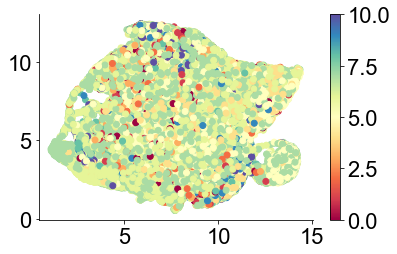

In [56]:
plt.scatter(C[0,:], C[1,:], c=Y, cmap='Spectral')
plt.colorbar()